<a href="https://colab.research.google.com/github/AndreiAf02/Data-Balancing-in-ML-DNN/blob/main/Simulation_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Simulated Dataset - ML Classification with Random Under/Oversampling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.datasets import make_classification
import random

from imblearn.datasets import make_imbalance


## Generating the Simulated Data:

In [2]:
dataset_size = 50000
nfeatures = 20
ninformative = 20

k = 5


X, y = make_classification(n_samples=dataset_size, n_features=nfeatures, n_informative=ninformative,
                           n_redundant=nfeatures-ninformative, n_classes=2, random_state=42)

X, y = make_imbalance(X, y, sampling_strategy={0: int(dataset_size/2), 1:int(dataset_size/(2*k))},
                              random_state=42)

X = X.astype(int)

# X[:,:int(ninformative/2)] = X[:,:int(ninformative/2)].astype(int)

X = pd.DataFrame(X)
y = pd.DataFrame(y)

y

## Creating binary features:
X.iloc[:,0]= (X.iloc[:,0] >= -1.5).astype(int)
X.iloc[:,1]= (X.iloc[:,1] >= -1.).astype(int)
X.iloc[:,2:5]= (X.iloc[:,2:5] >= 0).astype(int)


## Creating categorical features:
bins1 = [-15, -5, 5, 15]
labels1 = [0, 1, 2]
X.iloc[:, 5] = (pd.cut(X.iloc[:, 5], bins=bins1, labels=labels1, right=False).astype(int)).astype('category')
for i in range(2):
  X.iloc[:, i+6] = (pd.cut(X.iloc[:, i+6], bins=bins1, labels=labels1, right=False).astype(int) +int(10-2*i)).astype('category')

## Second group of categorical features:
bins2 = [-15, -3, 0, 3, 15]
labels2 = [0, 1, 2, 3]
for i in range(2):
  X.iloc[:, i+8] = (pd.cut(X.iloc[:, i+8], bins=bins2, labels=labels2, right=False).astype(int) +int(5+i)).astype('category')


data_total = X
data_total['Y'] = y
data_total = data_total.dropna().reset_index(drop=True)
data_total

/tmp/ipython-input-1373527990.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        1
1        1
2        1
3        1
4        0
        ..
29995    1
29996    1
29997    1
29998    1
29999    1
Name: 5, Length: 30000, dtype: category
Categories (3, int64): [0, 1, 2]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[:, 5] = (pd.cut(X.iloc[:, 5], bins=bins1, labels=labels1, right=False).astype(int)).astype('category')
/tmp/ipython-input-1373527990.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        11
1        11
2        11
3        11
4        11
         ..
29995    11
29996    11
29997    11
29998    11
29999    11
Name: 6, Length: 30000, dtype: category
Categories (3, int64): [10, 11, 12]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Y
0,1,1,1,0,1,1,11,9,7,8,...,0,2,-1,-2,-3,1,1,0,2,0
1,1,1,1,1,0,1,11,9,7,7,...,-1,1,-1,0,0,-1,2,2,0,0
2,0,1,1,0,1,1,11,9,7,8,...,-3,-1,0,0,0,0,-1,-2,0,0
3,1,1,1,1,1,1,11,9,7,8,...,1,2,2,4,1,0,-3,-3,2,0
4,0,1,1,1,0,0,11,9,7,6,...,-7,4,-4,-1,-1,-3,2,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1,1,1,0,1,1,11,9,8,8,...,1,0,3,0,4,3,3,-4,5,1
29996,0,1,1,1,0,1,11,9,7,8,...,1,-3,1,-4,0,0,3,0,-2,1
29997,1,1,0,1,1,1,11,9,7,7,...,0,6,-2,2,2,-2,3,-3,-1,1
29998,1,0,1,1,0,1,11,9,7,8,...,2,1,-2,-2,0,3,1,0,-3,1


In [3]:
data_total

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Y
0,1,1,1,0,1,1,11,9,7,8,...,0,2,-1,-2,-3,1,1,0,2,0
1,1,1,1,1,0,1,11,9,7,7,...,-1,1,-1,0,0,-1,2,2,0,0
2,0,1,1,0,1,1,11,9,7,8,...,-3,-1,0,0,0,0,-1,-2,0,0
3,1,1,1,1,1,1,11,9,7,8,...,1,2,2,4,1,0,-3,-3,2,0
4,0,1,1,1,0,0,11,9,7,6,...,-7,4,-4,-1,-1,-3,2,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1,1,1,0,1,1,11,9,8,8,...,1,0,3,0,4,3,3,-4,5,1
29996,0,1,1,1,0,1,11,9,7,8,...,1,-3,1,-4,0,0,3,0,-2,1
29997,1,1,0,1,1,1,11,9,7,7,...,0,6,-2,2,2,-2,3,-3,-1,1
29998,1,0,1,1,0,1,11,9,7,8,...,2,1,-2,-2,0,3,1,0,-3,1


In [4]:
X = data_total.iloc[:,:-1]
y = data_total.iloc[:, -1]
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,1,0,1,1,11,9,7,8,0,0,2,-1,-2,-3,1,1,0,2
1,1,1,1,1,0,1,11,9,7,7,1,-1,1,-1,0,0,-1,2,2,0
2,0,1,1,0,1,1,11,9,7,8,1,-3,-1,0,0,0,0,-1,-2,0
3,1,1,1,1,1,1,11,9,7,8,-1,1,2,2,4,1,0,-3,-3,2
4,0,1,1,1,0,0,11,9,7,6,0,-7,4,-4,-1,-1,-3,2,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1,1,1,0,1,1,11,9,8,8,-1,1,0,3,0,4,3,3,-4,5
29996,0,1,1,1,0,1,11,9,7,8,-3,1,-3,1,-4,0,0,3,0,-2
29997,1,1,0,1,1,1,11,9,7,7,-1,0,6,-2,2,2,-2,3,-3,-1
29998,1,0,1,1,0,1,11,9,7,8,-1,2,1,-2,-2,0,3,1,0,-3


In [5]:
y.value_counts()

,count
Y,
0,25000
1,5000


In [6]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [7]:
data2 = pd.concat([X_scaled, y], axis=1)
data2

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Y
0,1.0,1.0,1.0,0.0,1.0,0.5,0.5,0.5,0.666667,0.666667,...,0.50,0.583333,0.476190,0.409091,0.380952,0.50,0.523810,0.541667,0.545455,0
1,1.0,1.0,1.0,1.0,0.0,0.5,0.5,0.5,0.666667,0.333333,...,0.45,0.541667,0.476190,0.500000,0.523810,0.40,0.571429,0.625000,0.454545,0
2,0.0,1.0,1.0,0.0,1.0,0.5,0.5,0.5,0.666667,0.666667,...,0.35,0.458333,0.523810,0.500000,0.523810,0.45,0.428571,0.458333,0.454545,0
3,1.0,1.0,1.0,1.0,1.0,0.5,0.5,0.5,0.666667,0.666667,...,0.55,0.583333,0.619048,0.681818,0.571429,0.45,0.333333,0.416667,0.545455,0
4,0.0,1.0,1.0,1.0,0.0,0.0,0.5,0.5,0.666667,0.000000,...,0.15,0.666667,0.333333,0.454545,0.476190,0.30,0.571429,0.708333,0.590909,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1.0,1.0,1.0,0.0,1.0,0.5,0.5,0.5,1.000000,0.666667,...,0.55,0.500000,0.666667,0.500000,0.714286,0.60,0.619048,0.375000,0.681818,1
29996,0.0,1.0,1.0,1.0,0.0,0.5,0.5,0.5,0.666667,0.666667,...,0.55,0.375000,0.571429,0.318182,0.523810,0.45,0.619048,0.541667,0.363636,1
29997,1.0,1.0,0.0,1.0,1.0,0.5,0.5,0.5,0.666667,0.333333,...,0.50,0.750000,0.428571,0.590909,0.619048,0.35,0.619048,0.416667,0.409091,1
29998,1.0,0.0,1.0,1.0,0.0,0.5,0.5,0.5,0.666667,0.666667,...,0.60,0.541667,0.428571,0.409091,0.523810,0.60,0.523810,0.541667,0.318182,1


In [8]:
data2['Y'].value_counts()

,count
Y,
0,25000
1,5000


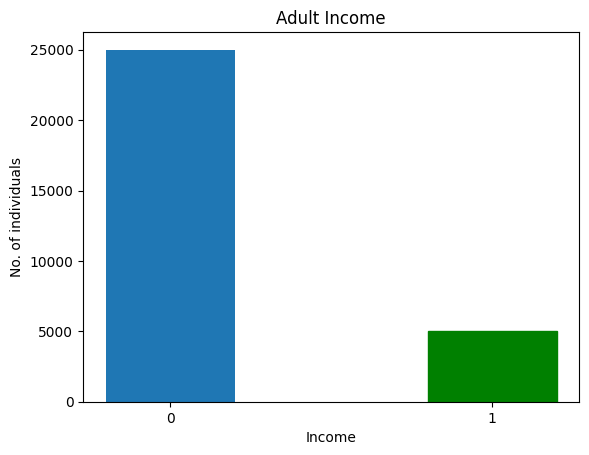

In [9]:
barlist = plt.bar([str(0),str(1)], data2['Y'].value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Income")
plt.ylabel("No. of individuals")
plt.title("Adult Income")
plt.show()

# Full Dataset:

## DNN Classification Algorithm:

In [10]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  return model



def train_and_evaluate_ml(model, X_train, X_test, y_train, y_test, domain):

    # time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)

    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)

    # conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # ## To deactivate after!!! ----------------------------------------
    # ##### Plot ROC curve and Confusion Matrix side by side
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # # ROC Curve
    # ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    # ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    # ax1.set_xlabel('False Positive Rate')
    # ax1.set_ylabel('True Positive Rate')
    # ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    # ax1.legend(loc='lower right')
    # ax1.grid()

    # # Confusion Matrix
    # conf_disp.plot(ax=ax2, cmap='Blues')
    # ax2.set_title('Confusion Matrix')
    # plt.tight_layout()
    # plt.show()
    ## To deactivate after!!! ----------------------------------------

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    return fpr, tnr, fnr, tpr


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=0)
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

In [12]:
print('X_train:',np.shape(X_train))
print('y_train:',np.shape(y_train))
print('X_test:',np.shape(X_test))
print('y_test:',np.shape(y_test))

X_train: (24000, 20)
y_train: (24000,)
X_test: (6000, 20)
y_test: (6000,)


In [13]:
## Establishing the Under/Oversampling values and imbalance ratio:

undersample_size = min(data_train.iloc[:,-1].value_counts())
oversample_size = max(data_train.iloc[:,-1].value_counts())


data_majority = data_train[data_train.iloc[:,-1]==0]
data_minority = data_train[data_train.iloc[:,-1]==1]

print(undersample_size)
print(oversample_size)

3994
20006


## Imbalanced (Original) data:

In [29]:
times = 1

FPR = []
TPR = []
FNR = []
TNR = []


for i in range(times):
    model_source = create_dnn_model(X_train.shape[1])
    result_imbalanced = train_and_evaluate_ml(model_source, X_train, X_test, y_train, y_test, "Source")
    # result_TL_imbalanced = Transductive_TL(model_source, X_T_full, y_T_full, "Target")

    FPR.append(result_imbalanced[0])
    TNR.append(result_imbalanced[1])
    FNR.append(result_imbalanced[2])
    TPR.append(result_imbalanced[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']
# print(ParamFit)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6139 - loss: 0.4603 - val_AUC: 0.8549 - val_loss: 0.3400
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8594 - loss: 0.3122 - val_AUC: 0.8974 - val_loss: 0.2809
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8913 - loss: 0.2762 - val_AUC: 0.9163 - val_loss: 0.2594
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9147 - loss: 0.2528 - val_AUC: 0.9323 - val_loss: 0.2358
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9325 - loss: 0.2260 - val_AUC: 0.9439 - val_loss: 0.2132
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9441 - loss: 0.2070 - val_AUC: 0.9519 - val_loss: 0.2071
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9474 - loss: 0.1994 - val_AUC: 0.9555 - val_loss: 0.1954
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9573 - loss: 0.1836 - val_AUC: 0.9599 - val_loss: 0.1807
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AU

In [30]:
print(ParamFit)
# ParamFit.to_csv('ML_Imbalanced.csv')

        FPR       TPR       FNR       TNR
0  0.020625  0.722664  0.277336  0.979375


In [31]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.2773359840954274
StDev FNR: nan


# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [33]:
times = 100

FPR = []
TPR = []
FNR = []
TNR = []


for i in range(times):
    data_maj_rus = data_majority.sample(n=undersample_size, replace=False)
    data_SRS_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRS_train = data_SRS_RUS.iloc[:, :-1]
    y_SRS_train = data_SRS_RUS.iloc[:, -1]
    model_SRS = create_dnn_model(X_SRS_train.shape[1])
    result_SRS = train_and_evaluate_ml(model_SRS, X_SRS_train, X_test, y_SRS_train, y_test, "Source")

    FPR.append(result_SRS[0])
    TNR.append(result_SRS[1])
    FNR.append(result_SRS[2])
    TPR.append(result_SRS[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']
# print(ParamFit)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6055 - loss: 0.6436 - val_AUC: 0.0000e+00 - val_loss: 0.8056
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7974 - loss: 0.5493 - val_AUC: 0.0000e+00 - val_loss: 0.7626
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8504 - loss: 0.4749 - val_AUC: 0.0000e+00 - val_loss: 0.6421
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8708 - loss: 0.4348 - val_AUC: 0.0000e+00 - val_loss: 0.4921
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8851 - loss: 0.4132 - val_AUC: 0.0000e+00 - val_loss: 0.5782
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9010 - loss: 0.3815 - val_AUC: 0.0000e+00 - val_loss: 0.3853
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9129 - loss: 0.3613 - val_AUC: 0.0000e+00 - val_loss: 0.3672
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9178 - loss: 0.3499 - val_AUC: 0.0000e+00 - val_loss: 0.4516
Epoch 9/10
200/200 ━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6100 - loss: 0.6501 - val_AUC: 0.0000e+00 - val_loss: 0.8434
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8047 - loss: 0.5338 - val_AUC: 0.0000e+00 - val_loss: 0.7294
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8563 - loss: 0.4632 - val_AUC: 0.0000e+00 - val_loss: 0.5924
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8655 - loss: 0.4411 - val_AUC: 0.0000e+00 - val_loss: 0.6578
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8847 - loss: 0.4119 - val_AUC: 0.0000e+00 - val_loss: 0.7737
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8994 - loss: 0.3892 - val_AUC: 0.0000e+00 - val_loss: 0.6044
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9017 - loss: 0.3806 - val_AUC: 0.0000e+00 - val_loss: 0.4560
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9155 - loss: 0.3597 - val_AUC: 0.0000e+00 - val_loss: 0.4728
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5781 - loss: 0.6580 - val_AUC: 0.0000e+00 - val_loss: 0.6822
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7815 - loss: 0.5558 - val_AUC: 0.0000e+00 - val_loss: 0.7832
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8488 - loss: 0.4789 - val_AUC: 0.0000e+00 - val_loss: 0.6493
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8651 - loss: 0.4447 - val_AUC: 0.0000e+00 - val_loss: 0.5311
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8813 - loss: 0.4138 - val_AUC: 0.0000e+00 - val_loss: 0.5505
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8978 - loss: 0.3872 - val_AUC: 0.0000e+00 - val_loss: 0.6004
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9153 - loss: 0.3627 - val_AUC: 0.0000e+00 - val_loss: 0.4806
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9222 - loss: 0.3456 - val_AUC: 0.0000e+00 - val_loss: 0.4431
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6404 - loss: 0.6375 - val_AUC: 0.0000e+00 - val_loss: 0.7554
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7895 - loss: 0.5463 - val_AUC: 0.0000e+00 - val_loss: 1.1068
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8325 - loss: 0.4975 - val_AUC: 0.0000e+00 - val_loss: 0.6480
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8728 - loss: 0.4391 - val_AUC: 0.0000e+00 - val_loss: 0.5091
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4068 - val_AUC: 0.0000e+00 - val_loss: 0.7865
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8983 - loss: 0.3933 - val_AUC: 0.0000e+00 - val_loss: 0.4789
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9124 - loss: 0.3617 - val_AUC: 0.0000e+00 - val_loss: 0.5402
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9266 - loss: 0.3383 - val_AUC: 0.0000e+00 - val_loss: 0.4582
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6020 - loss: 0.6519 - val_AUC: 0.0000e+00 - val_loss: 0.7759
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7738 - loss: 0.5631 - val_AUC: 0.0000e+00 - val_loss: 0.4973
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8442 - loss: 0.4823 - val_AUC: 0.0000e+00 - val_loss: 0.7509
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8713 - loss: 0.4360 - val_AUC: 0.0000e+00 - val_loss: 0.5217
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8746 - loss: 0.4268 - val_AUC: 0.0000e+00 - val_loss: 0.6571
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.3995 - val_AUC: 0.0000e+00 - val_loss: 0.6047
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9023 - loss: 0.3850 - val_AUC: 0.0000e+00 - val_loss: 0.7343
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9086 - loss: 0.3703 - val_AUC: 0.0000e+00 - val_loss: 0.3053
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5584 - loss: 0.6577 - val_AUC: 0.0000e+00 - val_loss: 0.8269
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7616 - loss: 0.5693 - val_AUC: 0.0000e+00 - val_loss: 0.6191
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8357 - loss: 0.4970 - val_AUC: 0.0000e+00 - val_loss: 0.7995
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8599 - loss: 0.4521 - val_AUC: 0.0000e+00 - val_loss: 0.4314
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8725 - loss: 0.4342 - val_AUC: 0.0000e+00 - val_loss: 0.5174
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8875 - loss: 0.4058 - val_AUC: 0.0000e+00 - val_loss: 0.6812
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9037 - loss: 0.3782 - val_AUC: 0.0000e+00 - val_loss: 0.4001
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9123 - loss: 0.3662 - val_AUC: 0.0000e+00 - val_loss: 0.6001
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6258 - loss: 0.6353 - val_AUC: 0.0000e+00 - val_loss: 0.6203
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8025 - loss: 0.5245 - val_AUC: 0.0000e+00 - val_loss: 0.6076
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8704 - loss: 0.4436 - val_AUC: 0.0000e+00 - val_loss: 0.6360
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8812 - loss: 0.4169 - val_AUC: 0.0000e+00 - val_loss: 0.7066
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8989 - loss: 0.3875 - val_AUC: 0.0000e+00 - val_loss: 0.4469
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9103 - loss: 0.3670 - val_AUC: 0.0000e+00 - val_loss: 0.9279
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9114 - loss: 0.3678 - val_AUC: 0.0000e+00 - val_loss: 0.5151
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9179 - loss: 0.3479 - val_AUC: 0.0000e+00 - val_loss: 0.5660
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5997 - loss: 0.6482 - val_AUC: 0.0000e+00 - val_loss: 0.9867
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7894 - loss: 0.5493 - val_AUC: 0.0000e+00 - val_loss: 0.9062
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8502 - loss: 0.4739 - val_AUC: 0.0000e+00 - val_loss: 0.8953
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8725 - loss: 0.4356 - val_AUC: 0.0000e+00 - val_loss: 0.3554
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8757 - loss: 0.4241 - val_AUC: 0.0000e+00 - val_loss: 0.8010
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8934 - loss: 0.3952 - val_AUC: 0.0000e+00 - val_loss: 0.4072
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9074 - loss: 0.3724 - val_AUC: 0.0000e+00 - val_loss: 0.5134
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9121 - loss: 0.3623 - val_AUC: 0.0000e+00 - val_loss: 0.4848
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5782 - loss: 0.6465 - val_AUC: 0.0000e+00 - val_loss: 0.6813
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8024 - loss: 0.5364 - val_AUC: 0.0000e+00 - val_loss: 0.5996
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8551 - loss: 0.4606 - val_AUC: 0.0000e+00 - val_loss: 0.5601
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8815 - loss: 0.4150 - val_AUC: 0.0000e+00 - val_loss: 0.6147
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9003 - loss: 0.3880 - val_AUC: 0.0000e+00 - val_loss: 0.5042
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9125 - loss: 0.3623 - val_AUC: 0.0000e+00 - val_loss: 0.5039
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9138 - loss: 0.3589 - val_AUC: 0.0000e+00 - val_loss: 0.4031
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9294 - loss: 0.3287 - val_AUC: 0.0000e+00 - val_loss: 0.5031
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5811 - loss: 0.6628 - val_AUC: 0.0000e+00 - val_loss: 0.8860
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7838 - loss: 0.5516 - val_AUC: 0.0000e+00 - val_loss: 0.6633
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8568 - loss: 0.4744 - val_AUC: 0.0000e+00 - val_loss: 0.6033
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8760 - loss: 0.4286 - val_AUC: 0.0000e+00 - val_loss: 0.6141
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8896 - loss: 0.4022 - val_AUC: 0.0000e+00 - val_loss: 0.5803
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9021 - loss: 0.3847 - val_AUC: 0.0000e+00 - val_loss: 0.6636
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9052 - loss: 0.3752 - val_AUC: 0.0000e+00 - val_loss: 0.9494
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9191 - loss: 0.3485 - val_AUC: 0.0000e+00 - val_loss: 0.4272
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6306 - loss: 0.6411 - val_AUC: 0.0000e+00 - val_loss: 0.7720
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7915 - loss: 0.5381 - val_AUC: 0.0000e+00 - val_loss: 0.6685
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8451 - loss: 0.4769 - val_AUC: 0.0000e+00 - val_loss: 0.6479
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8624 - loss: 0.4484 - val_AUC: 0.0000e+00 - val_loss: 0.5974
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8804 - loss: 0.4196 - val_AUC: 0.0000e+00 - val_loss: 0.6180
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8895 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.5860
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9012 - loss: 0.3808 - val_AUC: 0.0000e+00 - val_loss: 0.4541
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9127 - loss: 0.3664 - val_AUC: 0.0000e+00 - val_loss: 0.4651
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6219 - loss: 0.6361 - val_AUC: 0.0000e+00 - val_loss: 0.9367
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7791 - loss: 0.5527 - val_AUC: 0.0000e+00 - val_loss: 0.6047
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8520 - loss: 0.4689 - val_AUC: 0.0000e+00 - val_loss: 0.6002
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8767 - loss: 0.4326 - val_AUC: 0.0000e+00 - val_loss: 0.4673
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8987 - loss: 0.3881 - val_AUC: 0.0000e+00 - val_loss: 0.5604
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9051 - loss: 0.3753 - val_AUC: 0.0000e+00 - val_loss: 0.5648
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9132 - loss: 0.3624 - val_AUC: 0.0000e+00 - val_loss: 0.5329
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9239 - loss: 0.3421 - val_AUC: 0.0000e+00 - val_loss: 0.6115
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5329 - loss: 0.6547 - val_AUC: 0.0000e+00 - val_loss: 0.6874
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7804 - loss: 0.5548 - val_AUC: 0.0000e+00 - val_loss: 0.7733
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8498 - loss: 0.4781 - val_AUC: 0.0000e+00 - val_loss: 0.4623
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8803 - loss: 0.4285 - val_AUC: 0.0000e+00 - val_loss: 0.8195
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9014 - loss: 0.3861 - val_AUC: 0.0000e+00 - val_loss: 0.6043
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9083 - loss: 0.3686 - val_AUC: 0.0000e+00 - val_loss: 0.4935
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9193 - loss: 0.3496 - val_AUC: 0.0000e+00 - val_loss: 0.4263
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9196 - loss: 0.3470 - val_AUC: 0.0000e+00 - val_loss: 0.4121
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6119 - loss: 0.6474 - val_AUC: 0.0000e+00 - val_loss: 0.7332
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7642 - loss: 0.5673 - val_AUC: 0.0000e+00 - val_loss: 0.6386
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8571 - loss: 0.4733 - val_AUC: 0.0000e+00 - val_loss: 0.5755
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8797 - loss: 0.4261 - val_AUC: 0.0000e+00 - val_loss: 0.6759
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8975 - loss: 0.3966 - val_AUC: 0.0000e+00 - val_loss: 0.4827
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9147 - loss: 0.3612 - val_AUC: 0.0000e+00 - val_loss: 0.4331
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9190 - loss: 0.3524 - val_AUC: 0.0000e+00 - val_loss: 0.7831
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9174 - loss: 0.3531 - val_AUC: 0.0000e+00 - val_loss: 0.5060
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6248 - loss: 0.6371 - val_AUC: 0.0000e+00 - val_loss: 0.8708
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8048 - loss: 0.5306 - val_AUC: 0.0000e+00 - val_loss: 0.7255
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8558 - loss: 0.4673 - val_AUC: 0.0000e+00 - val_loss: 0.5260
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8890 - loss: 0.4111 - val_AUC: 0.0000e+00 - val_loss: 0.8172
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8875 - loss: 0.4053 - val_AUC: 0.0000e+00 - val_loss: 0.4865
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9103 - loss: 0.3680 - val_AUC: 0.0000e+00 - val_loss: 0.5320
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9168 - loss: 0.3515 - val_AUC: 0.0000e+00 - val_loss: 0.6218
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9298 - loss: 0.3284 - val_AUC: 0.0000e+00 - val_loss: 0.5173
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5947 - loss: 0.6695 - val_AUC: 0.0000e+00 - val_loss: 0.8902
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7509 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.8874
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8213 - loss: 0.5057 - val_AUC: 0.0000e+00 - val_loss: 0.7901
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8603 - loss: 0.4476 - val_AUC: 0.0000e+00 - val_loss: 0.5892
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8798 - loss: 0.4255 - val_AUC: 0.0000e+00 - val_loss: 0.5519
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8866 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.5264
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8875 - loss: 0.4049 - val_AUC: 0.0000e+00 - val_loss: 0.4652
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9101 - loss: 0.3676 - val_AUC: 0.0000e+00 - val_loss: 0.5195
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6004 - loss: 0.6473 - val_AUC: 0.0000e+00 - val_loss: 0.7233
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7989 - loss: 0.5340 - val_AUC: 0.0000e+00 - val_loss: 0.4446
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8585 - loss: 0.4719 - val_AUC: 0.0000e+00 - val_loss: 0.5859
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8750 - loss: 0.4296 - val_AUC: 0.0000e+00 - val_loss: 0.7426
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4132 - val_AUC: 0.0000e+00 - val_loss: 0.7700
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8916 - loss: 0.4006 - val_AUC: 0.0000e+00 - val_loss: 0.5020
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9115 - loss: 0.3679 - val_AUC: 0.0000e+00 - val_loss: 0.5891
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9124 - loss: 0.3645 - val_AUC: 0.0000e+00 - val_loss: 0.5062
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6061 - loss: 0.6457 - val_AUC: 0.0000e+00 - val_loss: 0.6421
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7681 - loss: 0.5673 - val_AUC: 0.0000e+00 - val_loss: 0.7510
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8462 - loss: 0.4832 - val_AUC: 0.0000e+00 - val_loss: 0.5311
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8720 - loss: 0.4443 - val_AUC: 0.0000e+00 - val_loss: 0.5454
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8881 - loss: 0.4094 - val_AUC: 0.0000e+00 - val_loss: 0.3355
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8900 - loss: 0.4034 - val_AUC: 0.0000e+00 - val_loss: 0.4252
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8972 - loss: 0.3876 - val_AUC: 0.0000e+00 - val_loss: 0.5047
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9158 - loss: 0.3585 - val_AUC: 0.0000e+00 - val_loss: 0.7734
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6186 - loss: 0.6449 - val_AUC: 0.0000e+00 - val_loss: 0.8721
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7830 - loss: 0.5457 - val_AUC: 0.0000e+00 - val_loss: 0.4683
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8399 - loss: 0.4857 - val_AUC: 0.0000e+00 - val_loss: 0.6745
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8757 - loss: 0.4328 - val_AUC: 0.0000e+00 - val_loss: 0.8539
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8765 - loss: 0.4237 - val_AUC: 0.0000e+00 - val_loss: 0.5336
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.4464
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9090 - loss: 0.3714 - val_AUC: 0.0000e+00 - val_loss: 0.5181
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9169 - loss: 0.3564 - val_AUC: 0.0000e+00 - val_loss: 0.5610
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6386 - loss: 0.6310 - val_AUC: 0.0000e+00 - val_loss: 0.7341
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7993 - loss: 0.5384 - val_AUC: 0.0000e+00 - val_loss: 0.4748
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8545 - loss: 0.4658 - val_AUC: 0.0000e+00 - val_loss: 0.7367
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8773 - loss: 0.4276 - val_AUC: 0.0000e+00 - val_loss: 0.5030
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8861 - loss: 0.4054 - val_AUC: 0.0000e+00 - val_loss: 0.4952
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8964 - loss: 0.3923 - val_AUC: 0.0000e+00 - val_loss: 0.4331
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9059 - loss: 0.3742 - val_AUC: 0.0000e+00 - val_loss: 0.6596
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9139 - loss: 0.3594 - val_AUC: 0.0000e+00 - val_loss: 0.4693
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6163 - loss: 0.6415 - val_AUC: 0.0000e+00 - val_loss: 0.8232
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7736 - loss: 0.5561 - val_AUC: 0.0000e+00 - val_loss: 0.7773
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8485 - loss: 0.4824 - val_AUC: 0.0000e+00 - val_loss: 0.5382
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8767 - loss: 0.4329 - val_AUC: 0.0000e+00 - val_loss: 0.7329
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8869 - loss: 0.4067 - val_AUC: 0.0000e+00 - val_loss: 0.4728
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8997 - loss: 0.3885 - val_AUC: 0.0000e+00 - val_loss: 0.4637
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9130 - loss: 0.3622 - val_AUC: 0.0000e+00 - val_loss: 0.4922
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9216 - loss: 0.3447 - val_AUC: 0.0000e+00 - val_loss: 0.6351
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6328 - loss: 0.6430 - val_AUC: 0.0000e+00 - val_loss: 0.6849
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7875 - loss: 0.5459 - val_AUC: 0.0000e+00 - val_loss: 0.5708
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8443 - loss: 0.4821 - val_AUC: 0.0000e+00 - val_loss: 0.6307
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8667 - loss: 0.4404 - val_AUC: 0.0000e+00 - val_loss: 0.5690
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8822 - loss: 0.4155 - val_AUC: 0.0000e+00 - val_loss: 0.5694
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9046 - loss: 0.3806 - val_AUC: 0.0000e+00 - val_loss: 0.4626
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9051 - loss: 0.3769 - val_AUC: 0.0000e+00 - val_loss: 0.3945
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9218 - loss: 0.3461 - val_AUC: 0.0000e+00 - val_loss: 0.3412
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6248 - loss: 0.6403 - val_AUC: 0.0000e+00 - val_loss: 0.8699
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7924 - loss: 0.5495 - val_AUC: 0.0000e+00 - val_loss: 0.6780
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8550 - loss: 0.4667 - val_AUC: 0.0000e+00 - val_loss: 0.6266
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8711 - loss: 0.4338 - val_AUC: 0.0000e+00 - val_loss: 0.6261
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8821 - loss: 0.4161 - val_AUC: 0.0000e+00 - val_loss: 0.5319
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8834 - loss: 0.4102 - val_AUC: 0.0000e+00 - val_loss: 0.9222
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8964 - loss: 0.3921 - val_AUC: 0.0000e+00 - val_loss: 0.5825
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9140 - loss: 0.3591 - val_AUC: 0.0000e+00 - val_loss: 0.5313
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5859 - loss: 0.6577 - val_AUC: 0.0000e+00 - val_loss: 0.7305
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7930 - loss: 0.5415 - val_AUC: 0.0000e+00 - val_loss: 0.7103
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8513 - loss: 0.4733 - val_AUC: 0.0000e+00 - val_loss: 0.6555
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8807 - loss: 0.4220 - val_AUC: 0.0000e+00 - val_loss: 0.6420
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4072 - val_AUC: 0.0000e+00 - val_loss: 0.5753
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8998 - loss: 0.3867 - val_AUC: 0.0000e+00 - val_loss: 0.6355
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9064 - loss: 0.3718 - val_AUC: 0.0000e+00 - val_loss: 0.5289
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9210 - loss: 0.3462 - val_AUC: 0.0000e+00 - val_loss: 0.6227
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6121 - loss: 0.6580 - val_AUC: 0.0000e+00 - val_loss: 0.7614
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7979 - loss: 0.5429 - val_AUC: 0.0000e+00 - val_loss: 0.8899
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8548 - loss: 0.4722 - val_AUC: 0.0000e+00 - val_loss: 0.5913
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8701 - loss: 0.4360 - val_AUC: 0.0000e+00 - val_loss: 0.6332
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8868 - loss: 0.4081 - val_AUC: 0.0000e+00 - val_loss: 0.6330
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9003 - loss: 0.3863 - val_AUC: 0.0000e+00 - val_loss: 0.7107
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9185 - loss: 0.3510 - val_AUC: 0.0000e+00 - val_loss: 0.3826
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9226 - loss: 0.3413 - val_AUC: 0.0000e+00 - val_loss: 0.4540
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6114 - loss: 0.6421 - val_AUC: 0.0000e+00 - val_loss: 0.6672
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7704 - loss: 0.5559 - val_AUC: 0.0000e+00 - val_loss: 0.7005
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8348 - loss: 0.4907 - val_AUC: 0.0000e+00 - val_loss: 0.5874
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8506 - loss: 0.4666 - val_AUC: 0.0000e+00 - val_loss: 0.7955
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8532 - loss: 0.4557 - val_AUC: 0.0000e+00 - val_loss: 0.3915
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8680 - loss: 0.4369 - val_AUC: 0.0000e+00 - val_loss: 0.4502
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8876 - loss: 0.4047 - val_AUC: 0.0000e+00 - val_loss: 0.6423
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9039 - loss: 0.3786 - val_AUC: 0.0000e+00 - val_loss: 0.5548
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6329 - loss: 0.6334 - val_AUC: 0.0000e+00 - val_loss: 0.6200
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8156 - loss: 0.5179 - val_AUC: 0.0000e+00 - val_loss: 0.8829
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8590 - loss: 0.4560 - val_AUC: 0.0000e+00 - val_loss: 0.7185
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8739 - loss: 0.4314 - val_AUC: 0.0000e+00 - val_loss: 0.5691
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4040 - val_AUC: 0.0000e+00 - val_loss: 0.4646
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9058 - loss: 0.3736 - val_AUC: 0.0000e+00 - val_loss: 0.5242
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9044 - loss: 0.3788 - val_AUC: 0.0000e+00 - val_loss: 0.4153
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9130 - loss: 0.3618 - val_AUC: 0.0000e+00 - val_loss: 0.3472
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6524 - loss: 0.6344 - val_AUC: 0.0000e+00 - val_loss: 0.7329
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7925 - loss: 0.5421 - val_AUC: 0.0000e+00 - val_loss: 0.5519
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8551 - loss: 0.4635 - val_AUC: 0.0000e+00 - val_loss: 0.6350
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8899 - loss: 0.4078 - val_AUC: 0.0000e+00 - val_loss: 0.4519
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8976 - loss: 0.3880 - val_AUC: 0.0000e+00 - val_loss: 0.4129
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9107 - loss: 0.3664 - val_AUC: 0.0000e+00 - val_loss: 0.5589
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9198 - loss: 0.3485 - val_AUC: 0.0000e+00 - val_loss: 0.4659
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9303 - loss: 0.3248 - val_AUC: 0.0000e+00 - val_loss: 0.3468
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6751 - loss: 0.6230 - val_AUC: 0.0000e+00 - val_loss: 0.7512
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8003 - loss: 0.5343 - val_AUC: 0.0000e+00 - val_loss: 0.7027
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8618 - loss: 0.4574 - val_AUC: 0.0000e+00 - val_loss: 0.5356
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8803 - loss: 0.4253 - val_AUC: 0.0000e+00 - val_loss: 0.6695
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8961 - loss: 0.3926 - val_AUC: 0.0000e+00 - val_loss: 0.4213
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8999 - loss: 0.3844 - val_AUC: 0.0000e+00 - val_loss: 0.6332
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9185 - loss: 0.3532 - val_AUC: 0.0000e+00 - val_loss: 0.4800
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9271 - loss: 0.3344 - val_AUC: 0.0000e+00 - val_loss: 0.5078
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6329 - loss: 0.6382 - val_AUC: 0.0000e+00 - val_loss: 0.9221
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8029 - loss: 0.5298 - val_AUC: 0.0000e+00 - val_loss: 0.9701
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8583 - loss: 0.4604 - val_AUC: 0.0000e+00 - val_loss: 0.6275
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8847 - loss: 0.4126 - val_AUC: 0.0000e+00 - val_loss: 0.5013
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9062 - loss: 0.3774 - val_AUC: 0.0000e+00 - val_loss: 0.3678
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9067 - loss: 0.3712 - val_AUC: 0.0000e+00 - val_loss: 0.4816
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9214 - loss: 0.3448 - val_AUC: 0.0000e+00 - val_loss: 0.3366
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9289 - loss: 0.3269 - val_AUC: 0.0000e+00 - val_loss: 0.3766
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6201 - loss: 0.6399 - val_AUC: 0.0000e+00 - val_loss: 0.7361
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7806 - loss: 0.5519 - val_AUC: 0.0000e+00 - val_loss: 0.9757
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8342 - loss: 0.4915 - val_AUC: 0.0000e+00 - val_loss: 0.4440
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8541 - loss: 0.4589 - val_AUC: 0.0000e+00 - val_loss: 0.7871
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8753 - loss: 0.4250 - val_AUC: 0.0000e+00 - val_loss: 0.5039
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8829 - loss: 0.4123 - val_AUC: 0.0000e+00 - val_loss: 0.4295
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8905 - loss: 0.3993 - val_AUC: 0.0000e+00 - val_loss: 0.6233
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9089 - loss: 0.3668 - val_AUC: 0.0000e+00 - val_loss: 0.3628
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5993 - loss: 0.6510 - val_AUC: 0.0000e+00 - val_loss: 0.7195
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7682 - loss: 0.5603 - val_AUC: 0.0000e+00 - val_loss: 0.7257
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8489 - loss: 0.4782 - val_AUC: 0.0000e+00 - val_loss: 0.8623
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8672 - loss: 0.4396 - val_AUC: 0.0000e+00 - val_loss: 0.7247
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8937 - loss: 0.3975 - val_AUC: 0.0000e+00 - val_loss: 0.6335
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9023 - loss: 0.3821 - val_AUC: 0.0000e+00 - val_loss: 0.7366
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9105 - loss: 0.3673 - val_AUC: 0.0000e+00 - val_loss: 0.3766
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9258 - loss: 0.3357 - val_AUC: 0.0000e+00 - val_loss: 0.3458
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5822 - loss: 0.6558 - val_AUC: 0.0000e+00 - val_loss: 0.9959
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7549 - loss: 0.5718 - val_AUC: 0.0000e+00 - val_loss: 0.8096
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8274 - loss: 0.5053 - val_AUC: 0.0000e+00 - val_loss: 0.5705
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8529 - loss: 0.4655 - val_AUC: 0.0000e+00 - val_loss: 0.7659
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8859 - loss: 0.4145 - val_AUC: 0.0000e+00 - val_loss: 0.5977
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8990 - loss: 0.3902 - val_AUC: 0.0000e+00 - val_loss: 0.7835
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9063 - loss: 0.3733 - val_AUC: 0.0000e+00 - val_loss: 0.4327
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9111 - loss: 0.3669 - val_AUC: 0.0000e+00 - val_loss: 0.4729
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5822 - loss: 0.6596 - val_AUC: 0.0000e+00 - val_loss: 0.8557
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7678 - loss: 0.5620 - val_AUC: 0.0000e+00 - val_loss: 0.7718
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8329 - loss: 0.4864 - val_AUC: 0.0000e+00 - val_loss: 0.5840
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8710 - loss: 0.4374 - val_AUC: 0.0000e+00 - val_loss: 0.6784
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8863 - loss: 0.4016 - val_AUC: 0.0000e+00 - val_loss: 0.4710
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8992 - loss: 0.3862 - val_AUC: 0.0000e+00 - val_loss: 0.7539
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9044 - loss: 0.3758 - val_AUC: 0.0000e+00 - val_loss: 0.6068
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9212 - loss: 0.3470 - val_AUC: 0.0000e+00 - val_loss: 0.6126
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5616 - loss: 0.6595 - val_AUC: 0.0000e+00 - val_loss: 0.8227
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7549 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.5618
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8429 - loss: 0.4904 - val_AUC: 0.0000e+00 - val_loss: 0.5811
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8714 - loss: 0.4395 - val_AUC: 0.0000e+00 - val_loss: 0.6196
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8919 - loss: 0.4033 - val_AUC: 0.0000e+00 - val_loss: 0.7428
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9103 - loss: 0.3664 - val_AUC: 0.0000e+00 - val_loss: 0.4166
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9165 - loss: 0.3552 - val_AUC: 0.0000e+00 - val_loss: 0.5012
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9205 - loss: 0.3437 - val_AUC: 0.0000e+00 - val_loss: 0.4327
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5807 - loss: 0.6447 - val_AUC: 0.0000e+00 - val_loss: 0.9307
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7769 - loss: 0.5648 - val_AUC: 0.0000e+00 - val_loss: 0.7626
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8404 - loss: 0.4839 - val_AUC: 0.0000e+00 - val_loss: 0.7955
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8715 - loss: 0.4379 - val_AUC: 0.0000e+00 - val_loss: 0.5425
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8820 - loss: 0.4165 - val_AUC: 0.0000e+00 - val_loss: 0.5256
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4077 - val_AUC: 0.0000e+00 - val_loss: 0.4542
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9006 - loss: 0.3831 - val_AUC: 0.0000e+00 - val_loss: 0.6312
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9174 - loss: 0.3515 - val_AUC: 0.0000e+00 - val_loss: 0.7351
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5982 - loss: 0.6470 - val_AUC: 0.0000e+00 - val_loss: 0.7359
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7808 - loss: 0.5509 - val_AUC: 0.0000e+00 - val_loss: 0.7445
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8406 - loss: 0.4833 - val_AUC: 0.0000e+00 - val_loss: 0.4906
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8785 - loss: 0.4274 - val_AUC: 0.0000e+00 - val_loss: 0.6319
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8790 - loss: 0.4176 - val_AUC: 0.0000e+00 - val_loss: 0.3019
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9034 - loss: 0.3811 - val_AUC: 0.0000e+00 - val_loss: 0.4525
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9129 - loss: 0.3632 - val_AUC: 0.0000e+00 - val_loss: 0.6165
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9280 - loss: 0.3312 - val_AUC: 0.0000e+00 - val_loss: 0.5208
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5784 - loss: 0.6558 - val_AUC: 0.0000e+00 - val_loss: 0.6770
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7752 - loss: 0.5650 - val_AUC: 0.0000e+00 - val_loss: 0.7961
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8498 - loss: 0.4798 - val_AUC: 0.0000e+00 - val_loss: 0.6978
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8706 - loss: 0.4421 - val_AUC: 0.0000e+00 - val_loss: 0.7404
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8912 - loss: 0.4030 - val_AUC: 0.0000e+00 - val_loss: 0.4630
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8965 - loss: 0.3921 - val_AUC: 0.0000e+00 - val_loss: 0.5491
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9113 - loss: 0.3637 - val_AUC: 0.0000e+00 - val_loss: 0.6643
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9249 - loss: 0.3377 - val_AUC: 0.0000e+00 - val_loss: 0.6926
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5737 - loss: 0.6467 - val_AUC: 0.0000e+00 - val_loss: 0.7871
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7488 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.6804
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8325 - loss: 0.4917 - val_AUC: 0.0000e+00 - val_loss: 0.3974
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8398 - loss: 0.4777 - val_AUC: 0.0000e+00 - val_loss: 0.7148
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8706 - loss: 0.4323 - val_AUC: 0.0000e+00 - val_loss: 0.4263
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8838 - loss: 0.4159 - val_AUC: 0.0000e+00 - val_loss: 0.6050
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8961 - loss: 0.3907 - val_AUC: 0.0000e+00 - val_loss: 0.4620
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8976 - loss: 0.3859 - val_AUC: 0.0000e+00 - val_loss: 0.4399
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6288 - loss: 0.6378 - val_AUC: 0.0000e+00 - val_loss: 0.7586
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7845 - loss: 0.5496 - val_AUC: 0.0000e+00 - val_loss: 0.6951
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8477 - loss: 0.4751 - val_AUC: 0.0000e+00 - val_loss: 0.6809
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8678 - loss: 0.4407 - val_AUC: 0.0000e+00 - val_loss: 0.5028
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8932 - loss: 0.3992 - val_AUC: 0.0000e+00 - val_loss: 0.7668
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8930 - loss: 0.3918 - val_AUC: 0.0000e+00 - val_loss: 0.6483
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9093 - loss: 0.3677 - val_AUC: 0.0000e+00 - val_loss: 0.4140
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9163 - loss: 0.3543 - val_AUC: 0.0000e+00 - val_loss: 0.5134
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6237 - loss: 0.6382 - val_AUC: 0.0000e+00 - val_loss: 0.6813
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7904 - loss: 0.5409 - val_AUC: 0.0000e+00 - val_loss: 0.7624
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8526 - loss: 0.4734 - val_AUC: 0.0000e+00 - val_loss: 0.8629
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8457 - loss: 0.4670 - val_AUC: 0.0000e+00 - val_loss: 0.4594
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8828 - loss: 0.4220 - val_AUC: 0.0000e+00 - val_loss: 0.5547
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8945 - loss: 0.3994 - val_AUC: 0.0000e+00 - val_loss: 0.5142
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8989 - loss: 0.3869 - val_AUC: 0.0000e+00 - val_loss: 0.4854
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9134 - loss: 0.3629 - val_AUC: 0.0000e+00 - val_loss: 0.5249
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5676 - loss: 0.6558 - val_AUC: 0.0000e+00 - val_loss: 0.8198
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8018 - loss: 0.5305 - val_AUC: 0.0000e+00 - val_loss: 0.5196
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8617 - loss: 0.4598 - val_AUC: 0.0000e+00 - val_loss: 0.7868
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8737 - loss: 0.4287 - val_AUC: 0.0000e+00 - val_loss: 0.5096
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8867 - loss: 0.4079 - val_AUC: 0.0000e+00 - val_loss: 0.7307
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8899 - loss: 0.4008 - val_AUC: 0.0000e+00 - val_loss: 0.6743
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9064 - loss: 0.3762 - val_AUC: 0.0000e+00 - val_loss: 0.3462
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9058 - loss: 0.3768 - val_AUC: 0.0000e+00 - val_loss: 0.7556
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5856 - loss: 0.6488 - val_AUC: 0.0000e+00 - val_loss: 0.6823
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7709 - loss: 0.5602 - val_AUC: 0.0000e+00 - val_loss: 1.0089
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8469 - loss: 0.4813 - val_AUC: 0.0000e+00 - val_loss: 0.6315
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4128 - val_AUC: 0.0000e+00 - val_loss: 0.5608
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9049 - loss: 0.3850 - val_AUC: 0.0000e+00 - val_loss: 0.4373
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9073 - loss: 0.3775 - val_AUC: 0.0000e+00 - val_loss: 0.4280
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9176 - loss: 0.3552 - val_AUC: 0.0000e+00 - val_loss: 0.3027
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9275 - loss: 0.3360 - val_AUC: 0.0000e+00 - val_loss: 0.4353
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6675 - loss: 0.6308 - val_AUC: 0.0000e+00 - val_loss: 0.7017
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8123 - loss: 0.5303 - val_AUC: 0.0000e+00 - val_loss: 0.6467
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8485 - loss: 0.4735 - val_AUC: 0.0000e+00 - val_loss: 0.7689
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8750 - loss: 0.4309 - val_AUC: 0.0000e+00 - val_loss: 0.4883
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8838 - loss: 0.4103 - val_AUC: 0.0000e+00 - val_loss: 0.5402
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9011 - loss: 0.3840 - val_AUC: 0.0000e+00 - val_loss: 0.6468
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9051 - loss: 0.3707 - val_AUC: 0.0000e+00 - val_loss: 0.6603
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9151 - loss: 0.3542 - val_AUC: 0.0000e+00 - val_loss: 0.4103
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5179 - loss: 0.6779 - val_AUC: 0.0000e+00 - val_loss: 0.8825
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7260 - loss: 0.5921 - val_AUC: 0.0000e+00 - val_loss: 0.7927
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8281 - loss: 0.5031 - val_AUC: 0.0000e+00 - val_loss: 0.6237
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8628 - loss: 0.4501 - val_AUC: 0.0000e+00 - val_loss: 0.5846
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8958 - loss: 0.3942 - val_AUC: 0.0000e+00 - val_loss: 0.7001
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8999 - loss: 0.3896 - val_AUC: 0.0000e+00 - val_loss: 0.3522
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9101 - loss: 0.3700 - val_AUC: 0.0000e+00 - val_loss: 0.5167
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9186 - loss: 0.3510 - val_AUC: 0.0000e+00 - val_loss: 0.8461
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6058 - loss: 0.6449 - val_AUC: 0.0000e+00 - val_loss: 0.7895
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7965 - loss: 0.5451 - val_AUC: 0.0000e+00 - val_loss: 0.6254
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8399 - loss: 0.4809 - val_AUC: 0.0000e+00 - val_loss: 0.5291
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8756 - loss: 0.4315 - val_AUC: 0.0000e+00 - val_loss: 0.4347
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8794 - loss: 0.4188 - val_AUC: 0.0000e+00 - val_loss: 0.6720
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.3925 - val_AUC: 0.0000e+00 - val_loss: 0.5529
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9075 - loss: 0.3713 - val_AUC: 0.0000e+00 - val_loss: 0.4869
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9157 - loss: 0.3541 - val_AUC: 0.0000e+00 - val_loss: 0.4830
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6725 - loss: 0.6273 - val_AUC: 0.0000e+00 - val_loss: 0.7099
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7965 - loss: 0.5457 - val_AUC: 0.0000e+00 - val_loss: 0.5858
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8516 - loss: 0.4682 - val_AUC: 0.0000e+00 - val_loss: 0.9062
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8627 - loss: 0.4497 - val_AUC: 0.0000e+00 - val_loss: 0.6790
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8757 - loss: 0.4294 - val_AUC: 0.0000e+00 - val_loss: 0.7307
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.3985 - val_AUC: 0.0000e+00 - val_loss: 0.5989
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.3961 - val_AUC: 0.0000e+00 - val_loss: 0.3630
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9082 - loss: 0.3703 - val_AUC: 0.0000e+00 - val_loss: 0.7588
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6275 - loss: 0.6380 - val_AUC: 0.0000e+00 - val_loss: 0.7122
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7738 - loss: 0.5528 - val_AUC: 0.0000e+00 - val_loss: 0.6973
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8438 - loss: 0.4815 - val_AUC: 0.0000e+00 - val_loss: 0.7767
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8812 - loss: 0.4221 - val_AUC: 0.0000e+00 - val_loss: 0.4868
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8981 - loss: 0.3911 - val_AUC: 0.0000e+00 - val_loss: 0.4705
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9085 - loss: 0.3716 - val_AUC: 0.0000e+00 - val_loss: 0.3672
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9192 - loss: 0.3533 - val_AUC: 0.0000e+00 - val_loss: 0.7966
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9238 - loss: 0.3450 - val_AUC: 0.0000e+00 - val_loss: 0.4765
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5875 - loss: 0.6601 - val_AUC: 0.0000e+00 - val_loss: 0.9758
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7818 - loss: 0.5573 - val_AUC: 0.0000e+00 - val_loss: 0.7240
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8497 - loss: 0.4734 - val_AUC: 0.0000e+00 - val_loss: 0.6158
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8659 - loss: 0.4476 - val_AUC: 0.0000e+00 - val_loss: 0.5368
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8876 - loss: 0.4068 - val_AUC: 0.0000e+00 - val_loss: 0.6160
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9046 - loss: 0.3818 - val_AUC: 0.0000e+00 - val_loss: 0.4434
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9139 - loss: 0.3631 - val_AUC: 0.0000e+00 - val_loss: 0.3383
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9173 - loss: 0.3549 - val_AUC: 0.0000e+00 - val_loss: 0.4614
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6580 - loss: 0.6270 - val_AUC: 0.0000e+00 - val_loss: 0.9147
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7883 - loss: 0.5470 - val_AUC: 0.0000e+00 - val_loss: 0.8101
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8435 - loss: 0.4811 - val_AUC: 0.0000e+00 - val_loss: 0.6765
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8723 - loss: 0.4350 - val_AUC: 0.0000e+00 - val_loss: 0.4468
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8816 - loss: 0.4164 - val_AUC: 0.0000e+00 - val_loss: 0.5935
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8912 - loss: 0.3996 - val_AUC: 0.0000e+00 - val_loss: 0.5768
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9021 - loss: 0.3808 - val_AUC: 0.0000e+00 - val_loss: 0.5430
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9218 - loss: 0.3468 - val_AUC: 0.0000e+00 - val_loss: 0.4669
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5650 - loss: 0.6502 - val_AUC: 0.0000e+00 - val_loss: 0.7006
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7892 - loss: 0.5449 - val_AUC: 0.0000e+00 - val_loss: 0.5584
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8538 - loss: 0.4641 - val_AUC: 0.0000e+00 - val_loss: 0.6629
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8765 - loss: 0.4288 - val_AUC: 0.0000e+00 - val_loss: 0.7402
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.3971 - val_AUC: 0.0000e+00 - val_loss: 0.7202
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9074 - loss: 0.3739 - val_AUC: 0.0000e+00 - val_loss: 0.4640
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9134 - loss: 0.3617 - val_AUC: 0.0000e+00 - val_loss: 0.4409
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9243 - loss: 0.3365 - val_AUC: 0.0000e+00 - val_loss: 0.5190
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6008 - loss: 0.6438 - val_AUC: 0.0000e+00 - val_loss: 0.8478
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7955 - loss: 0.5388 - val_AUC: 0.0000e+00 - val_loss: 0.6459
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8581 - loss: 0.4582 - val_AUC: 0.0000e+00 - val_loss: 0.5787
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8795 - loss: 0.4244 - val_AUC: 0.0000e+00 - val_loss: 0.3839
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8913 - loss: 0.4040 - val_AUC: 0.0000e+00 - val_loss: 0.4836
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9050 - loss: 0.3759 - val_AUC: 0.0000e+00 - val_loss: 0.4817
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9178 - loss: 0.3535 - val_AUC: 0.0000e+00 - val_loss: 0.5179
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9319 - loss: 0.3269 - val_AUC: 0.0000e+00 - val_loss: 0.4841
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5854 - loss: 0.6538 - val_AUC: 0.0000e+00 - val_loss: 0.9343
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7828 - loss: 0.5514 - val_AUC: 0.0000e+00 - val_loss: 0.6500
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8433 - loss: 0.4777 - val_AUC: 0.0000e+00 - val_loss: 0.6275
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8678 - loss: 0.4382 - val_AUC: 0.0000e+00 - val_loss: 0.6242
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8628 - loss: 0.4409 - val_AUC: 0.0000e+00 - val_loss: 0.6089
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8751 - loss: 0.4254 - val_AUC: 0.0000e+00 - val_loss: 0.4676
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8996 - loss: 0.3843 - val_AUC: 0.0000e+00 - val_loss: 0.5665
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9064 - loss: 0.3739 - val_AUC: 0.0000e+00 - val_loss: 0.4456
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5918 - loss: 0.6542 - val_AUC: 0.0000e+00 - val_loss: 0.8643
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7723 - loss: 0.5623 - val_AUC: 0.0000e+00 - val_loss: 0.7229
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8520 - loss: 0.4733 - val_AUC: 0.0000e+00 - val_loss: 0.6939
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8738 - loss: 0.4282 - val_AUC: 0.0000e+00 - val_loss: 0.7141
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8795 - loss: 0.4189 - val_AUC: 0.0000e+00 - val_loss: 0.4009
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8930 - loss: 0.3994 - val_AUC: 0.0000e+00 - val_loss: 0.5578
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9138 - loss: 0.3571 - val_AUC: 0.0000e+00 - val_loss: 0.6856
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9112 - loss: 0.3690 - val_AUC: 0.0000e+00 - val_loss: 0.5140
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6433 - loss: 0.6321 - val_AUC: 0.0000e+00 - val_loss: 0.7471
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7993 - loss: 0.5459 - val_AUC: 0.0000e+00 - val_loss: 0.6993
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8455 - loss: 0.4753 - val_AUC: 0.0000e+00 - val_loss: 0.6695
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8837 - loss: 0.4224 - val_AUC: 0.0000e+00 - val_loss: 0.5184
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8961 - loss: 0.3940 - val_AUC: 0.0000e+00 - val_loss: 0.4853
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9111 - loss: 0.3655 - val_AUC: 0.0000e+00 - val_loss: 0.3837
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9163 - loss: 0.3542 - val_AUC: 0.0000e+00 - val_loss: 0.4841
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9355 - loss: 0.3138 - val_AUC: 0.0000e+00 - val_loss: 0.5358
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6024 - loss: 0.6446 - val_AUC: 0.0000e+00 - val_loss: 0.7955
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7984 - loss: 0.5397 - val_AUC: 0.0000e+00 - val_loss: 1.0357
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8392 - loss: 0.4834 - val_AUC: 0.0000e+00 - val_loss: 0.6490
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8691 - loss: 0.4378 - val_AUC: 0.0000e+00 - val_loss: 0.6144
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8820 - loss: 0.4127 - val_AUC: 0.0000e+00 - val_loss: 0.5132
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9015 - loss: 0.3835 - val_AUC: 0.0000e+00 - val_loss: 0.6059
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9178 - loss: 0.3525 - val_AUC: 0.0000e+00 - val_loss: 0.6786
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9226 - loss: 0.3422 - val_AUC: 0.0000e+00 - val_loss: 0.3446
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5897 - loss: 0.6507 - val_AUC: 0.0000e+00 - val_loss: 0.5902
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7832 - loss: 0.5521 - val_AUC: 0.0000e+00 - val_loss: 0.6893
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8479 - loss: 0.4788 - val_AUC: 0.0000e+00 - val_loss: 0.3857
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8594 - loss: 0.4493 - val_AUC: 0.0000e+00 - val_loss: 0.4630
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8743 - loss: 0.4260 - val_AUC: 0.0000e+00 - val_loss: 0.5682
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9050 - loss: 0.3784 - val_AUC: 0.0000e+00 - val_loss: 0.4626
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9105 - loss: 0.3687 - val_AUC: 0.0000e+00 - val_loss: 0.5019
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9183 - loss: 0.3515 - val_AUC: 0.0000e+00 - val_loss: 0.4018
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6354 - loss: 0.6452 - val_AUC: 0.0000e+00 - val_loss: 0.7590
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7890 - loss: 0.5422 - val_AUC: 0.0000e+00 - val_loss: 0.9854
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8489 - loss: 0.4746 - val_AUC: 0.0000e+00 - val_loss: 0.7039
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8712 - loss: 0.4338 - val_AUC: 0.0000e+00 - val_loss: 0.5990
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8806 - loss: 0.4219 - val_AUC: 0.0000e+00 - val_loss: 0.5954
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9020 - loss: 0.3832 - val_AUC: 0.0000e+00 - val_loss: 0.6460
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9041 - loss: 0.3719 - val_AUC: 0.0000e+00 - val_loss: 0.4076
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9135 - loss: 0.3611 - val_AUC: 0.0000e+00 - val_loss: 0.5775
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6118 - loss: 0.6484 - val_AUC: 0.0000e+00 - val_loss: 0.8625
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7687 - loss: 0.5605 - val_AUC: 0.0000e+00 - val_loss: 0.5908
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8520 - loss: 0.4751 - val_AUC: 0.0000e+00 - val_loss: 0.7201
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8874 - loss: 0.4209 - val_AUC: 0.0000e+00 - val_loss: 0.6225
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8998 - loss: 0.3896 - val_AUC: 0.0000e+00 - val_loss: 0.6585
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9125 - loss: 0.3657 - val_AUC: 0.0000e+00 - val_loss: 0.4595
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9214 - loss: 0.3444 - val_AUC: 0.0000e+00 - val_loss: 0.2063
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9288 - loss: 0.3351 - val_AUC: 0.0000e+00 - val_loss: 0.5116
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6178 - loss: 0.6435 - val_AUC: 0.0000e+00 - val_loss: 0.6655
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7940 - loss: 0.5430 - val_AUC: 0.0000e+00 - val_loss: 0.6736
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8500 - loss: 0.4746 - val_AUC: 0.0000e+00 - val_loss: 0.6785
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8698 - loss: 0.4395 - val_AUC: 0.0000e+00 - val_loss: 0.5384
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8809 - loss: 0.4194 - val_AUC: 0.0000e+00 - val_loss: 0.7297
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9006 - loss: 0.3853 - val_AUC: 0.0000e+00 - val_loss: 0.5619
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8966 - loss: 0.3898 - val_AUC: 0.0000e+00 - val_loss: 0.4505
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9149 - loss: 0.3572 - val_AUC: 0.0000e+00 - val_loss: 0.5175
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5835 - loss: 0.6564 - val_AUC: 0.0000e+00 - val_loss: 0.8529
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7643 - loss: 0.5679 - val_AUC: 0.0000e+00 - val_loss: 0.6919
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8425 - loss: 0.4778 - val_AUC: 0.0000e+00 - val_loss: 0.5651
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8759 - loss: 0.4299 - val_AUC: 0.0000e+00 - val_loss: 0.5371
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8826 - loss: 0.4167 - val_AUC: 0.0000e+00 - val_loss: 0.6818
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8969 - loss: 0.3898 - val_AUC: 0.0000e+00 - val_loss: 0.4141
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9155 - loss: 0.3595 - val_AUC: 0.0000e+00 - val_loss: 0.3856
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9142 - loss: 0.3585 - val_AUC: 0.0000e+00 - val_loss: 0.4512
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6178 - loss: 0.6416 - val_AUC: 0.0000e+00 - val_loss: 1.0069
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7750 - loss: 0.5612 - val_AUC: 0.0000e+00 - val_loss: 0.5763
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8332 - loss: 0.4959 - val_AUC: 0.0000e+00 - val_loss: 0.7514
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8667 - loss: 0.4385 - val_AUC: 0.0000e+00 - val_loss: 0.5067
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8856 - loss: 0.4143 - val_AUC: 0.0000e+00 - val_loss: 0.7852
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9003 - loss: 0.3853 - val_AUC: 0.0000e+00 - val_loss: 0.4664
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9159 - loss: 0.3571 - val_AUC: 0.0000e+00 - val_loss: 0.3742
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9108 - loss: 0.3668 - val_AUC: 0.0000e+00 - val_loss: 0.4465
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5630 - loss: 0.6550 - val_AUC: 0.0000e+00 - val_loss: 0.7179
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7838 - loss: 0.5488 - val_AUC: 0.0000e+00 - val_loss: 0.5082
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8494 - loss: 0.4705 - val_AUC: 0.0000e+00 - val_loss: 0.5015
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8744 - loss: 0.4293 - val_AUC: 0.0000e+00 - val_loss: 0.7166
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 - loss: 0.4063 - val_AUC: 0.0000e+00 - val_loss: 0.5146
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8980 - loss: 0.3865 - val_AUC: 0.0000e+00 - val_loss: 0.5427
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9104 - loss: 0.3682 - val_AUC: 0.0000e+00 - val_loss: 0.5485
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9294 - loss: 0.3324 - val_AUC: 0.0000e+00 - val_loss: 0.6506
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5945 - loss: 0.6439 - val_AUC: 0.0000e+00 - val_loss: 0.6664
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7771 - loss: 0.5519 - val_AUC: 0.0000e+00 - val_loss: 0.4541
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8355 - loss: 0.4891 - val_AUC: 0.0000e+00 - val_loss: 0.6781
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8595 - loss: 0.4543 - val_AUC: 0.0000e+00 - val_loss: 0.5578
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8721 - loss: 0.4328 - val_AUC: 0.0000e+00 - val_loss: 0.4620
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9027 - loss: 0.3873 - val_AUC: 0.0000e+00 - val_loss: 0.5349
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9002 - loss: 0.3824 - val_AUC: 0.0000e+00 - val_loss: 0.4912
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9067 - loss: 0.3740 - val_AUC: 0.0000e+00 - val_loss: 0.4585
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5981 - loss: 0.6532 - val_AUC: 0.0000e+00 - val_loss: 0.9272
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7852 - loss: 0.5440 - val_AUC: 0.0000e+00 - val_loss: 0.4876
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8483 - loss: 0.4735 - val_AUC: 0.0000e+00 - val_loss: 0.6366
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8765 - loss: 0.4282 - val_AUC: 0.0000e+00 - val_loss: 0.6170
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8984 - loss: 0.3894 - val_AUC: 0.0000e+00 - val_loss: 0.6845
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9080 - loss: 0.3742 - val_AUC: 0.0000e+00 - val_loss: 0.3689
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9141 - loss: 0.3621 - val_AUC: 0.0000e+00 - val_loss: 0.6478
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9206 - loss: 0.3446 - val_AUC: 0.0000e+00 - val_loss: 0.5621
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6519 - loss: 0.6323 - val_AUC: 0.0000e+00 - val_loss: 1.0864
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8165 - loss: 0.5170 - val_AUC: 0.0000e+00 - val_loss: 0.6885
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8523 - loss: 0.4630 - val_AUC: 0.0000e+00 - val_loss: 0.6801
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8767 - loss: 0.4272 - val_AUC: 0.0000e+00 - val_loss: 0.4471
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8909 - loss: 0.4019 - val_AUC: 0.0000e+00 - val_loss: 0.9748
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8945 - loss: 0.3925 - val_AUC: 0.0000e+00 - val_loss: 0.4502
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9182 - loss: 0.3543 - val_AUC: 0.0000e+00 - val_loss: 0.5231
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9199 - loss: 0.3507 - val_AUC: 0.0000e+00 - val_loss: 0.6161
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6017 - loss: 0.6456 - val_AUC: 0.0000e+00 - val_loss: 0.8062
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8030 - loss: 0.5245 - val_AUC: 0.0000e+00 - val_loss: 0.5714
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8590 - loss: 0.4581 - val_AUC: 0.0000e+00 - val_loss: 0.4645
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8825 - loss: 0.4198 - val_AUC: 0.0000e+00 - val_loss: 0.4294
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.3937 - val_AUC: 0.0000e+00 - val_loss: 0.7316
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9142 - loss: 0.3634 - val_AUC: 0.0000e+00 - val_loss: 0.4445
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9222 - loss: 0.3420 - val_AUC: 0.0000e+00 - val_loss: 0.5475
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9300 - loss: 0.3274 - val_AUC: 0.0000e+00 - val_loss: 0.5641
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6031 - loss: 0.6412 - val_AUC: 0.0000e+00 - val_loss: 0.7673
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7986 - loss: 0.5313 - val_AUC: 0.0000e+00 - val_loss: 0.8876
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8571 - loss: 0.4602 - val_AUC: 0.0000e+00 - val_loss: 0.5161
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8613 - loss: 0.4448 - val_AUC: 0.0000e+00 - val_loss: 0.6529
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8885 - loss: 0.4025 - val_AUC: 0.0000e+00 - val_loss: 0.4633
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9009 - loss: 0.3854 - val_AUC: 0.0000e+00 - val_loss: 0.5223
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9167 - loss: 0.3550 - val_AUC: 0.0000e+00 - val_loss: 0.3761
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9190 - loss: 0.3517 - val_AUC: 0.0000e+00 - val_loss: 0.5869
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6042 - loss: 0.6463 - val_AUC: 0.0000e+00 - val_loss: 0.8614
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7854 - loss: 0.5507 - val_AUC: 0.0000e+00 - val_loss: 0.5680
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8447 - loss: 0.4785 - val_AUC: 0.0000e+00 - val_loss: 0.6574
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8668 - loss: 0.4425 - val_AUC: 0.0000e+00 - val_loss: 0.3925
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4135 - val_AUC: 0.0000e+00 - val_loss: 0.4469
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8976 - loss: 0.3879 - val_AUC: 0.0000e+00 - val_loss: 0.5584
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9041 - loss: 0.3799 - val_AUC: 0.0000e+00 - val_loss: 0.5526
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9111 - loss: 0.3650 - val_AUC: 0.0000e+00 - val_loss: 0.6396
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5818 - loss: 0.6427 - val_AUC: 0.0000e+00 - val_loss: 0.8660
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7867 - loss: 0.5490 - val_AUC: 0.0000e+00 - val_loss: 0.6962
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8468 - loss: 0.4723 - val_AUC: 0.0000e+00 - val_loss: 0.7500
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8750 - loss: 0.4320 - val_AUC: 0.0000e+00 - val_loss: 0.6209
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8802 - loss: 0.4210 - val_AUC: 0.0000e+00 - val_loss: 0.6121
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8975 - loss: 0.3874 - val_AUC: 0.0000e+00 - val_loss: 0.6123
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9137 - loss: 0.3592 - val_AUC: 0.0000e+00 - val_loss: 0.2980
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9096 - loss: 0.3649 - val_AUC: 0.0000e+00 - val_loss: 0.5125
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6095 - loss: 0.6398 - val_AUC: 0.0000e+00 - val_loss: 0.6660
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8007 - loss: 0.5393 - val_AUC: 0.0000e+00 - val_loss: 0.5059
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8414 - loss: 0.4841 - val_AUC: 0.0000e+00 - val_loss: 0.9172
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8717 - loss: 0.4381 - val_AUC: 0.0000e+00 - val_loss: 0.5732
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8864 - loss: 0.4107 - val_AUC: 0.0000e+00 - val_loss: 0.5369
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8969 - loss: 0.3928 - val_AUC: 0.0000e+00 - val_loss: 0.6382
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9037 - loss: 0.3796 - val_AUC: 0.0000e+00 - val_loss: 0.3551
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9116 - loss: 0.3652 - val_AUC: 0.0000e+00 - val_loss: 0.4663
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5937 - loss: 0.6502 - val_AUC: 0.0000e+00 - val_loss: 0.8128
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7814 - loss: 0.5535 - val_AUC: 0.0000e+00 - val_loss: 0.5265
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8348 - loss: 0.4908 - val_AUC: 0.0000e+00 - val_loss: 0.4195
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8483 - loss: 0.4650 - val_AUC: 0.0000e+00 - val_loss: 0.6411
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8828 - loss: 0.4158 - val_AUC: 0.0000e+00 - val_loss: 0.6785
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8982 - loss: 0.3889 - val_AUC: 0.0000e+00 - val_loss: 0.6484
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9068 - loss: 0.3748 - val_AUC: 0.0000e+00 - val_loss: 0.5337
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9034 - loss: 0.3773 - val_AUC: 0.0000e+00 - val_loss: 0.5390
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6023 - loss: 0.6535 - val_AUC: 0.0000e+00 - val_loss: 0.9005
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7758 - loss: 0.5560 - val_AUC: 0.0000e+00 - val_loss: 0.5069
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8297 - loss: 0.4946 - val_AUC: 0.0000e+00 - val_loss: 0.5112
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8636 - loss: 0.4519 - val_AUC: 0.0000e+00 - val_loss: 0.6177
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8765 - loss: 0.4255 - val_AUC: 0.0000e+00 - val_loss: 0.5177
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8866 - loss: 0.4094 - val_AUC: 0.0000e+00 - val_loss: 0.6947
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.3988 - val_AUC: 0.0000e+00 - val_loss: 0.5040
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9024 - loss: 0.3836 - val_AUC: 0.0000e+00 - val_loss: 0.6190
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5525 - loss: 0.6682 - val_AUC: 0.0000e+00 - val_loss: 0.9869
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7729 - loss: 0.5602 - val_AUC: 0.0000e+00 - val_loss: 0.9007
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8570 - loss: 0.4630 - val_AUC: 0.0000e+00 - val_loss: 0.6460
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8804 - loss: 0.4219 - val_AUC: 0.0000e+00 - val_loss: 0.6139
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8922 - loss: 0.4005 - val_AUC: 0.0000e+00 - val_loss: 0.5526
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9048 - loss: 0.3790 - val_AUC: 0.0000e+00 - val_loss: 0.7472
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9112 - loss: 0.3640 - val_AUC: 0.0000e+00 - val_loss: 0.4339
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9181 - loss: 0.3502 - val_AUC: 0.0000e+00 - val_loss: 0.4323
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6192 - loss: 0.6398 - val_AUC: 0.0000e+00 - val_loss: 0.6567
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8183 - loss: 0.5212 - val_AUC: 0.0000e+00 - val_loss: 0.5564
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8601 - loss: 0.4503 - val_AUC: 0.0000e+00 - val_loss: 0.5508
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8816 - loss: 0.4188 - val_AUC: 0.0000e+00 - val_loss: 0.5597
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4017 - val_AUC: 0.0000e+00 - val_loss: 0.3797
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9055 - loss: 0.3738 - val_AUC: 0.0000e+00 - val_loss: 0.5073
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9124 - loss: 0.3620 - val_AUC: 0.0000e+00 - val_loss: 0.5579
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9254 - loss: 0.3378 - val_AUC: 0.0000e+00 - val_loss: 0.4371
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6427 - loss: 0.6383 - val_AUC: 0.0000e+00 - val_loss: 0.8558
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8050 - loss: 0.5299 - val_AUC: 0.0000e+00 - val_loss: 0.6960
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8567 - loss: 0.4608 - val_AUC: 0.0000e+00 - val_loss: 0.6043
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8705 - loss: 0.4341 - val_AUC: 0.0000e+00 - val_loss: 0.5993
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8930 - loss: 0.3976 - val_AUC: 0.0000e+00 - val_loss: 0.7672
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9091 - loss: 0.3695 - val_AUC: 0.0000e+00 - val_loss: 0.6033
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9133 - loss: 0.3606 - val_AUC: 0.0000e+00 - val_loss: 0.5461
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9225 - loss: 0.3438 - val_AUC: 0.0000e+00 - val_loss: 0.7924
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5859 - loss: 0.6628 - val_AUC: 0.0000e+00 - val_loss: 0.8593
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7667 - loss: 0.5666 - val_AUC: 0.0000e+00 - val_loss: 0.4531
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8338 - loss: 0.4905 - val_AUC: 0.0000e+00 - val_loss: 0.5564
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8632 - loss: 0.4466 - val_AUC: 0.0000e+00 - val_loss: 0.6602
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4057 - val_AUC: 0.0000e+00 - val_loss: 0.4625
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8979 - loss: 0.3904 - val_AUC: 0.0000e+00 - val_loss: 0.5379
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9088 - loss: 0.3693 - val_AUC: 0.0000e+00 - val_loss: 0.6443
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9163 - loss: 0.3554 - val_AUC: 0.0000e+00 - val_loss: 0.7125
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5843 - loss: 0.6654 - val_AUC: 0.0000e+00 - val_loss: 0.8386
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7730 - loss: 0.5613 - val_AUC: 0.0000e+00 - val_loss: 0.5904
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8538 - loss: 0.4701 - val_AUC: 0.0000e+00 - val_loss: 0.3736
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8690 - loss: 0.4386 - val_AUC: 0.0000e+00 - val_loss: 0.6976
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8856 - loss: 0.4149 - val_AUC: 0.0000e+00 - val_loss: 0.4814
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8999 - loss: 0.3917 - val_AUC: 0.0000e+00 - val_loss: 0.5225
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9127 - loss: 0.3651 - val_AUC: 0.0000e+00 - val_loss: 0.5501
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9274 - loss: 0.3374 - val_AUC: 0.0000e+00 - val_loss: 0.5245
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6037 - loss: 0.6494 - val_AUC: 0.0000e+00 - val_loss: 0.7202
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7713 - loss: 0.5637 - val_AUC: 0.0000e+00 - val_loss: 0.6096
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8468 - loss: 0.4854 - val_AUC: 0.0000e+00 - val_loss: 0.7972
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8629 - loss: 0.4453 - val_AUC: 0.0000e+00 - val_loss: 0.5672
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8728 - loss: 0.4307 - val_AUC: 0.0000e+00 - val_loss: 0.2784
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4059 - val_AUC: 0.0000e+00 - val_loss: 0.5709
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8994 - loss: 0.3850 - val_AUC: 0.0000e+00 - val_loss: 0.5039
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9021 - loss: 0.3783 - val_AUC: 0.0000e+00 - val_loss: 0.6473
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6378 - loss: 0.6350 - val_AUC: 0.0000e+00 - val_loss: 0.9189
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7819 - loss: 0.5521 - val_AUC: 0.0000e+00 - val_loss: 0.7376
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8396 - loss: 0.4870 - val_AUC: 0.0000e+00 - val_loss: 0.5356
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8580 - loss: 0.4494 - val_AUC: 0.0000e+00 - val_loss: 0.6121
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8656 - loss: 0.4391 - val_AUC: 0.0000e+00 - val_loss: 0.5688
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8919 - loss: 0.3977 - val_AUC: 0.0000e+00 - val_loss: 0.5553
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9015 - loss: 0.3822 - val_AUC: 0.0000e+00 - val_loss: 0.5338
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9107 - loss: 0.3644 - val_AUC: 0.0000e+00 - val_loss: 0.5505
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6251 - loss: 0.6388 - val_AUC: 0.0000e+00 - val_loss: 0.7785
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7921 - loss: 0.5386 - val_AUC: 0.0000e+00 - val_loss: 0.8276
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8489 - loss: 0.4737 - val_AUC: 0.0000e+00 - val_loss: 0.7791
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8825 - loss: 0.4218 - val_AUC: 0.0000e+00 - val_loss: 0.5422
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.4001 - val_AUC: 0.0000e+00 - val_loss: 0.7072
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4016 - val_AUC: 0.0000e+00 - val_loss: 0.6180
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9038 - loss: 0.3733 - val_AUC: 0.0000e+00 - val_loss: 0.5276
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9088 - loss: 0.3644 - val_AUC: 0.0000e+00 - val_loss: 0.3389
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5914 - loss: 0.6444 - val_AUC: 0.0000e+00 - val_loss: 0.7400
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7658 - loss: 0.5643 - val_AUC: 0.0000e+00 - val_loss: 0.6445
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8339 - loss: 0.4886 - val_AUC: 0.0000e+00 - val_loss: 0.5344
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8649 - loss: 0.4423 - val_AUC: 0.0000e+00 - val_loss: 0.4460
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8737 - loss: 0.4277 - val_AUC: 0.0000e+00 - val_loss: 0.4243
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8741 - loss: 0.4275 - val_AUC: 0.0000e+00 - val_loss: 0.6509
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4038 - val_AUC: 0.0000e+00 - val_loss: 0.5057
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8967 - loss: 0.3909 - val_AUC: 0.0000e+00 - val_loss: 0.6045
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5757 - loss: 0.6611 - val_AUC: 0.0000e+00 - val_loss: 0.8537
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7664 - loss: 0.5610 - val_AUC: 0.0000e+00 - val_loss: 0.7857
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8243 - loss: 0.4984 - val_AUC: 0.0000e+00 - val_loss: 0.8034
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8588 - loss: 0.4551 - val_AUC: 0.0000e+00 - val_loss: 0.5205
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8747 - loss: 0.4248 - val_AUC: 0.0000e+00 - val_loss: 0.5059
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8891 - loss: 0.4061 - val_AUC: 0.0000e+00 - val_loss: 0.4307
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9041 - loss: 0.3823 - val_AUC: 0.0000e+00 - val_loss: 0.7802
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9178 - loss: 0.3541 - val_AUC: 0.0000e+00 - val_loss: 0.7182
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6224 - loss: 0.6829 - val_AUC: 0.0000e+00 - val_loss: 0.7601
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7979 - loss: 0.5461 - val_AUC: 0.0000e+00 - val_loss: 0.5960
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8418 - loss: 0.4769 - val_AUC: 0.0000e+00 - val_loss: 0.7277
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 - loss: 0.4150 - val_AUC: 0.0000e+00 - val_loss: 0.4595
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8877 - loss: 0.4096 - val_AUC: 0.0000e+00 - val_loss: 0.4347
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8982 - loss: 0.3894 - val_AUC: 0.0000e+00 - val_loss: 0.4914
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9087 - loss: 0.3724 - val_AUC: 0.0000e+00 - val_loss: 0.3806
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9199 - loss: 0.3460 - val_AUC: 0.0000e+00 - val_loss: 0.3997
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5837 - loss: 0.6417 - val_AUC: 0.0000e+00 - val_loss: 0.7114
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7601 - loss: 0.5718 - val_AUC: 0.0000e+00 - val_loss: 0.8406
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8346 - loss: 0.4886 - val_AUC: 0.0000e+00 - val_loss: 0.5724
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8757 - loss: 0.4327 - val_AUC: 0.0000e+00 - val_loss: 0.5527
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8990 - loss: 0.3858 - val_AUC: 0.0000e+00 - val_loss: 0.5300
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9102 - loss: 0.3647 - val_AUC: 0.0000e+00 - val_loss: 0.3756
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9255 - loss: 0.3386 - val_AUC: 0.0000e+00 - val_loss: 0.4284
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9274 - loss: 0.3316 - val_AUC: 0.0000e+00 - val_loss: 0.4454
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6163 - loss: 0.6414 - val_AUC: 0.0000e+00 - val_loss: 0.8632
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7700 - loss: 0.5617 - val_AUC: 0.0000e+00 - val_loss: 0.7617
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8308 - loss: 0.4953 - val_AUC: 0.0000e+00 - val_loss: 0.5839
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8664 - loss: 0.4437 - val_AUC: 0.0000e+00 - val_loss: 0.8521
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8839 - loss: 0.4156 - val_AUC: 0.0000e+00 - val_loss: 0.6577
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8932 - loss: 0.3967 - val_AUC: 0.0000e+00 - val_loss: 0.6263
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9066 - loss: 0.3720 - val_AUC: 0.0000e+00 - val_loss: 0.5110
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9245 - loss: 0.3396 - val_AUC: 0.0000e+00 - val_loss: 0.2941
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5702 - loss: 0.6632 - val_AUC: 0.0000e+00 - val_loss: 0.9593
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7781 - loss: 0.5624 - val_AUC: 0.0000e+00 - val_loss: 0.8633
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8382 - loss: 0.4899 - val_AUC: 0.0000e+00 - val_loss: 0.7011
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8665 - loss: 0.4448 - val_AUC: 0.0000e+00 - val_loss: 0.6025
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8815 - loss: 0.4165 - val_AUC: 0.0000e+00 - val_loss: 0.7077
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8927 - loss: 0.3962 - val_AUC: 0.0000e+00 - val_loss: 0.4874
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9079 - loss: 0.3699 - val_AUC: 0.0000e+00 - val_loss: 0.5507
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9125 - loss: 0.3630 - val_AUC: 0.0000e+00 - val_loss: 0.6088
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - AUC: 0.6076 - loss: 0.6412 - val_AUC: 0.0000e+00 - val_loss: 0.7817
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8012 - loss: 0.5318 - val_AUC: 0.0000e+00 - val_loss: 0.4548
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8355 - loss: 0.4836 - val_AUC: 0.0000e+00 - val_loss: 0.6033
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8725 - loss: 0.4315 - val_AUC: 0.0000e+00 - val_loss: 0.8858
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8899 - loss: 0.4046 - val_AUC: 0.0000e+00 - val_loss: 0.4159
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9007 - loss: 0.3801 - val_AUC: 0.0000e+00 - val_loss: 0.5728
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9188 - loss: 0.3502 - val_AUC: 0.0000e+00 - val_loss: 0.6386
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9242 - loss: 0.3390 - val_AUC: 0.0000e+00 - val_loss: 0.6956
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6160 - loss: 0.6453 - val_AUC: 0.0000e+00 - val_loss: 0.8258
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7965 - loss: 0.5454 - val_AUC: 0.0000e+00 - val_loss: 0.7620
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8461 - loss: 0.4789 - val_AUC: 0.0000e+00 - val_loss: 0.6198
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8798 - loss: 0.4223 - val_AUC: 0.0000e+00 - val_loss: 0.4835
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4064 - val_AUC: 0.0000e+00 - val_loss: 0.7200
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8986 - loss: 0.3872 - val_AUC: 0.0000e+00 - val_loss: 0.6778
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9120 - loss: 0.3648 - val_AUC: 0.0000e+00 - val_loss: 0.6202
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9221 - loss: 0.3420 - val_AUC: 0.0000e+00 - val_loss: 0.5957
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6163 - loss: 0.6412 - val_AUC: 0.0000e+00 - val_loss: 1.1289
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7842 - loss: 0.5504 - val_AUC: 0.0000e+00 - val_loss: 0.5316
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8662 - loss: 0.4575 - val_AUC: 0.0000e+00 - val_loss: 0.5457
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8909 - loss: 0.4081 - val_AUC: 0.0000e+00 - val_loss: 0.4937
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9033 - loss: 0.3845 - val_AUC: 0.0000e+00 - val_loss: 0.5625
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9129 - loss: 0.3595 - val_AUC: 0.0000e+00 - val_loss: 0.5909
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9251 - loss: 0.3391 - val_AUC: 0.0000e+00 - val_loss: 0.3035
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9295 - loss: 0.3271 - val_AUC: 0.0000e+00 - val_loss: 0.5054
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5530 - loss: 0.6823 - val_AUC: 0.0000e+00 - val_loss: 0.8483
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7398 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.7408
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8291 - loss: 0.5071 - val_AUC: 0.0000e+00 - val_loss: 0.6762
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8651 - loss: 0.4483 - val_AUC: 0.0000e+00 - val_loss: 0.6753
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.4008 - val_AUC: 0.0000e+00 - val_loss: 0.6747
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9083 - loss: 0.3726 - val_AUC: 0.0000e+00 - val_loss: 0.5579
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9124 - loss: 0.3608 - val_AUC: 0.0000e+00 - val_loss: 0.4622
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9211 - loss: 0.3444 - val_AUC: 0.0000e+00 - val_loss: 0.4346
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5559 - loss: 0.6612 - val_AUC: 0.0000e+00 - val_loss: 0.7604
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7728 - loss: 0.5662 - val_AUC: 0.0000e+00 - val_loss: 0.5873
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8408 - loss: 0.4912 - val_AUC: 0.0000e+00 - val_loss: 0.6053
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8552 - loss: 0.4619 - val_AUC: 0.0000e+00 - val_loss: 0.8006
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8832 - loss: 0.4168 - val_AUC: 0.0000e+00 - val_loss: 0.8535
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8835 - loss: 0.4114 - val_AUC: 0.0000e+00 - val_loss: 0.6840
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8985 - loss: 0.3904 - val_AUC: 0.0000e+00 - val_loss: 0.4006
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9091 - loss: 0.3680 - val_AUC: 0.0000e+00 - val_loss: 0.4399
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5962 - loss: 0.6419 - val_AUC: 0.0000e+00 - val_loss: 0.7179
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7789 - loss: 0.5463 - val_AUC: 0.0000e+00 - val_loss: 0.7910
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8516 - loss: 0.4750 - val_AUC: 0.0000e+00 - val_loss: 0.7086
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8799 - loss: 0.4253 - val_AUC: 0.0000e+00 - val_loss: 0.6478
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.3992 - val_AUC: 0.0000e+00 - val_loss: 0.7732
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9139 - loss: 0.3656 - val_AUC: 0.0000e+00 - val_loss: 0.6624
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9211 - loss: 0.3471 - val_AUC: 0.0000e+00 - val_loss: 0.5351
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9329 - loss: 0.3222 - val_AUC: 0.0000e+00 - val_loss: 0.4922
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6141 - loss: 0.6348 - val_AUC: 0.0000e+00 - val_loss: 0.8286
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7913 - loss: 0.5481 - val_AUC: 0.0000e+00 - val_loss: 0.4836
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8542 - loss: 0.4721 - val_AUC: 0.0000e+00 - val_loss: 0.6186
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8693 - loss: 0.4391 - val_AUC: 0.0000e+00 - val_loss: 0.5868
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8857 - loss: 0.4152 - val_AUC: 0.0000e+00 - val_loss: 0.5057
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8972 - loss: 0.3863 - val_AUC: 0.0000e+00 - val_loss: 0.6078
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9075 - loss: 0.3749 - val_AUC: 0.0000e+00 - val_loss: 0.5793
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9089 - loss: 0.3697 - val_AUC: 0.0000e+00 - val_loss: 0.4652
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5742 - loss: 0.6560 - val_AUC: 0.0000e+00 - val_loss: 0.8565
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7827 - loss: 0.5542 - val_AUC: 0.0000e+00 - val_loss: 0.7329
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8383 - loss: 0.4861 - val_AUC: 0.0000e+00 - val_loss: 0.7484
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8656 - loss: 0.4454 - val_AUC: 0.0000e+00 - val_loss: 0.5791
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8806 - loss: 0.4220 - val_AUC: 0.0000e+00 - val_loss: 0.7730
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8913 - loss: 0.4001 - val_AUC: 0.0000e+00 - val_loss: 0.6991
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8985 - loss: 0.3851 - val_AUC: 0.0000e+00 - val_loss: 0.4451
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9052 - loss: 0.3699 - val_AUC: 0.0000e+00 - val_loss: 0.3897
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5865 - loss: 0.6476 - val_AUC: 0.0000e+00 - val_loss: 0.8345
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7520 - loss: 0.5702 - val_AUC: 0.0000e+00 - val_loss: 0.7656
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8386 - loss: 0.4915 - val_AUC: 0.0000e+00 - val_loss: 0.6354
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8686 - loss: 0.4437 - val_AUC: 0.0000e+00 - val_loss: 0.6479
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8990 - loss: 0.3936 - val_AUC: 0.0000e+00 - val_loss: 0.5620
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9071 - loss: 0.3763 - val_AUC: 0.0000e+00 - val_loss: 0.5632
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9131 - loss: 0.3616 - val_AUC: 0.0000e+00 - val_loss: 0.4483
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9266 - loss: 0.3354 - val_AUC: 0.0000e+00 - val_loss: 0.4403
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6078 - loss: 0.6460 - val_AUC: 0.0000e+00 - val_loss: 0.8575
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7901 - loss: 0.5496 - val_AUC: 0.0000e+00 - val_loss: 0.8454
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8498 - loss: 0.4726 - val_AUC: 0.0000e+00 - val_loss: 0.5375
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8755 - loss: 0.4267 - val_AUC: 0.0000e+00 - val_loss: 0.3128
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8797 - loss: 0.4210 - val_AUC: 0.0000e+00 - val_loss: 0.6264
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.3932 - val_AUC: 0.0000e+00 - val_loss: 0.5060
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9109 - loss: 0.3641 - val_AUC: 0.0000e+00 - val_loss: 0.6980
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9091 - loss: 0.3694 - val_AUC: 0.0000e+00 - val_loss: 0.4642
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6364 - loss: 0.6356 - val_AUC: 0.0000e+00 - val_loss: 0.7969
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8047 - loss: 0.5325 - val_AUC: 0.0000e+00 - val_loss: 0.7011
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8595 - loss: 0.4653 - val_AUC: 0.0000e+00 - val_loss: 0.8949
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8797 - loss: 0.4228 - val_AUC: 0.0000e+00 - val_loss: 0.6101
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8838 - loss: 0.4104 - val_AUC: 0.0000e+00 - val_loss: 0.5412
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8980 - loss: 0.3869 - val_AUC: 0.0000e+00 - val_loss: 0.4591
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9116 - loss: 0.3607 - val_AUC: 0.0000e+00 - val_loss: 0.3122
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9218 - loss: 0.3473 - val_AUC: 0.0000e+00 - val_loss: 0.6165
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6356 - loss: 0.6400 - val_AUC: 0.0000e+00 - val_loss: 0.9724
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8100 - loss: 0.5260 - val_AUC: 0.0000e+00 - val_loss: 0.6920
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8662 - loss: 0.4533 - val_AUC: 0.0000e+00 - val_loss: 0.6041
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 - loss: 0.4040 - val_AUC: 0.0000e+00 - val_loss: 0.5455
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9035 - loss: 0.3847 - val_AUC: 0.0000e+00 - val_loss: 0.6062
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9140 - loss: 0.3605 - val_AUC: 0.0000e+00 - val_loss: 0.5416
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9253 - loss: 0.3353 - val_AUC: 0.0000e+00 - val_loss: 0.3850
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9331 - loss: 0.3210 - val_AUC: 0.0000e+00 - val_loss: 0.6020
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5996 - loss: 0.6500 - val_AUC: 0.0000e+00 - val_loss: 0.7838
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7785 - loss: 0.5581 - val_AUC: 0.0000e+00 - val_loss: 0.5218
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8436 - loss: 0.4755 - val_AUC: 0.0000e+00 - val_loss: 1.0110
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8686 - loss: 0.4373 - val_AUC: 0.0000e+00 - val_loss: 0.7047
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8860 - loss: 0.4096 - val_AUC: 0.0000e+00 - val_loss: 0.5701
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9011 - loss: 0.3845 - val_AUC: 0.0000e+00 - val_loss: 0.4134
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9113 - loss: 0.3602 - val_AUC: 0.0000e+00 - val_loss: 0.5139
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9225 - loss: 0.3441 - val_AUC: 0.0000e+00 - val_loss: 0.6769
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

In [34]:
print(ParamFit)
ParamFit.to_csv('ML_SRS_RUS.csv')

         FPR       TPR       FNR       TNR
0   0.082899  0.768390  0.231610  0.917101
1   0.130557  0.826044  0.173956  0.869443
2   0.062475  0.731610  0.268390  0.937525
3   0.085102  0.785288  0.214712  0.914898
4   0.108530  0.787276  0.212724  0.891470
..       ...       ...       ...       ...
95  0.116340  0.837972  0.162028  0.883660
96  0.084702  0.737575  0.262425  0.915298
97  0.108130  0.837972  0.162028  0.891870
98  0.130757  0.871769  0.128231  0.869243
99  0.091510  0.814115  0.185885  0.908490

[100 rows x 4 columns]


In [35]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.2257157057654076
StDev FNR: 0.0759098583518265


## Simple Random Sampling with Replacement:

In [37]:
times = 100

FPR = []
TPR = []
FNR = []
TNR = []


for i in range(times):
    data_maj_rus = data_majority.sample(n=undersample_size, replace=True)
    data_SRSwR_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRSwR_train = data_SRSwR_RUS.iloc[:, :-1]
    y_SRSwR_train = data_SRSwR_RUS.iloc[:, -1]
    model_SRSwR = create_dnn_model(X_SRSwR_train.shape[1])
    result_SRSwR = train_and_evaluate_ml(model_SRSwR, X_SRSwR_train, X_test, y_SRSwR_train, y_test, "Source")

    FPR.append(result_SRSwR[0])
    TNR.append(result_SRSwR[1])
    FNR.append(result_SRSwR[2])
    TPR.append(result_SRSwR[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5319 - loss: 0.6895 - val_AUC: 0.0000e+00 - val_loss: 0.7772
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7635 - loss: 0.5719 - val_AUC: 0.0000e+00 - val_loss: 0.8751
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8436 - loss: 0.4819 - val_AUC: 0.0000e+00 - val_loss: 0.5642
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8818 - loss: 0.4230 - val_AUC: 0.0000e+00 - val_loss: 0.5460
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8988 - loss: 0.3934 - val_AUC: 0.0000e+00 - val_loss: 0.5420
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9074 - loss: 0.3740 - val_AUC: 0.0000e+00 - val_loss: 0.3845
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9069 - loss: 0.3730 - val_AUC: 0.0000e+00 - val_loss: 0.4454
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9222 - loss: 0.3424 - val_AUC: 0.0000e+00 - val_loss: 0.4430
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6105 - loss: 0.6508 - val_AUC: 0.0000e+00 - val_loss: 0.9127
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7783 - loss: 0.5634 - val_AUC: 0.0000e+00 - val_loss: 0.7386
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8340 - loss: 0.4932 - val_AUC: 0.0000e+00 - val_loss: 0.6716
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8768 - loss: 0.4302 - val_AUC: 0.0000e+00 - val_loss: 0.4848
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8818 - loss: 0.4169 - val_AUC: 0.0000e+00 - val_loss: 0.4827
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8979 - loss: 0.3884 - val_AUC: 0.0000e+00 - val_loss: 0.3761
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9086 - loss: 0.3694 - val_AUC: 0.0000e+00 - val_loss: 0.5588
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9197 - loss: 0.3519 - val_AUC: 0.0000e+00 - val_loss: 0.4310
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5916 - loss: 0.6441 - val_AUC: 0.0000e+00 - val_loss: 0.7327
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7885 - loss: 0.5491 - val_AUC: 0.0000e+00 - val_loss: 0.7539
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8467 - loss: 0.4809 - val_AUC: 0.0000e+00 - val_loss: 0.5816
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8781 - loss: 0.4293 - val_AUC: 0.0000e+00 - val_loss: 0.8943
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8888 - loss: 0.4071 - val_AUC: 0.0000e+00 - val_loss: 0.5280
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8991 - loss: 0.3862 - val_AUC: 0.0000e+00 - val_loss: 0.6306
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9132 - loss: 0.3608 - val_AUC: 0.0000e+00 - val_loss: 0.6193
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9178 - loss: 0.3539 - val_AUC: 0.0000e+00 - val_loss: 0.6713
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5800 - loss: 0.6561 - val_AUC: 0.0000e+00 - val_loss: 0.7605
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7630 - loss: 0.5686 - val_AUC: 0.0000e+00 - val_loss: 0.6884
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8385 - loss: 0.4849 - val_AUC: 0.0000e+00 - val_loss: 0.5642
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8753 - loss: 0.4322 - val_AUC: 0.0000e+00 - val_loss: 0.7049
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4075 - val_AUC: 0.0000e+00 - val_loss: 0.5145
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9031 - loss: 0.3831 - val_AUC: 0.0000e+00 - val_loss: 0.4692
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9182 - loss: 0.3506 - val_AUC: 0.0000e+00 - val_loss: 0.4997
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9308 - loss: 0.3288 - val_AUC: 0.0000e+00 - val_loss: 0.5797
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6056 - loss: 0.6362 - val_AUC: 0.0000e+00 - val_loss: 0.7564
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7987 - loss: 0.5378 - val_AUC: 0.0000e+00 - val_loss: 0.5506
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8512 - loss: 0.4738 - val_AUC: 0.0000e+00 - val_loss: 0.6125
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8689 - loss: 0.4387 - val_AUC: 0.0000e+00 - val_loss: 0.6791
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8743 - loss: 0.4250 - val_AUC: 0.0000e+00 - val_loss: 0.5892
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8822 - loss: 0.4152 - val_AUC: 0.0000e+00 - val_loss: 0.7492
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9006 - loss: 0.3863 - val_AUC: 0.0000e+00 - val_loss: 0.5283
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9107 - loss: 0.3635 - val_AUC: 0.0000e+00 - val_loss: 0.3853
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.5884 - loss: 0.6553 - val_AUC: 0.0000e+00 - val_loss: 0.8506
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7844 - loss: 0.5532 - val_AUC: 0.0000e+00 - val_loss: 0.7052
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8436 - loss: 0.4781 - val_AUC: 0.0000e+00 - val_loss: 0.5219
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8706 - loss: 0.4369 - val_AUC: 0.0000e+00 - val_loss: 0.7519
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8836 - loss: 0.4167 - val_AUC: 0.0000e+00 - val_loss: 0.6123
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8967 - loss: 0.3904 - val_AUC: 0.0000e+00 - val_loss: 0.4279
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9149 - loss: 0.3587 - val_AUC: 0.0000e+00 - val_loss: 0.4223
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9191 - loss: 0.3471 - val_AUC: 0.0000e+00 - val_loss: 0.3772
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6191 - loss: 0.6386 - val_AUC: 0.0000e+00 - val_loss: 0.8925
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7864 - loss: 0.5468 - val_AUC: 0.0000e+00 - val_loss: 0.6436
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8668 - loss: 0.4572 - val_AUC: 0.0000e+00 - val_loss: 0.6395
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8829 - loss: 0.4212 - val_AUC: 0.0000e+00 - val_loss: 0.6429
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8963 - loss: 0.3946 - val_AUC: 0.0000e+00 - val_loss: 0.5857
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9100 - loss: 0.3679 - val_AUC: 0.0000e+00 - val_loss: 0.5483
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9099 - loss: 0.3625 - val_AUC: 0.0000e+00 - val_loss: 0.4498
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9264 - loss: 0.3328 - val_AUC: 0.0000e+00 - val_loss: 0.4668
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6035 - loss: 0.6428 - val_AUC: 0.0000e+00 - val_loss: 1.0149
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7702 - loss: 0.5602 - val_AUC: 0.0000e+00 - val_loss: 0.5409
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8297 - loss: 0.5004 - val_AUC: 0.0000e+00 - val_loss: 0.8129
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8662 - loss: 0.4488 - val_AUC: 0.0000e+00 - val_loss: 0.6857
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8766 - loss: 0.4302 - val_AUC: 0.0000e+00 - val_loss: 0.7139
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8976 - loss: 0.3910 - val_AUC: 0.0000e+00 - val_loss: 0.4356
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8995 - loss: 0.3878 - val_AUC: 0.0000e+00 - val_loss: 0.4493
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9039 - loss: 0.3766 - val_AUC: 0.0000e+00 - val_loss: 0.5316
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6155 - loss: 0.6436 - val_AUC: 0.0000e+00 - val_loss: 0.8192
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7853 - loss: 0.5486 - val_AUC: 0.0000e+00 - val_loss: 0.6396
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8433 - loss: 0.4829 - val_AUC: 0.0000e+00 - val_loss: 0.7231
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8639 - loss: 0.4478 - val_AUC: 0.0000e+00 - val_loss: 0.8129
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8737 - loss: 0.4285 - val_AUC: 0.0000e+00 - val_loss: 0.6832
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8867 - loss: 0.4107 - val_AUC: 0.0000e+00 - val_loss: 0.6041
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.3985 - val_AUC: 0.0000e+00 - val_loss: 0.5091
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9038 - loss: 0.3795 - val_AUC: 0.0000e+00 - val_loss: 0.4187
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5869 - loss: 0.6594 - val_AUC: 0.0000e+00 - val_loss: 1.0311
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7661 - loss: 0.5681 - val_AUC: 0.0000e+00 - val_loss: 0.5419
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8551 - loss: 0.4676 - val_AUC: 0.0000e+00 - val_loss: 0.5567
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8837 - loss: 0.4174 - val_AUC: 0.0000e+00 - val_loss: 0.6627
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4055 - val_AUC: 0.0000e+00 - val_loss: 0.6148
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9025 - loss: 0.3800 - val_AUC: 0.0000e+00 - val_loss: 0.5263
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9085 - loss: 0.3690 - val_AUC: 0.0000e+00 - val_loss: 0.4615
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9149 - loss: 0.3530 - val_AUC: 0.0000e+00 - val_loss: 0.5073
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6057 - loss: 0.6407 - val_AUC: 0.0000e+00 - val_loss: 0.7111
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7963 - loss: 0.5449 - val_AUC: 0.0000e+00 - val_loss: 0.6487
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8562 - loss: 0.4623 - val_AUC: 0.0000e+00 - val_loss: 0.5842
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8713 - loss: 0.4406 - val_AUC: 0.0000e+00 - val_loss: 0.4490
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4060 - val_AUC: 0.0000e+00 - val_loss: 0.5142
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9022 - loss: 0.3840 - val_AUC: 0.0000e+00 - val_loss: 0.5013
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9166 - loss: 0.3572 - val_AUC: 0.0000e+00 - val_loss: 0.4335
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9240 - loss: 0.3388 - val_AUC: 0.0000e+00 - val_loss: 0.3097
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6386 - loss: 0.6381 - val_AUC: 0.0000e+00 - val_loss: 0.8059
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7887 - loss: 0.5516 - val_AUC: 0.0000e+00 - val_loss: 0.6568
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8453 - loss: 0.4816 - val_AUC: 0.0000e+00 - val_loss: 0.6247
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8665 - loss: 0.4455 - val_AUC: 0.0000e+00 - val_loss: 0.5495
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8851 - loss: 0.4150 - val_AUC: 0.0000e+00 - val_loss: 0.5683
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8928 - loss: 0.3969 - val_AUC: 0.0000e+00 - val_loss: 0.6581
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8934 - loss: 0.3929 - val_AUC: 0.0000e+00 - val_loss: 0.5607
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9052 - loss: 0.3748 - val_AUC: 0.0000e+00 - val_loss: 0.9865
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6149 - loss: 0.6510 - val_AUC: 0.0000e+00 - val_loss: 0.8323
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7745 - loss: 0.5623 - val_AUC: 0.0000e+00 - val_loss: 0.8412
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8312 - loss: 0.5006 - val_AUC: 0.0000e+00 - val_loss: 0.4354
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8536 - loss: 0.4637 - val_AUC: 0.0000e+00 - val_loss: 0.6914
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8812 - loss: 0.4234 - val_AUC: 0.0000e+00 - val_loss: 0.5107
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8827 - loss: 0.4130 - val_AUC: 0.0000e+00 - val_loss: 0.4043
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8974 - loss: 0.3908 - val_AUC: 0.0000e+00 - val_loss: 0.5481
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9001 - loss: 0.3841 - val_AUC: 0.0000e+00 - val_loss: 0.4552
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5698 - loss: 0.6546 - val_AUC: 0.0000e+00 - val_loss: 0.9910
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7866 - loss: 0.5529 - val_AUC: 0.0000e+00 - val_loss: 0.7242
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8515 - loss: 0.4711 - val_AUC: 0.0000e+00 - val_loss: 0.4756
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8731 - loss: 0.4291 - val_AUC: 0.0000e+00 - val_loss: 0.4909
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8864 - loss: 0.4075 - val_AUC: 0.0000e+00 - val_loss: 0.3838
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.3944 - val_AUC: 0.0000e+00 - val_loss: 0.7468
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9082 - loss: 0.3642 - val_AUC: 0.0000e+00 - val_loss: 0.4079
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9129 - loss: 0.3574 - val_AUC: 0.0000e+00 - val_loss: 0.6705
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5989 - loss: 0.6437 - val_AUC: 0.0000e+00 - val_loss: 0.8910
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7937 - loss: 0.5370 - val_AUC: 0.0000e+00 - val_loss: 0.5879
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8414 - loss: 0.4842 - val_AUC: 0.0000e+00 - val_loss: 0.4673
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8564 - loss: 0.4545 - val_AUC: 0.0000e+00 - val_loss: 0.7128
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4152 - val_AUC: 0.0000e+00 - val_loss: 0.4661
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8903 - loss: 0.4022 - val_AUC: 0.0000e+00 - val_loss: 0.4128
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9010 - loss: 0.3832 - val_AUC: 0.0000e+00 - val_loss: 0.9024
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8984 - loss: 0.3906 - val_AUC: 0.0000e+00 - val_loss: 0.5715
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6334 - loss: 0.6341 - val_AUC: 0.0000e+00 - val_loss: 0.8264
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7973 - loss: 0.5460 - val_AUC: 0.0000e+00 - val_loss: 0.7183
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8583 - loss: 0.4569 - val_AUC: 0.0000e+00 - val_loss: 0.7029
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8816 - loss: 0.4226 - val_AUC: 0.0000e+00 - val_loss: 0.4435
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.3930 - val_AUC: 0.0000e+00 - val_loss: 0.5082
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9032 - loss: 0.3801 - val_AUC: 0.0000e+00 - val_loss: 0.4944
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9216 - loss: 0.3451 - val_AUC: 0.0000e+00 - val_loss: 0.4242
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9198 - loss: 0.3438 - val_AUC: 0.0000e+00 - val_loss: 0.4351
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5667 - loss: 0.6558 - val_AUC: 0.0000e+00 - val_loss: 0.6615
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7803 - loss: 0.5536 - val_AUC: 0.0000e+00 - val_loss: 0.4744
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8328 - loss: 0.4911 - val_AUC: 0.0000e+00 - val_loss: 0.7650
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8724 - loss: 0.4319 - val_AUC: 0.0000e+00 - val_loss: 0.4299
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8934 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.5284
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9025 - loss: 0.3842 - val_AUC: 0.0000e+00 - val_loss: 0.5561
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9153 - loss: 0.3536 - val_AUC: 0.0000e+00 - val_loss: 0.5345
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9179 - loss: 0.3478 - val_AUC: 0.0000e+00 - val_loss: 0.6705
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5963 - loss: 0.6517 - val_AUC: 0.0000e+00 - val_loss: 0.9496
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7838 - loss: 0.5558 - val_AUC: 0.0000e+00 - val_loss: 0.7858
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8403 - loss: 0.4761 - val_AUC: 0.0000e+00 - val_loss: 0.8057
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8608 - loss: 0.4513 - val_AUC: 0.0000e+00 - val_loss: 0.5187
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8759 - loss: 0.4241 - val_AUC: 0.0000e+00 - val_loss: 0.3342
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8922 - loss: 0.4013 - val_AUC: 0.0000e+00 - val_loss: 0.4121
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9005 - loss: 0.3864 - val_AUC: 0.0000e+00 - val_loss: 0.7724
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9121 - loss: 0.3645 - val_AUC: 0.0000e+00 - val_loss: 0.6833
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6330 - loss: 0.6401 - val_AUC: 0.0000e+00 - val_loss: 0.6094
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7938 - loss: 0.5405 - val_AUC: 0.0000e+00 - val_loss: 0.8076
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8502 - loss: 0.4691 - val_AUC: 0.0000e+00 - val_loss: 0.5650
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8672 - loss: 0.4370 - val_AUC: 0.0000e+00 - val_loss: 0.5203
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8888 - loss: 0.4036 - val_AUC: 0.0000e+00 - val_loss: 0.7468
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8976 - loss: 0.3885 - val_AUC: 0.0000e+00 - val_loss: 0.4572
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9077 - loss: 0.3685 - val_AUC: 0.0000e+00 - val_loss: 0.4876
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9212 - loss: 0.3459 - val_AUC: 0.0000e+00 - val_loss: 0.5756
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5875 - loss: 0.6412 - val_AUC: 0.0000e+00 - val_loss: 0.7216
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8096 - loss: 0.5296 - val_AUC: 0.0000e+00 - val_loss: 0.6500
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8625 - loss: 0.4551 - val_AUC: 0.0000e+00 - val_loss: 0.4052
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8798 - loss: 0.4245 - val_AUC: 0.0000e+00 - val_loss: 0.7680
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8926 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.5048
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8980 - loss: 0.3876 - val_AUC: 0.0000e+00 - val_loss: 0.3487
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9062 - loss: 0.3756 - val_AUC: 0.0000e+00 - val_loss: 0.4606
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9114 - loss: 0.3648 - val_AUC: 0.0000e+00 - val_loss: 0.5636
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5836 - loss: 0.6506 - val_AUC: 0.0000e+00 - val_loss: 0.6651
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7811 - loss: 0.5571 - val_AUC: 0.0000e+00 - val_loss: 0.7766
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8503 - loss: 0.4775 - val_AUC: 0.0000e+00 - val_loss: 0.4904
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8725 - loss: 0.4360 - val_AUC: 0.0000e+00 - val_loss: 0.7789
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8878 - loss: 0.4081 - val_AUC: 0.0000e+00 - val_loss: 0.8184
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8909 - loss: 0.4012 - val_AUC: 0.0000e+00 - val_loss: 0.5306
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9107 - loss: 0.3681 - val_AUC: 0.0000e+00 - val_loss: 0.6634
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9225 - loss: 0.3440 - val_AUC: 0.0000e+00 - val_loss: 0.4399
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6320 - loss: 0.6301 - val_AUC: 0.0000e+00 - val_loss: 0.8162
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8169 - loss: 0.5255 - val_AUC: 0.0000e+00 - val_loss: 0.7082
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8616 - loss: 0.4542 - val_AUC: 0.0000e+00 - val_loss: 0.5650
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4066 - val_AUC: 0.0000e+00 - val_loss: 0.4663
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9027 - loss: 0.3833 - val_AUC: 0.0000e+00 - val_loss: 0.4722
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9142 - loss: 0.3608 - val_AUC: 0.0000e+00 - val_loss: 0.4607
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9227 - loss: 0.3468 - val_AUC: 0.0000e+00 - val_loss: 0.4834
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9310 - loss: 0.3264 - val_AUC: 0.0000e+00 - val_loss: 0.5890
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6287 - loss: 0.6430 - val_AUC: 0.0000e+00 - val_loss: 0.7371
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7754 - loss: 0.5631 - val_AUC: 0.0000e+00 - val_loss: 0.6274
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8520 - loss: 0.4770 - val_AUC: 0.0000e+00 - val_loss: 0.8414
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8718 - loss: 0.4414 - val_AUC: 0.0000e+00 - val_loss: 0.6817
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8950 - loss: 0.4025 - val_AUC: 0.0000e+00 - val_loss: 0.6201
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9002 - loss: 0.3874 - val_AUC: 0.0000e+00 - val_loss: 0.8264
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9072 - loss: 0.3719 - val_AUC: 0.0000e+00 - val_loss: 0.5155
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9195 - loss: 0.3487 - val_AUC: 0.0000e+00 - val_loss: 0.4122
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5787 - loss: 0.6666 - val_AUC: 0.0000e+00 - val_loss: 0.7563
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7725 - loss: 0.5572 - val_AUC: 0.0000e+00 - val_loss: 0.5508
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8481 - loss: 0.4821 - val_AUC: 0.0000e+00 - val_loss: 0.5606
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8626 - loss: 0.4449 - val_AUC: 0.0000e+00 - val_loss: 0.6909
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8802 - loss: 0.4182 - val_AUC: 0.0000e+00 - val_loss: 0.7699
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8938 - loss: 0.3949 - val_AUC: 0.0000e+00 - val_loss: 0.8355
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9076 - loss: 0.3711 - val_AUC: 0.0000e+00 - val_loss: 0.5425
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9155 - loss: 0.3560 - val_AUC: 0.0000e+00 - val_loss: 0.4717
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6041 - loss: 0.6487 - val_AUC: 0.0000e+00 - val_loss: 0.5982
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7731 - loss: 0.5539 - val_AUC: 0.0000e+00 - val_loss: 0.6888
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8392 - loss: 0.4820 - val_AUC: 0.0000e+00 - val_loss: 0.5929
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8787 - loss: 0.4255 - val_AUC: 0.0000e+00 - val_loss: 0.5423
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9025 - loss: 0.3876 - val_AUC: 0.0000e+00 - val_loss: 0.5830
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9118 - loss: 0.3661 - val_AUC: 0.0000e+00 - val_loss: 0.5573
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9254 - loss: 0.3363 - val_AUC: 0.0000e+00 - val_loss: 0.4195
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9255 - loss: 0.3377 - val_AUC: 0.0000e+00 - val_loss: 0.3871
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6060 - loss: 0.6414 - val_AUC: 0.0000e+00 - val_loss: 0.7599
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8054 - loss: 0.5344 - val_AUC: 0.0000e+00 - val_loss: 0.6323
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8444 - loss: 0.4810 - val_AUC: 0.0000e+00 - val_loss: 0.6214
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8733 - loss: 0.4371 - val_AUC: 0.0000e+00 - val_loss: 0.5587
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8830 - loss: 0.4130 - val_AUC: 0.0000e+00 - val_loss: 0.6230
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9002 - loss: 0.3895 - val_AUC: 0.0000e+00 - val_loss: 0.4544
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9099 - loss: 0.3673 - val_AUC: 0.0000e+00 - val_loss: 0.6638
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9181 - loss: 0.3529 - val_AUC: 0.0000e+00 - val_loss: 0.4680
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6287 - loss: 0.6398 - val_AUC: 0.0000e+00 - val_loss: 0.7977
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7932 - loss: 0.5328 - val_AUC: 0.0000e+00 - val_loss: 0.6773
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8327 - loss: 0.4864 - val_AUC: 0.0000e+00 - val_loss: 0.5506
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8663 - loss: 0.4334 - val_AUC: 0.0000e+00 - val_loss: 0.4732
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 - loss: 0.4000 - val_AUC: 0.0000e+00 - val_loss: 0.4440
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9017 - loss: 0.3810 - val_AUC: 0.0000e+00 - val_loss: 0.4151
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9142 - loss: 0.3570 - val_AUC: 0.0000e+00 - val_loss: 0.5430
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9229 - loss: 0.3416 - val_AUC: 0.0000e+00 - val_loss: 0.5305
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5842 - loss: 0.6477 - val_AUC: 0.0000e+00 - val_loss: 0.9305
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7806 - loss: 0.5566 - val_AUC: 0.0000e+00 - val_loss: 0.7090
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8497 - loss: 0.4732 - val_AUC: 0.0000e+00 - val_loss: 0.5149
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8801 - loss: 0.4254 - val_AUC: 0.0000e+00 - val_loss: 0.4890
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8918 - loss: 0.3996 - val_AUC: 0.0000e+00 - val_loss: 0.5374
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8992 - loss: 0.3866 - val_AUC: 0.0000e+00 - val_loss: 0.4862
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9153 - loss: 0.3596 - val_AUC: 0.0000e+00 - val_loss: 0.5658
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9186 - loss: 0.3527 - val_AUC: 0.0000e+00 - val_loss: 0.6700
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6188 - loss: 0.6394 - val_AUC: 0.0000e+00 - val_loss: 0.9369
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8007 - loss: 0.5337 - val_AUC: 0.0000e+00 - val_loss: 0.7436
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8600 - loss: 0.4637 - val_AUC: 0.0000e+00 - val_loss: 0.7725
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8754 - loss: 0.4319 - val_AUC: 0.0000e+00 - val_loss: 0.7161
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8970 - loss: 0.3923 - val_AUC: 0.0000e+00 - val_loss: 0.7002
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9061 - loss: 0.3762 - val_AUC: 0.0000e+00 - val_loss: 0.4253
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9197 - loss: 0.3487 - val_AUC: 0.0000e+00 - val_loss: 0.4852
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9289 - loss: 0.3290 - val_AUC: 0.0000e+00 - val_loss: 0.4301
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5710 - loss: 0.6544 - val_AUC: 0.0000e+00 - val_loss: 0.7419
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7716 - loss: 0.5592 - val_AUC: 0.0000e+00 - val_loss: 0.6694
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8394 - loss: 0.4870 - val_AUC: 0.0000e+00 - val_loss: 0.8711
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8596 - loss: 0.4518 - val_AUC: 0.0000e+00 - val_loss: 0.5754
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8820 - loss: 0.4168 - val_AUC: 0.0000e+00 - val_loss: 0.6413
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4052 - val_AUC: 0.0000e+00 - val_loss: 0.5521
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9055 - loss: 0.3778 - val_AUC: 0.0000e+00 - val_loss: 0.4635
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9085 - loss: 0.3700 - val_AUC: 0.0000e+00 - val_loss: 0.4922
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5687 - loss: 0.6805 - val_AUC: 0.0000e+00 - val_loss: 0.9351
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7606 - loss: 0.5717 - val_AUC: 0.0000e+00 - val_loss: 0.7775
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8455 - loss: 0.4828 - val_AUC: 0.0000e+00 - val_loss: 0.7628
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8705 - loss: 0.4413 - val_AUC: 0.0000e+00 - val_loss: 0.6433
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8853 - loss: 0.4097 - val_AUC: 0.0000e+00 - val_loss: 0.4862
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8973 - loss: 0.3920 - val_AUC: 0.0000e+00 - val_loss: 0.7293
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9086 - loss: 0.3694 - val_AUC: 0.0000e+00 - val_loss: 0.4382
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9176 - loss: 0.3513 - val_AUC: 0.0000e+00 - val_loss: 0.6401
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.6072 - loss: 0.6448 - val_AUC: 0.0000e+00 - val_loss: 0.7650
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7795 - loss: 0.5564 - val_AUC: 0.0000e+00 - val_loss: 0.8953
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8488 - loss: 0.4736 - val_AUC: 0.0000e+00 - val_loss: 0.6160
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8797 - loss: 0.4269 - val_AUC: 0.0000e+00 - val_loss: 0.5629
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8899 - loss: 0.4046 - val_AUC: 0.0000e+00 - val_loss: 0.6748
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9020 - loss: 0.3837 - val_AUC: 0.0000e+00 - val_loss: 0.4823
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9268 - loss: 0.3370 - val_AUC: 0.0000e+00 - val_loss: 0.4971
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9289 - loss: 0.3269 - val_AUC: 0.0000e+00 - val_loss: 0.6151
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5720 - loss: 0.6501 - val_AUC: 0.0000e+00 - val_loss: 0.8026
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7630 - loss: 0.5690 - val_AUC: 0.0000e+00 - val_loss: 0.6945
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8297 - loss: 0.5027 - val_AUC: 0.0000e+00 - val_loss: 0.6756
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8545 - loss: 0.4563 - val_AUC: 0.0000e+00 - val_loss: 0.7305
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8781 - loss: 0.4201 - val_AUC: 0.0000e+00 - val_loss: 0.7008
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8899 - loss: 0.4058 - val_AUC: 0.0000e+00 - val_loss: 0.6585
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9038 - loss: 0.3803 - val_AUC: 0.0000e+00 - val_loss: 0.7339
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9173 - loss: 0.3557 - val_AUC: 0.0000e+00 - val_loss: 0.3962
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6146 - loss: 0.6462 - val_AUC: 0.0000e+00 - val_loss: 0.8555
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8027 - loss: 0.5374 - val_AUC: 0.0000e+00 - val_loss: 0.5021
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8643 - loss: 0.4571 - val_AUC: 0.0000e+00 - val_loss: 0.5025
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8806 - loss: 0.4219 - val_AUC: 0.0000e+00 - val_loss: 0.6550
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8951 - loss: 0.3946 - val_AUC: 0.0000e+00 - val_loss: 0.7431
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9053 - loss: 0.3762 - val_AUC: 0.0000e+00 - val_loss: 0.5633
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9168 - loss: 0.3547 - val_AUC: 0.0000e+00 - val_loss: 0.6135
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9132 - loss: 0.3573 - val_AUC: 0.0000e+00 - val_loss: 0.5029
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6287 - loss: 0.6392 - val_AUC: 0.0000e+00 - val_loss: 0.6330
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7945 - loss: 0.5430 - val_AUC: 0.0000e+00 - val_loss: 0.6529
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8467 - loss: 0.4771 - val_AUC: 0.0000e+00 - val_loss: 0.4832
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8845 - loss: 0.4168 - val_AUC: 0.0000e+00 - val_loss: 0.5233
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9009 - loss: 0.3853 - val_AUC: 0.0000e+00 - val_loss: 0.3658
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9145 - loss: 0.3622 - val_AUC: 0.0000e+00 - val_loss: 0.5457
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9199 - loss: 0.3475 - val_AUC: 0.0000e+00 - val_loss: 0.4726
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9244 - loss: 0.3377 - val_AUC: 0.0000e+00 - val_loss: 0.5356
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6242 - loss: 0.6360 - val_AUC: 0.0000e+00 - val_loss: 0.8892
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7790 - loss: 0.5527 - val_AUC: 0.0000e+00 - val_loss: 0.6564
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8548 - loss: 0.4696 - val_AUC: 0.0000e+00 - val_loss: 0.7074
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8939 - loss: 0.4092 - val_AUC: 0.0000e+00 - val_loss: 0.5391
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9032 - loss: 0.3864 - val_AUC: 0.0000e+00 - val_loss: 0.5078
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9182 - loss: 0.3541 - val_AUC: 0.0000e+00 - val_loss: 0.5763
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9197 - loss: 0.3517 - val_AUC: 0.0000e+00 - val_loss: 0.4748
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9279 - loss: 0.3306 - val_AUC: 0.0000e+00 - val_loss: 0.5230
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6444 - loss: 0.6364 - val_AUC: 0.0000e+00 - val_loss: 0.9081
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7806 - loss: 0.5484 - val_AUC: 0.0000e+00 - val_loss: 0.7546
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8369 - loss: 0.4870 - val_AUC: 0.0000e+00 - val_loss: 0.6750
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8719 - loss: 0.4320 - val_AUC: 0.0000e+00 - val_loss: 0.5634
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8855 - loss: 0.4099 - val_AUC: 0.0000e+00 - val_loss: 0.6057
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.3993 - val_AUC: 0.0000e+00 - val_loss: 0.6546
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9119 - loss: 0.3624 - val_AUC: 0.0000e+00 - val_loss: 0.5202
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9194 - loss: 0.3511 - val_AUC: 0.0000e+00 - val_loss: 0.7852
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6227 - loss: 0.6367 - val_AUC: 0.0000e+00 - val_loss: 0.8279
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7908 - loss: 0.5452 - val_AUC: 0.0000e+00 - val_loss: 0.6700
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8573 - loss: 0.4687 - val_AUC: 0.0000e+00 - val_loss: 0.7240
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8854 - loss: 0.4195 - val_AUC: 0.0000e+00 - val_loss: 0.6210
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.6305
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8988 - loss: 0.3896 - val_AUC: 0.0000e+00 - val_loss: 0.4239
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9115 - loss: 0.3681 - val_AUC: 0.0000e+00 - val_loss: 0.4318
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9134 - loss: 0.3608 - val_AUC: 0.0000e+00 - val_loss: 0.4279
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5980 - loss: 0.6491 - val_AUC: 0.0000e+00 - val_loss: 0.9536
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7893 - loss: 0.5356 - val_AUC: 0.0000e+00 - val_loss: 0.4933
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8510 - loss: 0.4712 - val_AUC: 0.0000e+00 - val_loss: 0.5970
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8861 - loss: 0.4136 - val_AUC: 0.0000e+00 - val_loss: 0.7333
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9004 - loss: 0.3864 - val_AUC: 0.0000e+00 - val_loss: 0.5879
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9169 - loss: 0.3534 - val_AUC: 0.0000e+00 - val_loss: 0.6255
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9200 - loss: 0.3492 - val_AUC: 0.0000e+00 - val_loss: 0.4178
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9255 - loss: 0.3374 - val_AUC: 0.0000e+00 - val_loss: 0.3987
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6438 - loss: 0.6257 - val_AUC: 0.0000e+00 - val_loss: 0.6549
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8104 - loss: 0.5230 - val_AUC: 0.0000e+00 - val_loss: 0.8233
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8617 - loss: 0.4521 - val_AUC: 0.0000e+00 - val_loss: 0.6116
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4134 - val_AUC: 0.0000e+00 - val_loss: 0.6580
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.3968 - val_AUC: 0.0000e+00 - val_loss: 0.6440
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9140 - loss: 0.3591 - val_AUC: 0.0000e+00 - val_loss: 0.6245
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9250 - loss: 0.3391 - val_AUC: 0.0000e+00 - val_loss: 0.4585
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9294 - loss: 0.3222 - val_AUC: 0.0000e+00 - val_loss: 0.4541
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6245 - loss: 0.6394 - val_AUC: 0.0000e+00 - val_loss: 0.8274
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7889 - loss: 0.5497 - val_AUC: 0.0000e+00 - val_loss: 0.5823
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8385 - loss: 0.4789 - val_AUC: 0.0000e+00 - val_loss: 0.4505
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8606 - loss: 0.4471 - val_AUC: 0.0000e+00 - val_loss: 0.8641
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8879 - loss: 0.4102 - val_AUC: 0.0000e+00 - val_loss: 0.5671
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.3970 - val_AUC: 0.0000e+00 - val_loss: 0.4075
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9102 - loss: 0.3667 - val_AUC: 0.0000e+00 - val_loss: 0.4194
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9183 - loss: 0.3544 - val_AUC: 0.0000e+00 - val_loss: 0.4412
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6461 - loss: 0.6350 - val_AUC: 0.0000e+00 - val_loss: 0.8431
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8091 - loss: 0.5312 - val_AUC: 0.0000e+00 - val_loss: 0.9797
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8450 - loss: 0.4804 - val_AUC: 0.0000e+00 - val_loss: 0.7171
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8630 - loss: 0.4448 - val_AUC: 0.0000e+00 - val_loss: 0.6993
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8797 - loss: 0.4202 - val_AUC: 0.0000e+00 - val_loss: 0.5402
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8974 - loss: 0.3909 - val_AUC: 0.0000e+00 - val_loss: 0.7183
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9083 - loss: 0.3726 - val_AUC: 0.0000e+00 - val_loss: 0.6117
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9127 - loss: 0.3640 - val_AUC: 0.0000e+00 - val_loss: 0.4403
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6613 - loss: 0.6262 - val_AUC: 0.0000e+00 - val_loss: 0.7326
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8084 - loss: 0.5246 - val_AUC: 0.0000e+00 - val_loss: 0.4395
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8522 - loss: 0.4654 - val_AUC: 0.0000e+00 - val_loss: 0.7271
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8770 - loss: 0.4274 - val_AUC: 0.0000e+00 - val_loss: 0.5886
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9005 - loss: 0.3843 - val_AUC: 0.0000e+00 - val_loss: 0.6083
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9117 - loss: 0.3639 - val_AUC: 0.0000e+00 - val_loss: 0.4046
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9210 - loss: 0.3501 - val_AUC: 0.0000e+00 - val_loss: 0.4156
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9315 - loss: 0.3258 - val_AUC: 0.0000e+00 - val_loss: 0.4675
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5583 - loss: 0.6582 - val_AUC: 0.0000e+00 - val_loss: 0.9330
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7892 - loss: 0.5441 - val_AUC: 0.0000e+00 - val_loss: 0.4743
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8386 - loss: 0.4826 - val_AUC: 0.0000e+00 - val_loss: 0.7218
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8747 - loss: 0.4294 - val_AUC: 0.0000e+00 - val_loss: 0.6015
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8820 - loss: 0.4121 - val_AUC: 0.0000e+00 - val_loss: 0.6231
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8857 - loss: 0.4080 - val_AUC: 0.0000e+00 - val_loss: 0.4632
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8990 - loss: 0.3831 - val_AUC: 0.0000e+00 - val_loss: 0.2855
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9010 - loss: 0.3807 - val_AUC: 0.0000e+00 - val_loss: 0.5532
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6400 - loss: 0.6322 - val_AUC: 0.0000e+00 - val_loss: 0.8531
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8084 - loss: 0.5309 - val_AUC: 0.0000e+00 - val_loss: 0.8115
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8571 - loss: 0.4663 - val_AUC: 0.0000e+00 - val_loss: 0.5705
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8715 - loss: 0.4316 - val_AUC: 0.0000e+00 - val_loss: 0.5152
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8912 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.3652
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9022 - loss: 0.3831 - val_AUC: 0.0000e+00 - val_loss: 0.6372
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9112 - loss: 0.3649 - val_AUC: 0.0000e+00 - val_loss: 0.6420
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9120 - loss: 0.3627 - val_AUC: 0.0000e+00 - val_loss: 0.5728
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5895 - loss: 0.6679 - val_AUC: 0.0000e+00 - val_loss: 0.9009
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7689 - loss: 0.5612 - val_AUC: 0.0000e+00 - val_loss: 0.7302
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8397 - loss: 0.4840 - val_AUC: 0.0000e+00 - val_loss: 0.5498
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8736 - loss: 0.4325 - val_AUC: 0.0000e+00 - val_loss: 0.4286
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8707 - loss: 0.4335 - val_AUC: 0.0000e+00 - val_loss: 0.5043
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8909 - loss: 0.3988 - val_AUC: 0.0000e+00 - val_loss: 0.4467
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9100 - loss: 0.3706 - val_AUC: 0.0000e+00 - val_loss: 0.5895
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9130 - loss: 0.3619 - val_AUC: 0.0000e+00 - val_loss: 0.5358
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5646 - loss: 0.6545 - val_AUC: 0.0000e+00 - val_loss: 0.8374
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7741 - loss: 0.5619 - val_AUC: 0.0000e+00 - val_loss: 0.4976
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8346 - loss: 0.4949 - val_AUC: 0.0000e+00 - val_loss: 0.8740
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8667 - loss: 0.4434 - val_AUC: 0.0000e+00 - val_loss: 0.6647
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8767 - loss: 0.4269 - val_AUC: 0.0000e+00 - val_loss: 0.8737
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.3990 - val_AUC: 0.0000e+00 - val_loss: 0.7420
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9048 - loss: 0.3774 - val_AUC: 0.0000e+00 - val_loss: 0.5906
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9152 - loss: 0.3545 - val_AUC: 0.0000e+00 - val_loss: 0.5166
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5748 - loss: 0.6527 - val_AUC: 0.0000e+00 - val_loss: 0.7338
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7771 - loss: 0.5586 - val_AUC: 0.0000e+00 - val_loss: 0.7342
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8521 - loss: 0.4678 - val_AUC: 0.0000e+00 - val_loss: 0.4969
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8802 - loss: 0.4212 - val_AUC: 0.0000e+00 - val_loss: 0.6071
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8948 - loss: 0.3941 - val_AUC: 0.0000e+00 - val_loss: 0.4801
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9089 - loss: 0.3699 - val_AUC: 0.0000e+00 - val_loss: 0.4182
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9185 - loss: 0.3501 - val_AUC: 0.0000e+00 - val_loss: 0.5869
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9306 - loss: 0.3266 - val_AUC: 0.0000e+00 - val_loss: 0.3895
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5999 - loss: 0.6432 - val_AUC: 0.0000e+00 - val_loss: 0.7156
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7830 - loss: 0.5490 - val_AUC: 0.0000e+00 - val_loss: 0.7602
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8487 - loss: 0.4737 - val_AUC: 0.0000e+00 - val_loss: 0.5775
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8685 - loss: 0.4374 - val_AUC: 0.0000e+00 - val_loss: 0.4537
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8814 - loss: 0.4181 - val_AUC: 0.0000e+00 - val_loss: 0.7643
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8961 - loss: 0.3932 - val_AUC: 0.0000e+00 - val_loss: 0.4518
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9059 - loss: 0.3766 - val_AUC: 0.0000e+00 - val_loss: 0.5221
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9113 - loss: 0.3694 - val_AUC: 0.0000e+00 - val_loss: 0.8254
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6194 - loss: 0.6414 - val_AUC: 0.0000e+00 - val_loss: 0.9018
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7925 - loss: 0.5443 - val_AUC: 0.0000e+00 - val_loss: 0.6793
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8489 - loss: 0.4766 - val_AUC: 0.0000e+00 - val_loss: 0.5434
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8816 - loss: 0.4266 - val_AUC: 0.0000e+00 - val_loss: 0.8134
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8903 - loss: 0.4038 - val_AUC: 0.0000e+00 - val_loss: 0.5116
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9095 - loss: 0.3708 - val_AUC: 0.0000e+00 - val_loss: 0.6431
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9137 - loss: 0.3592 - val_AUC: 0.0000e+00 - val_loss: 0.3536
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9282 - loss: 0.3305 - val_AUC: 0.0000e+00 - val_loss: 0.6971
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5552 - loss: 0.6570 - val_AUC: 0.0000e+00 - val_loss: 0.8173
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7605 - loss: 0.5653 - val_AUC: 0.0000e+00 - val_loss: 0.7743
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8437 - loss: 0.4829 - val_AUC: 0.0000e+00 - val_loss: 0.6516
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8718 - loss: 0.4378 - val_AUC: 0.0000e+00 - val_loss: 0.6741
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8750 - loss: 0.4275 - val_AUC: 0.0000e+00 - val_loss: 0.5425
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8982 - loss: 0.3903 - val_AUC: 0.0000e+00 - val_loss: 0.6444
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9072 - loss: 0.3704 - val_AUC: 0.0000e+00 - val_loss: 0.3589
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9245 - loss: 0.3379 - val_AUC: 0.0000e+00 - val_loss: 0.5013
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.5727 - loss: 0.6482 - val_AUC: 0.0000e+00 - val_loss: 0.7424
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7709 - loss: 0.5514 - val_AUC: 0.0000e+00 - val_loss: 0.6234
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8373 - loss: 0.4906 - val_AUC: 0.0000e+00 - val_loss: 0.6219
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8596 - loss: 0.4537 - val_AUC: 0.0000e+00 - val_loss: 0.4263
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8766 - loss: 0.4276 - val_AUC: 0.0000e+00 - val_loss: 0.5522
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4021 - val_AUC: 0.0000e+00 - val_loss: 0.7099
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9021 - loss: 0.3833 - val_AUC: 0.0000e+00 - val_loss: 0.4476
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9042 - loss: 0.3780 - val_AUC: 0.0000e+00 - val_loss: 0.5502
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6081 - loss: 0.6388 - val_AUC: 0.0000e+00 - val_loss: 0.9168
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7762 - loss: 0.5577 - val_AUC: 0.0000e+00 - val_loss: 0.6529
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8429 - loss: 0.4812 - val_AUC: 0.0000e+00 - val_loss: 0.7325
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8641 - loss: 0.4419 - val_AUC: 0.0000e+00 - val_loss: 0.7627
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8706 - loss: 0.4316 - val_AUC: 0.0000e+00 - val_loss: 0.8373
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8834 - loss: 0.4109 - val_AUC: 0.0000e+00 - val_loss: 0.4859
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8966 - loss: 0.3905 - val_AUC: 0.0000e+00 - val_loss: 0.3410
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8937 - loss: 0.3940 - val_AUC: 0.0000e+00 - val_loss: 0.5673
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5805 - loss: 0.6476 - val_AUC: 0.0000e+00 - val_loss: 0.8206
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7762 - loss: 0.5622 - val_AUC: 0.0000e+00 - val_loss: 0.6393
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8501 - loss: 0.4847 - val_AUC: 0.0000e+00 - val_loss: 0.4485
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8776 - loss: 0.4278 - val_AUC: 0.0000e+00 - val_loss: 0.4938
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4073 - val_AUC: 0.0000e+00 - val_loss: 0.6705
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9083 - loss: 0.3718 - val_AUC: 0.0000e+00 - val_loss: 0.4012
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9129 - loss: 0.3643 - val_AUC: 0.0000e+00 - val_loss: 0.4742
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9235 - loss: 0.3420 - val_AUC: 0.0000e+00 - val_loss: 0.4071
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5922 - loss: 0.6559 - val_AUC: 0.0000e+00 - val_loss: 0.8984
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7801 - loss: 0.5501 - val_AUC: 0.0000e+00 - val_loss: 0.6353
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8658 - loss: 0.4548 - val_AUC: 0.0000e+00 - val_loss: 0.7298
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8714 - loss: 0.4341 - val_AUC: 0.0000e+00 - val_loss: 0.4510
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8841 - loss: 0.4103 - val_AUC: 0.0000e+00 - val_loss: 0.5644
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8971 - loss: 0.3875 - val_AUC: 0.0000e+00 - val_loss: 0.6472
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9077 - loss: 0.3719 - val_AUC: 0.0000e+00 - val_loss: 0.7257
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9181 - loss: 0.3491 - val_AUC: 0.0000e+00 - val_loss: 0.3256
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6093 - loss: 0.6307 - val_AUC: 0.0000e+00 - val_loss: 0.7347
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7877 - loss: 0.5397 - val_AUC: 0.0000e+00 - val_loss: 0.4863
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8344 - loss: 0.4890 - val_AUC: 0.0000e+00 - val_loss: 0.6530
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8675 - loss: 0.4401 - val_AUC: 0.0000e+00 - val_loss: 0.6824
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8853 - loss: 0.4130 - val_AUC: 0.0000e+00 - val_loss: 0.4646
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8962 - loss: 0.3952 - val_AUC: 0.0000e+00 - val_loss: 0.5226
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9070 - loss: 0.3730 - val_AUC: 0.0000e+00 - val_loss: 0.4247
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9167 - loss: 0.3552 - val_AUC: 0.0000e+00 - val_loss: 0.3551
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5862 - loss: 0.6580 - val_AUC: 0.0000e+00 - val_loss: 0.8572
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7582 - loss: 0.5734 - val_AUC: 0.0000e+00 - val_loss: 0.9111
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8265 - loss: 0.5004 - val_AUC: 0.0000e+00 - val_loss: 0.6204
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8573 - loss: 0.4579 - val_AUC: 0.0000e+00 - val_loss: 0.6039
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8688 - loss: 0.4334 - val_AUC: 0.0000e+00 - val_loss: 0.5563
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.3966 - val_AUC: 0.0000e+00 - val_loss: 0.5780
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8966 - loss: 0.3888 - val_AUC: 0.0000e+00 - val_loss: 0.2919
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9055 - loss: 0.3762 - val_AUC: 0.0000e+00 - val_loss: 0.3515
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6245 - loss: 0.6433 - val_AUC: 0.0000e+00 - val_loss: 0.7977
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7885 - loss: 0.5429 - val_AUC: 0.0000e+00 - val_loss: 0.6201
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8464 - loss: 0.4753 - val_AUC: 0.0000e+00 - val_loss: 0.4474
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8683 - loss: 0.4398 - val_AUC: 0.0000e+00 - val_loss: 0.8527
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8862 - loss: 0.4118 - val_AUC: 0.0000e+00 - val_loss: 0.6923
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8964 - loss: 0.3887 - val_AUC: 0.0000e+00 - val_loss: 0.6108
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9129 - loss: 0.3640 - val_AUC: 0.0000e+00 - val_loss: 0.6164
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9176 - loss: 0.3528 - val_AUC: 0.0000e+00 - val_loss: 0.4963
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6279 - loss: 0.6403 - val_AUC: 0.0000e+00 - val_loss: 0.8718
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8029 - loss: 0.5368 - val_AUC: 0.0000e+00 - val_loss: 0.8789
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8612 - loss: 0.4597 - val_AUC: 0.0000e+00 - val_loss: 0.4993
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8757 - loss: 0.4328 - val_AUC: 0.0000e+00 - val_loss: 0.6137
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.3976 - val_AUC: 0.0000e+00 - val_loss: 0.4182
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9089 - loss: 0.3691 - val_AUC: 0.0000e+00 - val_loss: 0.3050
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9217 - loss: 0.3472 - val_AUC: 0.0000e+00 - val_loss: 0.5863
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9301 - loss: 0.3298 - val_AUC: 0.0000e+00 - val_loss: 0.5237
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6440 - loss: 0.6377 - val_AUC: 0.0000e+00 - val_loss: 0.7004
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7945 - loss: 0.5435 - val_AUC: 0.0000e+00 - val_loss: 0.5689
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8568 - loss: 0.4596 - val_AUC: 0.0000e+00 - val_loss: 0.6350
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8775 - loss: 0.4299 - val_AUC: 0.0000e+00 - val_loss: 0.6592
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8873 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.6119
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8936 - loss: 0.3935 - val_AUC: 0.0000e+00 - val_loss: 0.5577
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9117 - loss: 0.3663 - val_AUC: 0.0000e+00 - val_loss: 0.4375
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9152 - loss: 0.3622 - val_AUC: 0.0000e+00 - val_loss: 0.4093
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5994 - loss: 0.6485 - val_AUC: 0.0000e+00 - val_loss: 0.7737
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8197 - loss: 0.5256 - val_AUC: 0.0000e+00 - val_loss: 0.6286
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8577 - loss: 0.4611 - val_AUC: 0.0000e+00 - val_loss: 0.6049
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8836 - loss: 0.4143 - val_AUC: 0.0000e+00 - val_loss: 0.5835
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8955 - loss: 0.3950 - val_AUC: 0.0000e+00 - val_loss: 0.6768
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9080 - loss: 0.3742 - val_AUC: 0.0000e+00 - val_loss: 0.4957
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9183 - loss: 0.3538 - val_AUC: 0.0000e+00 - val_loss: 0.5460
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9196 - loss: 0.3511 - val_AUC: 0.0000e+00 - val_loss: 0.4777
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6113 - loss: 0.6478 - val_AUC: 0.0000e+00 - val_loss: 0.8291
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8059 - loss: 0.5293 - val_AUC: 0.0000e+00 - val_loss: 0.7831
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8392 - loss: 0.4788 - val_AUC: 0.0000e+00 - val_loss: 0.4989
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8609 - loss: 0.4498 - val_AUC: 0.0000e+00 - val_loss: 0.4281
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8702 - loss: 0.4300 - val_AUC: 0.0000e+00 - val_loss: 0.5564
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8970 - loss: 0.3919 - val_AUC: 0.0000e+00 - val_loss: 0.6479
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9038 - loss: 0.3796 - val_AUC: 0.0000e+00 - val_loss: 0.6076
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9013 - loss: 0.3790 - val_AUC: 0.0000e+00 - val_loss: 0.4587
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6169 - loss: 0.6486 - val_AUC: 0.0000e+00 - val_loss: 0.9520
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7912 - loss: 0.5397 - val_AUC: 0.0000e+00 - val_loss: 0.5382
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8420 - loss: 0.4782 - val_AUC: 0.0000e+00 - val_loss: 0.7730
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8703 - loss: 0.4340 - val_AUC: 0.0000e+00 - val_loss: 0.7286
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8924 - loss: 0.4008 - val_AUC: 0.0000e+00 - val_loss: 0.6276
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.3934 - val_AUC: 0.0000e+00 - val_loss: 0.4253
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9061 - loss: 0.3765 - val_AUC: 0.0000e+00 - val_loss: 0.6194
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9111 - loss: 0.3642 - val_AUC: 0.0000e+00 - val_loss: 0.6874
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6144 - loss: 0.6436 - val_AUC: 0.0000e+00 - val_loss: 0.8180
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8100 - loss: 0.5253 - val_AUC: 0.0000e+00 - val_loss: 0.4379
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8655 - loss: 0.4539 - val_AUC: 0.0000e+00 - val_loss: 0.6403
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8839 - loss: 0.4164 - val_AUC: 0.0000e+00 - val_loss: 0.7903
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.3990 - val_AUC: 0.0000e+00 - val_loss: 0.4356
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9121 - loss: 0.3627 - val_AUC: 0.0000e+00 - val_loss: 0.5504
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9269 - loss: 0.3385 - val_AUC: 0.0000e+00 - val_loss: 0.5995
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9303 - loss: 0.3254 - val_AUC: 0.0000e+00 - val_loss: 0.3703
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6208 - loss: 0.6358 - val_AUC: 0.0000e+00 - val_loss: 0.9491
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7931 - loss: 0.5371 - val_AUC: 0.0000e+00 - val_loss: 0.8684
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8406 - loss: 0.4826 - val_AUC: 0.0000e+00 - val_loss: 0.8591
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8669 - loss: 0.4395 - val_AUC: 0.0000e+00 - val_loss: 0.7546
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8705 - loss: 0.4288 - val_AUC: 0.0000e+00 - val_loss: 0.7695
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8963 - loss: 0.3920 - val_AUC: 0.0000e+00 - val_loss: 0.5045
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9043 - loss: 0.3767 - val_AUC: 0.0000e+00 - val_loss: 0.5581
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9183 - loss: 0.3538 - val_AUC: 0.0000e+00 - val_loss: 0.4044
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5989 - loss: 0.6500 - val_AUC: 0.0000e+00 - val_loss: 1.0584
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7704 - loss: 0.5622 - val_AUC: 0.0000e+00 - val_loss: 0.6960
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8510 - loss: 0.4743 - val_AUC: 0.0000e+00 - val_loss: 0.5415
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8779 - loss: 0.4236 - val_AUC: 0.0000e+00 - val_loss: 0.4685
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8973 - loss: 0.3959 - val_AUC: 0.0000e+00 - val_loss: 0.5295
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9147 - loss: 0.3595 - val_AUC: 0.0000e+00 - val_loss: 0.5862
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9189 - loss: 0.3522 - val_AUC: 0.0000e+00 - val_loss: 0.6233
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9225 - loss: 0.3429 - val_AUC: 0.0000e+00 - val_loss: 0.4408
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6293 - loss: 0.6374 - val_AUC: 0.0000e+00 - val_loss: 0.9318
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7963 - loss: 0.5391 - val_AUC: 0.0000e+00 - val_loss: 0.8359
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8567 - loss: 0.4624 - val_AUC: 0.0000e+00 - val_loss: 0.7384
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8691 - loss: 0.4393 - val_AUC: 0.0000e+00 - val_loss: 0.5365
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8770 - loss: 0.4262 - val_AUC: 0.0000e+00 - val_loss: 0.5733
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8866 - loss: 0.4062 - val_AUC: 0.0000e+00 - val_loss: 0.4802
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9064 - loss: 0.3749 - val_AUC: 0.0000e+00 - val_loss: 0.6236
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9162 - loss: 0.3545 - val_AUC: 0.0000e+00 - val_loss: 0.4530
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5912 - loss: 0.6478 - val_AUC: 0.0000e+00 - val_loss: 0.8445
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8049 - loss: 0.5339 - val_AUC: 0.0000e+00 - val_loss: 0.8061
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8676 - loss: 0.4478 - val_AUC: 0.0000e+00 - val_loss: 0.6500
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8831 - loss: 0.4228 - val_AUC: 0.0000e+00 - val_loss: 0.8191
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8939 - loss: 0.3981 - val_AUC: 0.0000e+00 - val_loss: 0.5085
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9111 - loss: 0.3664 - val_AUC: 0.0000e+00 - val_loss: 0.4448
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9178 - loss: 0.3524 - val_AUC: 0.0000e+00 - val_loss: 0.3138
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9240 - loss: 0.3391 - val_AUC: 0.0000e+00 - val_loss: 0.5579
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6134 - loss: 0.6477 - val_AUC: 0.0000e+00 - val_loss: 0.8929
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7937 - loss: 0.5509 - val_AUC: 0.0000e+00 - val_loss: 0.8296
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8614 - loss: 0.4594 - val_AUC: 0.0000e+00 - val_loss: 0.7202
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8853 - loss: 0.4164 - val_AUC: 0.0000e+00 - val_loss: 0.7217
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9001 - loss: 0.3899 - val_AUC: 0.0000e+00 - val_loss: 0.5366
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9082 - loss: 0.3736 - val_AUC: 0.0000e+00 - val_loss: 0.5635
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9233 - loss: 0.3428 - val_AUC: 0.0000e+00 - val_loss: 0.4064
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9232 - loss: 0.3422 - val_AUC: 0.0000e+00 - val_loss: 0.5565
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6439 - loss: 0.6361 - val_AUC: 0.0000e+00 - val_loss: 0.8199
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7966 - loss: 0.5380 - val_AUC: 0.0000e+00 - val_loss: 0.5632
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8498 - loss: 0.4708 - val_AUC: 0.0000e+00 - val_loss: 0.5471
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8741 - loss: 0.4314 - val_AUC: 0.0000e+00 - val_loss: 0.5187
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8937 - loss: 0.3970 - val_AUC: 0.0000e+00 - val_loss: 0.6777
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9053 - loss: 0.3802 - val_AUC: 0.0000e+00 - val_loss: 0.5459
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9147 - loss: 0.3590 - val_AUC: 0.0000e+00 - val_loss: 0.4597
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9143 - loss: 0.3572 - val_AUC: 0.0000e+00 - val_loss: 0.4598
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6302 - loss: 0.6335 - val_AUC: 0.0000e+00 - val_loss: 0.8605
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8027 - loss: 0.5321 - val_AUC: 0.0000e+00 - val_loss: 0.6124
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8444 - loss: 0.4735 - val_AUC: 0.0000e+00 - val_loss: 0.5966
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8728 - loss: 0.4339 - val_AUC: 0.0000e+00 - val_loss: 0.4920
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8920 - loss: 0.3981 - val_AUC: 0.0000e+00 - val_loss: 0.6227
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9034 - loss: 0.3833 - val_AUC: 0.0000e+00 - val_loss: 0.4352
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9070 - loss: 0.3709 - val_AUC: 0.0000e+00 - val_loss: 0.3636
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9238 - loss: 0.3405 - val_AUC: 0.0000e+00 - val_loss: 0.5066
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5988 - loss: 0.6437 - val_AUC: 0.0000e+00 - val_loss: 0.7810
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8051 - loss: 0.5319 - val_AUC: 0.0000e+00 - val_loss: 0.6803
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8442 - loss: 0.4714 - val_AUC: 0.0000e+00 - val_loss: 0.7691
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8693 - loss: 0.4375 - val_AUC: 0.0000e+00 - val_loss: 0.5848
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8824 - loss: 0.4131 - val_AUC: 0.0000e+00 - val_loss: 0.8787
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4004 - val_AUC: 0.0000e+00 - val_loss: 0.4260
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9069 - loss: 0.3734 - val_AUC: 0.0000e+00 - val_loss: 0.3831
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9192 - loss: 0.3465 - val_AUC: 0.0000e+00 - val_loss: 0.4705
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5898 - loss: 0.6522 - val_AUC: 0.0000e+00 - val_loss: 1.0516
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7857 - loss: 0.5465 - val_AUC: 0.0000e+00 - val_loss: 0.8586
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8363 - loss: 0.4899 - val_AUC: 0.0000e+00 - val_loss: 0.6419
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8821 - loss: 0.4245 - val_AUC: 0.0000e+00 - val_loss: 0.5217
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8983 - loss: 0.3977 - val_AUC: 0.0000e+00 - val_loss: 0.4267
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9027 - loss: 0.3842 - val_AUC: 0.0000e+00 - val_loss: 0.7680
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9127 - loss: 0.3647 - val_AUC: 0.0000e+00 - val_loss: 0.5248
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9329 - loss: 0.3279 - val_AUC: 0.0000e+00 - val_loss: 0.3617
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5959 - loss: 0.6570 - val_AUC: 0.0000e+00 - val_loss: 0.9185
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7795 - loss: 0.5554 - val_AUC: 0.0000e+00 - val_loss: 0.6651
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8492 - loss: 0.4741 - val_AUC: 0.0000e+00 - val_loss: 0.7614
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8611 - loss: 0.4459 - val_AUC: 0.0000e+00 - val_loss: 0.5232
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8781 - loss: 0.4242 - val_AUC: 0.0000e+00 - val_loss: 0.6560
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8812 - loss: 0.4160 - val_AUC: 0.0000e+00 - val_loss: 0.7747
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8960 - loss: 0.3937 - val_AUC: 0.0000e+00 - val_loss: 0.5343
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9088 - loss: 0.3725 - val_AUC: 0.0000e+00 - val_loss: 0.2872
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5981 - loss: 0.6451 - val_AUC: 0.0000e+00 - val_loss: 0.9606
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7773 - loss: 0.5486 - val_AUC: 0.0000e+00 - val_loss: 0.5983
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8456 - loss: 0.4791 - val_AUC: 0.0000e+00 - val_loss: 0.7194
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8647 - loss: 0.4440 - val_AUC: 0.0000e+00 - val_loss: 0.4249
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8792 - loss: 0.4163 - val_AUC: 0.0000e+00 - val_loss: 0.4367
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8876 - loss: 0.4037 - val_AUC: 0.0000e+00 - val_loss: 0.6231
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9058 - loss: 0.3776 - val_AUC: 0.0000e+00 - val_loss: 0.6169
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9067 - loss: 0.3757 - val_AUC: 0.0000e+00 - val_loss: 0.4702
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6574 - loss: 0.6325 - val_AUC: 0.0000e+00 - val_loss: 0.8835
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7852 - loss: 0.5376 - val_AUC: 0.0000e+00 - val_loss: 0.6217
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8499 - loss: 0.4718 - val_AUC: 0.0000e+00 - val_loss: 0.5096
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8630 - loss: 0.4449 - val_AUC: 0.0000e+00 - val_loss: 0.7748
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8920 - loss: 0.4048 - val_AUC: 0.0000e+00 - val_loss: 0.5190
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8965 - loss: 0.3939 - val_AUC: 0.0000e+00 - val_loss: 0.5417
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9048 - loss: 0.3760 - val_AUC: 0.0000e+00 - val_loss: 0.5298
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9172 - loss: 0.3529 - val_AUC: 0.0000e+00 - val_loss: 0.5275
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5874 - loss: 0.6437 - val_AUC: 0.0000e+00 - val_loss: 0.7028
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7722 - loss: 0.5567 - val_AUC: 0.0000e+00 - val_loss: 0.8211
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8350 - loss: 0.4875 - val_AUC: 0.0000e+00 - val_loss: 0.5398
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8716 - loss: 0.4347 - val_AUC: 0.0000e+00 - val_loss: 0.6227
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8885 - loss: 0.4089 - val_AUC: 0.0000e+00 - val_loss: 0.7379
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9005 - loss: 0.3867 - val_AUC: 0.0000e+00 - val_loss: 0.5889
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9171 - loss: 0.3547 - val_AUC: 0.0000e+00 - val_loss: 0.5600
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9265 - loss: 0.3377 - val_AUC: 0.0000e+00 - val_loss: 0.3117
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6245 - loss: 0.6379 - val_AUC: 0.0000e+00 - val_loss: 0.7617
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8048 - loss: 0.5325 - val_AUC: 0.0000e+00 - val_loss: 0.5575
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8551 - loss: 0.4656 - val_AUC: 0.0000e+00 - val_loss: 0.5949
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8803 - loss: 0.4231 - val_AUC: 0.0000e+00 - val_loss: 0.8513
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8796 - loss: 0.4159 - val_AUC: 0.0000e+00 - val_loss: 0.6931
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9112 - loss: 0.3624 - val_AUC: 0.0000e+00 - val_loss: 0.5383
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9168 - loss: 0.3562 - val_AUC: 0.0000e+00 - val_loss: 0.4557
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9252 - loss: 0.3349 - val_AUC: 0.0000e+00 - val_loss: 0.3524
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5901 - loss: 0.6589 - val_AUC: 0.0000e+00 - val_loss: 0.9089
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7796 - loss: 0.5590 - val_AUC: 0.0000e+00 - val_loss: 0.7162
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8386 - loss: 0.4876 - val_AUC: 0.0000e+00 - val_loss: 0.7113
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8641 - loss: 0.4462 - val_AUC: 0.0000e+00 - val_loss: 0.5901
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8798 - loss: 0.4185 - val_AUC: 0.0000e+00 - val_loss: 0.5608
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8911 - loss: 0.3992 - val_AUC: 0.0000e+00 - val_loss: 0.7680
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8969 - loss: 0.3901 - val_AUC: 0.0000e+00 - val_loss: 0.5145
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9029 - loss: 0.3743 - val_AUC: 0.0000e+00 - val_loss: 0.5916
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6113 - loss: 0.6453 - val_AUC: 0.0000e+00 - val_loss: 0.9648
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7862 - loss: 0.5547 - val_AUC: 0.0000e+00 - val_loss: 0.5485
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8416 - loss: 0.4850 - val_AUC: 0.0000e+00 - val_loss: 0.6807
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8712 - loss: 0.4331 - val_AUC: 0.0000e+00 - val_loss: 0.7034
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4008 - val_AUC: 0.0000e+00 - val_loss: 0.4095
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9016 - loss: 0.3862 - val_AUC: 0.0000e+00 - val_loss: 0.3857
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9068 - loss: 0.3746 - val_AUC: 0.0000e+00 - val_loss: 0.3863
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9181 - loss: 0.3503 - val_AUC: 0.0000e+00 - val_loss: 0.5128
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5936 - loss: 0.6603 - val_AUC: 0.0000e+00 - val_loss: 0.8452
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7633 - loss: 0.5686 - val_AUC: 0.0000e+00 - val_loss: 0.6564
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8342 - loss: 0.4888 - val_AUC: 0.0000e+00 - val_loss: 0.6136
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8732 - loss: 0.4344 - val_AUC: 0.0000e+00 - val_loss: 0.5098
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8919 - loss: 0.4073 - val_AUC: 0.0000e+00 - val_loss: 0.6517
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.3942 - val_AUC: 0.0000e+00 - val_loss: 0.6301
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9105 - loss: 0.3711 - val_AUC: 0.0000e+00 - val_loss: 0.3045
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9105 - loss: 0.3620 - val_AUC: 0.0000e+00 - val_loss: 0.4656
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6178 - loss: 0.6424 - val_AUC: 0.0000e+00 - val_loss: 0.6691
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7717 - loss: 0.5582 - val_AUC: 0.0000e+00 - val_loss: 0.7977
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8385 - loss: 0.4860 - val_AUC: 0.0000e+00 - val_loss: 0.6914
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8652 - loss: 0.4466 - val_AUC: 0.0000e+00 - val_loss: 0.4933
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8731 - loss: 0.4248 - val_AUC: 0.0000e+00 - val_loss: 0.5878
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8875 - loss: 0.4038 - val_AUC: 0.0000e+00 - val_loss: 0.7610
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8875 - loss: 0.4069 - val_AUC: 0.0000e+00 - val_loss: 0.7043
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9045 - loss: 0.3764 - val_AUC: 0.0000e+00 - val_loss: 0.6772
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5491 - loss: 0.6534 - val_AUC: 0.0000e+00 - val_loss: 0.8494
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7582 - loss: 0.5695 - val_AUC: 0.0000e+00 - val_loss: 0.8235
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8438 - loss: 0.4866 - val_AUC: 0.0000e+00 - val_loss: 0.5435
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8750 - loss: 0.4368 - val_AUC: 0.0000e+00 - val_loss: 0.5213
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8929 - loss: 0.4046 - val_AUC: 0.0000e+00 - val_loss: 0.5585
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9039 - loss: 0.3801 - val_AUC: 0.0000e+00 - val_loss: 0.4055
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9149 - loss: 0.3614 - val_AUC: 0.0000e+00 - val_loss: 0.3781
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9267 - loss: 0.3349 - val_AUC: 0.0000e+00 - val_loss: 0.6260
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6036 - loss: 0.6410 - val_AUC: 0.0000e+00 - val_loss: 0.6455
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7946 - loss: 0.5466 - val_AUC: 0.0000e+00 - val_loss: 0.6708
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8586 - loss: 0.4600 - val_AUC: 0.0000e+00 - val_loss: 0.5661
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8657 - loss: 0.4416 - val_AUC: 0.0000e+00 - val_loss: 0.7619
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8979 - loss: 0.3944 - val_AUC: 0.0000e+00 - val_loss: 0.4077
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8974 - loss: 0.3918 - val_AUC: 0.0000e+00 - val_loss: 0.5796
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9162 - loss: 0.3544 - val_AUC: 0.0000e+00 - val_loss: 0.5666
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9162 - loss: 0.3546 - val_AUC: 0.0000e+00 - val_loss: 0.4167
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6261 - loss: 0.6332 - val_AUC: 0.0000e+00 - val_loss: 0.8735
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7995 - loss: 0.5347 - val_AUC: 0.0000e+00 - val_loss: 0.6432
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8498 - loss: 0.4707 - val_AUC: 0.0000e+00 - val_loss: 0.7238
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8656 - loss: 0.4378 - val_AUC: 0.0000e+00 - val_loss: 0.4413
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8821 - loss: 0.4155 - val_AUC: 0.0000e+00 - val_loss: 0.5039
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8939 - loss: 0.3948 - val_AUC: 0.0000e+00 - val_loss: 0.6134
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8976 - loss: 0.3891 - val_AUC: 0.0000e+00 - val_loss: 0.6962
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9033 - loss: 0.3798 - val_AUC: 0.0000e+00 - val_loss: 0.5876
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5614 - loss: 0.6633 - val_AUC: 0.0000e+00 - val_loss: 0.8835
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7656 - loss: 0.5675 - val_AUC: 0.0000e+00 - val_loss: 0.6832
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8421 - loss: 0.4836 - val_AUC: 0.0000e+00 - val_loss: 0.6731
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8646 - loss: 0.4407 - val_AUC: 0.0000e+00 - val_loss: 0.4551
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8909 - loss: 0.4061 - val_AUC: 0.0000e+00 - val_loss: 0.5476
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9091 - loss: 0.3702 - val_AUC: 0.0000e+00 - val_loss: 0.8346
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9169 - loss: 0.3544 - val_AUC: 0.0000e+00 - val_loss: 0.4754
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9207 - loss: 0.3449 - val_AUC: 0.0000e+00 - val_loss: 0.5493
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6455 - loss: 0.6360 - val_AUC: 0.0000e+00 - val_loss: 0.6771
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7728 - loss: 0.5588 - val_AUC: 0.0000e+00 - val_loss: 0.6784
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8465 - loss: 0.4768 - val_AUC: 0.0000e+00 - val_loss: 0.6257
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8679 - loss: 0.4389 - val_AUC: 0.0000e+00 - val_loss: 0.6829
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8878 - loss: 0.4112 - val_AUC: 0.0000e+00 - val_loss: 0.3801
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9039 - loss: 0.3767 - val_AUC: 0.0000e+00 - val_loss: 0.4544
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9076 - loss: 0.3674 - val_AUC: 0.0000e+00 - val_loss: 0.3471
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9182 - loss: 0.3502 - val_AUC: 0.0000e+00 - val_loss: 0.5543
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6359 - loss: 0.6357 - val_AUC: 0.0000e+00 - val_loss: 0.9039
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7795 - loss: 0.5458 - val_AUC: 0.0000e+00 - val_loss: 0.6553
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8505 - loss: 0.4694 - val_AUC: 0.0000e+00 - val_loss: 0.5714
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8826 - loss: 0.4231 - val_AUC: 0.0000e+00 - val_loss: 0.7116
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8953 - loss: 0.3977 - val_AUC: 0.0000e+00 - val_loss: 0.7213
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9027 - loss: 0.3816 - val_AUC: 0.0000e+00 - val_loss: 0.5871
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9154 - loss: 0.3566 - val_AUC: 0.0000e+00 - val_loss: 0.4348
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9232 - loss: 0.3382 - val_AUC: 0.0000e+00 - val_loss: 0.3575
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6093 - loss: 0.6424 - val_AUC: 0.0000e+00 - val_loss: 1.0460
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7735 - loss: 0.5604 - val_AUC: 0.0000e+00 - val_loss: 0.6213
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8417 - loss: 0.4773 - val_AUC: 0.0000e+00 - val_loss: 0.6473
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8560 - loss: 0.4532 - val_AUC: 0.0000e+00 - val_loss: 0.7697
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8749 - loss: 0.4275 - val_AUC: 0.0000e+00 - val_loss: 0.7422
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4002 - val_AUC: 0.0000e+00 - val_loss: 0.8147
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8981 - loss: 0.3892 - val_AUC: 0.0000e+00 - val_loss: 0.4681
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9112 - loss: 0.3634 - val_AUC: 0.0000e+00 - val_loss: 0.5871
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6008 - loss: 0.6457 - val_AUC: 0.0000e+00 - val_loss: 0.8125
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7927 - loss: 0.5330 - val_AUC: 0.0000e+00 - val_loss: 0.7545
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8548 - loss: 0.4655 - val_AUC: 0.0000e+00 - val_loss: 0.3278
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8671 - loss: 0.4434 - val_AUC: 0.0000e+00 - val_loss: 0.5534
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8638 - loss: 0.4390 - val_AUC: 0.0000e+00 - val_loss: 0.5161
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8965 - loss: 0.3905 - val_AUC: 0.0000e+00 - val_loss: 0.7003
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9069 - loss: 0.3729 - val_AUC: 0.0000e+00 - val_loss: 0.6923
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9122 - loss: 0.3597 - val_AUC: 0.0000e+00 - val_loss: 0.4507
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6289 - loss: 0.6424 - val_AUC: 0.0000e+00 - val_loss: 0.8386
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7833 - loss: 0.5523 - val_AUC: 0.0000e+00 - val_loss: 0.7901
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8537 - loss: 0.4718 - val_AUC: 0.0000e+00 - val_loss: 0.8362
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8639 - loss: 0.4487 - val_AUC: 0.0000e+00 - val_loss: 0.7157
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4143 - val_AUC: 0.0000e+00 - val_loss: 0.6412
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9050 - loss: 0.3825 - val_AUC: 0.0000e+00 - val_loss: 0.6048
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9101 - loss: 0.3677 - val_AUC: 0.0000e+00 - val_loss: 0.4196
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9163 - loss: 0.3565 - val_AUC: 0.0000e+00 - val_loss: 0.3371
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5879 - loss: 0.6470 - val_AUC: 0.0000e+00 - val_loss: 0.7828
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7853 - loss: 0.5505 - val_AUC: 0.0000e+00 - val_loss: 0.5626
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8525 - loss: 0.4716 - val_AUC: 0.0000e+00 - val_loss: 0.6064
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8738 - loss: 0.4341 - val_AUC: 0.0000e+00 - val_loss: 0.6322
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8789 - loss: 0.4200 - val_AUC: 0.0000e+00 - val_loss: 0.5499
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8825 - loss: 0.4130 - val_AUC: 0.0000e+00 - val_loss: 0.7372
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9051 - loss: 0.3784 - val_AUC: 0.0000e+00 - val_loss: 0.4794
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9136 - loss: 0.3607 - val_AUC: 0.0000e+00 - val_loss: 0.6775
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5891 - loss: 0.6446 - val_AUC: 0.0000e+00 - val_loss: 0.8819
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7942 - loss: 0.5387 - val_AUC: 0.0000e+00 - val_loss: 0.7136
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8508 - loss: 0.4671 - val_AUC: 0.0000e+00 - val_loss: 0.5597
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8823 - loss: 0.4218 - val_AUC: 0.0000e+00 - val_loss: 0.4861
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4027 - val_AUC: 0.0000e+00 - val_loss: 0.4224
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8976 - loss: 0.3852 - val_AUC: 0.0000e+00 - val_loss: 0.3743
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9144 - loss: 0.3554 - val_AUC: 0.0000e+00 - val_loss: 0.4553
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9240 - loss: 0.3399 - val_AUC: 0.0000e+00 - val_loss: 0.3303
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6058 - loss: 0.6439 - val_AUC: 0.0000e+00 - val_loss: 0.9323
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7748 - loss: 0.5605 - val_AUC: 0.0000e+00 - val_loss: 0.4825
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8289 - loss: 0.4936 - val_AUC: 0.0000e+00 - val_loss: 0.6884
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8630 - loss: 0.4453 - val_AUC: 0.0000e+00 - val_loss: 0.6546
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8760 - loss: 0.4212 - val_AUC: 0.0000e+00 - val_loss: 0.5708
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8732 - loss: 0.4257 - val_AUC: 0.0000e+00 - val_loss: 0.5146
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8900 - loss: 0.3984 - val_AUC: 0.0000e+00 - val_loss: 0.5570
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8981 - loss: 0.3837 - val_AUC: 0.0000e+00 - val_loss: 0.3408
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5892 - loss: 0.6498 - val_AUC: 0.0000e+00 - val_loss: 0.7483
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7785 - loss: 0.5609 - val_AUC: 0.0000e+00 - val_loss: 0.6908
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8571 - loss: 0.4700 - val_AUC: 0.0000e+00 - val_loss: 0.8600
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8807 - loss: 0.4272 - val_AUC: 0.0000e+00 - val_loss: 0.5790
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8943 - loss: 0.4002 - val_AUC: 0.0000e+00 - val_loss: 0.8490
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8984 - loss: 0.3897 - val_AUC: 0.0000e+00 - val_loss: 0.7399
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9067 - loss: 0.3733 - val_AUC: 0.0000e+00 - val_loss: 0.4259
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9264 - loss: 0.3372 - val_AUC: 0.0000e+00 - val_loss: 0.4700
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6000 - loss: 0.6547 - val_AUC: 0.0000e+00 - val_loss: 0.7422
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7942 - loss: 0.5474 - val_AUC: 0.0000e+00 - val_loss: 0.8634
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8553 - loss: 0.4668 - val_AUC: 0.0000e+00 - val_loss: 0.6087
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8685 - loss: 0.4360 - val_AUC: 0.0000e+00 - val_loss: 0.4827
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8971 - loss: 0.3938 - val_AUC: 0.0000e+00 - val_loss: 0.5077
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9109 - loss: 0.3654 - val_AUC: 0.0000e+00 - val_loss: 0.5860
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9207 - loss: 0.3472 - val_AUC: 0.0000e+00 - val_loss: 0.2827
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9220 - loss: 0.3413 - val_AUC: 0.0000e+00 - val_loss: 0.4296
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6490 - loss: 0.6302 - val_AUC: 0.0000e+00 - val_loss: 0.6640
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7989 - loss: 0.5348 - val_AUC: 0.0000e+00 - val_loss: 0.7528
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8621 - loss: 0.4533 - val_AUC: 0.0000e+00 - val_loss: 0.5882
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.5679
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9005 - loss: 0.3875 - val_AUC: 0.0000e+00 - val_loss: 0.4945
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9122 - loss: 0.3626 - val_AUC: 0.0000e+00 - val_loss: 0.5196
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9214 - loss: 0.3437 - val_AUC: 0.0000e+00 - val_loss: 0.4269
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9299 - loss: 0.3274 - val_AUC: 0.0000e+00 - val_loss: 0.3965
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5983 - loss: 0.6486 - val_AUC: 0.0000e+00 - val_loss: 0.9144
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7811 - loss: 0.5465 - val_AUC: 0.0000e+00 - val_loss: 0.8607
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8246 - loss: 0.4939 - val_AUC: 0.0000e+00 - val_loss: 0.4717
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8759 - loss: 0.4310 - val_AUC: 0.0000e+00 - val_loss: 0.5759
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8978 - loss: 0.3981 - val_AUC: 0.0000e+00 - val_loss: 0.4372
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9099 - loss: 0.3690 - val_AUC: 0.0000e+00 - val_loss: 0.2785
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9188 - loss: 0.3509 - val_AUC: 0.0000e+00 - val_loss: 0.5982
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9319 - loss: 0.3272 - val_AUC: 0.0000e+00 - val_loss: 0.3665
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.6407 - loss: 0.6379 - val_AUC: 0.0000e+00 - val_loss: 0.6907
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7877 - loss: 0.5462 - val_AUC: 0.0000e+00 - val_loss: 0.6946
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8632 - loss: 0.4595 - val_AUC: 0.0000e+00 - val_loss: 0.5877
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8797 - loss: 0.4211 - val_AUC: 0.0000e+00 - val_loss: 0.5926
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9044 - loss: 0.3810 - val_AUC: 0.0000e+00 - val_loss: 0.6519
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9146 - loss: 0.3581 - val_AUC: 0.0000e+00 - val_loss: 0.4124
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9264 - loss: 0.3353 - val_AUC: 0.0000e+00 - val_loss: 0.5564
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9277 - loss: 0.3307 - val_AUC: 0.0000e+00 - val_loss: 0.7506
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6124 - loss: 0.6402 - val_AUC: 0.0000e+00 - val_loss: 0.9017
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7852 - loss: 0.5499 - val_AUC: 0.0000e+00 - val_loss: 0.6857
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8628 - loss: 0.4630 - val_AUC: 0.0000e+00 - val_loss: 0.5089
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8806 - loss: 0.4235 - val_AUC: 0.0000e+00 - val_loss: 0.5734
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8892 - loss: 0.4044 - val_AUC: 0.0000e+00 - val_loss: 0.3706
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8934 - loss: 0.3977 - val_AUC: 0.0000e+00 - val_loss: 0.7492
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9149 - loss: 0.3599 - val_AUC: 0.0000e+00 - val_loss: 0.8308
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9160 - loss: 0.3546 - val_AUC: 0.0000e+00 - val_loss: 0.4061
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

In [38]:
print(ParamFit)
ParamFit.to_csv('ML_SRSwR_RUS.csv')

         FPR       TPR       FNR       TNR
0   0.096316  0.803181  0.196819  0.903684
1   0.071886  0.738569  0.261431  0.928114
2   0.072287  0.744533  0.255467  0.927713
3   0.105126  0.836978  0.163022  0.894874
4   0.136964  0.825050  0.174950  0.863036
..       ...       ...       ...       ...
95  0.067481  0.759443  0.240557  0.932519
96  0.061073  0.732604  0.267396  0.938927
97  0.075090  0.794235  0.205765  0.924910
98  0.073088  0.744533  0.255467  0.926912
99  0.066280  0.740557  0.259443  0.933720

[100 rows x 4 columns]


In [39]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.2255467196819086
StDev FNR: 0.06691750037401266


## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

In [40]:
import random

times = 100


FPR = []
TPR = []
FNR = []
TNR = []


k = oversample_size/undersample_size
print(k)

# np.random.seed(123)

for i in range(times):
    start = random.randint(1, int(k))
    # print(start)

    Row = []

    for j in range(undersample_size):
      row = start+int(k*j)-1
      Row.append(row)

    # print(Row)

    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]

    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])
    X_Sy_train = data_Sy_RUS.iloc[:, :-1]
    y_Sy_train = data_Sy_RUS.iloc[:, -1]
    model_Sy = create_dnn_model(X_Sy_train.shape[1])
    result_Sy = train_and_evaluate_ml(model_Sy, X_Sy_train, X_test, y_Sy_train, y_test, "Source")

    FPR.append(result_Sy[0])
    TNR.append(result_Sy[1])
    FNR.append(result_Sy[2])
    TPR.append(result_Sy[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']



5.009013520280421


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6354 - loss: 0.6338 - val_AUC: 0.0000e+00 - val_loss: 0.7307
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8043 - loss: 0.5318 - val_AUC: 0.0000e+00 - val_loss: 0.4188
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8508 - loss: 0.4713 - val_AUC: 0.0000e+00 - val_loss: 0.7578
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8777 - loss: 0.4233 - val_AUC: 0.0000e+00 - val_loss: 0.6833
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4099 - val_AUC: 0.0000e+00 - val_loss: 0.5787
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8943 - loss: 0.3958 - val_AUC: 0.0000e+00 - val_loss: 0.4155
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9123 - loss: 0.3657 - val_AUC: 0.0000e+00 - val_loss: 0.6360
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9248 - loss: 0.3387 - val_AUC: 0.0000e+00 - val_loss: 0.4206
Epoch 9/10
200/200 ━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5973 - loss: 0.6486 - val_AUC: 0.0000e+00 - val_loss: 0.8730
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7915 - loss: 0.5442 - val_AUC: 0.0000e+00 - val_loss: 0.4786
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8577 - loss: 0.4666 - val_AUC: 0.0000e+00 - val_loss: 0.5958
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8718 - loss: 0.4344 - val_AUC: 0.0000e+00 - val_loss: 0.5111
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8904 - loss: 0.4027 - val_AUC: 0.0000e+00 - val_loss: 0.6401
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8951 - loss: 0.3923 - val_AUC: 0.0000e+00 - val_loss: 0.4500
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9093 - loss: 0.3695 - val_AUC: 0.0000e+00 - val_loss: 0.5805
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9198 - loss: 0.3495 - val_AUC: 0.0000e+00 - val_loss: 0.5433
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5792 - loss: 0.6550 - val_AUC: 0.0000e+00 - val_loss: 0.9329
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7816 - loss: 0.5561 - val_AUC: 0.0000e+00 - val_loss: 0.7175
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8683 - loss: 0.4582 - val_AUC: 0.0000e+00 - val_loss: 0.7844
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8791 - loss: 0.4244 - val_AUC: 0.0000e+00 - val_loss: 0.5227
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8950 - loss: 0.3927 - val_AUC: 0.0000e+00 - val_loss: 0.4977
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9106 - loss: 0.3696 - val_AUC: 0.0000e+00 - val_loss: 0.4406
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9184 - loss: 0.3520 - val_AUC: 0.0000e+00 - val_loss: 0.5096
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9259 - loss: 0.3362 - val_AUC: 0.0000e+00 - val_loss: 0.4194
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6338 - loss: 0.6404 - val_AUC: 0.0000e+00 - val_loss: 0.7871
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7920 - loss: 0.5447 - val_AUC: 0.0000e+00 - val_loss: 0.5554
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8603 - loss: 0.4706 - val_AUC: 0.0000e+00 - val_loss: 0.6892
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8756 - loss: 0.4311 - val_AUC: 0.0000e+00 - val_loss: 0.6385
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8899 - loss: 0.4015 - val_AUC: 0.0000e+00 - val_loss: 0.4168
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9093 - loss: 0.3710 - val_AUC: 0.0000e+00 - val_loss: 0.6605
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9097 - loss: 0.3662 - val_AUC: 0.0000e+00 - val_loss: 0.5955
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9217 - loss: 0.3423 - val_AUC: 0.0000e+00 - val_loss: 0.5880
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.5667 - loss: 0.6672 - val_AUC: 0.0000e+00 - val_loss: 0.8042
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7559 - loss: 0.5686 - val_AUC: 0.0000e+00 - val_loss: 0.5894
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8336 - loss: 0.4968 - val_AUC: 0.0000e+00 - val_loss: 0.8050
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8612 - loss: 0.4476 - val_AUC: 0.0000e+00 - val_loss: 0.6312
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8773 - loss: 0.4207 - val_AUC: 0.0000e+00 - val_loss: 0.6841
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.4786
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9049 - loss: 0.3777 - val_AUC: 0.0000e+00 - val_loss: 0.5167
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9192 - loss: 0.3524 - val_AUC: 0.0000e+00 - val_loss: 0.4101
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6174 - loss: 0.6401 - val_AUC: 0.0000e+00 - val_loss: 0.7026
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7920 - loss: 0.5402 - val_AUC: 0.0000e+00 - val_loss: 0.6153
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8484 - loss: 0.4772 - val_AUC: 0.0000e+00 - val_loss: 0.7262
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8669 - loss: 0.4398 - val_AUC: 0.0000e+00 - val_loss: 0.5240
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8795 - loss: 0.4188 - val_AUC: 0.0000e+00 - val_loss: 0.6209
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4021 - val_AUC: 0.0000e+00 - val_loss: 0.6412
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8979 - loss: 0.3906 - val_AUC: 0.0000e+00 - val_loss: 0.5551
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9128 - loss: 0.3600 - val_AUC: 0.0000e+00 - val_loss: 0.5086
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.5908 - loss: 0.6480 - val_AUC: 0.0000e+00 - val_loss: 0.7287
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8029 - loss: 0.5309 - val_AUC: 0.0000e+00 - val_loss: 0.4583
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8504 - loss: 0.4665 - val_AUC: 0.0000e+00 - val_loss: 0.5080
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8671 - loss: 0.4390 - val_AUC: 0.0000e+00 - val_loss: 0.5565
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8878 - loss: 0.4080 - val_AUC: 0.0000e+00 - val_loss: 0.7697
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8915 - loss: 0.3996 - val_AUC: 0.0000e+00 - val_loss: 0.4401
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9058 - loss: 0.3758 - val_AUC: 0.0000e+00 - val_loss: 0.4766
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9154 - loss: 0.3552 - val_AUC: 0.0000e+00 - val_loss: 0.3843
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6493 - loss: 0.6336 - val_AUC: 0.0000e+00 - val_loss: 0.8647
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8110 - loss: 0.5256 - val_AUC: 0.0000e+00 - val_loss: 0.7248
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8671 - loss: 0.4468 - val_AUC: 0.0000e+00 - val_loss: 0.5626
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8763 - loss: 0.4273 - val_AUC: 0.0000e+00 - val_loss: 0.3946
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8990 - loss: 0.3907 - val_AUC: 0.0000e+00 - val_loss: 0.5331
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9076 - loss: 0.3708 - val_AUC: 0.0000e+00 - val_loss: 0.5269
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9194 - loss: 0.3486 - val_AUC: 0.0000e+00 - val_loss: 0.3050
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9259 - loss: 0.3359 - val_AUC: 0.0000e+00 - val_loss: 0.4855
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6120 - loss: 0.6381 - val_AUC: 0.0000e+00 - val_loss: 0.9319
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7863 - loss: 0.5507 - val_AUC: 0.0000e+00 - val_loss: 0.6393
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8393 - loss: 0.4855 - val_AUC: 0.0000e+00 - val_loss: 0.8418
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8667 - loss: 0.4421 - val_AUC: 0.0000e+00 - val_loss: 0.6832
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8858 - loss: 0.4073 - val_AUC: 0.0000e+00 - val_loss: 0.6936
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8975 - loss: 0.3888 - val_AUC: 0.0000e+00 - val_loss: 0.3877
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9012 - loss: 0.3827 - val_AUC: 0.0000e+00 - val_loss: 0.2895
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9111 - loss: 0.3668 - val_AUC: 0.0000e+00 - val_loss: 0.5589
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6487 - loss: 0.6320 - val_AUC: 0.0000e+00 - val_loss: 0.8526
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8023 - loss: 0.5294 - val_AUC: 0.0000e+00 - val_loss: 0.9599
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8477 - loss: 0.4662 - val_AUC: 0.0000e+00 - val_loss: 0.5837
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8809 - loss: 0.4196 - val_AUC: 0.0000e+00 - val_loss: 0.4399
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4051 - val_AUC: 0.0000e+00 - val_loss: 0.5875
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8975 - loss: 0.3892 - val_AUC: 0.0000e+00 - val_loss: 0.5689
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9127 - loss: 0.3598 - val_AUC: 0.0000e+00 - val_loss: 0.5098
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9246 - loss: 0.3396 - val_AUC: 0.0000e+00 - val_loss: 0.4272
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5990 - loss: 0.6457 - val_AUC: 0.0000e+00 - val_loss: 0.7573
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7900 - loss: 0.5480 - val_AUC: 0.0000e+00 - val_loss: 0.7740
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8484 - loss: 0.4800 - val_AUC: 0.0000e+00 - val_loss: 0.6874
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8789 - loss: 0.4251 - val_AUC: 0.0000e+00 - val_loss: 0.6041
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8923 - loss: 0.3989 - val_AUC: 0.0000e+00 - val_loss: 0.5879
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9069 - loss: 0.3755 - val_AUC: 0.0000e+00 - val_loss: 0.7100
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9139 - loss: 0.3587 - val_AUC: 0.0000e+00 - val_loss: 0.2719
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9189 - loss: 0.3508 - val_AUC: 0.0000e+00 - val_loss: 0.5629
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6000 - loss: 0.6471 - val_AUC: 0.0000e+00 - val_loss: 0.7826
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7643 - loss: 0.5654 - val_AUC: 0.0000e+00 - val_loss: 0.5903
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8396 - loss: 0.4821 - val_AUC: 0.0000e+00 - val_loss: 0.4940
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8728 - loss: 0.4350 - val_AUC: 0.0000e+00 - val_loss: 0.6005
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8929 - loss: 0.4024 - val_AUC: 0.0000e+00 - val_loss: 0.4501
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8947 - loss: 0.3946 - val_AUC: 0.0000e+00 - val_loss: 0.5948
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9134 - loss: 0.3627 - val_AUC: 0.0000e+00 - val_loss: 0.5428
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9289 - loss: 0.3325 - val_AUC: 0.0000e+00 - val_loss: 0.4839
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6385 - loss: 0.6428 - val_AUC: 0.0000e+00 - val_loss: 0.6323
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7975 - loss: 0.5404 - val_AUC: 0.0000e+00 - val_loss: 0.5323
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8421 - loss: 0.4831 - val_AUC: 0.0000e+00 - val_loss: 0.5867
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8665 - loss: 0.4393 - val_AUC: 0.0000e+00 - val_loss: 0.6099
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4108 - val_AUC: 0.0000e+00 - val_loss: 0.4874
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9008 - loss: 0.3891 - val_AUC: 0.0000e+00 - val_loss: 0.4015
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9081 - loss: 0.3699 - val_AUC: 0.0000e+00 - val_loss: 0.5655
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9200 - loss: 0.3474 - val_AUC: 0.0000e+00 - val_loss: 0.5400
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.5959 - loss: 0.6446 - val_AUC: 0.0000e+00 - val_loss: 0.9446
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7841 - loss: 0.5498 - val_AUC: 0.0000e+00 - val_loss: 0.6529
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8444 - loss: 0.4785 - val_AUC: 0.0000e+00 - val_loss: 0.5759
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8716 - loss: 0.4360 - val_AUC: 0.0000e+00 - val_loss: 0.6165
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 - loss: 0.4084 - val_AUC: 0.0000e+00 - val_loss: 0.4811
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4021 - val_AUC: 0.0000e+00 - val_loss: 0.6197
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9015 - loss: 0.3786 - val_AUC: 0.0000e+00 - val_loss: 0.5793
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9221 - loss: 0.3439 - val_AUC: 0.0000e+00 - val_loss: 0.6607
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5757 - loss: 0.6647 - val_AUC: 0.0000e+00 - val_loss: 0.9573
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7679 - loss: 0.5699 - val_AUC: 0.0000e+00 - val_loss: 0.7228
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8510 - loss: 0.4685 - val_AUC: 0.0000e+00 - val_loss: 0.5715
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8693 - loss: 0.4395 - val_AUC: 0.0000e+00 - val_loss: 0.5844
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4119 - val_AUC: 0.0000e+00 - val_loss: 0.7013
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8983 - loss: 0.3897 - val_AUC: 0.0000e+00 - val_loss: 0.6538
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9057 - loss: 0.3755 - val_AUC: 0.0000e+00 - val_loss: 0.7382
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9164 - loss: 0.3550 - val_AUC: 0.0000e+00 - val_loss: 0.4389
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6205 - loss: 0.6393 - val_AUC: 0.0000e+00 - val_loss: 0.8536
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7956 - loss: 0.5445 - val_AUC: 0.0000e+00 - val_loss: 0.6862
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8562 - loss: 0.4671 - val_AUC: 0.0000e+00 - val_loss: 0.7643
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8722 - loss: 0.4333 - val_AUC: 0.0000e+00 - val_loss: 0.4078
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4060 - val_AUC: 0.0000e+00 - val_loss: 0.5602
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9027 - loss: 0.3773 - val_AUC: 0.0000e+00 - val_loss: 0.4836
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9210 - loss: 0.3495 - val_AUC: 0.0000e+00 - val_loss: 0.4890
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9276 - loss: 0.3349 - val_AUC: 0.0000e+00 - val_loss: 0.4294
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6038 - loss: 0.6554 - val_AUC: 0.0000e+00 - val_loss: 0.6405
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7844 - loss: 0.5551 - val_AUC: 0.0000e+00 - val_loss: 0.6758
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8582 - loss: 0.4666 - val_AUC: 0.0000e+00 - val_loss: 0.4668
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8777 - loss: 0.4307 - val_AUC: 0.0000e+00 - val_loss: 0.7072
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4103 - val_AUC: 0.0000e+00 - val_loss: 0.4014
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9087 - loss: 0.3723 - val_AUC: 0.0000e+00 - val_loss: 0.5983
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9203 - loss: 0.3512 - val_AUC: 0.0000e+00 - val_loss: 0.3817
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9230 - loss: 0.3417 - val_AUC: 0.0000e+00 - val_loss: 0.6139
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5780 - loss: 0.6521 - val_AUC: 0.0000e+00 - val_loss: 0.9411
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7622 - loss: 0.5736 - val_AUC: 0.0000e+00 - val_loss: 0.7844
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8375 - loss: 0.4959 - val_AUC: 0.0000e+00 - val_loss: 0.4851
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8691 - loss: 0.4456 - val_AUC: 0.0000e+00 - val_loss: 0.4714
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8870 - loss: 0.4130 - val_AUC: 0.0000e+00 - val_loss: 0.5727
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8913 - loss: 0.4023 - val_AUC: 0.0000e+00 - val_loss: 0.5343
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9054 - loss: 0.3747 - val_AUC: 0.0000e+00 - val_loss: 0.5623
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9168 - loss: 0.3578 - val_AUC: 0.0000e+00 - val_loss: 0.4917
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6270 - loss: 0.6451 - val_AUC: 0.0000e+00 - val_loss: 0.9040
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7886 - loss: 0.5446 - val_AUC: 0.0000e+00 - val_loss: 0.6696
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8556 - loss: 0.4598 - val_AUC: 0.0000e+00 - val_loss: 0.4650
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4175 - val_AUC: 0.0000e+00 - val_loss: 0.6832
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8977 - loss: 0.3946 - val_AUC: 0.0000e+00 - val_loss: 0.3423
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9125 - loss: 0.3612 - val_AUC: 0.0000e+00 - val_loss: 0.3635
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9248 - loss: 0.3383 - val_AUC: 0.0000e+00 - val_loss: 0.5419
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9385 - loss: 0.3111 - val_AUC: 0.0000e+00 - val_loss: 0.5648
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5731 - loss: 0.6574 - val_AUC: 0.0000e+00 - val_loss: 0.7176
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7550 - loss: 0.5719 - val_AUC: 0.0000e+00 - val_loss: 1.0288
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8348 - loss: 0.4897 - val_AUC: 0.0000e+00 - val_loss: 0.5596
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8711 - loss: 0.4388 - val_AUC: 0.0000e+00 - val_loss: 0.6793
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8930 - loss: 0.4022 - val_AUC: 0.0000e+00 - val_loss: 0.5346
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9003 - loss: 0.3881 - val_AUC: 0.0000e+00 - val_loss: 0.4769
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9150 - loss: 0.3596 - val_AUC: 0.0000e+00 - val_loss: 0.6093
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9193 - loss: 0.3519 - val_AUC: 0.0000e+00 - val_loss: 0.3604
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6006 - loss: 0.6426 - val_AUC: 0.0000e+00 - val_loss: 0.6545
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8213 - loss: 0.5168 - val_AUC: 0.0000e+00 - val_loss: 0.3854
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8589 - loss: 0.4530 - val_AUC: 0.0000e+00 - val_loss: 0.5423
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8721 - loss: 0.4322 - val_AUC: 0.0000e+00 - val_loss: 0.8398
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.3931 - val_AUC: 0.0000e+00 - val_loss: 0.5067
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9014 - loss: 0.3796 - val_AUC: 0.0000e+00 - val_loss: 0.7629
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9158 - loss: 0.3565 - val_AUC: 0.0000e+00 - val_loss: 0.5003
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9187 - loss: 0.3497 - val_AUC: 0.0000e+00 - val_loss: 0.4220
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5909 - loss: 0.6463 - val_AUC: 0.0000e+00 - val_loss: 0.8159
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7889 - loss: 0.5458 - val_AUC: 0.0000e+00 - val_loss: 0.7147
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8430 - loss: 0.4810 - val_AUC: 0.0000e+00 - val_loss: 0.5360
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8760 - loss: 0.4298 - val_AUC: 0.0000e+00 - val_loss: 0.7639
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8797 - loss: 0.4212 - val_AUC: 0.0000e+00 - val_loss: 0.5981
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9061 - loss: 0.3740 - val_AUC: 0.0000e+00 - val_loss: 0.4736
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9175 - loss: 0.3565 - val_AUC: 0.0000e+00 - val_loss: 0.5544
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9166 - loss: 0.3537 - val_AUC: 0.0000e+00 - val_loss: 0.4931
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6032 - loss: 0.6405 - val_AUC: 0.0000e+00 - val_loss: 0.8084
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7744 - loss: 0.5620 - val_AUC: 0.0000e+00 - val_loss: 0.6940
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8377 - loss: 0.4892 - val_AUC: 0.0000e+00 - val_loss: 0.8075
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8770 - loss: 0.4298 - val_AUC: 0.0000e+00 - val_loss: 0.8243
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8950 - loss: 0.3996 - val_AUC: 0.0000e+00 - val_loss: 0.5212
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9081 - loss: 0.3734 - val_AUC: 0.0000e+00 - val_loss: 0.5661
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9156 - loss: 0.3581 - val_AUC: 0.0000e+00 - val_loss: 0.6805
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9294 - loss: 0.3296 - val_AUC: 0.0000e+00 - val_loss: 0.4812
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5781 - loss: 0.6607 - val_AUC: 0.0000e+00 - val_loss: 0.8825
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7980 - loss: 0.5411 - val_AUC: 0.0000e+00 - val_loss: 0.8679
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8615 - loss: 0.4608 - val_AUC: 0.0000e+00 - val_loss: 0.4996
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8888 - loss: 0.4098 - val_AUC: 0.0000e+00 - val_loss: 0.4121
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8919 - loss: 0.4013 - val_AUC: 0.0000e+00 - val_loss: 0.7544
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9040 - loss: 0.3830 - val_AUC: 0.0000e+00 - val_loss: 0.5237
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9139 - loss: 0.3616 - val_AUC: 0.0000e+00 - val_loss: 0.5877
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9201 - loss: 0.3489 - val_AUC: 0.0000e+00 - val_loss: 0.4055
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6063 - loss: 0.6441 - val_AUC: 0.0000e+00 - val_loss: 0.8048
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7882 - loss: 0.5442 - val_AUC: 0.0000e+00 - val_loss: 0.5924
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8565 - loss: 0.4641 - val_AUC: 0.0000e+00 - val_loss: 0.9884
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8725 - loss: 0.4328 - val_AUC: 0.0000e+00 - val_loss: 0.6573
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8855 - loss: 0.4120 - val_AUC: 0.0000e+00 - val_loss: 0.5176
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8995 - loss: 0.3837 - val_AUC: 0.0000e+00 - val_loss: 0.5484
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9073 - loss: 0.3711 - val_AUC: 0.0000e+00 - val_loss: 0.6538
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9164 - loss: 0.3568 - val_AUC: 0.0000e+00 - val_loss: 0.3623
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6365 - loss: 0.6368 - val_AUC: 0.0000e+00 - val_loss: 0.7649
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7819 - loss: 0.5491 - val_AUC: 0.0000e+00 - val_loss: 0.7769
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8437 - loss: 0.4786 - val_AUC: 0.0000e+00 - val_loss: 0.5134
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8678 - loss: 0.4427 - val_AUC: 0.0000e+00 - val_loss: 0.6544
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8818 - loss: 0.4166 - val_AUC: 0.0000e+00 - val_loss: 0.4002
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8964 - loss: 0.3958 - val_AUC: 0.0000e+00 - val_loss: 0.4888
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9024 - loss: 0.3813 - val_AUC: 0.0000e+00 - val_loss: 0.4021
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9121 - loss: 0.3659 - val_AUC: 0.0000e+00 - val_loss: 0.5186
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5829 - loss: 0.6518 - val_AUC: 0.0000e+00 - val_loss: 0.8834
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7902 - loss: 0.5454 - val_AUC: 0.0000e+00 - val_loss: 0.7167
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8487 - loss: 0.4762 - val_AUC: 0.0000e+00 - val_loss: 0.5416
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8692 - loss: 0.4382 - val_AUC: 0.0000e+00 - val_loss: 0.4827
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8807 - loss: 0.4142 - val_AUC: 0.0000e+00 - val_loss: 0.6318
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.3958 - val_AUC: 0.0000e+00 - val_loss: 0.5955
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9033 - loss: 0.3779 - val_AUC: 0.0000e+00 - val_loss: 0.4391
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9106 - loss: 0.3669 - val_AUC: 0.0000e+00 - val_loss: 0.5979
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6036 - loss: 0.6460 - val_AUC: 0.0000e+00 - val_loss: 0.8441
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7829 - loss: 0.5473 - val_AUC: 0.0000e+00 - val_loss: 0.8835
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8549 - loss: 0.4655 - val_AUC: 0.0000e+00 - val_loss: 0.6620
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8757 - loss: 0.4259 - val_AUC: 0.0000e+00 - val_loss: 0.5254
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.3989 - val_AUC: 0.0000e+00 - val_loss: 0.4476
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9060 - loss: 0.3777 - val_AUC: 0.0000e+00 - val_loss: 0.6048
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9158 - loss: 0.3575 - val_AUC: 0.0000e+00 - val_loss: 0.4132
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9284 - loss: 0.3299 - val_AUC: 0.0000e+00 - val_loss: 0.2280
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6413 - loss: 0.6430 - val_AUC: 0.0000e+00 - val_loss: 0.6972
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7789 - loss: 0.5523 - val_AUC: 0.0000e+00 - val_loss: 0.7053
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8483 - loss: 0.4800 - val_AUC: 0.0000e+00 - val_loss: 0.6709
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8775 - loss: 0.4325 - val_AUC: 0.0000e+00 - val_loss: 0.5988
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8874 - loss: 0.4071 - val_AUC: 0.0000e+00 - val_loss: 0.4659
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9067 - loss: 0.3759 - val_AUC: 0.0000e+00 - val_loss: 0.4573
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9231 - loss: 0.3450 - val_AUC: 0.0000e+00 - val_loss: 0.3923
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9292 - loss: 0.3312 - val_AUC: 0.0000e+00 - val_loss: 0.5588
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6139 - loss: 0.6436 - val_AUC: 0.0000e+00 - val_loss: 0.9393
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7803 - loss: 0.5515 - val_AUC: 0.0000e+00 - val_loss: 0.6320
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8508 - loss: 0.4768 - val_AUC: 0.0000e+00 - val_loss: 0.5688
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8760 - loss: 0.4308 - val_AUC: 0.0000e+00 - val_loss: 0.5210
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4088 - val_AUC: 0.0000e+00 - val_loss: 0.3976
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9005 - loss: 0.3895 - val_AUC: 0.0000e+00 - val_loss: 0.5343
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9044 - loss: 0.3780 - val_AUC: 0.0000e+00 - val_loss: 0.4758
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9152 - loss: 0.3575 - val_AUC: 0.0000e+00 - val_loss: 0.3742
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6302 - loss: 0.6432 - val_AUC: 0.0000e+00 - val_loss: 0.7471
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7711 - loss: 0.5622 - val_AUC: 0.0000e+00 - val_loss: 0.6988
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8256 - loss: 0.4990 - val_AUC: 0.0000e+00 - val_loss: 0.6227
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8686 - loss: 0.4417 - val_AUC: 0.0000e+00 - val_loss: 0.4272
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8857 - loss: 0.4130 - val_AUC: 0.0000e+00 - val_loss: 0.6093
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.3972 - val_AUC: 0.0000e+00 - val_loss: 0.5144
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9079 - loss: 0.3725 - val_AUC: 0.0000e+00 - val_loss: 0.4239
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9219 - loss: 0.3434 - val_AUC: 0.0000e+00 - val_loss: 0.3470
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6650 - loss: 0.6263 - val_AUC: 0.0000e+00 - val_loss: 0.9240
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8048 - loss: 0.5268 - val_AUC: 0.0000e+00 - val_loss: 0.5206
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8603 - loss: 0.4627 - val_AUC: 0.0000e+00 - val_loss: 0.7750
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8764 - loss: 0.4268 - val_AUC: 0.0000e+00 - val_loss: 0.6134
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8887 - loss: 0.4014 - val_AUC: 0.0000e+00 - val_loss: 0.3785
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9065 - loss: 0.3788 - val_AUC: 0.0000e+00 - val_loss: 0.6061
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9217 - loss: 0.3477 - val_AUC: 0.0000e+00 - val_loss: 0.7138
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9147 - loss: 0.3622 - val_AUC: 0.0000e+00 - val_loss: 0.6847
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6176 - loss: 0.6440 - val_AUC: 0.0000e+00 - val_loss: 0.7678
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7924 - loss: 0.5421 - val_AUC: 0.0000e+00 - val_loss: 0.6118
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8477 - loss: 0.4679 - val_AUC: 0.0000e+00 - val_loss: 0.5469
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8697 - loss: 0.4356 - val_AUC: 0.0000e+00 - val_loss: 0.5930
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8841 - loss: 0.4124 - val_AUC: 0.0000e+00 - val_loss: 0.5055
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.4002 - val_AUC: 0.0000e+00 - val_loss: 0.6139
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9031 - loss: 0.3783 - val_AUC: 0.0000e+00 - val_loss: 0.5327
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9113 - loss: 0.3633 - val_AUC: 0.0000e+00 - val_loss: 0.5715
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5561 - loss: 0.6498 - val_AUC: 0.0000e+00 - val_loss: 1.1129
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7761 - loss: 0.5594 - val_AUC: 0.0000e+00 - val_loss: 0.8831
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8640 - loss: 0.4623 - val_AUC: 0.0000e+00 - val_loss: 0.6309
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8903 - loss: 0.4090 - val_AUC: 0.0000e+00 - val_loss: 0.4203
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9174 - loss: 0.3587 - val_AUC: 0.0000e+00 - val_loss: 0.7039
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9238 - loss: 0.3459 - val_AUC: 0.0000e+00 - val_loss: 0.5275
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9318 - loss: 0.3253 - val_AUC: 0.0000e+00 - val_loss: 0.4269
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9367 - loss: 0.3122 - val_AUC: 0.0000e+00 - val_loss: 0.2677
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5979 - loss: 0.6489 - val_AUC: 0.0000e+00 - val_loss: 0.8410
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7580 - loss: 0.5703 - val_AUC: 0.0000e+00 - val_loss: 0.8915
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8401 - loss: 0.4859 - val_AUC: 0.0000e+00 - val_loss: 0.5915
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8649 - loss: 0.4443 - val_AUC: 0.0000e+00 - val_loss: 0.8539
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8773 - loss: 0.4239 - val_AUC: 0.0000e+00 - val_loss: 0.6128
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8984 - loss: 0.3918 - val_AUC: 0.0000e+00 - val_loss: 0.9437
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9017 - loss: 0.3826 - val_AUC: 0.0000e+00 - val_loss: 0.5535
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9272 - loss: 0.3351 - val_AUC: 0.0000e+00 - val_loss: 0.5406
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5730 - loss: 0.6537 - val_AUC: 0.0000e+00 - val_loss: 0.8796
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7676 - loss: 0.5655 - val_AUC: 0.0000e+00 - val_loss: 0.7472
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8377 - loss: 0.4868 - val_AUC: 0.0000e+00 - val_loss: 0.5460
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8673 - loss: 0.4421 - val_AUC: 0.0000e+00 - val_loss: 0.4397
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4094 - val_AUC: 0.0000e+00 - val_loss: 0.3708
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8983 - loss: 0.3891 - val_AUC: 0.0000e+00 - val_loss: 0.5939
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9134 - loss: 0.3631 - val_AUC: 0.0000e+00 - val_loss: 0.4068
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9164 - loss: 0.3547 - val_AUC: 0.0000e+00 - val_loss: 0.6216
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6225 - loss: 0.6410 - val_AUC: 0.0000e+00 - val_loss: 0.7862
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8025 - loss: 0.5350 - val_AUC: 0.0000e+00 - val_loss: 0.5593
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8622 - loss: 0.4578 - val_AUC: 0.0000e+00 - val_loss: 0.7835
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8739 - loss: 0.4293 - val_AUC: 0.0000e+00 - val_loss: 0.4938
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9009 - loss: 0.3870 - val_AUC: 0.0000e+00 - val_loss: 0.3631
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9045 - loss: 0.3786 - val_AUC: 0.0000e+00 - val_loss: 0.3591
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9210 - loss: 0.3465 - val_AUC: 0.0000e+00 - val_loss: 0.5140
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9300 - loss: 0.3228 - val_AUC: 0.0000e+00 - val_loss: 0.4886
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5725 - loss: 0.6652 - val_AUC: 0.0000e+00 - val_loss: 0.9753
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7584 - loss: 0.5657 - val_AUC: 0.0000e+00 - val_loss: 0.6816
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8337 - loss: 0.4923 - val_AUC: 0.0000e+00 - val_loss: 0.6567
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8642 - loss: 0.4456 - val_AUC: 0.0000e+00 - val_loss: 0.7039
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8797 - loss: 0.4226 - val_AUC: 0.0000e+00 - val_loss: 0.6389
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8991 - loss: 0.3912 - val_AUC: 0.0000e+00 - val_loss: 0.6159
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9046 - loss: 0.3794 - val_AUC: 0.0000e+00 - val_loss: 0.3792
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9094 - loss: 0.3648 - val_AUC: 0.0000e+00 - val_loss: 0.4397
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6258 - loss: 0.6459 - val_AUC: 0.0000e+00 - val_loss: 0.7784
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7924 - loss: 0.5363 - val_AUC: 0.0000e+00 - val_loss: 0.5508
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8514 - loss: 0.4700 - val_AUC: 0.0000e+00 - val_loss: 0.7128
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8726 - loss: 0.4333 - val_AUC: 0.0000e+00 - val_loss: 0.6267
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8867 - loss: 0.4060 - val_AUC: 0.0000e+00 - val_loss: 0.6252
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8982 - loss: 0.3865 - val_AUC: 0.0000e+00 - val_loss: 0.5456
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9127 - loss: 0.3600 - val_AUC: 0.0000e+00 - val_loss: 0.5614
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9149 - loss: 0.3573 - val_AUC: 0.0000e+00 - val_loss: 0.4826
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6100 - loss: 0.6380 - val_AUC: 0.0000e+00 - val_loss: 0.6229
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7842 - loss: 0.5471 - val_AUC: 0.0000e+00 - val_loss: 0.5291
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8555 - loss: 0.4725 - val_AUC: 0.0000e+00 - val_loss: 0.5540
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8802 - loss: 0.4257 - val_AUC: 0.0000e+00 - val_loss: 0.3644
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8917 - loss: 0.4070 - val_AUC: 0.0000e+00 - val_loss: 0.6015
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9044 - loss: 0.3801 - val_AUC: 0.0000e+00 - val_loss: 0.6742
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9069 - loss: 0.3748 - val_AUC: 0.0000e+00 - val_loss: 0.5414
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9283 - loss: 0.3333 - val_AUC: 0.0000e+00 - val_loss: 0.5289
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6037 - loss: 0.6428 - val_AUC: 0.0000e+00 - val_loss: 0.7265
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7819 - loss: 0.5496 - val_AUC: 0.0000e+00 - val_loss: 0.6835
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8536 - loss: 0.4661 - val_AUC: 0.0000e+00 - val_loss: 0.5741
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4110 - val_AUC: 0.0000e+00 - val_loss: 0.6537
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8986 - loss: 0.3920 - val_AUC: 0.0000e+00 - val_loss: 0.5294
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9082 - loss: 0.3730 - val_AUC: 0.0000e+00 - val_loss: 0.3789
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9211 - loss: 0.3489 - val_AUC: 0.0000e+00 - val_loss: 0.4544
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9302 - loss: 0.3290 - val_AUC: 0.0000e+00 - val_loss: 0.3769
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6129 - loss: 0.6474 - val_AUC: 0.0000e+00 - val_loss: 0.8733
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7655 - loss: 0.5657 - val_AUC: 0.0000e+00 - val_loss: 0.7973
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8358 - loss: 0.4947 - val_AUC: 0.0000e+00 - val_loss: 0.5855
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8746 - loss: 0.4268 - val_AUC: 0.0000e+00 - val_loss: 0.5722
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8906 - loss: 0.4046 - val_AUC: 0.0000e+00 - val_loss: 0.3896
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9106 - loss: 0.3661 - val_AUC: 0.0000e+00 - val_loss: 0.3566
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9215 - loss: 0.3469 - val_AUC: 0.0000e+00 - val_loss: 0.4202
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9271 - loss: 0.3344 - val_AUC: 0.0000e+00 - val_loss: 0.5552
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6493 - loss: 0.6403 - val_AUC: 0.0000e+00 - val_loss: 0.9137
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7996 - loss: 0.5384 - val_AUC: 0.0000e+00 - val_loss: 0.6989
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8506 - loss: 0.4738 - val_AUC: 0.0000e+00 - val_loss: 0.7695
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8634 - loss: 0.4466 - val_AUC: 0.0000e+00 - val_loss: 0.7250
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8899 - loss: 0.4058 - val_AUC: 0.0000e+00 - val_loss: 0.9369
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8928 - loss: 0.3996 - val_AUC: 0.0000e+00 - val_loss: 0.7465
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9035 - loss: 0.3826 - val_AUC: 0.0000e+00 - val_loss: 0.6798
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9156 - loss: 0.3571 - val_AUC: 0.0000e+00 - val_loss: 0.3377
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5997 - loss: 0.6536 - val_AUC: 0.0000e+00 - val_loss: 0.7848
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7773 - loss: 0.5565 - val_AUC: 0.0000e+00 - val_loss: 0.7687
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8565 - loss: 0.4697 - val_AUC: 0.0000e+00 - val_loss: 0.7287
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8593 - loss: 0.4513 - val_AUC: 0.0000e+00 - val_loss: 0.6087
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8832 - loss: 0.4132 - val_AUC: 0.0000e+00 - val_loss: 0.7104
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4034 - val_AUC: 0.0000e+00 - val_loss: 0.4498
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9010 - loss: 0.3794 - val_AUC: 0.0000e+00 - val_loss: 0.5446
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9128 - loss: 0.3609 - val_AUC: 0.0000e+00 - val_loss: 0.3826
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6282 - loss: 0.6351 - val_AUC: 0.0000e+00 - val_loss: 1.0562
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7866 - loss: 0.5430 - val_AUC: 0.0000e+00 - val_loss: 0.7268
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8537 - loss: 0.4667 - val_AUC: 0.0000e+00 - val_loss: 0.5511
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8799 - loss: 0.4249 - val_AUC: 0.0000e+00 - val_loss: 0.5118
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8993 - loss: 0.3915 - val_AUC: 0.0000e+00 - val_loss: 0.5503
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9106 - loss: 0.3658 - val_AUC: 0.0000e+00 - val_loss: 0.3920
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9135 - loss: 0.3637 - val_AUC: 0.0000e+00 - val_loss: 0.5890
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9239 - loss: 0.3391 - val_AUC: 0.0000e+00 - val_loss: 0.5569
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6014 - loss: 0.6460 - val_AUC: 0.0000e+00 - val_loss: 0.7777
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7880 - loss: 0.5488 - val_AUC: 0.0000e+00 - val_loss: 0.6405
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8557 - loss: 0.4666 - val_AUC: 0.0000e+00 - val_loss: 0.6795
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8831 - loss: 0.4204 - val_AUC: 0.0000e+00 - val_loss: 0.7120
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8975 - loss: 0.3910 - val_AUC: 0.0000e+00 - val_loss: 0.6932
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9091 - loss: 0.3694 - val_AUC: 0.0000e+00 - val_loss: 0.5660
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9257 - loss: 0.3355 - val_AUC: 0.0000e+00 - val_loss: 0.4266
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9329 - loss: 0.3223 - val_AUC: 0.0000e+00 - val_loss: 0.5323
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6406 - loss: 0.6266 - val_AUC: 0.0000e+00 - val_loss: 0.7917
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8068 - loss: 0.5314 - val_AUC: 0.0000e+00 - val_loss: 1.0774
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8417 - loss: 0.4826 - val_AUC: 0.0000e+00 - val_loss: 0.4913
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8651 - loss: 0.4456 - val_AUC: 0.0000e+00 - val_loss: 0.5261
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8874 - loss: 0.4087 - val_AUC: 0.0000e+00 - val_loss: 0.7346
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8985 - loss: 0.3913 - val_AUC: 0.0000e+00 - val_loss: 0.6029
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9106 - loss: 0.3708 - val_AUC: 0.0000e+00 - val_loss: 0.4823
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9128 - loss: 0.3636 - val_AUC: 0.0000e+00 - val_loss: 0.6709
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5986 - loss: 0.6542 - val_AUC: 0.0000e+00 - val_loss: 0.7858
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7774 - loss: 0.5568 - val_AUC: 0.0000e+00 - val_loss: 0.8725
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8422 - loss: 0.4894 - val_AUC: 0.0000e+00 - val_loss: 0.8852
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8660 - loss: 0.4435 - val_AUC: 0.0000e+00 - val_loss: 0.6669
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8837 - loss: 0.4191 - val_AUC: 0.0000e+00 - val_loss: 0.6407
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.3952 - val_AUC: 0.0000e+00 - val_loss: 0.6541
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9085 - loss: 0.3702 - val_AUC: 0.0000e+00 - val_loss: 0.5983
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9150 - loss: 0.3578 - val_AUC: 0.0000e+00 - val_loss: 0.4647
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5919 - loss: 0.6443 - val_AUC: 0.0000e+00 - val_loss: 0.7040
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7784 - loss: 0.5523 - val_AUC: 0.0000e+00 - val_loss: 0.7857
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8365 - loss: 0.4918 - val_AUC: 0.0000e+00 - val_loss: 0.5857
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8692 - loss: 0.4363 - val_AUC: 0.0000e+00 - val_loss: 0.4908
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4011 - val_AUC: 0.0000e+00 - val_loss: 0.6839
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9086 - loss: 0.3723 - val_AUC: 0.0000e+00 - val_loss: 0.4964
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9233 - loss: 0.3437 - val_AUC: 0.0000e+00 - val_loss: 0.3850
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9292 - loss: 0.3308 - val_AUC: 0.0000e+00 - val_loss: 0.4795
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6358 - loss: 0.6346 - val_AUC: 0.0000e+00 - val_loss: 0.8018
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8164 - loss: 0.5307 - val_AUC: 0.0000e+00 - val_loss: 0.6211
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8662 - loss: 0.4559 - val_AUC: 0.0000e+00 - val_loss: 0.5814
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8888 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.6988
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8987 - loss: 0.3910 - val_AUC: 0.0000e+00 - val_loss: 0.3927
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9149 - loss: 0.3609 - val_AUC: 0.0000e+00 - val_loss: 0.6535
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9192 - loss: 0.3488 - val_AUC: 0.0000e+00 - val_loss: 0.5208
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9286 - loss: 0.3306 - val_AUC: 0.0000e+00 - val_loss: 0.3931
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6258 - loss: 0.6401 - val_AUC: 0.0000e+00 - val_loss: 0.7579
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8037 - loss: 0.5391 - val_AUC: 0.0000e+00 - val_loss: 0.6032
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8599 - loss: 0.4643 - val_AUC: 0.0000e+00 - val_loss: 0.5668
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8682 - loss: 0.4355 - val_AUC: 0.0000e+00 - val_loss: 0.5797
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4035 - val_AUC: 0.0000e+00 - val_loss: 0.5668
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9046 - loss: 0.3762 - val_AUC: 0.0000e+00 - val_loss: 0.7063
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9163 - loss: 0.3552 - val_AUC: 0.0000e+00 - val_loss: 0.3751
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9319 - loss: 0.3253 - val_AUC: 0.0000e+00 - val_loss: 0.8926
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5785 - loss: 0.6533 - val_AUC: 0.0000e+00 - val_loss: 1.0273
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7745 - loss: 0.5598 - val_AUC: 0.0000e+00 - val_loss: 0.6271
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8434 - loss: 0.4802 - val_AUC: 0.0000e+00 - val_loss: 0.8837
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8719 - loss: 0.4361 - val_AUC: 0.0000e+00 - val_loss: 0.5622
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8952 - loss: 0.3952 - val_AUC: 0.0000e+00 - val_loss: 0.4966
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9015 - loss: 0.3839 - val_AUC: 0.0000e+00 - val_loss: 0.7164
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9120 - loss: 0.3605 - val_AUC: 0.0000e+00 - val_loss: 0.3975
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9314 - loss: 0.3282 - val_AUC: 0.0000e+00 - val_loss: 0.4111
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5956 - loss: 0.6398 - val_AUC: 0.0000e+00 - val_loss: 0.7497
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7927 - loss: 0.5423 - val_AUC: 0.0000e+00 - val_loss: 0.5262
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8476 - loss: 0.4776 - val_AUC: 0.0000e+00 - val_loss: 0.6154
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8638 - loss: 0.4421 - val_AUC: 0.0000e+00 - val_loss: 0.4087
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8837 - loss: 0.4101 - val_AUC: 0.0000e+00 - val_loss: 0.5574
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4008 - val_AUC: 0.0000e+00 - val_loss: 0.5994
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9077 - loss: 0.3696 - val_AUC: 0.0000e+00 - val_loss: 0.5053
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9148 - loss: 0.3592 - val_AUC: 0.0000e+00 - val_loss: 0.6459
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5843 - loss: 0.6556 - val_AUC: 0.0000e+00 - val_loss: 0.8993
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7845 - loss: 0.5511 - val_AUC: 0.0000e+00 - val_loss: 0.5810
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8523 - loss: 0.4683 - val_AUC: 0.0000e+00 - val_loss: 0.7792
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8634 - loss: 0.4469 - val_AUC: 0.0000e+00 - val_loss: 0.8741
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 - loss: 0.4080 - val_AUC: 0.0000e+00 - val_loss: 0.7730
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8959 - loss: 0.3938 - val_AUC: 0.0000e+00 - val_loss: 0.5459
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9022 - loss: 0.3826 - val_AUC: 0.0000e+00 - val_loss: 0.3989
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9162 - loss: 0.3572 - val_AUC: 0.0000e+00 - val_loss: 0.5220
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6043 - loss: 0.6516 - val_AUC: 0.0000e+00 - val_loss: 0.6396
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7602 - loss: 0.5670 - val_AUC: 0.0000e+00 - val_loss: 0.7942
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8448 - loss: 0.4773 - val_AUC: 0.0000e+00 - val_loss: 0.7749
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8723 - loss: 0.4402 - val_AUC: 0.0000e+00 - val_loss: 0.8453
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 - loss: 0.4134 - val_AUC: 0.0000e+00 - val_loss: 0.4443
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8944 - loss: 0.3949 - val_AUC: 0.0000e+00 - val_loss: 0.4069
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9091 - loss: 0.3701 - val_AUC: 0.0000e+00 - val_loss: 0.3215
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9109 - loss: 0.3644 - val_AUC: 0.0000e+00 - val_loss: 0.4492
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5989 - loss: 0.6504 - val_AUC: 0.0000e+00 - val_loss: 0.7995
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7793 - loss: 0.5457 - val_AUC: 0.0000e+00 - val_loss: 0.6606
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8465 - loss: 0.4787 - val_AUC: 0.0000e+00 - val_loss: 0.8455
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8614 - loss: 0.4451 - val_AUC: 0.0000e+00 - val_loss: 0.5592
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8808 - loss: 0.4173 - val_AUC: 0.0000e+00 - val_loss: 0.6286
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8903 - loss: 0.4006 - val_AUC: 0.0000e+00 - val_loss: 0.3998
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8960 - loss: 0.3940 - val_AUC: 0.0000e+00 - val_loss: 0.4474
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9100 - loss: 0.3678 - val_AUC: 0.0000e+00 - val_loss: 0.5519
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5841 - loss: 0.6583 - val_AUC: 0.0000e+00 - val_loss: 0.6792
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7980 - loss: 0.5468 - val_AUC: 0.0000e+00 - val_loss: 0.6109
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8496 - loss: 0.4750 - val_AUC: 0.0000e+00 - val_loss: 0.5864
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8712 - loss: 0.4379 - val_AUC: 0.0000e+00 - val_loss: 0.6411
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8863 - loss: 0.4131 - val_AUC: 0.0000e+00 - val_loss: 0.5666
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9059 - loss: 0.3790 - val_AUC: 0.0000e+00 - val_loss: 0.4454
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9108 - loss: 0.3670 - val_AUC: 0.0000e+00 - val_loss: 0.3042
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9118 - loss: 0.3636 - val_AUC: 0.0000e+00 - val_loss: 0.4892
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6148 - loss: 0.6405 - val_AUC: 0.0000e+00 - val_loss: 0.8236
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8074 - loss: 0.5356 - val_AUC: 0.0000e+00 - val_loss: 0.8661
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8521 - loss: 0.4689 - val_AUC: 0.0000e+00 - val_loss: 0.6525
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8681 - loss: 0.4352 - val_AUC: 0.0000e+00 - val_loss: 0.4366
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8758 - loss: 0.4248 - val_AUC: 0.0000e+00 - val_loss: 0.7334
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8953 - loss: 0.3932 - val_AUC: 0.0000e+00 - val_loss: 0.6726
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9004 - loss: 0.3848 - val_AUC: 0.0000e+00 - val_loss: 0.4448
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9131 - loss: 0.3637 - val_AUC: 0.0000e+00 - val_loss: 0.4915
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6054 - loss: 0.6480 - val_AUC: 0.0000e+00 - val_loss: 0.9390
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7771 - loss: 0.5482 - val_AUC: 0.0000e+00 - val_loss: 0.5639
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8220 - loss: 0.4959 - val_AUC: 0.0000e+00 - val_loss: 0.5885
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8626 - loss: 0.4490 - val_AUC: 0.0000e+00 - val_loss: 0.5380
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8731 - loss: 0.4299 - val_AUC: 0.0000e+00 - val_loss: 0.3948
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8875 - loss: 0.4104 - val_AUC: 0.0000e+00 - val_loss: 0.5314
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9026 - loss: 0.3830 - val_AUC: 0.0000e+00 - val_loss: 0.7879
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9024 - loss: 0.3786 - val_AUC: 0.0000e+00 - val_loss: 0.5556
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5936 - loss: 0.6485 - val_AUC: 0.0000e+00 - val_loss: 0.9348
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8035 - loss: 0.5301 - val_AUC: 0.0000e+00 - val_loss: 0.7587
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8479 - loss: 0.4710 - val_AUC: 0.0000e+00 - val_loss: 0.6066
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4098 - val_AUC: 0.0000e+00 - val_loss: 0.6212
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9058 - loss: 0.3798 - val_AUC: 0.0000e+00 - val_loss: 0.5842
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9188 - loss: 0.3573 - val_AUC: 0.0000e+00 - val_loss: 0.4262
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9243 - loss: 0.3414 - val_AUC: 0.0000e+00 - val_loss: 0.5138
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9315 - loss: 0.3259 - val_AUC: 0.0000e+00 - val_loss: 0.4234
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6002 - loss: 0.6463 - val_AUC: 0.0000e+00 - val_loss: 0.7243
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7575 - loss: 0.5731 - val_AUC: 0.0000e+00 - val_loss: 0.6299
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8385 - loss: 0.4887 - val_AUC: 0.0000e+00 - val_loss: 0.4852
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8762 - loss: 0.4323 - val_AUC: 0.0000e+00 - val_loss: 0.4893
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4000 - val_AUC: 0.0000e+00 - val_loss: 0.4450
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9119 - loss: 0.3660 - val_AUC: 0.0000e+00 - val_loss: 0.5402
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9198 - loss: 0.3485 - val_AUC: 0.0000e+00 - val_loss: 0.5476
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9193 - loss: 0.3467 - val_AUC: 0.0000e+00 - val_loss: 0.4511
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5694 - loss: 0.6661 - val_AUC: 0.0000e+00 - val_loss: 0.9183
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7740 - loss: 0.5606 - val_AUC: 0.0000e+00 - val_loss: 0.6058
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8357 - loss: 0.4925 - val_AUC: 0.0000e+00 - val_loss: 0.5857
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8720 - loss: 0.4332 - val_AUC: 0.0000e+00 - val_loss: 0.5512
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8835 - loss: 0.4167 - val_AUC: 0.0000e+00 - val_loss: 0.8388
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4023 - val_AUC: 0.0000e+00 - val_loss: 0.4931
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9082 - loss: 0.3711 - val_AUC: 0.0000e+00 - val_loss: 0.8196
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9171 - loss: 0.3557 - val_AUC: 0.0000e+00 - val_loss: 0.4799
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5771 - loss: 0.6498 - val_AUC: 0.0000e+00 - val_loss: 0.9070
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7742 - loss: 0.5626 - val_AUC: 0.0000e+00 - val_loss: 0.6916
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8397 - loss: 0.4845 - val_AUC: 0.0000e+00 - val_loss: 0.6855
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8659 - loss: 0.4458 - val_AUC: 0.0000e+00 - val_loss: 0.7681
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8808 - loss: 0.4199 - val_AUC: 0.0000e+00 - val_loss: 0.4998
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4062 - val_AUC: 0.0000e+00 - val_loss: 0.6945
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8978 - loss: 0.3877 - val_AUC: 0.0000e+00 - val_loss: 0.4929
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9049 - loss: 0.3773 - val_AUC: 0.0000e+00 - val_loss: 0.5678
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6218 - loss: 0.6383 - val_AUC: 0.0000e+00 - val_loss: 0.6897
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7879 - loss: 0.5431 - val_AUC: 0.0000e+00 - val_loss: 0.6296
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8409 - loss: 0.4844 - val_AUC: 0.0000e+00 - val_loss: 0.7746
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8684 - loss: 0.4391 - val_AUC: 0.0000e+00 - val_loss: 0.5857
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8790 - loss: 0.4193 - val_AUC: 0.0000e+00 - val_loss: 0.5234
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8976 - loss: 0.3925 - val_AUC: 0.0000e+00 - val_loss: 0.4129
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8985 - loss: 0.3873 - val_AUC: 0.0000e+00 - val_loss: 0.6226
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9116 - loss: 0.3639 - val_AUC: 0.0000e+00 - val_loss: 0.4457
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6071 - loss: 0.6411 - val_AUC: 0.0000e+00 - val_loss: 1.0393
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7971 - loss: 0.5429 - val_AUC: 0.0000e+00 - val_loss: 0.8265
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8550 - loss: 0.4696 - val_AUC: 0.0000e+00 - val_loss: 0.3692
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8723 - loss: 0.4402 - val_AUC: 0.0000e+00 - val_loss: 0.5419
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8853 - loss: 0.4108 - val_AUC: 0.0000e+00 - val_loss: 0.4589
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.3919 - val_AUC: 0.0000e+00 - val_loss: 0.5863
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9180 - loss: 0.3548 - val_AUC: 0.0000e+00 - val_loss: 0.2684
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9158 - loss: 0.3516 - val_AUC: 0.0000e+00 - val_loss: 0.5276
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5947 - loss: 0.6504 - val_AUC: 0.0000e+00 - val_loss: 0.6730
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7698 - loss: 0.5635 - val_AUC: 0.0000e+00 - val_loss: 0.7679
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8416 - loss: 0.4796 - val_AUC: 0.0000e+00 - val_loss: 0.5441
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8677 - loss: 0.4391 - val_AUC: 0.0000e+00 - val_loss: 0.5415
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8844 - loss: 0.4102 - val_AUC: 0.0000e+00 - val_loss: 0.5660
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8944 - loss: 0.3971 - val_AUC: 0.0000e+00 - val_loss: 0.4846
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9036 - loss: 0.3811 - val_AUC: 0.0000e+00 - val_loss: 0.5055
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9177 - loss: 0.3540 - val_AUC: 0.0000e+00 - val_loss: 0.4698
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5775 - loss: 0.6626 - val_AUC: 0.0000e+00 - val_loss: 0.8199
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7781 - loss: 0.5603 - val_AUC: 0.0000e+00 - val_loss: 0.7683
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8444 - loss: 0.4806 - val_AUC: 0.0000e+00 - val_loss: 0.7300
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8711 - loss: 0.4393 - val_AUC: 0.0000e+00 - val_loss: 0.6383
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8865 - loss: 0.4096 - val_AUC: 0.0000e+00 - val_loss: 0.5957
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8989 - loss: 0.3862 - val_AUC: 0.0000e+00 - val_loss: 0.5577
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9110 - loss: 0.3645 - val_AUC: 0.0000e+00 - val_loss: 0.5901
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9181 - loss: 0.3524 - val_AUC: 0.0000e+00 - val_loss: 0.5965
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6340 - loss: 0.6341 - val_AUC: 0.0000e+00 - val_loss: 0.5999
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7947 - loss: 0.5410 - val_AUC: 0.0000e+00 - val_loss: 0.6586
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8481 - loss: 0.4775 - val_AUC: 0.0000e+00 - val_loss: 0.4610
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8579 - loss: 0.4503 - val_AUC: 0.0000e+00 - val_loss: 0.5395
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8777 - loss: 0.4229 - val_AUC: 0.0000e+00 - val_loss: 0.4749
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8999 - loss: 0.3854 - val_AUC: 0.0000e+00 - val_loss: 0.6229
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9031 - loss: 0.3786 - val_AUC: 0.0000e+00 - val_loss: 0.4438
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9162 - loss: 0.3521 - val_AUC: 0.0000e+00 - val_loss: 0.6107
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6074 - loss: 0.6456 - val_AUC: 0.0000e+00 - val_loss: 0.7982
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7788 - loss: 0.5554 - val_AUC: 0.0000e+00 - val_loss: 0.6571
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8453 - loss: 0.4794 - val_AUC: 0.0000e+00 - val_loss: 0.7768
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8731 - loss: 0.4352 - val_AUC: 0.0000e+00 - val_loss: 0.6828
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8875 - loss: 0.4124 - val_AUC: 0.0000e+00 - val_loss: 0.5362
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.3951 - val_AUC: 0.0000e+00 - val_loss: 0.7375
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9057 - loss: 0.3758 - val_AUC: 0.0000e+00 - val_loss: 0.4517
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9139 - loss: 0.3608 - val_AUC: 0.0000e+00 - val_loss: 0.4859
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6257 - loss: 0.6393 - val_AUC: 0.0000e+00 - val_loss: 0.6628
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7966 - loss: 0.5411 - val_AUC: 0.0000e+00 - val_loss: 0.5233
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8554 - loss: 0.4626 - val_AUC: 0.0000e+00 - val_loss: 0.5584
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8825 - loss: 0.4200 - val_AUC: 0.0000e+00 - val_loss: 0.5779
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8857 - loss: 0.4109 - val_AUC: 0.0000e+00 - val_loss: 0.6125
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8971 - loss: 0.3932 - val_AUC: 0.0000e+00 - val_loss: 0.4023
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9116 - loss: 0.3666 - val_AUC: 0.0000e+00 - val_loss: 0.5117
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9149 - loss: 0.3578 - val_AUC: 0.0000e+00 - val_loss: 0.4658
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6882 - loss: 0.6208 - val_AUC: 0.0000e+00 - val_loss: 0.6789
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8278 - loss: 0.5134 - val_AUC: 0.0000e+00 - val_loss: 0.6056
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8626 - loss: 0.4510 - val_AUC: 0.0000e+00 - val_loss: 0.4329
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8784 - loss: 0.4234 - val_AUC: 0.0000e+00 - val_loss: 0.6053
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8945 - loss: 0.3969 - val_AUC: 0.0000e+00 - val_loss: 0.5631
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9028 - loss: 0.3813 - val_AUC: 0.0000e+00 - val_loss: 0.6673
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9092 - loss: 0.3708 - val_AUC: 0.0000e+00 - val_loss: 0.4032
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9162 - loss: 0.3528 - val_AUC: 0.0000e+00 - val_loss: 0.3891
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5962 - loss: 0.6407 - val_AUC: 0.0000e+00 - val_loss: 0.7748
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7824 - loss: 0.5503 - val_AUC: 0.0000e+00 - val_loss: 0.6787
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8415 - loss: 0.4857 - val_AUC: 0.0000e+00 - val_loss: 0.6561
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8689 - loss: 0.4418 - val_AUC: 0.0000e+00 - val_loss: 0.7793
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8824 - loss: 0.4163 - val_AUC: 0.0000e+00 - val_loss: 0.5839
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8934 - loss: 0.3947 - val_AUC: 0.0000e+00 - val_loss: 0.5693
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9008 - loss: 0.3802 - val_AUC: 0.0000e+00 - val_loss: 0.6004
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9091 - loss: 0.3688 - val_AUC: 0.0000e+00 - val_loss: 0.6723
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6244 - loss: 0.6398 - val_AUC: 0.0000e+00 - val_loss: 0.7976
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7554 - loss: 0.5697 - val_AUC: 0.0000e+00 - val_loss: 0.6160
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8304 - loss: 0.4968 - val_AUC: 0.0000e+00 - val_loss: 0.7471
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8699 - loss: 0.4408 - val_AUC: 0.0000e+00 - val_loss: 0.7301
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.3960 - val_AUC: 0.0000e+00 - val_loss: 0.5118
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9062 - loss: 0.3772 - val_AUC: 0.0000e+00 - val_loss: 0.3521
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9159 - loss: 0.3558 - val_AUC: 0.0000e+00 - val_loss: 0.5330
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9322 - loss: 0.3227 - val_AUC: 0.0000e+00 - val_loss: 0.2983
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6156 - loss: 0.6502 - val_AUC: 0.0000e+00 - val_loss: 0.6599
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7729 - loss: 0.5659 - val_AUC: 0.0000e+00 - val_loss: 0.5134
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8465 - loss: 0.4832 - val_AUC: 0.0000e+00 - val_loss: 0.4952
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8648 - loss: 0.4443 - val_AUC: 0.0000e+00 - val_loss: 0.5204
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8864 - loss: 0.4134 - val_AUC: 0.0000e+00 - val_loss: 0.5655
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9052 - loss: 0.3777 - val_AUC: 0.0000e+00 - val_loss: 0.6534
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9146 - loss: 0.3609 - val_AUC: 0.0000e+00 - val_loss: 0.5541
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9273 - loss: 0.3346 - val_AUC: 0.0000e+00 - val_loss: 0.4801
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6311 - loss: 0.6403 - val_AUC: 0.0000e+00 - val_loss: 0.8725
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7954 - loss: 0.5430 - val_AUC: 0.0000e+00 - val_loss: 0.7276
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8550 - loss: 0.4680 - val_AUC: 0.0000e+00 - val_loss: 0.5920
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8808 - loss: 0.4238 - val_AUC: 0.0000e+00 - val_loss: 0.4903
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8936 - loss: 0.3954 - val_AUC: 0.0000e+00 - val_loss: 0.4387
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9069 - loss: 0.3727 - val_AUC: 0.0000e+00 - val_loss: 0.5660
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9202 - loss: 0.3494 - val_AUC: 0.0000e+00 - val_loss: 0.4296
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9255 - loss: 0.3358 - val_AUC: 0.0000e+00 - val_loss: 0.2970
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5859 - loss: 0.6472 - val_AUC: 0.0000e+00 - val_loss: 0.6712
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7866 - loss: 0.5425 - val_AUC: 0.0000e+00 - val_loss: 0.6351
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8479 - loss: 0.4728 - val_AUC: 0.0000e+00 - val_loss: 0.5543
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8783 - loss: 0.4248 - val_AUC: 0.0000e+00 - val_loss: 0.4325
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8968 - loss: 0.3944 - val_AUC: 0.0000e+00 - val_loss: 0.5728
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8982 - loss: 0.3882 - val_AUC: 0.0000e+00 - val_loss: 0.5817
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9158 - loss: 0.3621 - val_AUC: 0.0000e+00 - val_loss: 0.4307
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9244 - loss: 0.3409 - val_AUC: 0.0000e+00 - val_loss: 0.5717
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5987 - loss: 0.6463 - val_AUC: 0.0000e+00 - val_loss: 0.7955
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7641 - loss: 0.5677 - val_AUC: 0.0000e+00 - val_loss: 0.7542
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8449 - loss: 0.4831 - val_AUC: 0.0000e+00 - val_loss: 0.6266
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8801 - loss: 0.4274 - val_AUC: 0.0000e+00 - val_loss: 0.6177
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4050 - val_AUC: 0.0000e+00 - val_loss: 0.5921
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8874 - loss: 0.4067 - val_AUC: 0.0000e+00 - val_loss: 0.5996
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9070 - loss: 0.3676 - val_AUC: 0.0000e+00 - val_loss: 0.3975
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9222 - loss: 0.3444 - val_AUC: 0.0000e+00 - val_loss: 0.5621
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5934 - loss: 0.6446 - val_AUC: 0.0000e+00 - val_loss: 0.7611
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7830 - loss: 0.5611 - val_AUC: 0.0000e+00 - val_loss: 0.8320
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8473 - loss: 0.4816 - val_AUC: 0.0000e+00 - val_loss: 0.6345
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8720 - loss: 0.4353 - val_AUC: 0.0000e+00 - val_loss: 0.6559
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8864 - loss: 0.4119 - val_AUC: 0.0000e+00 - val_loss: 0.4317
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8963 - loss: 0.3920 - val_AUC: 0.0000e+00 - val_loss: 0.4851
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9065 - loss: 0.3704 - val_AUC: 0.0000e+00 - val_loss: 0.5643
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9145 - loss: 0.3581 - val_AUC: 0.0000e+00 - val_loss: 0.5633
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5702 - loss: 0.6637 - val_AUC: 0.0000e+00 - val_loss: 0.8661
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7564 - loss: 0.5693 - val_AUC: 0.0000e+00 - val_loss: 0.7049
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8381 - loss: 0.4916 - val_AUC: 0.0000e+00 - val_loss: 0.6276
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8582 - loss: 0.4524 - val_AUC: 0.0000e+00 - val_loss: 0.5487
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8773 - loss: 0.4206 - val_AUC: 0.0000e+00 - val_loss: 0.4206
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8977 - loss: 0.3924 - val_AUC: 0.0000e+00 - val_loss: 0.6374
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9026 - loss: 0.3777 - val_AUC: 0.0000e+00 - val_loss: 0.4193
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9119 - loss: 0.3623 - val_AUC: 0.0000e+00 - val_loss: 0.6533
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6259 - loss: 0.6400 - val_AUC: 0.0000e+00 - val_loss: 0.8371
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7850 - loss: 0.5530 - val_AUC: 0.0000e+00 - val_loss: 0.6515
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8583 - loss: 0.4667 - val_AUC: 0.0000e+00 - val_loss: 0.6505
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8847 - loss: 0.4184 - val_AUC: 0.0000e+00 - val_loss: 0.5587
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9042 - loss: 0.3849 - val_AUC: 0.0000e+00 - val_loss: 0.4511
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9093 - loss: 0.3724 - val_AUC: 0.0000e+00 - val_loss: 0.5453
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9244 - loss: 0.3431 - val_AUC: 0.0000e+00 - val_loss: 0.4690
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9358 - loss: 0.3178 - val_AUC: 0.0000e+00 - val_loss: 0.4283
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5889 - loss: 0.6506 - val_AUC: 0.0000e+00 - val_loss: 0.8532
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7919 - loss: 0.5436 - val_AUC: 0.0000e+00 - val_loss: 0.6570
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8369 - loss: 0.4859 - val_AUC: 0.0000e+00 - val_loss: 0.6670
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8605 - loss: 0.4469 - val_AUC: 0.0000e+00 - val_loss: 0.6173
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8810 - loss: 0.4163 - val_AUC: 0.0000e+00 - val_loss: 0.6132
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.3976 - val_AUC: 0.0000e+00 - val_loss: 0.7107
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9138 - loss: 0.3609 - val_AUC: 0.0000e+00 - val_loss: 0.4355
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9125 - loss: 0.3641 - val_AUC: 0.0000e+00 - val_loss: 0.3491
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6246 - loss: 0.6362 - val_AUC: 0.0000e+00 - val_loss: 0.7522
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7908 - loss: 0.5366 - val_AUC: 0.0000e+00 - val_loss: 0.7563
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8401 - loss: 0.4782 - val_AUC: 0.0000e+00 - val_loss: 0.4937
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8677 - loss: 0.4395 - val_AUC: 0.0000e+00 - val_loss: 0.4164
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8776 - loss: 0.4234 - val_AUC: 0.0000e+00 - val_loss: 0.6142
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8985 - loss: 0.3876 - val_AUC: 0.0000e+00 - val_loss: 0.6227
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9056 - loss: 0.3741 - val_AUC: 0.0000e+00 - val_loss: 0.4005
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9160 - loss: 0.3541 - val_AUC: 0.0000e+00 - val_loss: 0.5271
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5609 - loss: 0.6557 - val_AUC: 0.0000e+00 - val_loss: 0.9002
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7718 - loss: 0.5521 - val_AUC: 0.0000e+00 - val_loss: 0.7182
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8480 - loss: 0.4727 - val_AUC: 0.0000e+00 - val_loss: 0.5717
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8759 - loss: 0.4318 - val_AUC: 0.0000e+00 - val_loss: 0.6123
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8916 - loss: 0.4003 - val_AUC: 0.0000e+00 - val_loss: 0.6361
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8969 - loss: 0.3863 - val_AUC: 0.0000e+00 - val_loss: 0.6327
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9132 - loss: 0.3601 - val_AUC: 0.0000e+00 - val_loss: 0.3422
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9241 - loss: 0.3414 - val_AUC: 0.0000e+00 - val_loss: 0.4965
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6026 - loss: 0.6426 - val_AUC: 0.0000e+00 - val_loss: 0.9063
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7661 - loss: 0.5619 - val_AUC: 0.0000e+00 - val_loss: 0.7039
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8354 - loss: 0.4892 - val_AUC: 0.0000e+00 - val_loss: 0.4952
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8716 - loss: 0.4376 - val_AUC: 0.0000e+00 - val_loss: 0.6545
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8905 - loss: 0.4051 - val_AUC: 0.0000e+00 - val_loss: 0.6289
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8984 - loss: 0.3920 - val_AUC: 0.0000e+00 - val_loss: 0.4720
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9029 - loss: 0.3799 - val_AUC: 0.0000e+00 - val_loss: 0.5599
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9132 - loss: 0.3630 - val_AUC: 0.0000e+00 - val_loss: 0.7121
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6049 - loss: 0.6460 - val_AUC: 0.0000e+00 - val_loss: 0.7606
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7773 - loss: 0.5543 - val_AUC: 0.0000e+00 - val_loss: 0.6543
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8395 - loss: 0.4830 - val_AUC: 0.0000e+00 - val_loss: 0.7094
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8558 - loss: 0.4580 - val_AUC: 0.0000e+00 - val_loss: 0.7158
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8655 - loss: 0.4399 - val_AUC: 0.0000e+00 - val_loss: 0.6297
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8741 - loss: 0.4236 - val_AUC: 0.0000e+00 - val_loss: 0.4259
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8768 - loss: 0.4199 - val_AUC: 0.0000e+00 - val_loss: 0.3978
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8940 - loss: 0.3957 - val_AUC: 0.0000e+00 - val_loss: 0.6843
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6089 - loss: 0.6464 - val_AUC: 0.0000e+00 - val_loss: 0.7665
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8112 - loss: 0.5326 - val_AUC: 0.0000e+00 - val_loss: 0.8665
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8644 - loss: 0.4525 - val_AUC: 0.0000e+00 - val_loss: 0.5178
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8888 - loss: 0.4119 - val_AUC: 0.0000e+00 - val_loss: 0.3925
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8952 - loss: 0.3957 - val_AUC: 0.0000e+00 - val_loss: 0.9301
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9029 - loss: 0.3835 - val_AUC: 0.0000e+00 - val_loss: 0.5646
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9192 - loss: 0.3511 - val_AUC: 0.0000e+00 - val_loss: 0.4916
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9208 - loss: 0.3449 - val_AUC: 0.0000e+00 - val_loss: 0.4203
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5781 - loss: 0.6500 - val_AUC: 0.0000e+00 - val_loss: 0.5880
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7916 - loss: 0.5440 - val_AUC: 0.0000e+00 - val_loss: 0.6961
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8705 - loss: 0.4453 - val_AUC: 0.0000e+00 - val_loss: 0.4826
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8802 - loss: 0.4228 - val_AUC: 0.0000e+00 - val_loss: 0.4714
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9036 - loss: 0.3810 - val_AUC: 0.0000e+00 - val_loss: 0.4124
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9152 - loss: 0.3578 - val_AUC: 0.0000e+00 - val_loss: 0.5461
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9283 - loss: 0.3305 - val_AUC: 0.0000e+00 - val_loss: 0.4500
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9290 - loss: 0.3300 - val_AUC: 0.0000e+00 - val_loss: 0.4124
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6026 - loss: 0.6531 - val_AUC: 0.0000e+00 - val_loss: 0.9137
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7446 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.6015
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8487 - loss: 0.4803 - val_AUC: 0.0000e+00 - val_loss: 0.6591
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8766 - loss: 0.4375 - val_AUC: 0.0000e+00 - val_loss: 0.6039
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8838 - loss: 0.4132 - val_AUC: 0.0000e+00 - val_loss: 0.4271
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8992 - loss: 0.3865 - val_AUC: 0.0000e+00 - val_loss: 0.5858
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9165 - loss: 0.3562 - val_AUC: 0.0000e+00 - val_loss: 0.5782
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9204 - loss: 0.3477 - val_AUC: 0.0000e+00 - val_loss: 0.3962
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6150 - loss: 0.6436 - val_AUC: 0.0000e+00 - val_loss: 0.8950
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7722 - loss: 0.5646 - val_AUC: 0.0000e+00 - val_loss: 0.6107
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8417 - loss: 0.4864 - val_AUC: 0.0000e+00 - val_loss: 0.5796
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8541 - loss: 0.4578 - val_AUC: 0.0000e+00 - val_loss: 0.6970
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8656 - loss: 0.4379 - val_AUC: 0.0000e+00 - val_loss: 0.5915
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8818 - loss: 0.4112 - val_AUC: 0.0000e+00 - val_loss: 0.7240
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8990 - loss: 0.3883 - val_AUC: 0.0000e+00 - val_loss: 0.6203
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9167 - loss: 0.3559 - val_AUC: 0.0000e+00 - val_loss: 0.6118
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6271 - loss: 0.6371 - val_AUC: 0.0000e+00 - val_loss: 0.6255
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7853 - loss: 0.5474 - val_AUC: 0.0000e+00 - val_loss: 0.6611
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8359 - loss: 0.4845 - val_AUC: 0.0000e+00 - val_loss: 0.4529
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8589 - loss: 0.4518 - val_AUC: 0.0000e+00 - val_loss: 0.6666
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8752 - loss: 0.4258 - val_AUC: 0.0000e+00 - val_loss: 0.6711
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8831 - loss: 0.4122 - val_AUC: 0.0000e+00 - val_loss: 0.6223
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9040 - loss: 0.3805 - val_AUC: 0.0000e+00 - val_loss: 0.4241
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9016 - loss: 0.3813 - val_AUC: 0.0000e+00 - val_loss: 0.4337
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5527 - loss: 0.6571 - val_AUC: 0.0000e+00 - val_loss: 0.6361
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7499 - loss: 0.5723 - val_AUC: 0.0000e+00 - val_loss: 0.8445
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8375 - loss: 0.4894 - val_AUC: 0.0000e+00 - val_loss: 0.8619
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8650 - loss: 0.4441 - val_AUC: 0.0000e+00 - val_loss: 0.5153
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8766 - loss: 0.4227 - val_AUC: 0.0000e+00 - val_loss: 0.6801
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8940 - loss: 0.3966 - val_AUC: 0.0000e+00 - val_loss: 0.6704
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9029 - loss: 0.3793 - val_AUC: 0.0000e+00 - val_loss: 0.5850
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9083 - loss: 0.3676 - val_AUC: 0.0000e+00 - val_loss: 0.5899
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5875 - loss: 0.6478 - val_AUC: 0.0000e+00 - val_loss: 0.8274
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7798 - loss: 0.5518 - val_AUC: 0.0000e+00 - val_loss: 0.5728
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8444 - loss: 0.4830 - val_AUC: 0.0000e+00 - val_loss: 0.7811
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8627 - loss: 0.4506 - val_AUC: 0.0000e+00 - val_loss: 0.9050
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8780 - loss: 0.4228 - val_AUC: 0.0000e+00 - val_loss: 0.5283
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8978 - loss: 0.3915 - val_AUC: 0.0000e+00 - val_loss: 0.6054
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9102 - loss: 0.3683 - val_AUC: 0.0000e+00 - val_loss: 0.4962
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9130 - loss: 0.3590 - val_AUC: 0.0000e+00 - val_loss: 0.3546
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6551 - loss: 0.6291 - val_AUC: 0.0000e+00 - val_loss: 1.0097
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8028 - loss: 0.5301 - val_AUC: 0.0000e+00 - val_loss: 0.7043
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8483 - loss: 0.4676 - val_AUC: 0.0000e+00 - val_loss: 0.4532
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8770 - loss: 0.4286 - val_AUC: 0.0000e+00 - val_loss: 0.5745
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9002 - loss: 0.3880 - val_AUC: 0.0000e+00 - val_loss: 0.4863
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9205 - loss: 0.3517 - val_AUC: 0.0000e+00 - val_loss: 0.7730
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9253 - loss: 0.3385 - val_AUC: 0.0000e+00 - val_loss: 0.3625
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9313 - loss: 0.3253 - val_AUC: 0.0000e+00 - val_loss: 0.5925
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5756 - loss: 0.6473 - val_AUC: 0.0000e+00 - val_loss: 1.1215
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7653 - loss: 0.5625 - val_AUC: 0.0000e+00 - val_loss: 0.6031
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8436 - loss: 0.4768 - val_AUC: 0.0000e+00 - val_loss: 0.6316
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8743 - loss: 0.4293 - val_AUC: 0.0000e+00 - val_loss: 0.6417
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4122 - val_AUC: 0.0000e+00 - val_loss: 0.4248
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9054 - loss: 0.3776 - val_AUC: 0.0000e+00 - val_loss: 0.5340
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9201 - loss: 0.3495 - val_AUC: 0.0000e+00 - val_loss: 0.4405
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9241 - loss: 0.3385 - val_AUC: 0.0000e+00 - val_loss: 0.4211
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5697 - loss: 0.6481 - val_AUC: 0.0000e+00 - val_loss: 1.0173
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7694 - loss: 0.5597 - val_AUC: 0.0000e+00 - val_loss: 0.9657
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8468 - loss: 0.4809 - val_AUC: 0.0000e+00 - val_loss: 0.4671
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8602 - loss: 0.4532 - val_AUC: 0.0000e+00 - val_loss: 0.5814
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8784 - loss: 0.4228 - val_AUC: 0.0000e+00 - val_loss: 0.8290
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8891 - loss: 0.4037 - val_AUC: 0.0000e+00 - val_loss: 0.7957
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9002 - loss: 0.3862 - val_AUC: 0.0000e+00 - val_loss: 0.3142
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9066 - loss: 0.3741 - val_AUC: 0.0000e+00 - val_loss: 0.6667
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5708 - loss: 0.6571 - val_AUC: 0.0000e+00 - val_loss: 0.7517
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7887 - loss: 0.5513 - val_AUC: 0.0000e+00 - val_loss: 0.6941
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8543 - loss: 0.4653 - val_AUC: 0.0000e+00 - val_loss: 0.6384
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8749 - loss: 0.4310 - val_AUC: 0.0000e+00 - val_loss: 0.5610
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8872 - loss: 0.4077 - val_AUC: 0.0000e+00 - val_loss: 0.7397
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8956 - loss: 0.3929 - val_AUC: 0.0000e+00 - val_loss: 0.3921
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9024 - loss: 0.3790 - val_AUC: 0.0000e+00 - val_loss: 0.5296
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9184 - loss: 0.3542 - val_AUC: 0.0000e+00 - val_loss: 0.6065
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5622 - loss: 0.6573 - val_AUC: 0.0000e+00 - val_loss: 0.7436
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7566 - loss: 0.5698 - val_AUC: 0.0000e+00 - val_loss: 0.6873
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8381 - loss: 0.4888 - val_AUC: 0.0000e+00 - val_loss: 0.7202
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8675 - loss: 0.4407 - val_AUC: 0.0000e+00 - val_loss: 0.6382
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8826 - loss: 0.4159 - val_AUC: 0.0000e+00 - val_loss: 0.4098
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8822 - loss: 0.4153 - val_AUC: 0.0000e+00 - val_loss: 0.6970
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8983 - loss: 0.3921 - val_AUC: 0.0000e+00 - val_loss: 0.7054
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9122 - loss: 0.3603 - val_AUC: 0.0000e+00 - val_loss: 0.3056
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6112 - loss: 0.6468 - val_AUC: 0.0000e+00 - val_loss: 0.9297
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7818 - loss: 0.5505 - val_AUC: 0.0000e+00 - val_loss: 0.7987
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8450 - loss: 0.4789 - val_AUC: 0.0000e+00 - val_loss: 0.4518
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8653 - loss: 0.4441 - val_AUC: 0.0000e+00 - val_loss: 0.7261
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8781 - loss: 0.4246 - val_AUC: 0.0000e+00 - val_loss: 0.7942
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8835 - loss: 0.4097 - val_AUC: 0.0000e+00 - val_loss: 0.4439
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9028 - loss: 0.3805 - val_AUC: 0.0000e+00 - val_loss: 0.5034
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9099 - loss: 0.3668 - val_AUC: 0.0000e+00 - val_loss: 0.4418
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6051 - loss: 0.6515 - val_AUC: 0.0000e+00 - val_loss: 0.9029
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8004 - loss: 0.5371 - val_AUC: 0.0000e+00 - val_loss: 0.3699
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8497 - loss: 0.4725 - val_AUC: 0.0000e+00 - val_loss: 0.5084
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8768 - loss: 0.4267 - val_AUC: 0.0000e+00 - val_loss: 0.5147
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8905 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.4742
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8976 - loss: 0.3924 - val_AUC: 0.0000e+00 - val_loss: 0.9500
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9013 - loss: 0.3876 - val_AUC: 0.0000e+00 - val_loss: 0.4128
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9135 - loss: 0.3603 - val_AUC: 0.0000e+00 - val_loss: 0.5364
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5726 - loss: 0.6489 - val_AUC: 0.0000e+00 - val_loss: 0.8230
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7649 - loss: 0.5689 - val_AUC: 0.0000e+00 - val_loss: 0.8318
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8391 - loss: 0.4836 - val_AUC: 0.0000e+00 - val_loss: 0.7750
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8662 - loss: 0.4449 - val_AUC: 0.0000e+00 - val_loss: 0.7059
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8623 - loss: 0.4444 - val_AUC: 0.0000e+00 - val_loss: 0.6395
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8739 - loss: 0.4235 - val_AUC: 0.0000e+00 - val_loss: 0.3682
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8737 - loss: 0.4260 - val_AUC: 0.0000e+00 - val_loss: 0.6680
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8981 - loss: 0.3864 - val_AUC: 0.0000e+00 - val_loss: 0.4477
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

In [41]:
print(ParamFit)
ParamFit.to_csv('ML_Sy_RUS.csv')

         FPR       TPR       FNR       TNR
0   0.173208  0.896620  0.103380  0.826792
1   0.020024  0.548708  0.451292  0.979976
2   0.139367  0.872763  0.127237  0.860633
3   0.056468  0.726640  0.273360  0.943532
4   0.096516  0.803181  0.196819  0.903484
..       ...       ...       ...       ...
95  0.077293  0.753479  0.246521  0.922707
96  0.082099  0.743539  0.256461  0.917901
97  0.111133  0.783300  0.216700  0.888867
98  0.053664  0.689861  0.310139  0.946336
99  0.113937  0.769384  0.230616  0.886063

[100 rows x 4 columns]


In [42]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.2173459244532803
StDev FNR: 0.07936699977013886


## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

In [43]:
import random

times = 100


FPR = []
TPR = []
FNR = []
TNR = []


m = 10

k = oversample_size/undersample_size * m
print(k)

# np.random.seed(123)

for i in range(times):
    start = np.random.choice(int(k), m)
    # print(start)

    Row = []

    for j in range(len(start)):
      for l in range(int(undersample_size/m)):
        row = start[j]+int(k*l)-1
        Row.append(row)

    # print(Row)

    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]

    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])
    X_Sy_train = data_Sy_RUS.iloc[:, :-1]
    y_Sy_train = data_Sy_RUS.iloc[:, -1]
    model_Sy = create_dnn_model(X_Sy_train.shape[1])
    result_Sy = train_and_evaluate_ml(model_Sy, X_Sy_train, X_test, y_Sy_train, y_test, "Source")

    FPR.append(result_Sy[0])
    TNR.append(result_Sy[1])
    FNR.append(result_Sy[2])
    TPR.append(result_Sy[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']



50.090135202804206
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.5496 - loss: 0.6548 - val_AUC: 0.0000e+00 - val_loss: 0.8514
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7543 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.7147
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8310 - loss: 0.4943 - val_AUC: 0.0000e+00 - val_loss: 0.6848
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8539 - loss: 0.4620 - val_AUC: 0.0000e+00 - val_loss: 0.6902
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8753 - loss: 0.4252 - val_AUC: 0.0000e+00 - val_loss: 0.5075
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8849 - loss: 0.4086 - val_AUC: 0.0000e+00 - val_loss: 0.4515
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8866 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.4607
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8979 - loss: 0.3893 - val_AUC: 0.0000e+00 - val_loss: 0.6058
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6298 - loss: 0.6383 - val_AUC: 0.0000e+00 - val_loss: 0.7401
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7649 - loss: 0.5630 - val_AUC: 0.0000e+00 - val_loss: 0.5069
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8471 - loss: 0.4837 - val_AUC: 0.0000e+00 - val_loss: 0.5283
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8771 - loss: 0.4281 - val_AUC: 0.0000e+00 - val_loss: 0.5262
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8909 - loss: 0.4011 - val_AUC: 0.0000e+00 - val_loss: 0.4786
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9080 - loss: 0.3716 - val_AUC: 0.0000e+00 - val_loss: 0.6685
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9186 - loss: 0.3515 - val_AUC: 0.0000e+00 - val_loss: 0.2924
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9303 - loss: 0.3273 - val_AUC: 0.0000e+00 - val_loss: 0.3284
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5705 - loss: 0.6501 - val_AUC: 0.0000e+00 - val_loss: 0.8404
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7701 - loss: 0.5679 - val_AUC: 0.0000e+00 - val_loss: 0.8082
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8483 - loss: 0.4798 - val_AUC: 0.0000e+00 - val_loss: 0.6169
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8731 - loss: 0.4369 - val_AUC: 0.0000e+00 - val_loss: 0.6202
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4107 - val_AUC: 0.0000e+00 - val_loss: 0.4768
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8968 - loss: 0.3890 - val_AUC: 0.0000e+00 - val_loss: 0.7375
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9030 - loss: 0.3799 - val_AUC: 0.0000e+00 - val_loss: 0.5563
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9050 - loss: 0.3748 - val_AUC: 0.0000e+00 - val_loss: 0.3662
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5779 - loss: 0.6490 - val_AUC: 0.0000e+00 - val_loss: 0.6864
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8099 - loss: 0.5354 - val_AUC: 0.0000e+00 - val_loss: 0.8596
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8630 - loss: 0.4553 - val_AUC: 0.0000e+00 - val_loss: 0.5339
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8833 - loss: 0.4165 - val_AUC: 0.0000e+00 - val_loss: 0.7436
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.3988 - val_AUC: 0.0000e+00 - val_loss: 0.6402
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9075 - loss: 0.3735 - val_AUC: 0.0000e+00 - val_loss: 0.3779
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9112 - loss: 0.3620 - val_AUC: 0.0000e+00 - val_loss: 0.3243
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9228 - loss: 0.3407 - val_AUC: 0.0000e+00 - val_loss: 0.5021
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5992 - loss: 0.6430 - val_AUC: 0.0000e+00 - val_loss: 0.7147
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7796 - loss: 0.5588 - val_AUC: 0.0000e+00 - val_loss: 0.7695
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8543 - loss: 0.4747 - val_AUC: 0.0000e+00 - val_loss: 0.8182
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8838 - loss: 0.4276 - val_AUC: 0.0000e+00 - val_loss: 0.7282
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9042 - loss: 0.3848 - val_AUC: 0.0000e+00 - val_loss: 0.4720
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9140 - loss: 0.3625 - val_AUC: 0.0000e+00 - val_loss: 0.4221
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9177 - loss: 0.3529 - val_AUC: 0.0000e+00 - val_loss: 0.4019
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9252 - loss: 0.3386 - val_AUC: 0.0000e+00 - val_loss: 0.7063
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5990 - loss: 0.6473 - val_AUC: 0.0000e+00 - val_loss: 0.7105
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7701 - loss: 0.5619 - val_AUC: 0.0000e+00 - val_loss: 0.6875
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8574 - loss: 0.4684 - val_AUC: 0.0000e+00 - val_loss: 0.6237
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4126 - val_AUC: 0.0000e+00 - val_loss: 0.5989
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8981 - loss: 0.3896 - val_AUC: 0.0000e+00 - val_loss: 0.4425
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9191 - loss: 0.3527 - val_AUC: 0.0000e+00 - val_loss: 0.7053
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9185 - loss: 0.3489 - val_AUC: 0.0000e+00 - val_loss: 0.3492
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9270 - loss: 0.3340 - val_AUC: 0.0000e+00 - val_loss: 0.4967
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6100 - loss: 0.6433 - val_AUC: 0.0000e+00 - val_loss: 1.0370
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8037 - loss: 0.5380 - val_AUC: 0.0000e+00 - val_loss: 1.1544
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8458 - loss: 0.4762 - val_AUC: 0.0000e+00 - val_loss: 0.6558
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8807 - loss: 0.4244 - val_AUC: 0.0000e+00 - val_loss: 0.6077
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8934 - loss: 0.3957 - val_AUC: 0.0000e+00 - val_loss: 0.7228
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9004 - loss: 0.3823 - val_AUC: 0.0000e+00 - val_loss: 0.6343
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9113 - loss: 0.3620 - val_AUC: 0.0000e+00 - val_loss: 0.7652
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9183 - loss: 0.3504 - val_AUC: 0.0000e+00 - val_loss: 0.7553
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5964 - loss: 0.6454 - val_AUC: 0.0000e+00 - val_loss: 0.7823
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7884 - loss: 0.5503 - val_AUC: 0.0000e+00 - val_loss: 0.7278
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8467 - loss: 0.4800 - val_AUC: 0.0000e+00 - val_loss: 0.6693
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8853 - loss: 0.4156 - val_AUC: 0.0000e+00 - val_loss: 0.4745
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.4973
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8963 - loss: 0.3890 - val_AUC: 0.0000e+00 - val_loss: 0.4674
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9125 - loss: 0.3615 - val_AUC: 0.0000e+00 - val_loss: 0.7447
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9232 - loss: 0.3438 - val_AUC: 0.0000e+00 - val_loss: 0.2873
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6115 - loss: 0.6461 - val_AUC: 0.0000e+00 - val_loss: 0.8768
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7683 - loss: 0.5646 - val_AUC: 0.0000e+00 - val_loss: 0.7632
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8420 - loss: 0.4880 - val_AUC: 0.0000e+00 - val_loss: 0.7341
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8714 - loss: 0.4419 - val_AUC: 0.0000e+00 - val_loss: 0.4337
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8877 - loss: 0.4127 - val_AUC: 0.0000e+00 - val_loss: 0.4161
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9010 - loss: 0.3895 - val_AUC: 0.0000e+00 - val_loss: 0.5162
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9143 - loss: 0.3627 - val_AUC: 0.0000e+00 - val_loss: 0.8545
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9163 - loss: 0.3580 - val_AUC: 0.0000e+00 - val_loss: 0.3980
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6156 - loss: 0.6429 - val_AUC: 0.0000e+00 - val_loss: 0.9939
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7703 - loss: 0.5592 - val_AUC: 0.0000e+00 - val_loss: 0.6578
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8401 - loss: 0.4872 - val_AUC: 0.0000e+00 - val_loss: 0.5495
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8660 - loss: 0.4449 - val_AUC: 0.0000e+00 - val_loss: 0.5021
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8855 - loss: 0.4092 - val_AUC: 0.0000e+00 - val_loss: 0.5866
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9003 - loss: 0.3837 - val_AUC: 0.0000e+00 - val_loss: 0.7454
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9134 - loss: 0.3610 - val_AUC: 0.0000e+00 - val_loss: 0.3648
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9153 - loss: 0.3566 - val_AUC: 0.0000e+00 - val_loss: 0.6396
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6908 - loss: 0.6267 - val_AUC: 0.0000e+00 - val_loss: 0.7590
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8042 - loss: 0.5360 - val_AUC: 0.0000e+00 - val_loss: 0.6827
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8494 - loss: 0.4695 - val_AUC: 0.0000e+00 - val_loss: 0.6028
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8714 - loss: 0.4343 - val_AUC: 0.0000e+00 - val_loss: 0.8689
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8684 - loss: 0.4314 - val_AUC: 0.0000e+00 - val_loss: 0.6731
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8972 - loss: 0.3933 - val_AUC: 0.0000e+00 - val_loss: 0.4597
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8980 - loss: 0.3897 - val_AUC: 0.0000e+00 - val_loss: 0.7824
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9050 - loss: 0.3755 - val_AUC: 0.0000e+00 - val_loss: 0.4217
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6135 - loss: 0.6462 - val_AUC: 0.0000e+00 - val_loss: 0.8168
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8022 - loss: 0.5372 - val_AUC: 0.0000e+00 - val_loss: 0.7092
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8594 - loss: 0.4662 - val_AUC: 0.0000e+00 - val_loss: 0.8532
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8802 - loss: 0.4257 - val_AUC: 0.0000e+00 - val_loss: 0.4743
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4125 - val_AUC: 0.0000e+00 - val_loss: 0.5685
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9030 - loss: 0.3789 - val_AUC: 0.0000e+00 - val_loss: 0.5138
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9095 - loss: 0.3683 - val_AUC: 0.0000e+00 - val_loss: 0.5623
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9137 - loss: 0.3615 - val_AUC: 0.0000e+00 - val_loss: 0.8738
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6331 - loss: 0.6366 - val_AUC: 0.0000e+00 - val_loss: 0.8022
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8055 - loss: 0.5307 - val_AUC: 0.0000e+00 - val_loss: 0.5193
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8353 - loss: 0.4836 - val_AUC: 0.0000e+00 - val_loss: 0.6579
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8638 - loss: 0.4442 - val_AUC: 0.0000e+00 - val_loss: 0.5783
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8744 - loss: 0.4242 - val_AUC: 0.0000e+00 - val_loss: 0.7290
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8819 - loss: 0.4132 - val_AUC: 0.0000e+00 - val_loss: 0.6024
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8954 - loss: 0.3943 - val_AUC: 0.0000e+00 - val_loss: 0.4254
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9085 - loss: 0.3699 - val_AUC: 0.0000e+00 - val_loss: 0.7461
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6351 - loss: 0.6392 - val_AUC: 0.0000e+00 - val_loss: 1.0085
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7788 - loss: 0.5604 - val_AUC: 0.0000e+00 - val_loss: 0.5529
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8417 - loss: 0.4895 - val_AUC: 0.0000e+00 - val_loss: 0.6460
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8642 - loss: 0.4432 - val_AUC: 0.0000e+00 - val_loss: 0.4906
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8751 - loss: 0.4300 - val_AUC: 0.0000e+00 - val_loss: 0.4655
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.3949 - val_AUC: 0.0000e+00 - val_loss: 0.6905
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9053 - loss: 0.3759 - val_AUC: 0.0000e+00 - val_loss: 0.6132
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9090 - loss: 0.3700 - val_AUC: 0.0000e+00 - val_loss: 0.8199
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5452 - loss: 0.6666 - val_AUC: 0.0000e+00 - val_loss: 0.6606
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7357 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.7186
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8264 - loss: 0.4994 - val_AUC: 0.0000e+00 - val_loss: 0.5953
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8662 - loss: 0.4488 - val_AUC: 0.0000e+00 - val_loss: 0.9105
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4101 - val_AUC: 0.0000e+00 - val_loss: 0.6787
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9071 - loss: 0.3767 - val_AUC: 0.0000e+00 - val_loss: 0.5026
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9125 - loss: 0.3647 - val_AUC: 0.0000e+00 - val_loss: 0.5081
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9173 - loss: 0.3541 - val_AUC: 0.0000e+00 - val_loss: 0.5595
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6262 - loss: 0.6387 - val_AUC: 0.0000e+00 - val_loss: 0.9120
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7687 - loss: 0.5565 - val_AUC: 0.0000e+00 - val_loss: 0.8950
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8188 - loss: 0.5017 - val_AUC: 0.0000e+00 - val_loss: 0.5423
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8591 - loss: 0.4536 - val_AUC: 0.0000e+00 - val_loss: 0.4610
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8715 - loss: 0.4298 - val_AUC: 0.0000e+00 - val_loss: 0.6233
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8835 - loss: 0.4133 - val_AUC: 0.0000e+00 - val_loss: 0.5842
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8989 - loss: 0.3893 - val_AUC: 0.0000e+00 - val_loss: 0.5778
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9071 - loss: 0.3736 - val_AUC: 0.0000e+00 - val_loss: 0.6011
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5888 - loss: 0.6482 - val_AUC: 0.0000e+00 - val_loss: 0.9011
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7891 - loss: 0.5477 - val_AUC: 0.0000e+00 - val_loss: 0.4580
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8476 - loss: 0.4749 - val_AUC: 0.0000e+00 - val_loss: 0.6097
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8687 - loss: 0.4418 - val_AUC: 0.0000e+00 - val_loss: 0.7491
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8825 - loss: 0.4167 - val_AUC: 0.0000e+00 - val_loss: 0.5544
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4046 - val_AUC: 0.0000e+00 - val_loss: 0.4736
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8952 - loss: 0.3881 - val_AUC: 0.0000e+00 - val_loss: 0.4799
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9139 - loss: 0.3593 - val_AUC: 0.0000e+00 - val_loss: 0.4023
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6582 - loss: 0.6244 - val_AUC: 0.0000e+00 - val_loss: 0.6964
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8123 - loss: 0.5289 - val_AUC: 0.0000e+00 - val_loss: 0.7579
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8543 - loss: 0.4641 - val_AUC: 0.0000e+00 - val_loss: 0.5244
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8671 - loss: 0.4389 - val_AUC: 0.0000e+00 - val_loss: 0.3387
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8814 - loss: 0.4186 - val_AUC: 0.0000e+00 - val_loss: 0.5071
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8920 - loss: 0.3964 - val_AUC: 0.0000e+00 - val_loss: 0.3807
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9053 - loss: 0.3771 - val_AUC: 0.0000e+00 - val_loss: 0.5715
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9140 - loss: 0.3599 - val_AUC: 0.0000e+00 - val_loss: 0.5812
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6546 - loss: 0.6352 - val_AUC: 0.0000e+00 - val_loss: 0.9482
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8111 - loss: 0.5293 - val_AUC: 0.0000e+00 - val_loss: 0.5832
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8532 - loss: 0.4631 - val_AUC: 0.0000e+00 - val_loss: 0.5727
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8868 - loss: 0.4110 - val_AUC: 0.0000e+00 - val_loss: 0.5052
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8973 - loss: 0.3932 - val_AUC: 0.0000e+00 - val_loss: 0.4600
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9133 - loss: 0.3644 - val_AUC: 0.0000e+00 - val_loss: 0.4286
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9203 - loss: 0.3464 - val_AUC: 0.0000e+00 - val_loss: 0.3798
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9300 - loss: 0.3282 - val_AUC: 0.0000e+00 - val_loss: 0.4326
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5890 - loss: 0.6425 - val_AUC: 0.0000e+00 - val_loss: 0.9552
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7796 - loss: 0.5555 - val_AUC: 0.0000e+00 - val_loss: 0.6886
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8549 - loss: 0.4717 - val_AUC: 0.0000e+00 - val_loss: 0.8508
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8894 - loss: 0.4136 - val_AUC: 0.0000e+00 - val_loss: 0.5082
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9027 - loss: 0.3887 - val_AUC: 0.0000e+00 - val_loss: 0.3870
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9074 - loss: 0.3729 - val_AUC: 0.0000e+00 - val_loss: 0.4961
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9207 - loss: 0.3510 - val_AUC: 0.0000e+00 - val_loss: 0.5764
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9297 - loss: 0.3288 - val_AUC: 0.0000e+00 - val_loss: 0.6402
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6064 - loss: 0.6437 - val_AUC: 0.0000e+00 - val_loss: 0.5940
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8011 - loss: 0.5347 - val_AUC: 0.0000e+00 - val_loss: 0.5158
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8645 - loss: 0.4590 - val_AUC: 0.0000e+00 - val_loss: 0.5966
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8726 - loss: 0.4329 - val_AUC: 0.0000e+00 - val_loss: 0.6589
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8901 - loss: 0.4024 - val_AUC: 0.0000e+00 - val_loss: 0.6810
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9090 - loss: 0.3727 - val_AUC: 0.0000e+00 - val_loss: 0.7295
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9101 - loss: 0.3630 - val_AUC: 0.0000e+00 - val_loss: 0.4404
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9268 - loss: 0.3335 - val_AUC: 0.0000e+00 - val_loss: 0.7220
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6020 - loss: 0.6415 - val_AUC: 0.0000e+00 - val_loss: 0.7770
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7862 - loss: 0.5547 - val_AUC: 0.0000e+00 - val_loss: 0.6599
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8455 - loss: 0.4834 - val_AUC: 0.0000e+00 - val_loss: 0.3694
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8544 - loss: 0.4546 - val_AUC: 0.0000e+00 - val_loss: 0.6877
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8969 - loss: 0.3932 - val_AUC: 0.0000e+00 - val_loss: 0.6927
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9038 - loss: 0.3841 - val_AUC: 0.0000e+00 - val_loss: 0.8084
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9181 - loss: 0.3524 - val_AUC: 0.0000e+00 - val_loss: 0.4332
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9282 - loss: 0.3305 - val_AUC: 0.0000e+00 - val_loss: 0.3806
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6055 - loss: 0.6457 - val_AUC: 0.0000e+00 - val_loss: 0.9424
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7773 - loss: 0.5587 - val_AUC: 0.0000e+00 - val_loss: 0.7480
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8281 - loss: 0.4940 - val_AUC: 0.0000e+00 - val_loss: 0.5774
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8602 - loss: 0.4480 - val_AUC: 0.0000e+00 - val_loss: 0.7921
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8771 - loss: 0.4257 - val_AUC: 0.0000e+00 - val_loss: 0.4923
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8818 - loss: 0.4126 - val_AUC: 0.0000e+00 - val_loss: 0.5382
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8980 - loss: 0.3897 - val_AUC: 0.0000e+00 - val_loss: 0.4589
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9122 - loss: 0.3635 - val_AUC: 0.0000e+00 - val_loss: 0.3573
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6174 - loss: 0.6400 - val_AUC: 0.0000e+00 - val_loss: 0.9285
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7967 - loss: 0.5417 - val_AUC: 0.0000e+00 - val_loss: 1.0224
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8400 - loss: 0.4840 - val_AUC: 0.0000e+00 - val_loss: 0.7490
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8747 - loss: 0.4330 - val_AUC: 0.0000e+00 - val_loss: 0.8617
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4042 - val_AUC: 0.0000e+00 - val_loss: 0.6944
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9054 - loss: 0.3774 - val_AUC: 0.0000e+00 - val_loss: 0.3488
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9142 - loss: 0.3606 - val_AUC: 0.0000e+00 - val_loss: 0.5514
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9190 - loss: 0.3501 - val_AUC: 0.0000e+00 - val_loss: 0.6238
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.5496 - loss: 0.6622 - val_AUC: 0.0000e+00 - val_loss: 0.6866
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7767 - loss: 0.5575 - val_AUC: 0.0000e+00 - val_loss: 0.7319
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8418 - loss: 0.4787 - val_AUC: 0.0000e+00 - val_loss: 0.5495
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8650 - loss: 0.4498 - val_AUC: 0.0000e+00 - val_loss: 0.6743
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8676 - loss: 0.4356 - val_AUC: 0.0000e+00 - val_loss: 0.7107
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8743 - loss: 0.4257 - val_AUC: 0.0000e+00 - val_loss: 0.5104
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8896 - loss: 0.4033 - val_AUC: 0.0000e+00 - val_loss: 0.7299
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8914 - loss: 0.3976 - val_AUC: 0.0000e+00 - val_loss: 0.4673
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6241 - loss: 0.6410 - val_AUC: 0.0000e+00 - val_loss: 0.9104
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8082 - loss: 0.5272 - val_AUC: 0.0000e+00 - val_loss: 0.5306
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8645 - loss: 0.4557 - val_AUC: 0.0000e+00 - val_loss: 0.4338
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8752 - loss: 0.4289 - val_AUC: 0.0000e+00 - val_loss: 0.5462
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9008 - loss: 0.3868 - val_AUC: 0.0000e+00 - val_loss: 0.5379
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9080 - loss: 0.3724 - val_AUC: 0.0000e+00 - val_loss: 0.4446
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9208 - loss: 0.3459 - val_AUC: 0.0000e+00 - val_loss: 0.4812
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9268 - loss: 0.3336 - val_AUC: 0.0000e+00 - val_loss: 0.3982
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6130 - loss: 0.6419 - val_AUC: 0.0000e+00 - val_loss: 0.8334
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7709 - loss: 0.5580 - val_AUC: 0.0000e+00 - val_loss: 0.8063
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8377 - loss: 0.4886 - val_AUC: 0.0000e+00 - val_loss: 0.7552
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8705 - loss: 0.4363 - val_AUC: 0.0000e+00 - val_loss: 0.5135
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8858 - loss: 0.4104 - val_AUC: 0.0000e+00 - val_loss: 0.5052
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9046 - loss: 0.3769 - val_AUC: 0.0000e+00 - val_loss: 0.7227
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9145 - loss: 0.3575 - val_AUC: 0.0000e+00 - val_loss: 0.3694
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9178 - loss: 0.3538 - val_AUC: 0.0000e+00 - val_loss: 0.4463
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6400 - loss: 0.6382 - val_AUC: 0.0000e+00 - val_loss: 0.6778
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8008 - loss: 0.5331 - val_AUC: 0.0000e+00 - val_loss: 0.6788
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8501 - loss: 0.4700 - val_AUC: 0.0000e+00 - val_loss: 0.5363
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8708 - loss: 0.4330 - val_AUC: 0.0000e+00 - val_loss: 0.7608
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8876 - loss: 0.4084 - val_AUC: 0.0000e+00 - val_loss: 0.5696
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.3974 - val_AUC: 0.0000e+00 - val_loss: 0.5166
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9058 - loss: 0.3775 - val_AUC: 0.0000e+00 - val_loss: 0.5805
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9149 - loss: 0.3576 - val_AUC: 0.0000e+00 - val_loss: 0.3079
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6072 - loss: 0.6359 - val_AUC: 0.0000e+00 - val_loss: 0.8247
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7813 - loss: 0.5507 - val_AUC: 0.0000e+00 - val_loss: 0.6250
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8494 - loss: 0.4717 - val_AUC: 0.0000e+00 - val_loss: 0.4924
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8678 - loss: 0.4378 - val_AUC: 0.0000e+00 - val_loss: 0.4574
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4018 - val_AUC: 0.0000e+00 - val_loss: 0.6627
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8960 - loss: 0.3933 - val_AUC: 0.0000e+00 - val_loss: 0.4824
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9117 - loss: 0.3668 - val_AUC: 0.0000e+00 - val_loss: 0.4601
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9136 - loss: 0.3612 - val_AUC: 0.0000e+00 - val_loss: 0.4720
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5717 - loss: 0.6589 - val_AUC: 0.0000e+00 - val_loss: 0.7988
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7875 - loss: 0.5495 - val_AUC: 0.0000e+00 - val_loss: 0.4863
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8351 - loss: 0.4914 - val_AUC: 0.0000e+00 - val_loss: 0.6172
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8718 - loss: 0.4361 - val_AUC: 0.0000e+00 - val_loss: 0.5364
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8901 - loss: 0.4091 - val_AUC: 0.0000e+00 - val_loss: 0.5447
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8996 - loss: 0.3862 - val_AUC: 0.0000e+00 - val_loss: 0.4154
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9161 - loss: 0.3550 - val_AUC: 0.0000e+00 - val_loss: 0.4622
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9304 - loss: 0.3274 - val_AUC: 0.0000e+00 - val_loss: 0.3126
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6087 - loss: 0.6389 - val_AUC: 0.0000e+00 - val_loss: 0.6958
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7959 - loss: 0.5402 - val_AUC: 0.0000e+00 - val_loss: 0.5973
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8572 - loss: 0.4624 - val_AUC: 0.0000e+00 - val_loss: 0.6600
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8836 - loss: 0.4157 - val_AUC: 0.0000e+00 - val_loss: 0.5056
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8944 - loss: 0.3943 - val_AUC: 0.0000e+00 - val_loss: 0.6233
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9105 - loss: 0.3671 - val_AUC: 0.0000e+00 - val_loss: 0.4607
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9119 - loss: 0.3607 - val_AUC: 0.0000e+00 - val_loss: 0.4449
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9234 - loss: 0.3386 - val_AUC: 0.0000e+00 - val_loss: 0.3635
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5961 - loss: 0.6392 - val_AUC: 0.0000e+00 - val_loss: 0.9582
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8019 - loss: 0.5358 - val_AUC: 0.0000e+00 - val_loss: 0.4211
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8536 - loss: 0.4669 - val_AUC: 0.0000e+00 - val_loss: 0.8044
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8644 - loss: 0.4448 - val_AUC: 0.0000e+00 - val_loss: 0.5342
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8829 - loss: 0.4164 - val_AUC: 0.0000e+00 - val_loss: 0.4154
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9043 - loss: 0.3817 - val_AUC: 0.0000e+00 - val_loss: 0.4558
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9055 - loss: 0.3764 - val_AUC: 0.0000e+00 - val_loss: 0.4449
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9116 - loss: 0.3633 - val_AUC: 0.0000e+00 - val_loss: 0.5683
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5966 - loss: 0.6465 - val_AUC: 0.0000e+00 - val_loss: 0.8591
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7891 - loss: 0.5391 - val_AUC: 0.0000e+00 - val_loss: 0.6798
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8570 - loss: 0.4716 - val_AUC: 0.0000e+00 - val_loss: 0.5493
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8773 - loss: 0.4263 - val_AUC: 0.0000e+00 - val_loss: 0.4838
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4058 - val_AUC: 0.0000e+00 - val_loss: 0.4708
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9011 - loss: 0.3829 - val_AUC: 0.0000e+00 - val_loss: 0.4583
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9096 - loss: 0.3659 - val_AUC: 0.0000e+00 - val_loss: 0.6212
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9214 - loss: 0.3459 - val_AUC: 0.0000e+00 - val_loss: 0.7136
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6078 - loss: 0.6456 - val_AUC: 0.0000e+00 - val_loss: 1.0420
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7726 - loss: 0.5612 - val_AUC: 0.0000e+00 - val_loss: 0.6546
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8447 - loss: 0.4783 - val_AUC: 0.0000e+00 - val_loss: 0.6378
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8803 - loss: 0.4203 - val_AUC: 0.0000e+00 - val_loss: 0.5503
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8954 - loss: 0.3937 - val_AUC: 0.0000e+00 - val_loss: 0.5365
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9097 - loss: 0.3702 - val_AUC: 0.0000e+00 - val_loss: 0.7025
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9223 - loss: 0.3441 - val_AUC: 0.0000e+00 - val_loss: 0.3648
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9209 - loss: 0.3449 - val_AUC: 0.0000e+00 - val_loss: 0.5374
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6184 - loss: 0.6416 - val_AUC: 0.0000e+00 - val_loss: 0.8946
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7778 - loss: 0.5521 - val_AUC: 0.0000e+00 - val_loss: 0.6424
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8375 - loss: 0.4832 - val_AUC: 0.0000e+00 - val_loss: 0.5079
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8816 - loss: 0.4217 - val_AUC: 0.0000e+00 - val_loss: 0.5282
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8851 - loss: 0.4130 - val_AUC: 0.0000e+00 - val_loss: 0.6543
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9017 - loss: 0.3849 - val_AUC: 0.0000e+00 - val_loss: 0.5516
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9161 - loss: 0.3553 - val_AUC: 0.0000e+00 - val_loss: 0.5202
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9206 - loss: 0.3464 - val_AUC: 0.0000e+00 - val_loss: 0.4808
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6135 - loss: 0.6475 - val_AUC: 0.0000e+00 - val_loss: 0.7082
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7997 - loss: 0.5390 - val_AUC: 0.0000e+00 - val_loss: 0.9361
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8510 - loss: 0.4661 - val_AUC: 0.0000e+00 - val_loss: 0.6720
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8786 - loss: 0.4220 - val_AUC: 0.0000e+00 - val_loss: 0.6175
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8965 - loss: 0.3952 - val_AUC: 0.0000e+00 - val_loss: 0.8530
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9074 - loss: 0.3736 - val_AUC: 0.0000e+00 - val_loss: 0.5800
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9194 - loss: 0.3509 - val_AUC: 0.0000e+00 - val_loss: 0.4472
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9296 - loss: 0.3277 - val_AUC: 0.0000e+00 - val_loss: 0.7200
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.5703 - loss: 0.6492 - val_AUC: 0.0000e+00 - val_loss: 0.6004
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7617 - loss: 0.5620 - val_AUC: 0.0000e+00 - val_loss: 0.7106
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8490 - loss: 0.4746 - val_AUC: 0.0000e+00 - val_loss: 0.6445
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8702 - loss: 0.4390 - val_AUC: 0.0000e+00 - val_loss: 0.8982
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8900 - loss: 0.4056 - val_AUC: 0.0000e+00 - val_loss: 0.5627
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9010 - loss: 0.3825 - val_AUC: 0.0000e+00 - val_loss: 0.5099
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9075 - loss: 0.3702 - val_AUC: 0.0000e+00 - val_loss: 0.4611
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9220 - loss: 0.3409 - val_AUC: 0.0000e+00 - val_loss: 0.4793
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6479 - loss: 0.6280 - val_AUC: 0.0000e+00 - val_loss: 0.7715
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8063 - loss: 0.5321 - val_AUC: 0.0000e+00 - val_loss: 0.5629
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8426 - loss: 0.4832 - val_AUC: 0.0000e+00 - val_loss: 0.5702
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8622 - loss: 0.4397 - val_AUC: 0.0000e+00 - val_loss: 0.6417
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8798 - loss: 0.4179 - val_AUC: 0.0000e+00 - val_loss: 0.4047
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8901 - loss: 0.4021 - val_AUC: 0.0000e+00 - val_loss: 0.4180
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8995 - loss: 0.3860 - val_AUC: 0.0000e+00 - val_loss: 0.5768
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9090 - loss: 0.3693 - val_AUC: 0.0000e+00 - val_loss: 0.5655
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6140 - loss: 0.6437 - val_AUC: 0.0000e+00 - val_loss: 0.9946
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7735 - loss: 0.5563 - val_AUC: 0.0000e+00 - val_loss: 0.7506
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8513 - loss: 0.4732 - val_AUC: 0.0000e+00 - val_loss: 0.6447
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8672 - loss: 0.4381 - val_AUC: 0.0000e+00 - val_loss: 0.4722
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8757 - loss: 0.4237 - val_AUC: 0.0000e+00 - val_loss: 0.5741
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8945 - loss: 0.3925 - val_AUC: 0.0000e+00 - val_loss: 0.5020
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9006 - loss: 0.3798 - val_AUC: 0.0000e+00 - val_loss: 0.6027
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9145 - loss: 0.3579 - val_AUC: 0.0000e+00 - val_loss: 0.6243
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5873 - loss: 0.6595 - val_AUC: 0.0000e+00 - val_loss: 0.8011
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7704 - loss: 0.5615 - val_AUC: 0.0000e+00 - val_loss: 0.7437
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8430 - loss: 0.4822 - val_AUC: 0.0000e+00 - val_loss: 0.4303
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8616 - loss: 0.4499 - val_AUC: 0.0000e+00 - val_loss: 0.5039
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8794 - loss: 0.4178 - val_AUC: 0.0000e+00 - val_loss: 0.5818
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8944 - loss: 0.3974 - val_AUC: 0.0000e+00 - val_loss: 0.6064
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8953 - loss: 0.3923 - val_AUC: 0.0000e+00 - val_loss: 0.6982
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9052 - loss: 0.3738 - val_AUC: 0.0000e+00 - val_loss: 0.4095
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6114 - loss: 0.6435 - val_AUC: 0.0000e+00 - val_loss: 0.9114
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8146 - loss: 0.5221 - val_AUC: 0.0000e+00 - val_loss: 0.7174
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8640 - loss: 0.4572 - val_AUC: 0.0000e+00 - val_loss: 0.7686
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8801 - loss: 0.4223 - val_AUC: 0.0000e+00 - val_loss: 0.6900
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9014 - loss: 0.3857 - val_AUC: 0.0000e+00 - val_loss: 0.4076
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9087 - loss: 0.3732 - val_AUC: 0.0000e+00 - val_loss: 0.5186
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9193 - loss: 0.3499 - val_AUC: 0.0000e+00 - val_loss: 0.5897
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9233 - loss: 0.3406 - val_AUC: 0.0000e+00 - val_loss: 0.5399
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6491 - loss: 0.6391 - val_AUC: 0.0000e+00 - val_loss: 0.8519
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8072 - loss: 0.5344 - val_AUC: 0.0000e+00 - val_loss: 0.3275
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8485 - loss: 0.4700 - val_AUC: 0.0000e+00 - val_loss: 0.6608
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4187 - val_AUC: 0.0000e+00 - val_loss: 0.4764
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8945 - loss: 0.3981 - val_AUC: 0.0000e+00 - val_loss: 0.6327
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9005 - loss: 0.3852 - val_AUC: 0.0000e+00 - val_loss: 0.6166
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9088 - loss: 0.3722 - val_AUC: 0.0000e+00 - val_loss: 0.4786
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9125 - loss: 0.3606 - val_AUC: 0.0000e+00 - val_loss: 0.6038
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5874 - loss: 0.6537 - val_AUC: 0.0000e+00 - val_loss: 0.8694
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8019 - loss: 0.5461 - val_AUC: 0.0000e+00 - val_loss: 0.6505
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8658 - loss: 0.4577 - val_AUC: 0.0000e+00 - val_loss: 0.5555
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8743 - loss: 0.4266 - val_AUC: 0.0000e+00 - val_loss: 0.4638
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8999 - loss: 0.3831 - val_AUC: 0.0000e+00 - val_loss: 0.4027
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9099 - loss: 0.3685 - val_AUC: 0.0000e+00 - val_loss: 0.3488
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9158 - loss: 0.3594 - val_AUC: 0.0000e+00 - val_loss: 0.4934
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9239 - loss: 0.3391 - val_AUC: 0.0000e+00 - val_loss: 0.3059
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 0.5591 - loss: 0.6559 - val_AUC: 0.0000e+00 - val_loss: 0.9419
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7596 - loss: 0.5755 - val_AUC: 0.0000e+00 - val_loss: 0.5768
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8444 - loss: 0.4840 - val_AUC: 0.0000e+00 - val_loss: 0.7503
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8789 - loss: 0.4283 - val_AUC: 0.0000e+00 - val_loss: 0.4875
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.5653
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9059 - loss: 0.3753 - val_AUC: 0.0000e+00 - val_loss: 0.5368
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9145 - loss: 0.3556 - val_AUC: 0.0000e+00 - val_loss: 0.5120
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9200 - loss: 0.3433 - val_AUC: 0.0000e+00 - val_loss: 0.4310
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5970 - loss: 0.6493 - val_AUC: 0.0000e+00 - val_loss: 0.8474
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7913 - loss: 0.5456 - val_AUC: 0.0000e+00 - val_loss: 0.5570
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8518 - loss: 0.4688 - val_AUC: 0.0000e+00 - val_loss: 0.3839
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8782 - loss: 0.4248 - val_AUC: 0.0000e+00 - val_loss: 0.7058
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8977 - loss: 0.3936 - val_AUC: 0.0000e+00 - val_loss: 0.4071
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9003 - loss: 0.3814 - val_AUC: 0.0000e+00 - val_loss: 0.4065
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9112 - loss: 0.3648 - val_AUC: 0.0000e+00 - val_loss: 0.3739
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9238 - loss: 0.3411 - val_AUC: 0.0000e+00 - val_loss: 0.4061
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6042 - loss: 0.6476 - val_AUC: 0.0000e+00 - val_loss: 0.9993
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7716 - loss: 0.5619 - val_AUC: 0.0000e+00 - val_loss: 0.7928
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8466 - loss: 0.4797 - val_AUC: 0.0000e+00 - val_loss: 0.5596
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8846 - loss: 0.4152 - val_AUC: 0.0000e+00 - val_loss: 0.5727
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9006 - loss: 0.3885 - val_AUC: 0.0000e+00 - val_loss: 0.5731
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9136 - loss: 0.3614 - val_AUC: 0.0000e+00 - val_loss: 0.3844
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9170 - loss: 0.3531 - val_AUC: 0.0000e+00 - val_loss: 0.3948
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9249 - loss: 0.3394 - val_AUC: 0.0000e+00 - val_loss: 0.5449
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6466 - loss: 0.6398 - val_AUC: 0.0000e+00 - val_loss: 0.7199
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8188 - loss: 0.5182 - val_AUC: 0.0000e+00 - val_loss: 0.6609
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8687 - loss: 0.4456 - val_AUC: 0.0000e+00 - val_loss: 0.5040
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8970 - loss: 0.3990 - val_AUC: 0.0000e+00 - val_loss: 0.5901
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9039 - loss: 0.3805 - val_AUC: 0.0000e+00 - val_loss: 0.5790
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9091 - loss: 0.3688 - val_AUC: 0.0000e+00 - val_loss: 0.4354
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9206 - loss: 0.3504 - val_AUC: 0.0000e+00 - val_loss: 0.6036
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9234 - loss: 0.3398 - val_AUC: 0.0000e+00 - val_loss: 0.3154
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6084 - loss: 0.6496 - val_AUC: 0.0000e+00 - val_loss: 0.9531
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7944 - loss: 0.5365 - val_AUC: 0.0000e+00 - val_loss: 0.6061
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8386 - loss: 0.4868 - val_AUC: 0.0000e+00 - val_loss: 0.7836
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8503 - loss: 0.4574 - val_AUC: 0.0000e+00 - val_loss: 0.4706
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8671 - loss: 0.4375 - val_AUC: 0.0000e+00 - val_loss: 0.7741
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8767 - loss: 0.4199 - val_AUC: 0.0000e+00 - val_loss: 0.6837
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8934 - loss: 0.3951 - val_AUC: 0.0000e+00 - val_loss: 0.4259
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9086 - loss: 0.3686 - val_AUC: 0.0000e+00 - val_loss: 0.7216
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.5693 - loss: 0.6695 - val_AUC: 0.0000e+00 - val_loss: 0.7712
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7561 - loss: 0.5717 - val_AUC: 0.0000e+00 - val_loss: 0.8685
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8400 - loss: 0.4854 - val_AUC: 0.0000e+00 - val_loss: 0.6850
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8807 - loss: 0.4255 - val_AUC: 0.0000e+00 - val_loss: 0.5325
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8895 - loss: 0.4039 - val_AUC: 0.0000e+00 - val_loss: 0.6212
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8967 - loss: 0.3867 - val_AUC: 0.0000e+00 - val_loss: 0.5735
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8997 - loss: 0.3807 - val_AUC: 0.0000e+00 - val_loss: 0.4933
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9139 - loss: 0.3585 - val_AUC: 0.0000e+00 - val_loss: 0.6208
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6509 - loss: 0.6414 - val_AUC: 0.0000e+00 - val_loss: 0.8983
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7925 - loss: 0.5455 - val_AUC: 0.0000e+00 - val_loss: 0.5862
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8469 - loss: 0.4760 - val_AUC: 0.0000e+00 - val_loss: 0.7049
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8668 - loss: 0.4407 - val_AUC: 0.0000e+00 - val_loss: 0.8429
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8853 - loss: 0.4064 - val_AUC: 0.0000e+00 - val_loss: 0.6919
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9036 - loss: 0.3790 - val_AUC: 0.0000e+00 - val_loss: 0.6454
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9165 - loss: 0.3576 - val_AUC: 0.0000e+00 - val_loss: 0.5749
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9241 - loss: 0.3398 - val_AUC: 0.0000e+00 - val_loss: 0.5830
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6099 - loss: 0.6381 - val_AUC: 0.0000e+00 - val_loss: 0.6967
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8008 - loss: 0.5356 - val_AUC: 0.0000e+00 - val_loss: 0.6844
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8568 - loss: 0.4628 - val_AUC: 0.0000e+00 - val_loss: 0.6554
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8794 - loss: 0.4243 - val_AUC: 0.0000e+00 - val_loss: 0.7763
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8964 - loss: 0.3933 - val_AUC: 0.0000e+00 - val_loss: 0.5984
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8986 - loss: 0.3880 - val_AUC: 0.0000e+00 - val_loss: 0.4817
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9153 - loss: 0.3594 - val_AUC: 0.0000e+00 - val_loss: 0.4482
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9300 - loss: 0.3254 - val_AUC: 0.0000e+00 - val_loss: 0.6441
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.5954 - loss: 0.6428 - val_AUC: 0.0000e+00 - val_loss: 0.7515
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7826 - loss: 0.5492 - val_AUC: 0.0000e+00 - val_loss: 0.8285
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8415 - loss: 0.4830 - val_AUC: 0.0000e+00 - val_loss: 0.5743
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8721 - loss: 0.4336 - val_AUC: 0.0000e+00 - val_loss: 0.4933
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8955 - loss: 0.3976 - val_AUC: 0.0000e+00 - val_loss: 0.4232
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8990 - loss: 0.3855 - val_AUC: 0.0000e+00 - val_loss: 0.3570
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9121 - loss: 0.3655 - val_AUC: 0.0000e+00 - val_loss: 0.5077
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9309 - loss: 0.3272 - val_AUC: 0.0000e+00 - val_loss: 0.4034
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5481 - loss: 0.6667 - val_AUC: 0.0000e+00 - val_loss: 0.7475
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7902 - loss: 0.5484 - val_AUC: 0.0000e+00 - val_loss: 0.6273
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8421 - loss: 0.4791 - val_AUC: 0.0000e+00 - val_loss: 0.6917
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8582 - loss: 0.4507 - val_AUC: 0.0000e+00 - val_loss: 0.8661
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8709 - loss: 0.4319 - val_AUC: 0.0000e+00 - val_loss: 0.6326
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8863 - loss: 0.4067 - val_AUC: 0.0000e+00 - val_loss: 0.5099
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8914 - loss: 0.3980 - val_AUC: 0.0000e+00 - val_loss: 0.6435
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9041 - loss: 0.3762 - val_AUC: 0.0000e+00 - val_loss: 0.4277
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6132 - loss: 0.6466 - val_AUC: 0.0000e+00 - val_loss: 0.7900
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7867 - loss: 0.5474 - val_AUC: 0.0000e+00 - val_loss: 0.5051
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8483 - loss: 0.4730 - val_AUC: 0.0000e+00 - val_loss: 0.5420
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8661 - loss: 0.4421 - val_AUC: 0.0000e+00 - val_loss: 0.5519
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8900 - loss: 0.4031 - val_AUC: 0.0000e+00 - val_loss: 0.4753
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8993 - loss: 0.3852 - val_AUC: 0.0000e+00 - val_loss: 0.2605
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9111 - loss: 0.3650 - val_AUC: 0.0000e+00 - val_loss: 0.4011
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9270 - loss: 0.3324 - val_AUC: 0.0000e+00 - val_loss: 0.4742
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6467 - loss: 0.6379 - val_AUC: 0.0000e+00 - val_loss: 0.7233
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7982 - loss: 0.5352 - val_AUC: 0.0000e+00 - val_loss: 0.5789
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8591 - loss: 0.4600 - val_AUC: 0.0000e+00 - val_loss: 0.7270
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8698 - loss: 0.4302 - val_AUC: 0.0000e+00 - val_loss: 0.5238
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8990 - loss: 0.3901 - val_AUC: 0.0000e+00 - val_loss: 0.4199
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9058 - loss: 0.3783 - val_AUC: 0.0000e+00 - val_loss: 0.3580
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9134 - loss: 0.3603 - val_AUC: 0.0000e+00 - val_loss: 0.5378
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9275 - loss: 0.3307 - val_AUC: 0.0000e+00 - val_loss: 0.5374
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6289 - loss: 0.6400 - val_AUC: 0.0000e+00 - val_loss: 0.8773
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7918 - loss: 0.5450 - val_AUC: 0.0000e+00 - val_loss: 0.6110
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8520 - loss: 0.4683 - val_AUC: 0.0000e+00 - val_loss: 0.5106
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8746 - loss: 0.4323 - val_AUC: 0.0000e+00 - val_loss: 0.4105
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8809 - loss: 0.4192 - val_AUC: 0.0000e+00 - val_loss: 0.5509
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9022 - loss: 0.3816 - val_AUC: 0.0000e+00 - val_loss: 0.5524
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9027 - loss: 0.3774 - val_AUC: 0.0000e+00 - val_loss: 0.4382
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9182 - loss: 0.3522 - val_AUC: 0.0000e+00 - val_loss: 0.5101
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.5728 - loss: 0.6556 - val_AUC: 0.0000e+00 - val_loss: 0.8725
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7769 - loss: 0.5629 - val_AUC: 0.0000e+00 - val_loss: 0.9012
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8295 - loss: 0.4970 - val_AUC: 0.0000e+00 - val_loss: 0.7557
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8574 - loss: 0.4515 - val_AUC: 0.0000e+00 - val_loss: 0.7425
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8716 - loss: 0.4288 - val_AUC: 0.0000e+00 - val_loss: 0.5688
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8907 - loss: 0.3992 - val_AUC: 0.0000e+00 - val_loss: 0.4779
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8953 - loss: 0.3893 - val_AUC: 0.0000e+00 - val_loss: 0.5839
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9140 - loss: 0.3579 - val_AUC: 0.0000e+00 - val_loss: 0.4667
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6034 - loss: 0.6530 - val_AUC: 0.0000e+00 - val_loss: 0.9370
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7655 - loss: 0.5611 - val_AUC: 0.0000e+00 - val_loss: 0.6067
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8317 - loss: 0.4948 - val_AUC: 0.0000e+00 - val_loss: 0.8428
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8683 - loss: 0.4456 - val_AUC: 0.0000e+00 - val_loss: 0.4697
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8916 - loss: 0.4053 - val_AUC: 0.0000e+00 - val_loss: 0.4809
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8871 - loss: 0.4058 - val_AUC: 0.0000e+00 - val_loss: 0.5269
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9042 - loss: 0.3822 - val_AUC: 0.0000e+00 - val_loss: 0.5187
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9126 - loss: 0.3635 - val_AUC: 0.0000e+00 - val_loss: 0.8163
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6146 - loss: 0.6347 - val_AUC: 0.0000e+00 - val_loss: 0.7233
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7627 - loss: 0.5612 - val_AUC: 0.0000e+00 - val_loss: 0.8721
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8257 - loss: 0.4995 - val_AUC: 0.0000e+00 - val_loss: 0.6207
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8714 - loss: 0.4413 - val_AUC: 0.0000e+00 - val_loss: 0.7203
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4079 - val_AUC: 0.0000e+00 - val_loss: 0.5617
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9008 - loss: 0.3836 - val_AUC: 0.0000e+00 - val_loss: 0.4412
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9176 - loss: 0.3576 - val_AUC: 0.0000e+00 - val_loss: 0.5363
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9218 - loss: 0.3450 - val_AUC: 0.0000e+00 - val_loss: 0.5666
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6031 - loss: 0.6578 - val_AUC: 0.0000e+00 - val_loss: 0.8681
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7775 - loss: 0.5547 - val_AUC: 0.0000e+00 - val_loss: 0.6868
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8505 - loss: 0.4696 - val_AUC: 0.0000e+00 - val_loss: 0.6739
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8912 - loss: 0.4042 - val_AUC: 0.0000e+00 - val_loss: 0.6230
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8964 - loss: 0.3946 - val_AUC: 0.0000e+00 - val_loss: 0.7127
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9089 - loss: 0.3688 - val_AUC: 0.0000e+00 - val_loss: 0.4073
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9233 - loss: 0.3415 - val_AUC: 0.0000e+00 - val_loss: 0.4524
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9305 - loss: 0.3247 - val_AUC: 0.0000e+00 - val_loss: 0.3348
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6258 - loss: 0.6412 - val_AUC: 0.0000e+00 - val_loss: 0.8205
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7838 - loss: 0.5549 - val_AUC: 0.0000e+00 - val_loss: 0.7326
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8424 - loss: 0.4885 - val_AUC: 0.0000e+00 - val_loss: 0.5912
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8742 - loss: 0.4366 - val_AUC: 0.0000e+00 - val_loss: 0.7196
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8912 - loss: 0.4038 - val_AUC: 0.0000e+00 - val_loss: 0.5846
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9033 - loss: 0.3800 - val_AUC: 0.0000e+00 - val_loss: 0.4139
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9065 - loss: 0.3717 - val_AUC: 0.0000e+00 - val_loss: 0.5643
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9171 - loss: 0.3487 - val_AUC: 0.0000e+00 - val_loss: 0.3452
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5805 - loss: 0.6556 - val_AUC: 0.0000e+00 - val_loss: 0.8229
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7673 - loss: 0.5636 - val_AUC: 0.0000e+00 - val_loss: 0.6336
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8449 - loss: 0.4831 - val_AUC: 0.0000e+00 - val_loss: 0.4553
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8721 - loss: 0.4384 - val_AUC: 0.0000e+00 - val_loss: 0.6800
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8816 - loss: 0.4175 - val_AUC: 0.0000e+00 - val_loss: 0.8150
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8823 - loss: 0.4174 - val_AUC: 0.0000e+00 - val_loss: 0.5244
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.3950 - val_AUC: 0.0000e+00 - val_loss: 0.3051
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9005 - loss: 0.3862 - val_AUC: 0.0000e+00 - val_loss: 0.3781
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5714 - loss: 0.6623 - val_AUC: 0.0000e+00 - val_loss: 0.7890
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7543 - loss: 0.5765 - val_AUC: 0.0000e+00 - val_loss: 0.5297
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8386 - loss: 0.4838 - val_AUC: 0.0000e+00 - val_loss: 0.6225
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8661 - loss: 0.4425 - val_AUC: 0.0000e+00 - val_loss: 0.7409
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8774 - loss: 0.4194 - val_AUC: 0.0000e+00 - val_loss: 0.5225
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.3937 - val_AUC: 0.0000e+00 - val_loss: 0.4237
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8949 - loss: 0.3938 - val_AUC: 0.0000e+00 - val_loss: 0.5727
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9111 - loss: 0.3660 - val_AUC: 0.0000e+00 - val_loss: 0.6220
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5955 - loss: 0.6482 - val_AUC: 0.0000e+00 - val_loss: 0.7180
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7695 - loss: 0.5621 - val_AUC: 0.0000e+00 - val_loss: 0.7612
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8416 - loss: 0.4857 - val_AUC: 0.0000e+00 - val_loss: 0.6549
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8758 - loss: 0.4325 - val_AUC: 0.0000e+00 - val_loss: 0.6730
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.5905
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9006 - loss: 0.3842 - val_AUC: 0.0000e+00 - val_loss: 0.4557
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9076 - loss: 0.3701 - val_AUC: 0.0000e+00 - val_loss: 0.5488
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9205 - loss: 0.3491 - val_AUC: 0.0000e+00 - val_loss: 0.4175
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5602 - loss: 0.6608 - val_AUC: 0.0000e+00 - val_loss: 0.8433
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7470 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.6689
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8264 - loss: 0.5039 - val_AUC: 0.0000e+00 - val_loss: 0.4956
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8703 - loss: 0.4422 - val_AUC: 0.0000e+00 - val_loss: 0.3970
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8850 - loss: 0.4156 - val_AUC: 0.0000e+00 - val_loss: 0.7071
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9051 - loss: 0.3826 - val_AUC: 0.0000e+00 - val_loss: 0.5276
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9044 - loss: 0.3781 - val_AUC: 0.0000e+00 - val_loss: 0.5892
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9173 - loss: 0.3531 - val_AUC: 0.0000e+00 - val_loss: 0.4569
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5846 - loss: 0.6470 - val_AUC: 0.0000e+00 - val_loss: 0.7531
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8174 - loss: 0.5237 - val_AUC: 0.0000e+00 - val_loss: 0.5725
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8652 - loss: 0.4499 - val_AUC: 0.0000e+00 - val_loss: 0.7077
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4153 - val_AUC: 0.0000e+00 - val_loss: 0.4578
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.3959 - val_AUC: 0.0000e+00 - val_loss: 0.4634
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9052 - loss: 0.3774 - val_AUC: 0.0000e+00 - val_loss: 0.5006
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9199 - loss: 0.3503 - val_AUC: 0.0000e+00 - val_loss: 0.4146
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9297 - loss: 0.3270 - val_AUC: 0.0000e+00 - val_loss: 0.3931
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6574 - loss: 0.6256 - val_AUC: 0.0000e+00 - val_loss: 0.6642
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8001 - loss: 0.5388 - val_AUC: 0.0000e+00 - val_loss: 0.8121
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8539 - loss: 0.4722 - val_AUC: 0.0000e+00 - val_loss: 0.5664
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4102 - val_AUC: 0.0000e+00 - val_loss: 0.8350
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8933 - loss: 0.3975 - val_AUC: 0.0000e+00 - val_loss: 0.6725
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9098 - loss: 0.3680 - val_AUC: 0.0000e+00 - val_loss: 0.3442
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9116 - loss: 0.3632 - val_AUC: 0.0000e+00 - val_loss: 0.3858
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9193 - loss: 0.3489 - val_AUC: 0.0000e+00 - val_loss: 0.6016
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5692 - loss: 0.6598 - val_AUC: 0.0000e+00 - val_loss: 0.7683
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7653 - loss: 0.5594 - val_AUC: 0.0000e+00 - val_loss: 0.7006
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8383 - loss: 0.4916 - val_AUC: 0.0000e+00 - val_loss: 0.5110
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8629 - loss: 0.4491 - val_AUC: 0.0000e+00 - val_loss: 0.6141
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8896 - loss: 0.4048 - val_AUC: 0.0000e+00 - val_loss: 0.7473
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9013 - loss: 0.3849 - val_AUC: 0.0000e+00 - val_loss: 0.3357
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9126 - loss: 0.3611 - val_AUC: 0.0000e+00 - val_loss: 0.5672
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9217 - loss: 0.3410 - val_AUC: 0.0000e+00 - val_loss: 0.4485
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5629 - loss: 0.6825 - val_AUC: 0.0000e+00 - val_loss: 0.8682
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7715 - loss: 0.5720 - val_AUC: 0.0000e+00 - val_loss: 0.7189
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8497 - loss: 0.4768 - val_AUC: 0.0000e+00 - val_loss: 0.6762
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8647 - loss: 0.4412 - val_AUC: 0.0000e+00 - val_loss: 0.6657
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8875 - loss: 0.4093 - val_AUC: 0.0000e+00 - val_loss: 0.5478
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8929 - loss: 0.4001 - val_AUC: 0.0000e+00 - val_loss: 0.3725
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8988 - loss: 0.3874 - val_AUC: 0.0000e+00 - val_loss: 0.4284
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9112 - loss: 0.3661 - val_AUC: 0.0000e+00 - val_loss: 0.4884
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6226 - loss: 0.6382 - val_AUC: 0.0000e+00 - val_loss: 0.8138
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7915 - loss: 0.5452 - val_AUC: 0.0000e+00 - val_loss: 0.5588
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8555 - loss: 0.4710 - val_AUC: 0.0000e+00 - val_loss: 0.5465
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8789 - loss: 0.4233 - val_AUC: 0.0000e+00 - val_loss: 0.6647
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8866 - loss: 0.4077 - val_AUC: 0.0000e+00 - val_loss: 0.4085
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8924 - loss: 0.3986 - val_AUC: 0.0000e+00 - val_loss: 0.5779
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9138 - loss: 0.3621 - val_AUC: 0.0000e+00 - val_loss: 0.3911
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9156 - loss: 0.3573 - val_AUC: 0.0000e+00 - val_loss: 0.4884
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6450 - loss: 0.6279 - val_AUC: 0.0000e+00 - val_loss: 0.8043
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7768 - loss: 0.5558 - val_AUC: 0.0000e+00 - val_loss: 0.6733
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8562 - loss: 0.4658 - val_AUC: 0.0000e+00 - val_loss: 0.3964
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8685 - loss: 0.4377 - val_AUC: 0.0000e+00 - val_loss: 0.6229
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8952 - loss: 0.3976 - val_AUC: 0.0000e+00 - val_loss: 0.6096
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9046 - loss: 0.3761 - val_AUC: 0.0000e+00 - val_loss: 0.4681
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9175 - loss: 0.3525 - val_AUC: 0.0000e+00 - val_loss: 0.4814
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9198 - loss: 0.3464 - val_AUC: 0.0000e+00 - val_loss: 0.3840
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6550 - loss: 0.6308 - val_AUC: 0.0000e+00 - val_loss: 0.9353
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8059 - loss: 0.5320 - val_AUC: 0.0000e+00 - val_loss: 0.7182
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8642 - loss: 0.4516 - val_AUC: 0.0000e+00 - val_loss: 0.5698
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8798 - loss: 0.4259 - val_AUC: 0.0000e+00 - val_loss: 0.5121
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8915 - loss: 0.3984 - val_AUC: 0.0000e+00 - val_loss: 0.4681
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9104 - loss: 0.3657 - val_AUC: 0.0000e+00 - val_loss: 0.5335
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9218 - loss: 0.3431 - val_AUC: 0.0000e+00 - val_loss: 0.5252
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9319 - loss: 0.3230 - val_AUC: 0.0000e+00 - val_loss: 0.6125
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.5642 - loss: 0.6693 - val_AUC: 0.0000e+00 - val_loss: 0.8254
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7798 - loss: 0.5527 - val_AUC: 0.0000e+00 - val_loss: 0.6906
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8386 - loss: 0.4848 - val_AUC: 0.0000e+00 - val_loss: 0.5508
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8668 - loss: 0.4434 - val_AUC: 0.0000e+00 - val_loss: 0.7061
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8813 - loss: 0.4173 - val_AUC: 0.0000e+00 - val_loss: 0.7919
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4165 - val_AUC: 0.0000e+00 - val_loss: 0.7507
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8927 - loss: 0.3952 - val_AUC: 0.0000e+00 - val_loss: 0.7228
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9080 - loss: 0.3665 - val_AUC: 0.0000e+00 - val_loss: 0.3565
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5821 - loss: 0.6470 - val_AUC: 0.0000e+00 - val_loss: 0.8866
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7849 - loss: 0.5494 - val_AUC: 0.0000e+00 - val_loss: 0.6793
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8553 - loss: 0.4739 - val_AUC: 0.0000e+00 - val_loss: 0.6502
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4148 - val_AUC: 0.0000e+00 - val_loss: 0.6932
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9019 - loss: 0.3876 - val_AUC: 0.0000e+00 - val_loss: 0.5337
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9186 - loss: 0.3536 - val_AUC: 0.0000e+00 - val_loss: 0.3372
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9230 - loss: 0.3428 - val_AUC: 0.0000e+00 - val_loss: 0.3583
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9312 - loss: 0.3280 - val_AUC: 0.0000e+00 - val_loss: 0.5308
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6293 - loss: 0.6393 - val_AUC: 0.0000e+00 - val_loss: 0.6998
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7778 - loss: 0.5569 - val_AUC: 0.0000e+00 - val_loss: 0.6938
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8644 - loss: 0.4686 - val_AUC: 0.0000e+00 - val_loss: 0.5796
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8832 - loss: 0.4150 - val_AUC: 0.0000e+00 - val_loss: 0.3758
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9024 - loss: 0.3834 - val_AUC: 0.0000e+00 - val_loss: 0.5103
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9142 - loss: 0.3623 - val_AUC: 0.0000e+00 - val_loss: 0.4551
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9263 - loss: 0.3332 - val_AUC: 0.0000e+00 - val_loss: 0.4003
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9375 - loss: 0.3120 - val_AUC: 0.0000e+00 - val_loss: 0.4902
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6352 - loss: 0.6339 - val_AUC: 0.0000e+00 - val_loss: 0.7554
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7962 - loss: 0.5414 - val_AUC: 0.0000e+00 - val_loss: 0.5479
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8473 - loss: 0.4770 - val_AUC: 0.0000e+00 - val_loss: 0.7114
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8745 - loss: 0.4355 - val_AUC: 0.0000e+00 - val_loss: 0.6356
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8805 - loss: 0.4172 - val_AUC: 0.0000e+00 - val_loss: 0.6090
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9005 - loss: 0.3858 - val_AUC: 0.0000e+00 - val_loss: 0.5995
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9116 - loss: 0.3652 - val_AUC: 0.0000e+00 - val_loss: 0.5662
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9180 - loss: 0.3496 - val_AUC: 0.0000e+00 - val_loss: 0.5113
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6178 - loss: 0.6454 - val_AUC: 0.0000e+00 - val_loss: 0.7726
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8059 - loss: 0.5357 - val_AUC: 0.0000e+00 - val_loss: 0.5898
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8673 - loss: 0.4554 - val_AUC: 0.0000e+00 - val_loss: 0.5408
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8738 - loss: 0.4313 - val_AUC: 0.0000e+00 - val_loss: 0.7063
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8904 - loss: 0.4043 - val_AUC: 0.0000e+00 - val_loss: 0.3519
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8960 - loss: 0.3940 - val_AUC: 0.0000e+00 - val_loss: 0.5590
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9186 - loss: 0.3504 - val_AUC: 0.0000e+00 - val_loss: 0.5054
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9280 - loss: 0.3334 - val_AUC: 0.0000e+00 - val_loss: 0.6394
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5933 - loss: 0.6496 - val_AUC: 0.0000e+00 - val_loss: 0.7863
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8008 - loss: 0.5345 - val_AUC: 0.0000e+00 - val_loss: 0.6175
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8544 - loss: 0.4673 - val_AUC: 0.0000e+00 - val_loss: 0.5640
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8789 - loss: 0.4276 - val_AUC: 0.0000e+00 - val_loss: 0.6430
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8892 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.6902
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9018 - loss: 0.3869 - val_AUC: 0.0000e+00 - val_loss: 0.3743
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9092 - loss: 0.3723 - val_AUC: 0.0000e+00 - val_loss: 0.5443
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9138 - loss: 0.3605 - val_AUC: 0.0000e+00 - val_loss: 0.5804
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6038 - loss: 0.6495 - val_AUC: 0.0000e+00 - val_loss: 0.9392
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7985 - loss: 0.5399 - val_AUC: 0.0000e+00 - val_loss: 0.6273
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8410 - loss: 0.4816 - val_AUC: 0.0000e+00 - val_loss: 0.4444
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8597 - loss: 0.4529 - val_AUC: 0.0000e+00 - val_loss: 0.8736
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8810 - loss: 0.4189 - val_AUC: 0.0000e+00 - val_loss: 0.6063
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9034 - loss: 0.3796 - val_AUC: 0.0000e+00 - val_loss: 0.4615
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8994 - loss: 0.3830 - val_AUC: 0.0000e+00 - val_loss: 0.6151
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9136 - loss: 0.3608 - val_AUC: 0.0000e+00 - val_loss: 0.6088
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6376 - loss: 0.6334 - val_AUC: 0.0000e+00 - val_loss: 0.7099
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8076 - loss: 0.5327 - val_AUC: 0.0000e+00 - val_loss: 0.6205
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8671 - loss: 0.4499 - val_AUC: 0.0000e+00 - val_loss: 0.5358
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8824 - loss: 0.4177 - val_AUC: 0.0000e+00 - val_loss: 0.4548
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8981 - loss: 0.3880 - val_AUC: 0.0000e+00 - val_loss: 0.5382
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9066 - loss: 0.3713 - val_AUC: 0.0000e+00 - val_loss: 0.4174
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9178 - loss: 0.3538 - val_AUC: 0.0000e+00 - val_loss: 0.5091
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9262 - loss: 0.3359 - val_AUC: 0.0000e+00 - val_loss: 0.4499
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5969 - loss: 0.6453 - val_AUC: 0.0000e+00 - val_loss: 0.7565
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7950 - loss: 0.5395 - val_AUC: 0.0000e+00 - val_loss: 0.4027
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8490 - loss: 0.4732 - val_AUC: 0.0000e+00 - val_loss: 0.6222
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8816 - loss: 0.4198 - val_AUC: 0.0000e+00 - val_loss: 0.6208
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8859 - loss: 0.4091 - val_AUC: 0.0000e+00 - val_loss: 0.5963
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9045 - loss: 0.3795 - val_AUC: 0.0000e+00 - val_loss: 0.6761
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9108 - loss: 0.3674 - val_AUC: 0.0000e+00 - val_loss: 0.4156
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9244 - loss: 0.3392 - val_AUC: 0.0000e+00 - val_loss: 0.6743
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5806 - loss: 0.6475 - val_AUC: 0.0000e+00 - val_loss: 0.7143
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7827 - loss: 0.5553 - val_AUC: 0.0000e+00 - val_loss: 0.7829
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8497 - loss: 0.4732 - val_AUC: 0.0000e+00 - val_loss: 0.6969
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8614 - loss: 0.4527 - val_AUC: 0.0000e+00 - val_loss: 0.5880
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8933 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.5727
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4033 - val_AUC: 0.0000e+00 - val_loss: 0.5989
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9142 - loss: 0.3621 - val_AUC: 0.0000e+00 - val_loss: 0.4659
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9222 - loss: 0.3416 - val_AUC: 0.0000e+00 - val_loss: 0.4183
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6585 - loss: 0.6291 - val_AUC: 0.0000e+00 - val_loss: 0.8728
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8080 - loss: 0.5279 - val_AUC: 0.0000e+00 - val_loss: 0.4887
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8528 - loss: 0.4675 - val_AUC: 0.0000e+00 - val_loss: 0.4814
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8667 - loss: 0.4397 - val_AUC: 0.0000e+00 - val_loss: 0.5607
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8818 - loss: 0.4160 - val_AUC: 0.0000e+00 - val_loss: 0.5572
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8911 - loss: 0.4002 - val_AUC: 0.0000e+00 - val_loss: 0.4828
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9092 - loss: 0.3724 - val_AUC: 0.0000e+00 - val_loss: 0.5509
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9126 - loss: 0.3644 - val_AUC: 0.0000e+00 - val_loss: 0.5395
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6290 - loss: 0.6456 - val_AUC: 0.0000e+00 - val_loss: 0.6522
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7997 - loss: 0.5482 - val_AUC: 0.0000e+00 - val_loss: 0.8772
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8553 - loss: 0.4685 - val_AUC: 0.0000e+00 - val_loss: 0.5775
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8813 - loss: 0.4221 - val_AUC: 0.0000e+00 - val_loss: 0.6032
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8961 - loss: 0.3922 - val_AUC: 0.0000e+00 - val_loss: 0.7488
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9004 - loss: 0.3844 - val_AUC: 0.0000e+00 - val_loss: 0.5749
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9171 - loss: 0.3561 - val_AUC: 0.0000e+00 - val_loss: 0.6615
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9217 - loss: 0.3464 - val_AUC: 0.0000e+00 - val_loss: 0.5284
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6078 - loss: 0.6381 - val_AUC: 0.0000e+00 - val_loss: 0.6029
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7925 - loss: 0.5413 - val_AUC: 0.0000e+00 - val_loss: 0.7107
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8509 - loss: 0.4737 - val_AUC: 0.0000e+00 - val_loss: 0.6377
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8763 - loss: 0.4296 - val_AUC: 0.0000e+00 - val_loss: 0.4940
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4076 - val_AUC: 0.0000e+00 - val_loss: 0.5660
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9021 - loss: 0.3810 - val_AUC: 0.0000e+00 - val_loss: 0.4214
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9077 - loss: 0.3747 - val_AUC: 0.0000e+00 - val_loss: 0.5464
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9229 - loss: 0.3405 - val_AUC: 0.0000e+00 - val_loss: 0.4730
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6062 - loss: 0.6522 - val_AUC: 0.0000e+00 - val_loss: 0.6940
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7858 - loss: 0.5454 - val_AUC: 0.0000e+00 - val_loss: 0.6759
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8501 - loss: 0.4712 - val_AUC: 0.0000e+00 - val_loss: 0.6678
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8741 - loss: 0.4343 - val_AUC: 0.0000e+00 - val_loss: 0.4788
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8903 - loss: 0.4057 - val_AUC: 0.0000e+00 - val_loss: 0.4562
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9102 - loss: 0.3717 - val_AUC: 0.0000e+00 - val_loss: 0.4355
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9163 - loss: 0.3594 - val_AUC: 0.0000e+00 - val_loss: 0.7397
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9201 - loss: 0.3477 - val_AUC: 0.0000e+00 - val_loss: 0.4761
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.5782 - loss: 0.6574 - val_AUC: 0.0000e+00 - val_loss: 0.7173
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7876 - loss: 0.5550 - val_AUC: 0.0000e+00 - val_loss: 0.4789
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8428 - loss: 0.4786 - val_AUC: 0.0000e+00 - val_loss: 0.4682
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8731 - loss: 0.4360 - val_AUC: 0.0000e+00 - val_loss: 0.6669
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8826 - loss: 0.4148 - val_AUC: 0.0000e+00 - val_loss: 0.6417
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8929 - loss: 0.3991 - val_AUC: 0.0000e+00 - val_loss: 0.4970
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9073 - loss: 0.3714 - val_AUC: 0.0000e+00 - val_loss: 0.6102
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9198 - loss: 0.3516 - val_AUC: 0.0000e+00 - val_loss: 0.3119
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.5625 - loss: 0.6521 - val_AUC: 0.0000e+00 - val_loss: 0.9751
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7753 - loss: 0.5609 - val_AUC: 0.0000e+00 - val_loss: 0.6062
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8458 - loss: 0.4788 - val_AUC: 0.0000e+00 - val_loss: 0.5530
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4217 - val_AUC: 0.0000e+00 - val_loss: 0.7144
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.5432
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9095 - loss: 0.3700 - val_AUC: 0.0000e+00 - val_loss: 0.4012
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9267 - loss: 0.3381 - val_AUC: 0.0000e+00 - val_loss: 0.6080
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9315 - loss: 0.3222 - val_AUC: 0.0000e+00 - val_loss: 0.6426
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5800 - loss: 0.6495 - val_AUC: 0.0000e+00 - val_loss: 0.6781
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7931 - loss: 0.5371 - val_AUC: 0.0000e+00 - val_loss: 0.5664
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8437 - loss: 0.4817 - val_AUC: 0.0000e+00 - val_loss: 0.5403
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8665 - loss: 0.4439 - val_AUC: 0.0000e+00 - val_loss: 0.8398
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8801 - loss: 0.4208 - val_AUC: 0.0000e+00 - val_loss: 0.5474
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8929 - loss: 0.3996 - val_AUC: 0.0000e+00 - val_loss: 0.6076
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9078 - loss: 0.3736 - val_AUC: 0.0000e+00 - val_loss: 0.5399
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9186 - loss: 0.3535 - val_AUC: 0.0000e+00 - val_loss: 0.4620
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6232 - loss: 0.6402 - val_AUC: 0.0000e+00 - val_loss: 0.7741
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8104 - loss: 0.5240 - val_AUC: 0.0000e+00 - val_loss: 0.5536
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8493 - loss: 0.4655 - val_AUC: 0.0000e+00 - val_loss: 0.5689
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8789 - loss: 0.4261 - val_AUC: 0.0000e+00 - val_loss: 0.5235
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8783 - loss: 0.4197 - val_AUC: 0.0000e+00 - val_loss: 0.5547
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9072 - loss: 0.3749 - val_AUC: 0.0000e+00 - val_loss: 0.4882
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9138 - loss: 0.3608 - val_AUC: 0.0000e+00 - val_loss: 0.4966
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9198 - loss: 0.3470 - val_AUC: 0.0000e+00 - val_loss: 0.4779
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6058 - loss: 0.6449 - val_AUC: 0.0000e+00 - val_loss: 0.6833
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7961 - loss: 0.5418 - val_AUC: 0.0000e+00 - val_loss: 0.5889
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8527 - loss: 0.4664 - val_AUC: 0.0000e+00 - val_loss: 0.6936
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8606 - loss: 0.4451 - val_AUC: 0.0000e+00 - val_loss: 0.5086
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8729 - loss: 0.4274 - val_AUC: 0.0000e+00 - val_loss: 0.6181
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4004 - val_AUC: 0.0000e+00 - val_loss: 0.6487
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8904 - loss: 0.3973 - val_AUC: 0.0000e+00 - val_loss: 0.5061
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9101 - loss: 0.3629 - val_AUC: 0.0000e+00 - val_loss: 0.5451
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5896 - loss: 0.6560 - val_AUC: 0.0000e+00 - val_loss: 0.7840
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7720 - loss: 0.5638 - val_AUC: 0.0000e+00 - val_loss: 0.6431
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8546 - loss: 0.4606 - val_AUC: 0.0000e+00 - val_loss: 0.7411
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8705 - loss: 0.4335 - val_AUC: 0.0000e+00 - val_loss: 0.7225
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8913 - loss: 0.4046 - val_AUC: 0.0000e+00 - val_loss: 0.4398
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9054 - loss: 0.3761 - val_AUC: 0.0000e+00 - val_loss: 0.6215
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9191 - loss: 0.3497 - val_AUC: 0.0000e+00 - val_loss: 0.4322
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9256 - loss: 0.3345 - val_AUC: 0.0000e+00 - val_loss: 0.4690
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5933 - loss: 0.6456 - val_AUC: 0.0000e+00 - val_loss: 0.9126
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7925 - loss: 0.5472 - val_AUC: 0.0000e+00 - val_loss: 0.4908
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8427 - loss: 0.4827 - val_AUC: 0.0000e+00 - val_loss: 0.6000
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8583 - loss: 0.4487 - val_AUC: 0.0000e+00 - val_loss: 0.6328
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8903 - loss: 0.4018 - val_AUC: 0.0000e+00 - val_loss: 0.7938
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9004 - loss: 0.3831 - val_AUC: 0.0000e+00 - val_loss: 0.8024
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9012 - loss: 0.3827 - val_AUC: 0.0000e+00 - val_loss: 0.5868
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9142 - loss: 0.3587 - val_AUC: 0.0000e+00 - val_loss: 0.6698
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6194 - loss: 0.6389 - val_AUC: 0.0000e+00 - val_loss: 0.8782
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7957 - loss: 0.5411 - val_AUC: 0.0000e+00 - val_loss: 0.6042
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8451 - loss: 0.4745 - val_AUC: 0.0000e+00 - val_loss: 0.6801
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8751 - loss: 0.4294 - val_AUC: 0.0000e+00 - val_loss: 0.5419
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8876 - loss: 0.4048 - val_AUC: 0.0000e+00 - val_loss: 0.4207
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.3970 - val_AUC: 0.0000e+00 - val_loss: 0.5783
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9129 - loss: 0.3579 - val_AUC: 0.0000e+00 - val_loss: 0.6330
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9187 - loss: 0.3498 - val_AUC: 0.0000e+00 - val_loss: 0.6278
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6214 - loss: 0.6387 - val_AUC: 0.0000e+00 - val_loss: 0.7907
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7989 - loss: 0.5390 - val_AUC: 0.0000e+00 - val_loss: 0.6093
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8511 - loss: 0.4681 - val_AUC: 0.0000e+00 - val_loss: 0.4699
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8733 - loss: 0.4304 - val_AUC: 0.0000e+00 - val_loss: 0.5876
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8868 - loss: 0.4109 - val_AUC: 0.0000e+00 - val_loss: 0.5969
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8894 - loss: 0.4045 - val_AUC: 0.0000e+00 - val_loss: 0.6383
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9081 - loss: 0.3724 - val_AUC: 0.0000e+00 - val_loss: 0.9663
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9170 - loss: 0.3558 - val_AUC: 0.0000e+00 - val_loss: 0.5318
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6281 - loss: 0.6454 - val_AUC: 0.0000e+00 - val_loss: 0.7087
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7848 - loss: 0.5507 - val_AUC: 0.0000e+00 - val_loss: 0.8353
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8652 - loss: 0.4543 - val_AUC: 0.0000e+00 - val_loss: 0.4749
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8912 - loss: 0.4039 - val_AUC: 0.0000e+00 - val_loss: 0.5574
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9005 - loss: 0.3839 - val_AUC: 0.0000e+00 - val_loss: 0.5391
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9169 - loss: 0.3534 - val_AUC: 0.0000e+00 - val_loss: 0.5484
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9203 - loss: 0.3465 - val_AUC: 0.0000e+00 - val_loss: 0.4789
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9249 - loss: 0.3363 - val_AUC: 0.0000e+00 - val_loss: 0.4090
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5801 - loss: 0.6851 - val_AUC: 0.0000e+00 - val_loss: 0.8003
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7586 - loss: 0.5762 - val_AUC: 0.0000e+00 - val_loss: 0.7108
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8301 - loss: 0.5064 - val_AUC: 0.0000e+00 - val_loss: 1.0671
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8581 - loss: 0.4568 - val_AUC: 0.0000e+00 - val_loss: 0.6426
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8838 - loss: 0.4163 - val_AUC: 0.0000e+00 - val_loss: 0.6147
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8884 - loss: 0.4048 - val_AUC: 0.0000e+00 - val_loss: 0.4631
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8966 - loss: 0.3922 - val_AUC: 0.0000e+00 - val_loss: 0.5592
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9081 - loss: 0.3693 - val_AUC: 0.0000e+00 - val_loss: 0.6079
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6014 - loss: 0.6587 - val_AUC: 0.0000e+00 - val_loss: 0.7484
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7700 - loss: 0.5647 - val_AUC: 0.0000e+00 - val_loss: 0.5069
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8366 - loss: 0.4858 - val_AUC: 0.0000e+00 - val_loss: 0.6427
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8749 - loss: 0.4351 - val_AUC: 0.0000e+00 - val_loss: 0.6580
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8819 - loss: 0.4142 - val_AUC: 0.0000e+00 - val_loss: 0.5562
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8967 - loss: 0.3886 - val_AUC: 0.0000e+00 - val_loss: 0.5478
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9058 - loss: 0.3772 - val_AUC: 0.0000e+00 - val_loss: 0.4972
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9237 - loss: 0.3405 - val_AUC: 0.0000e+00 - val_loss: 0.5877
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5985 - loss: 0.6404 - val_AUC: 0.0000e+00 - val_loss: 1.0568
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8003 - loss: 0.5360 - val_AUC: 0.0000e+00 - val_loss: 0.8001
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8619 - loss: 0.4497 - val_AUC: 0.0000e+00 - val_loss: 0.4685
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8811 - loss: 0.4201 - val_AUC: 0.0000e+00 - val_loss: 0.4015
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8914 - loss: 0.4033 - val_AUC: 0.0000e+00 - val_loss: 0.5943
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8995 - loss: 0.3847 - val_AUC: 0.0000e+00 - val_loss: 0.5533
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9119 - loss: 0.3653 - val_AUC: 0.0000e+00 - val_loss: 0.4226
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9243 - loss: 0.3384 - val_AUC: 0.0000e+00 - val_loss: 0.6751
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5958 - loss: 0.6517 - val_AUC: 0.0000e+00 - val_loss: 0.9722
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7898 - loss: 0.5454 - val_AUC: 0.0000e+00 - val_loss: 0.5744
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8343 - loss: 0.4834 - val_AUC: 0.0000e+00 - val_loss: 0.7799
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8578 - loss: 0.4531 - val_AUC: 0.0000e+00 - val_loss: 0.5934
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8851 - loss: 0.4102 - val_AUC: 0.0000e+00 - val_loss: 0.4461
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.3953 - val_AUC: 0.0000e+00 - val_loss: 0.5118
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9125 - loss: 0.3644 - val_AUC: 0.0000e+00 - val_loss: 0.6691
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9129 - loss: 0.3612 - val_AUC: 0.0000e+00 - val_loss: 0.4941
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━

In [44]:
print(ParamFit)
ParamFit.to_csv('ML_Sy2_RUS.csv')

         FPR       TPR       FNR       TNR
0   0.108330  0.774354  0.225646  0.891670
1   0.060072  0.728628  0.271372  0.939928
2   0.128955  0.834990  0.165010  0.871045
3   0.070084  0.750497  0.249503  0.929916
4   0.108730  0.829026  0.170974  0.891270
..       ...       ...       ...       ...
95  0.069483  0.773360  0.226640  0.930517
96  0.137565  0.834990  0.165010  0.862435
97  0.067080  0.791252  0.208748  0.932920
98  0.174610  0.901590  0.098410  0.825390
99  0.083901  0.769384  0.230616  0.916099

[100 rows x 4 columns]


In [45]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.22350894632206755
StDev FNR: 0.07116534079341515


# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [25]:
times = 50

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_min_ros = data_minority.sample(n=oversample_size - undersample_size, replace=True)
    data_SRS_ROS = pd.concat([data_majority, data_min_ros, data_minority])
    X_SRS_ROS_train = data_SRS_ROS.iloc[:, :-1]
    y_SRS_ROS_train = data_SRS_ROS.iloc[:, -1]
    model_SRS_ROS = create_dnn_model(X_SRS_ROS_train.shape[1])
    result_SRS_ROS = train_and_evaluate_ml(model_SRS_ROS, X_SRS_ROS_train, X_test, y_SRS_ROS_train, y_test, "Source")

    FPR.append(result_SRS_ROS[0])
    TNR.append(result_SRS_ROS[1])
    FNR.append(result_SRS_ROS[2])
    TPR.append(result_SRS_ROS[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7413 - loss: 0.5664 - val_AUC: 0.0000e+00 - val_loss: 0.4253
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9126 - loss: 0.3633 - val_AUC: 0.0000e+00 - val_loss: 0.4898
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9423 - loss: 0.2974 - val_AUC: 0.0000e+00 - val_loss: 0.3755
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9539 - loss: 0.2654 - val_AUC: 0.0000e+00 - val_loss: 0.1469
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9597 - loss: 0.2489 - val_AUC: 0.0000e+00 - val_loss: 0.2011
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9656 - loss: 0.2301 - val_AUC: 0.0000e+00 - val_loss: 0.4910
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9696 - loss: 0.2153 - val_AUC: 0.0000e+00 - val_loss: 0.2804
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9716 - loss: 0.2087 - val_AUC: 0.0000e+00 - val_loss: 0.1946
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.7075 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.3822
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9082 - loss: 0.3735 - val_AUC: 0.0000e+00 - val_loss: 0.3999
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9342 - loss: 0.3169 - val_AUC: 0.0000e+00 - val_loss: 0.3271
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9528 - loss: 0.2704 - val_AUC: 0.0000e+00 - val_loss: 0.4391
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9592 - loss: 0.2527 - val_AUC: 0.0000e+00 - val_loss: 0.3728
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9636 - loss: 0.2370 - val_AUC: 0.0000e+00 - val_loss: 0.3315
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9697 - loss: 0.2166 - val_AUC: 0.0000e+00 - val_loss: 0.3591
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9723 - loss: 0.2075 - val_AUC: 0.0000e+00 - val_loss: 0.3531
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7545 - loss: 0.5582 - val_AUC: 0.0000e+00 - val_loss: 0.5311
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9136 - loss: 0.3606 - val_AUC: 0.0000e+00 - val_loss: 0.4908
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9456 - loss: 0.2905 - val_AUC: 0.0000e+00 - val_loss: 0.3547
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9590 - loss: 0.2529 - val_AUC: 0.0000e+00 - val_loss: 0.2146
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9628 - loss: 0.2389 - val_AUC: 0.0000e+00 - val_loss: 0.3050
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9672 - loss: 0.2244 - val_AUC: 0.0000e+00 - val_loss: 0.3443
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9710 - loss: 0.2106 - val_AUC: 0.0000e+00 - val_loss: 0.1992
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9724 - loss: 0.2043 - val_AUC: 0.0000e+00 - val_loss: 0.2469
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7496 - loss: 0.5615 - val_AUC: 0.0000e+00 - val_loss: 0.5385
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9014 - loss: 0.3819 - val_AUC: 0.0000e+00 - val_loss: 0.4875
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9438 - loss: 0.2974 - val_AUC: 0.0000e+00 - val_loss: 0.3615
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9566 - loss: 0.2589 - val_AUC: 0.0000e+00 - val_loss: 0.3301
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9635 - loss: 0.2364 - val_AUC: 0.0000e+00 - val_loss: 0.3437
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9670 - loss: 0.2258 - val_AUC: 0.0000e+00 - val_loss: 0.2460
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9711 - loss: 0.2115 - val_AUC: 0.0000e+00 - val_loss: 0.2296
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9743 - loss: 0.1998 - val_AUC: 0.0000e+00 - val_loss: 0.2238
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7607 - loss: 0.5541 - val_AUC: 0.0000e+00 - val_loss: 0.7782
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9058 - loss: 0.3745 - val_AUC: 0.0000e+00 - val_loss: 0.2678
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9334 - loss: 0.3167 - val_AUC: 0.0000e+00 - val_loss: 0.5958
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9506 - loss: 0.2750 - val_AUC: 0.0000e+00 - val_loss: 0.3479
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9592 - loss: 0.2502 - val_AUC: 0.0000e+00 - val_loss: 0.4104
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9664 - loss: 0.2268 - val_AUC: 0.0000e+00 - val_loss: 0.2926
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9691 - loss: 0.2181 - val_AUC: 0.0000e+00 - val_loss: 0.3473
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9739 - loss: 0.1990 - val_AUC: 0.0000e+00 - val_loss: 0.1892
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7556 - loss: 0.5502 - val_AUC: 0.0000e+00 - val_loss: 0.2859
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9129 - loss: 0.3626 - val_AUC: 0.0000e+00 - val_loss: 0.6133
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9453 - loss: 0.2889 - val_AUC: 0.0000e+00 - val_loss: 0.5093
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9601 - loss: 0.2498 - val_AUC: 0.0000e+00 - val_loss: 0.3122
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9637 - loss: 0.2345 - val_AUC: 0.0000e+00 - val_loss: 0.2216
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9701 - loss: 0.2142 - val_AUC: 0.0000e+00 - val_loss: 0.2172
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9711 - loss: 0.2092 - val_AUC: 0.0000e+00 - val_loss: 0.4043
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9748 - loss: 0.1960 - val_AUC: 0.0000e+00 - val_loss: 0.2855
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7228 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.3907
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9093 - loss: 0.3687 - val_AUC: 0.0000e+00 - val_loss: 0.5680
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9409 - loss: 0.2993 - val_AUC: 0.0000e+00 - val_loss: 0.3810
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9577 - loss: 0.2552 - val_AUC: 0.0000e+00 - val_loss: 0.2683
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9635 - loss: 0.2381 - val_AUC: 0.0000e+00 - val_loss: 0.2282
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9671 - loss: 0.2249 - val_AUC: 0.0000e+00 - val_loss: 0.2237
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9714 - loss: 0.2090 - val_AUC: 0.0000e+00 - val_loss: 0.2433
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9730 - loss: 0.2027 - val_AUC: 0.0000e+00 - val_loss: 0.3650
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7676 - loss: 0.5525 - val_AUC: 0.0000e+00 - val_loss: 0.6259
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8944 - loss: 0.3918 - val_AUC: 0.0000e+00 - val_loss: 0.5742
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9335 - loss: 0.3180 - val_AUC: 0.0000e+00 - val_loss: 0.3097
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9551 - loss: 0.2622 - val_AUC: 0.0000e+00 - val_loss: 0.3326
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9611 - loss: 0.2436 - val_AUC: 0.0000e+00 - val_loss: 0.2441
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9677 - loss: 0.2229 - val_AUC: 0.0000e+00 - val_loss: 0.2664
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9712 - loss: 0.2086 - val_AUC: 0.0000e+00 - val_loss: 0.1518
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9715 - loss: 0.2088 - val_AUC: 0.0000e+00 - val_loss: 0.2350
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7582 - loss: 0.5536 - val_AUC: 0.0000e+00 - val_loss: 0.7008
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9060 - loss: 0.3730 - val_AUC: 0.0000e+00 - val_loss: 0.3554
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9405 - loss: 0.3006 - val_AUC: 0.0000e+00 - val_loss: 0.2636
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9583 - loss: 0.2536 - val_AUC: 0.0000e+00 - val_loss: 0.2194
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9656 - loss: 0.2298 - val_AUC: 0.0000e+00 - val_loss: 0.3026
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9696 - loss: 0.2187 - val_AUC: 0.0000e+00 - val_loss: 0.2642
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9700 - loss: 0.2155 - val_AUC: 0.0000e+00 - val_loss: 0.1872
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9739 - loss: 0.1998 - val_AUC: 0.0000e+00 - val_loss: 0.3309
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7482 - loss: 0.5598 - val_AUC: 0.0000e+00 - val_loss: 0.5917
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9106 - loss: 0.3658 - val_AUC: 0.0000e+00 - val_loss: 0.3721
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9390 - loss: 0.3052 - val_AUC: 0.0000e+00 - val_loss: 0.4917
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9523 - loss: 0.2696 - val_AUC: 0.0000e+00 - val_loss: 0.2980
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9590 - loss: 0.2507 - val_AUC: 0.0000e+00 - val_loss: 0.2865
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9658 - loss: 0.2306 - val_AUC: 0.0000e+00 - val_loss: 0.4111
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9682 - loss: 0.2215 - val_AUC: 0.0000e+00 - val_loss: 0.3035
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9712 - loss: 0.2092 - val_AUC: 0.0000e+00 - val_loss: 0.2494
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7691 - loss: 0.5504 - val_AUC: 0.0000e+00 - val_loss: 0.7554
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9069 - loss: 0.3721 - val_AUC: 0.0000e+00 - val_loss: 0.3439
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9389 - loss: 0.3062 - val_AUC: 0.0000e+00 - val_loss: 0.4218
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9508 - loss: 0.2745 - val_AUC: 0.0000e+00 - val_loss: 0.3051
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9550 - loss: 0.2628 - val_AUC: 0.0000e+00 - val_loss: 0.2913
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9649 - loss: 0.2328 - val_AUC: 0.0000e+00 - val_loss: 0.2823
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9657 - loss: 0.2288 - val_AUC: 0.0000e+00 - val_loss: 0.3496
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9678 - loss: 0.2222 - val_AUC: 0.0000e+00 - val_loss: 0.2458
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.7305 - loss: 0.5705 - val_AUC: 0.0000e+00 - val_loss: 0.6964
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9009 - loss: 0.3836 - val_AUC: 0.0000e+00 - val_loss: 0.3033
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9365 - loss: 0.3142 - val_AUC: 0.0000e+00 - val_loss: 0.6219
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9489 - loss: 0.2796 - val_AUC: 0.0000e+00 - val_loss: 0.3757
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9598 - loss: 0.2484 - val_AUC: 0.0000e+00 - val_loss: 0.3109
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9634 - loss: 0.2384 - val_AUC: 0.0000e+00 - val_loss: 0.2936
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9690 - loss: 0.2179 - val_AUC: 0.0000e+00 - val_loss: 0.3904
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9697 - loss: 0.2156 - val_AUC: 0.0000e+00 - val_loss: 0.4233
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7303 - loss: 0.5695 - val_AUC: 0.0000e+00 - val_loss: 0.7173
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9040 - loss: 0.3766 - val_AUC: 0.0000e+00 - val_loss: 0.3310
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9319 - loss: 0.3207 - val_AUC: 0.0000e+00 - val_loss: 0.4589
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9529 - loss: 0.2684 - val_AUC: 0.0000e+00 - val_loss: 0.2813
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9614 - loss: 0.2437 - val_AUC: 0.0000e+00 - val_loss: 0.2955
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9675 - loss: 0.2238 - val_AUC: 0.0000e+00 - val_loss: 0.3093
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9709 - loss: 0.2110 - val_AUC: 0.0000e+00 - val_loss: 0.2763
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9715 - loss: 0.2074 - val_AUC: 0.0000e+00 - val_loss: 0.6593
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7510 - loss: 0.5556 - val_AUC: 0.0000e+00 - val_loss: 0.6381
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9033 - loss: 0.3762 - val_AUC: 0.0000e+00 - val_loss: 0.6703
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9353 - loss: 0.3149 - val_AUC: 0.0000e+00 - val_loss: 0.2450
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9481 - loss: 0.2807 - val_AUC: 0.0000e+00 - val_loss: 0.3966
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9620 - loss: 0.2410 - val_AUC: 0.0000e+00 - val_loss: 0.4230
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9651 - loss: 0.2324 - val_AUC: 0.0000e+00 - val_loss: 0.2389
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9691 - loss: 0.2169 - val_AUC: 0.0000e+00 - val_loss: 0.1978
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9692 - loss: 0.2176 - val_AUC: 0.0000e+00 - val_loss: 0.4016
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7620 - loss: 0.5498 - val_AUC: 0.0000e+00 - val_loss: 0.2369
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9154 - loss: 0.3554 - val_AUC: 0.0000e+00 - val_loss: 0.4209
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9418 - loss: 0.2976 - val_AUC: 0.0000e+00 - val_loss: 0.3289
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9529 - loss: 0.2674 - val_AUC: 0.0000e+00 - val_loss: 0.4473
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9641 - loss: 0.2348 - val_AUC: 0.0000e+00 - val_loss: 0.3621
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9660 - loss: 0.2276 - val_AUC: 0.0000e+00 - val_loss: 0.2135
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9706 - loss: 0.2121 - val_AUC: 0.0000e+00 - val_loss: 0.3471
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9736 - loss: 0.2012 - val_AUC: 0.0000e+00 - val_loss: 0.3336
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7586 - loss: 0.5543 - val_AUC: 0.0000e+00 - val_loss: 0.4808
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9020 - loss: 0.3840 - val_AUC: 0.0000e+00 - val_loss: 0.4305
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9329 - loss: 0.3191 - val_AUC: 0.0000e+00 - val_loss: 0.3521
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9480 - loss: 0.2823 - val_AUC: 0.0000e+00 - val_loss: 0.3752
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9577 - loss: 0.2548 - val_AUC: 0.0000e+00 - val_loss: 0.3452
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9620 - loss: 0.2402 - val_AUC: 0.0000e+00 - val_loss: 0.2463
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9681 - loss: 0.2218 - val_AUC: 0.0000e+00 - val_loss: 0.2968
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9713 - loss: 0.2096 - val_AUC: 0.0000e+00 - val_loss: 0.1904
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7421 - loss: 0.5669 - val_AUC: 0.0000e+00 - val_loss: 0.3061
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8876 - loss: 0.4042 - val_AUC: 0.0000e+00 - val_loss: 0.7305
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9282 - loss: 0.3305 - val_AUC: 0.0000e+00 - val_loss: 0.3104
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9484 - loss: 0.2823 - val_AUC: 0.0000e+00 - val_loss: 0.2909
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9585 - loss: 0.2527 - val_AUC: 0.0000e+00 - val_loss: 0.4769
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9652 - loss: 0.2319 - val_AUC: 0.0000e+00 - val_loss: 0.2631
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9688 - loss: 0.2182 - val_AUC: 0.0000e+00 - val_loss: 0.1999
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9726 - loss: 0.2051 - val_AUC: 0.0000e+00 - val_loss: 0.2371
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7542 - loss: 0.5527 - val_AUC: 0.0000e+00 - val_loss: 0.5482
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9165 - loss: 0.3545 - val_AUC: 0.0000e+00 - val_loss: 0.5490
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9438 - loss: 0.2938 - val_AUC: 0.0000e+00 - val_loss: 0.3569
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9567 - loss: 0.2591 - val_AUC: 0.0000e+00 - val_loss: 0.3572
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9621 - loss: 0.2405 - val_AUC: 0.0000e+00 - val_loss: 0.5387
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9683 - loss: 0.2188 - val_AUC: 0.0000e+00 - val_loss: 0.3434
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9724 - loss: 0.2051 - val_AUC: 0.0000e+00 - val_loss: 0.2042
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9748 - loss: 0.1965 - val_AUC: 0.0000e+00 - val_loss: 0.3171
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7536 - loss: 0.5534 - val_AUC: 0.0000e+00 - val_loss: 0.5485
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9088 - loss: 0.3706 - val_AUC: 0.0000e+00 - val_loss: 0.3781
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9420 - loss: 0.2983 - val_AUC: 0.0000e+00 - val_loss: 0.5043
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9580 - loss: 0.2540 - val_AUC: 0.0000e+00 - val_loss: 0.3896
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9647 - loss: 0.2346 - val_AUC: 0.0000e+00 - val_loss: 0.2459
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9692 - loss: 0.2183 - val_AUC: 0.0000e+00 - val_loss: 0.4680
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9713 - loss: 0.2098 - val_AUC: 0.0000e+00 - val_loss: 0.2976
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9736 - loss: 0.2019 - val_AUC: 0.0000e+00 - val_loss: 0.4850
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7616 - loss: 0.5516 - val_AUC: 0.0000e+00 - val_loss: 0.4598
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9143 - loss: 0.3585 - val_AUC: 0.0000e+00 - val_loss: 0.3563
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9412 - loss: 0.3005 - val_AUC: 0.0000e+00 - val_loss: 0.4402
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9550 - loss: 0.2625 - val_AUC: 0.0000e+00 - val_loss: 0.2437
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9632 - loss: 0.2390 - val_AUC: 0.0000e+00 - val_loss: 0.2045
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9661 - loss: 0.2283 - val_AUC: 0.0000e+00 - val_loss: 0.2816
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9728 - loss: 0.2054 - val_AUC: 0.0000e+00 - val_loss: 0.2513
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9736 - loss: 0.2020 - val_AUC: 0.0000e+00 - val_loss: 0.2696
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7272 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.6517
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8963 - loss: 0.3911 - val_AUC: 0.0000e+00 - val_loss: 0.4870
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9304 - loss: 0.3261 - val_AUC: 0.0000e+00 - val_loss: 0.2638
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9491 - loss: 0.2816 - val_AUC: 0.0000e+00 - val_loss: 0.3540
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9592 - loss: 0.2506 - val_AUC: 0.0000e+00 - val_loss: 0.2246
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9638 - loss: 0.2361 - val_AUC: 0.0000e+00 - val_loss: 0.3340
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9675 - loss: 0.2244 - val_AUC: 0.0000e+00 - val_loss: 0.1701
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9679 - loss: 0.2204 - val_AUC: 0.0000e+00 - val_loss: 0.3105
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7354 - loss: 0.5635 - val_AUC: 0.0000e+00 - val_loss: 0.5053
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9069 - loss: 0.3728 - val_AUC: 0.0000e+00 - val_loss: 0.5850
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9348 - loss: 0.3133 - val_AUC: 0.0000e+00 - val_loss: 0.3538
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9500 - loss: 0.2761 - val_AUC: 0.0000e+00 - val_loss: 0.3728
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9587 - loss: 0.2526 - val_AUC: 0.0000e+00 - val_loss: 0.3133
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9632 - loss: 0.2377 - val_AUC: 0.0000e+00 - val_loss: 0.1830
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9683 - loss: 0.2221 - val_AUC: 0.0000e+00 - val_loss: 0.3088
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9708 - loss: 0.2118 - val_AUC: 0.0000e+00 - val_loss: 0.1491
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - AUC: 0.7219 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.5401
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8947 - loss: 0.3948 - val_AUC: 0.0000e+00 - val_loss: 0.3774
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9291 - loss: 0.3276 - val_AUC: 0.0000e+00 - val_loss: 0.4036
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9471 - loss: 0.2851 - val_AUC: 0.0000e+00 - val_loss: 0.3251
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9581 - loss: 0.2542 - val_AUC: 0.0000e+00 - val_loss: 0.2518
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9636 - loss: 0.2373 - val_AUC: 0.0000e+00 - val_loss: 0.2572
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9685 - loss: 0.2212 - val_AUC: 0.0000e+00 - val_loss: 0.3425
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9698 - loss: 0.2160 - val_AUC: 0.0000e+00 - val_loss: 0.3559
Epoch 9/10
1001/10

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7482 - loss: 0.5623 - val_AUC: 0.0000e+00 - val_loss: 0.4143
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9015 - loss: 0.3824 - val_AUC: 0.0000e+00 - val_loss: 0.6511
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9290 - loss: 0.3275 - val_AUC: 0.0000e+00 - val_loss: 0.2681
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9513 - loss: 0.2737 - val_AUC: 0.0000e+00 - val_loss: 0.4655
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9625 - loss: 0.2408 - val_AUC: 0.0000e+00 - val_loss: 0.5427
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9641 - loss: 0.2347 - val_AUC: 0.0000e+00 - val_loss: 0.2892
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9699 - loss: 0.2152 - val_AUC: 0.0000e+00 - val_loss: 0.1682
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9738 - loss: 0.2006 - val_AUC: 0.0000e+00 - val_loss: 0.2265
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7599 - loss: 0.5535 - val_AUC: 0.0000e+00 - val_loss: 0.5042
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8996 - loss: 0.3842 - val_AUC: 0.0000e+00 - val_loss: 0.2892
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9346 - loss: 0.3150 - val_AUC: 0.0000e+00 - val_loss: 0.3381
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9506 - loss: 0.2759 - val_AUC: 0.0000e+00 - val_loss: 0.4083
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9589 - loss: 0.2524 - val_AUC: 0.0000e+00 - val_loss: 0.2646
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9632 - loss: 0.2367 - val_AUC: 0.0000e+00 - val_loss: 0.3221
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9649 - loss: 0.2308 - val_AUC: 0.0000e+00 - val_loss: 0.2018
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9703 - loss: 0.2121 - val_AUC: 0.0000e+00 - val_loss: 0.3295
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7506 - loss: 0.5600 - val_AUC: 0.0000e+00 - val_loss: 0.6619
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9124 - loss: 0.3631 - val_AUC: 0.0000e+00 - val_loss: 0.5202
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9401 - loss: 0.3023 - val_AUC: 0.0000e+00 - val_loss: 0.4091
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9581 - loss: 0.2539 - val_AUC: 0.0000e+00 - val_loss: 0.3121
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9638 - loss: 0.2359 - val_AUC: 0.0000e+00 - val_loss: 0.4586
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9661 - loss: 0.2266 - val_AUC: 0.0000e+00 - val_loss: 0.4273
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9697 - loss: 0.2141 - val_AUC: 0.0000e+00 - val_loss: 0.3157
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9729 - loss: 0.2019 - val_AUC: 0.0000e+00 - val_loss: 0.3084
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7365 - loss: 0.5674 - val_AUC: 0.0000e+00 - val_loss: 0.8001
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9073 - loss: 0.3718 - val_AUC: 0.0000e+00 - val_loss: 0.3899
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9375 - loss: 0.3088 - val_AUC: 0.0000e+00 - val_loss: 0.4061
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9486 - loss: 0.2813 - val_AUC: 0.0000e+00 - val_loss: 0.4589
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9606 - loss: 0.2467 - val_AUC: 0.0000e+00 - val_loss: 0.2645
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9663 - loss: 0.2281 - val_AUC: 0.0000e+00 - val_loss: 0.3273
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9702 - loss: 0.2138 - val_AUC: 0.0000e+00 - val_loss: 0.3748
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9724 - loss: 0.2053 - val_AUC: 0.0000e+00 - val_loss: 0.3100
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7628 - loss: 0.5485 - val_AUC: 0.0000e+00 - val_loss: 0.5558
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9092 - loss: 0.3655 - val_AUC: 0.0000e+00 - val_loss: 0.8970
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9384 - loss: 0.3057 - val_AUC: 0.0000e+00 - val_loss: 0.4406
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9537 - loss: 0.2650 - val_AUC: 0.0000e+00 - val_loss: 0.4719
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9599 - loss: 0.2479 - val_AUC: 0.0000e+00 - val_loss: 0.3455
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9669 - loss: 0.2249 - val_AUC: 0.0000e+00 - val_loss: 0.3683
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9710 - loss: 0.2123 - val_AUC: 0.0000e+00 - val_loss: 0.2253
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9750 - loss: 0.1958 - val_AUC: 0.0000e+00 - val_loss: 0.4487
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7672 - loss: 0.5436 - val_AUC: 0.0000e+00 - val_loss: 0.5599
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9174 - loss: 0.3542 - val_AUC: 0.0000e+00 - val_loss: 0.5070
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9439 - loss: 0.2943 - val_AUC: 0.0000e+00 - val_loss: 0.4242
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9570 - loss: 0.2573 - val_AUC: 0.0000e+00 - val_loss: 0.3465
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9655 - loss: 0.2308 - val_AUC: 0.0000e+00 - val_loss: 0.2062
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9694 - loss: 0.2174 - val_AUC: 0.0000e+00 - val_loss: 0.3513
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9710 - loss: 0.2114 - val_AUC: 0.0000e+00 - val_loss: 0.2043
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9738 - loss: 0.1999 - val_AUC: 0.0000e+00 - val_loss: 0.2326
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7412 - loss: 0.5683 - val_AUC: 0.0000e+00 - val_loss: 0.6274
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8978 - loss: 0.3891 - val_AUC: 0.0000e+00 - val_loss: 0.5582
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9367 - loss: 0.3121 - val_AUC: 0.0000e+00 - val_loss: 0.3261
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9501 - loss: 0.2780 - val_AUC: 0.0000e+00 - val_loss: 0.4732
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9619 - loss: 0.2437 - val_AUC: 0.0000e+00 - val_loss: 0.2899
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9659 - loss: 0.2297 - val_AUC: 0.0000e+00 - val_loss: 0.4092
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9708 - loss: 0.2132 - val_AUC: 0.0000e+00 - val_loss: 0.2064
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9723 - loss: 0.2063 - val_AUC: 0.0000e+00 - val_loss: 0.3641
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7475 - loss: 0.5615 - val_AUC: 0.0000e+00 - val_loss: 0.9714
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8993 - loss: 0.3849 - val_AUC: 0.0000e+00 - val_loss: 0.5362
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9347 - loss: 0.3141 - val_AUC: 0.0000e+00 - val_loss: 0.4836
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9497 - loss: 0.2778 - val_AUC: 0.0000e+00 - val_loss: 0.3573
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9611 - loss: 0.2434 - val_AUC: 0.0000e+00 - val_loss: 0.3991
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9670 - loss: 0.2240 - val_AUC: 0.0000e+00 - val_loss: 0.1566
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9683 - loss: 0.2203 - val_AUC: 0.0000e+00 - val_loss: 0.2944
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9731 - loss: 0.2031 - val_AUC: 0.0000e+00 - val_loss: 0.1940
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7314 - loss: 0.5716 - val_AUC: 0.0000e+00 - val_loss: 0.9707
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8951 - loss: 0.3924 - val_AUC: 0.0000e+00 - val_loss: 0.4468
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9322 - loss: 0.3224 - val_AUC: 0.0000e+00 - val_loss: 0.7270
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9504 - loss: 0.2775 - val_AUC: 0.0000e+00 - val_loss: 0.4240
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9604 - loss: 0.2486 - val_AUC: 0.0000e+00 - val_loss: 0.4379
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9670 - loss: 0.2265 - val_AUC: 0.0000e+00 - val_loss: 0.4302
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9711 - loss: 0.2108 - val_AUC: 0.0000e+00 - val_loss: 0.2974
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9750 - loss: 0.1959 - val_AUC: 0.0000e+00 - val_loss: 0.2573
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7473 - loss: 0.5615 - val_AUC: 0.0000e+00 - val_loss: 0.5206
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8963 - loss: 0.3911 - val_AUC: 0.0000e+00 - val_loss: 0.4201
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9299 - loss: 0.3266 - val_AUC: 0.0000e+00 - val_loss: 0.5845
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9507 - loss: 0.2757 - val_AUC: 0.0000e+00 - val_loss: 0.4134
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9625 - loss: 0.2414 - val_AUC: 0.0000e+00 - val_loss: 0.2704
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9657 - loss: 0.2292 - val_AUC: 0.0000e+00 - val_loss: 0.2362
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9715 - loss: 0.2092 - val_AUC: 0.0000e+00 - val_loss: 0.2023
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9744 - loss: 0.1986 - val_AUC: 0.0000e+00 - val_loss: 0.3723
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.7673 - loss: 0.5536 - val_AUC: 0.0000e+00 - val_loss: 0.7787
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9069 - loss: 0.3744 - val_AUC: 0.0000e+00 - val_loss: 0.5687
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9358 - loss: 0.3130 - val_AUC: 0.0000e+00 - val_loss: 0.3919
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9490 - loss: 0.2776 - val_AUC: 0.0000e+00 - val_loss: 0.3689
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9587 - loss: 0.2516 - val_AUC: 0.0000e+00 - val_loss: 0.2939
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9644 - loss: 0.2319 - val_AUC: 0.0000e+00 - val_loss: 0.2469
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9672 - loss: 0.2233 - val_AUC: 0.0000e+00 - val_loss: 0.1955
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9714 - loss: 0.2090 - val_AUC: 0.0000e+00 - val_loss: 0.2293
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7447 - loss: 0.5638 - val_AUC: 0.0000e+00 - val_loss: 0.6033
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9093 - loss: 0.3670 - val_AUC: 0.0000e+00 - val_loss: 0.5730
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9369 - loss: 0.3115 - val_AUC: 0.0000e+00 - val_loss: 0.3292
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9492 - loss: 0.2799 - val_AUC: 0.0000e+00 - val_loss: 0.4349
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9573 - loss: 0.2555 - val_AUC: 0.0000e+00 - val_loss: 0.2063
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9639 - loss: 0.2358 - val_AUC: 0.0000e+00 - val_loss: 0.3341
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9672 - loss: 0.2247 - val_AUC: 0.0000e+00 - val_loss: 0.3134
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9713 - loss: 0.2108 - val_AUC: 0.0000e+00 - val_loss: 0.2046
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7251 - loss: 0.5700 - val_AUC: 0.0000e+00 - val_loss: 0.4011
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9059 - loss: 0.3746 - val_AUC: 0.0000e+00 - val_loss: 0.4625
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9415 - loss: 0.2998 - val_AUC: 0.0000e+00 - val_loss: 0.2885
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9536 - loss: 0.2670 - val_AUC: 0.0000e+00 - val_loss: 0.5351
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9588 - loss: 0.2510 - val_AUC: 0.0000e+00 - val_loss: 0.3289
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9638 - loss: 0.2364 - val_AUC: 0.0000e+00 - val_loss: 0.3626
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9676 - loss: 0.2228 - val_AUC: 0.0000e+00 - val_loss: 0.3341
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9710 - loss: 0.2124 - val_AUC: 0.0000e+00 - val_loss: 0.2420
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7348 - loss: 0.5704 - val_AUC: 0.0000e+00 - val_loss: 0.6723
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8953 - loss: 0.3936 - val_AUC: 0.0000e+00 - val_loss: 0.4606
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9307 - loss: 0.3256 - val_AUC: 0.0000e+00 - val_loss: 0.4167
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9502 - loss: 0.2755 - val_AUC: 0.0000e+00 - val_loss: 0.2007
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9595 - loss: 0.2492 - val_AUC: 0.0000e+00 - val_loss: 0.3160
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9647 - loss: 0.2319 - val_AUC: 0.0000e+00 - val_loss: 0.2392
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9667 - loss: 0.2240 - val_AUC: 0.0000e+00 - val_loss: 0.3090
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9708 - loss: 0.2095 - val_AUC: 0.0000e+00 - val_loss: 0.2631
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7309 - loss: 0.5660 - val_AUC: 0.0000e+00 - val_loss: 0.7182
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8951 - loss: 0.3933 - val_AUC: 0.0000e+00 - val_loss: 0.4672
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9383 - loss: 0.3062 - val_AUC: 0.0000e+00 - val_loss: 0.4115
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9570 - loss: 0.2574 - val_AUC: 0.0000e+00 - val_loss: 0.3604
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9659 - loss: 0.2278 - val_AUC: 0.0000e+00 - val_loss: 0.3177
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9712 - loss: 0.2100 - val_AUC: 0.0000e+00 - val_loss: 0.3111
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9714 - loss: 0.2094 - val_AUC: 0.0000e+00 - val_loss: 0.2227
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9746 - loss: 0.1971 - val_AUC: 0.0000e+00 - val_loss: 0.2910
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7205 - loss: 0.5739 - val_AUC: 0.0000e+00 - val_loss: 0.4213
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9063 - loss: 0.3755 - val_AUC: 0.0000e+00 - val_loss: 0.3947
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9316 - loss: 0.3215 - val_AUC: 0.0000e+00 - val_loss: 0.3889
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9477 - loss: 0.2824 - val_AUC: 0.0000e+00 - val_loss: 0.4296
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9564 - loss: 0.2590 - val_AUC: 0.0000e+00 - val_loss: 0.3172
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9637 - loss: 0.2360 - val_AUC: 0.0000e+00 - val_loss: 0.1983
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9679 - loss: 0.2214 - val_AUC: 0.0000e+00 - val_loss: 0.2488
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9712 - loss: 0.2107 - val_AUC: 0.0000e+00 - val_loss: 0.2447
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7313 - loss: 0.5719 - val_AUC: 0.0000e+00 - val_loss: 0.4676
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9120 - loss: 0.3649 - val_AUC: 0.0000e+00 - val_loss: 0.4998
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9437 - loss: 0.2939 - val_AUC: 0.0000e+00 - val_loss: 0.3713
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9559 - loss: 0.2611 - val_AUC: 0.0000e+00 - val_loss: 0.3284
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9618 - loss: 0.2415 - val_AUC: 0.0000e+00 - val_loss: 0.4494
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9667 - loss: 0.2248 - val_AUC: 0.0000e+00 - val_loss: 0.3988
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9696 - loss: 0.2152 - val_AUC: 0.0000e+00 - val_loss: 0.3362
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9732 - loss: 0.2021 - val_AUC: 0.0000e+00 - val_loss: 0.3513
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7407 - loss: 0.5682 - val_AUC: 0.0000e+00 - val_loss: 0.4871
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9020 - loss: 0.3822 - val_AUC: 0.0000e+00 - val_loss: 0.6176
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9269 - loss: 0.3313 - val_AUC: 0.0000e+00 - val_loss: 0.3210
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9427 - loss: 0.2958 - val_AUC: 0.0000e+00 - val_loss: 0.6287
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9559 - loss: 0.2597 - val_AUC: 0.0000e+00 - val_loss: 0.4052
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9615 - loss: 0.2409 - val_AUC: 0.0000e+00 - val_loss: 0.4434
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9671 - loss: 0.2233 - val_AUC: 0.0000e+00 - val_loss: 0.3846
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9710 - loss: 0.2105 - val_AUC: 0.0000e+00 - val_loss: 0.2997
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7427 - loss: 0.5619 - val_AUC: 0.0000e+00 - val_loss: 0.6442
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9072 - loss: 0.3716 - val_AUC: 0.0000e+00 - val_loss: 0.3914
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9363 - loss: 0.3111 - val_AUC: 0.0000e+00 - val_loss: 0.3315
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9518 - loss: 0.2725 - val_AUC: 0.0000e+00 - val_loss: 0.4315
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9620 - loss: 0.2413 - val_AUC: 0.0000e+00 - val_loss: 0.4792
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9653 - loss: 0.2296 - val_AUC: 0.0000e+00 - val_loss: 0.3327
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9676 - loss: 0.2220 - val_AUC: 0.0000e+00 - val_loss: 0.3705
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9720 - loss: 0.2065 - val_AUC: 0.0000e+00 - val_loss: 0.3300
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7383 - loss: 0.5705 - val_AUC: 0.0000e+00 - val_loss: 0.5770
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9071 - loss: 0.3726 - val_AUC: 0.0000e+00 - val_loss: 0.4927
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9376 - loss: 0.3099 - val_AUC: 0.0000e+00 - val_loss: 0.3061
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9512 - loss: 0.2725 - val_AUC: 0.0000e+00 - val_loss: 0.3097
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9619 - loss: 0.2432 - val_AUC: 0.0000e+00 - val_loss: 0.2314
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9672 - loss: 0.2248 - val_AUC: 0.0000e+00 - val_loss: 0.3145
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9712 - loss: 0.2101 - val_AUC: 0.0000e+00 - val_loss: 0.1904
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9735 - loss: 0.2015 - val_AUC: 0.0000e+00 - val_loss: 0.3580
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7188 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.5333
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8998 - loss: 0.3863 - val_AUC: 0.0000e+00 - val_loss: 0.4361
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9344 - loss: 0.3160 - val_AUC: 0.0000e+00 - val_loss: 0.3372
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9500 - loss: 0.2752 - val_AUC: 0.0000e+00 - val_loss: 0.4748
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9594 - loss: 0.2496 - val_AUC: 0.0000e+00 - val_loss: 0.2923
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9632 - loss: 0.2373 - val_AUC: 0.0000e+00 - val_loss: 0.4272
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9692 - loss: 0.2177 - val_AUC: 0.0000e+00 - val_loss: 0.4122
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9708 - loss: 0.2113 - val_AUC: 0.0000e+00 - val_loss: 0.2387
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7219 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.4535
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8923 - loss: 0.3951 - val_AUC: 0.0000e+00 - val_loss: 0.7028
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9310 - loss: 0.3244 - val_AUC: 0.0000e+00 - val_loss: 0.4790
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9502 - loss: 0.2767 - val_AUC: 0.0000e+00 - val_loss: 0.2069
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9598 - loss: 0.2493 - val_AUC: 0.0000e+00 - val_loss: 0.2467
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9665 - loss: 0.2274 - val_AUC: 0.0000e+00 - val_loss: 0.3562
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9713 - loss: 0.2112 - val_AUC: 0.0000e+00 - val_loss: 0.3374
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9718 - loss: 0.2091 - val_AUC: 0.0000e+00 - val_loss: 0.2661
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7464 - loss: 0.5680 - val_AUC: 0.0000e+00 - val_loss: 0.6910
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8984 - loss: 0.3879 - val_AUC: 0.0000e+00 - val_loss: 0.5622
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9334 - loss: 0.3188 - val_AUC: 0.0000e+00 - val_loss: 0.4495
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9530 - loss: 0.2697 - val_AUC: 0.0000e+00 - val_loss: 0.4191
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9596 - loss: 0.2495 - val_AUC: 0.0000e+00 - val_loss: 0.2499
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9658 - loss: 0.2290 - val_AUC: 0.0000e+00 - val_loss: 0.3330
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9686 - loss: 0.2203 - val_AUC: 0.0000e+00 - val_loss: 0.1864
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9704 - loss: 0.2135 - val_AUC: 0.0000e+00 - val_loss: 0.4741
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7434 - loss: 0.5666 - val_AUC: 0.0000e+00 - val_loss: 0.6881
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9013 - loss: 0.3806 - val_AUC: 0.0000e+00 - val_loss: 0.4049
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9376 - loss: 0.3078 - val_AUC: 0.0000e+00 - val_loss: 0.3884
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9548 - loss: 0.2628 - val_AUC: 0.0000e+00 - val_loss: 0.4802
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9659 - loss: 0.2304 - val_AUC: 0.0000e+00 - val_loss: 0.2550
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9675 - loss: 0.2225 - val_AUC: 0.0000e+00 - val_loss: 0.2662
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9717 - loss: 0.2075 - val_AUC: 0.0000e+00 - val_loss: 0.3049
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9727 - loss: 0.2032 - val_AUC: 0.0000e+00 - val_loss: 0.2721
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7486 - loss: 0.5586 - val_AUC: 0.0000e+00 - val_loss: 0.3826
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9117 - loss: 0.3636 - val_AUC: 0.0000e+00 - val_loss: 0.3297
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9403 - loss: 0.3011 - val_AUC: 0.0000e+00 - val_loss: 0.4560
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9561 - loss: 0.2605 - val_AUC: 0.0000e+00 - val_loss: 0.2447
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9642 - loss: 0.2351 - val_AUC: 0.0000e+00 - val_loss: 0.2856
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9693 - loss: 0.2167 - val_AUC: 0.0000e+00 - val_loss: 0.2844
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9719 - loss: 0.2073 - val_AUC: 0.0000e+00 - val_loss: 0.1799
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9738 - loss: 0.1990 - val_AUC: 0.0000e+00 - val_loss: 0.2538
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7187 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.4776
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9150 - loss: 0.3573 - val_AUC: 0.0000e+00 - val_loss: 0.3767
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9425 - loss: 0.2978 - val_AUC: 0.0000e+00 - val_loss: 0.3709
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9558 - loss: 0.2619 - val_AUC: 0.0000e+00 - val_loss: 0.5637
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9631 - loss: 0.2390 - val_AUC: 0.0000e+00 - val_loss: 0.4031
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9683 - loss: 0.2217 - val_AUC: 0.0000e+00 - val_loss: 0.4928
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9712 - loss: 0.2113 - val_AUC: 0.0000e+00 - val_loss: 0.2566
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9721 - loss: 0.2078 - val_AUC: 0.0000e+00 - val_loss: 0.2605
Epoch 9/10
1001/100

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7689 - loss: 0.5489 - val_AUC: 0.0000e+00 - val_loss: 0.5046
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9129 - loss: 0.3638 - val_AUC: 0.0000e+00 - val_loss: 0.4794
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9395 - loss: 0.3046 - val_AUC: 0.0000e+00 - val_loss: 0.3628
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9545 - loss: 0.2663 - val_AUC: 0.0000e+00 - val_loss: 0.3531
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9620 - loss: 0.2427 - val_AUC: 0.0000e+00 - val_loss: 0.3997
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9671 - loss: 0.2244 - val_AUC: 0.0000e+00 - val_loss: 0.4588
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9700 - loss: 0.2162 - val_AUC: 0.0000e+00 - val_loss: 0.2825
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9738 - loss: 0.2021 - val_AUC: 0.0000e+00 - val_loss: 0.2810
Epoch 9/10
1001/100

In [29]:
print(ParamFit)
ParamFit.to_csv('ML_SRS_ROS2.csv')

         FPR       TPR       FNR       TNR
0   0.128554  0.941352  0.058648  0.871446
1   0.022627  0.765408  0.234592  0.977373
2   0.047857  0.856859  0.143141  0.952143
3   0.071085  0.906561  0.093439  0.928915
4   0.053464  0.884692  0.115308  0.946536
5   0.030637  0.795229  0.204771  0.969363
6   0.070485  0.892644  0.107356  0.929515
7   0.066680  0.900596  0.099404  0.933320
8   0.071886  0.909543  0.090457  0.928114
9   0.073288  0.900596  0.099404  0.926712
10  0.073088  0.895626  0.104374  0.926912
11  0.050260  0.856859  0.143141  0.949740
12  0.055266  0.877734  0.122266  0.944734
13  0.057269  0.877734  0.122266  0.942731
14  0.060873  0.874751  0.125249  0.939127
15  0.085102  0.883698  0.116302  0.914898
16  0.069283  0.899602  0.100398  0.930717
17  0.032639  0.836978  0.163022  0.967361
18  0.072487  0.904573  0.095427  0.927513
19  0.082499  0.913519  0.086481  0.917501
20  0.075691  0.894632  0.105368  0.924309
21  0.149579  0.952286  0.047714  0.850421
22  0.03143

In [30]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.11996023856858848
StDev FNR: 0.043052352900676154


## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.


In [14]:
times = 50

FPR = []
TPR = []
FNR = []
TNR = []

k = 20
Nsamples = k*(oversample_size-undersample_size)/undersample_size



for i in range(times):
    start = np.random.choice(int(k), int(Nsamples), replace=True)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/k)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    data_min_ros = pd.DataFrame()
    data_min_ros = data_minority.iloc[Row]
    data_Sy_ROS = pd.concat([data_majority, data_min_ros, data_minority])
    X_Sy_ROS_train = data_Sy_ROS.iloc[:, :-1]
    y_Sy_ROS_train = data_Sy_ROS.iloc[:, -1]
    model_Sy_ROS = create_dnn_model(X_Sy_ROS_train.shape[1])
    result_Sy_ROS = train_and_evaluate_ml(model_Sy_ROS, X_Sy_ROS_train, X_test, y_Sy_ROS_train, y_test, "Source")

    FPR.append(result_Sy_ROS[0])
    TNR.append(result_Sy_ROS[1])
    FNR.append(result_Sy_ROS[2])
    TPR.append(result_Sy_ROS[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - AUC: 0.7804 - loss: 0.5379 - val_AUC: 0.0000e+00 - val_loss: 0.7735
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - AUC: 0.9080 - loss: 0.3715 - val_AUC: 0.0000e+00 - val_loss: 0.3957
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9398 - loss: 0.3037 - val_AUC: 0.0000e+00 - val_loss: 0.3303
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9518 - loss: 0.2723 - val_AUC: 0.0000e+00 - val_loss: 0.3777
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9581 - loss: 0.2539 - val_AUC: 0.0000e+00 - val_loss: 0.4280
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9644 - loss: 0.2324 - val_AUC: 0.0000e+00 - val_loss: 0.3848
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9685 - loss: 0.2195 - val_AUC: 0.0000e+00 - val_loss: 0.2527
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9691 - loss: 0.2162 - val_AUC: 0.0000e+00 - val_loss: 0.2751
Epoch 9/10
998/998 ━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7517 - loss: 0.5573 - val_AUC: 0.0000e+00 - val_loss: 0.5518
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9150 - loss: 0.3571 - val_AUC: 0.0000e+00 - val_loss: 0.4215
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9448 - loss: 0.2931 - val_AUC: 0.0000e+00 - val_loss: 0.3908
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9606 - loss: 0.2480 - val_AUC: 0.0000e+00 - val_loss: 0.3428
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9632 - loss: 0.2373 - val_AUC: 0.0000e+00 - val_loss: 0.3142
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9701 - loss: 0.2167 - val_AUC: 0.0000e+00 - val_loss: 0.2638
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9711 - loss: 0.2113 - val_AUC: 0.0000e+00 - val_loss: 0.2284
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9719 - loss: 0.2081 - val_AUC: 0.0000e+00 - val_loss: 0.2465
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7302 - loss: 0.5678 - val_AUC: 0.0000e+00 - val_loss: 0.6491
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8993 - loss: 0.3861 - val_AUC: 0.0000e+00 - val_loss: 0.5513
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9316 - loss: 0.3227 - val_AUC: 0.0000e+00 - val_loss: 0.4688
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9519 - loss: 0.2718 - val_AUC: 0.0000e+00 - val_loss: 0.3098
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9598 - loss: 0.2488 - val_AUC: 0.0000e+00 - val_loss: 0.3531
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9656 - loss: 0.2289 - val_AUC: 0.0000e+00 - val_loss: 0.4656
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9688 - loss: 0.2173 - val_AUC: 0.0000e+00 - val_loss: 0.3144
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9711 - loss: 0.2107 - val_AUC: 0.0000e+00 - val_loss: 0.3565
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7272 - loss: 0.5716 - val_AUC: 0.0000e+00 - val_loss: 0.7448
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9008 - loss: 0.3824 - val_AUC: 0.0000e+00 - val_loss: 0.2885
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9367 - loss: 0.3104 - val_AUC: 0.0000e+00 - val_loss: 0.5357
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9540 - loss: 0.2666 - val_AUC: 0.0000e+00 - val_loss: 0.5452
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9609 - loss: 0.2442 - val_AUC: 0.0000e+00 - val_loss: 0.1976
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9663 - loss: 0.2269 - val_AUC: 0.0000e+00 - val_loss: 0.2817
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9711 - loss: 0.2093 - val_AUC: 0.0000e+00 - val_loss: 0.2746
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9730 - loss: 0.2026 - val_AUC: 0.0000e+00 - val_loss: 0.2403
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7532 - loss: 0.5597 - val_AUC: 0.0000e+00 - val_loss: 0.7390
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8969 - loss: 0.3899 - val_AUC: 0.0000e+00 - val_loss: 0.4149
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9327 - loss: 0.3201 - val_AUC: 0.0000e+00 - val_loss: 0.4042
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9480 - loss: 0.2822 - val_AUC: 0.0000e+00 - val_loss: 0.2402
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9598 - loss: 0.2489 - val_AUC: 0.0000e+00 - val_loss: 0.4055
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9661 - loss: 0.2286 - val_AUC: 0.0000e+00 - val_loss: 0.3268
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9704 - loss: 0.2125 - val_AUC: 0.0000e+00 - val_loss: 0.2627
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9722 - loss: 0.2074 - val_AUC: 0.0000e+00 - val_loss: 0.3613
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7428 - loss: 0.5631 - val_AUC: 0.0000e+00 - val_loss: 0.4310
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9097 - loss: 0.3683 - val_AUC: 0.0000e+00 - val_loss: 0.4654
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9447 - loss: 0.2929 - val_AUC: 0.0000e+00 - val_loss: 0.4692
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9550 - loss: 0.2629 - val_AUC: 0.0000e+00 - val_loss: 0.4928
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9636 - loss: 0.2365 - val_AUC: 0.0000e+00 - val_loss: 0.3598
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9671 - loss: 0.2243 - val_AUC: 0.0000e+00 - val_loss: 0.2292
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9712 - loss: 0.2095 - val_AUC: 0.0000e+00 - val_loss: 0.2088
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9732 - loss: 0.2012 - val_AUC: 0.0000e+00 - val_loss: 0.2129
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7544 - loss: 0.5632 - val_AUC: 0.0000e+00 - val_loss: 0.4874
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9025 - loss: 0.3803 - val_AUC: 0.0000e+00 - val_loss: 0.5365
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9321 - loss: 0.3219 - val_AUC: 0.0000e+00 - val_loss: 0.4903
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9463 - loss: 0.2875 - val_AUC: 0.0000e+00 - val_loss: 0.3255
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9578 - loss: 0.2548 - val_AUC: 0.0000e+00 - val_loss: 0.3000
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9632 - loss: 0.2385 - val_AUC: 0.0000e+00 - val_loss: 0.4819
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9669 - loss: 0.2259 - val_AUC: 0.0000e+00 - val_loss: 0.2357
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9698 - loss: 0.2155 - val_AUC: 0.0000e+00 - val_loss: 0.2418
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7492 - loss: 0.5598 - val_AUC: 0.0000e+00 - val_loss: 0.4252
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9071 - loss: 0.3716 - val_AUC: 0.0000e+00 - val_loss: 0.4317
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9398 - loss: 0.3024 - val_AUC: 0.0000e+00 - val_loss: 0.4130
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9539 - loss: 0.2655 - val_AUC: 0.0000e+00 - val_loss: 0.3301
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9614 - loss: 0.2443 - val_AUC: 0.0000e+00 - val_loss: 0.3839
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9660 - loss: 0.2281 - val_AUC: 0.0000e+00 - val_loss: 0.5099
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9683 - loss: 0.2200 - val_AUC: 0.0000e+00 - val_loss: 0.1834
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9690 - loss: 0.2177 - val_AUC: 0.0000e+00 - val_loss: 0.3468
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7318 - loss: 0.5707 - val_AUC: 0.0000e+00 - val_loss: 0.6202
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8912 - loss: 0.4004 - val_AUC: 0.0000e+00 - val_loss: 0.4174
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9285 - loss: 0.3283 - val_AUC: 0.0000e+00 - val_loss: 0.4009
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9481 - loss: 0.2823 - val_AUC: 0.0000e+00 - val_loss: 0.5134
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9570 - loss: 0.2556 - val_AUC: 0.0000e+00 - val_loss: 0.4839
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9612 - loss: 0.2427 - val_AUC: 0.0000e+00 - val_loss: 0.3225
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9661 - loss: 0.2276 - val_AUC: 0.0000e+00 - val_loss: 0.2046
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9686 - loss: 0.2203 - val_AUC: 0.0000e+00 - val_loss: 0.3195
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7393 - loss: 0.5639 - val_AUC: 0.0000e+00 - val_loss: 0.5169
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9002 - loss: 0.3846 - val_AUC: 0.0000e+00 - val_loss: 0.3504
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9290 - loss: 0.3268 - val_AUC: 0.0000e+00 - val_loss: 0.5635
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9458 - loss: 0.2862 - val_AUC: 0.0000e+00 - val_loss: 0.4172
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9580 - loss: 0.2536 - val_AUC: 0.0000e+00 - val_loss: 0.3038
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9643 - loss: 0.2322 - val_AUC: 0.0000e+00 - val_loss: 0.3106
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9665 - loss: 0.2251 - val_AUC: 0.0000e+00 - val_loss: 0.3551
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9708 - loss: 0.2097 - val_AUC: 0.0000e+00 - val_loss: 0.2034
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7627 - loss: 0.5489 - val_AUC: 0.0000e+00 - val_loss: 0.4590
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9172 - loss: 0.3525 - val_AUC: 0.0000e+00 - val_loss: 0.4997
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9420 - loss: 0.2979 - val_AUC: 0.0000e+00 - val_loss: 0.3651
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9560 - loss: 0.2589 - val_AUC: 0.0000e+00 - val_loss: 0.3207
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9641 - loss: 0.2355 - val_AUC: 0.0000e+00 - val_loss: 0.3378
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9667 - loss: 0.2262 - val_AUC: 0.0000e+00 - val_loss: 0.2206
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9712 - loss: 0.2098 - val_AUC: 0.0000e+00 - val_loss: 0.3353
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9729 - loss: 0.2044 - val_AUC: 0.0000e+00 - val_loss: 0.3711
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.7377 - loss: 0.5667 - val_AUC: 0.0000e+00 - val_loss: 0.7694
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9016 - loss: 0.3806 - val_AUC: 0.0000e+00 - val_loss: 0.4928
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9371 - loss: 0.3092 - val_AUC: 0.0000e+00 - val_loss: 0.5546
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9529 - loss: 0.2687 - val_AUC: 0.0000e+00 - val_loss: 0.3163
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9589 - loss: 0.2508 - val_AUC: 0.0000e+00 - val_loss: 0.3419
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9644 - loss: 0.2339 - val_AUC: 0.0000e+00 - val_loss: 0.1993
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9652 - loss: 0.2300 - val_AUC: 0.0000e+00 - val_loss: 0.4379
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9688 - loss: 0.2175 - val_AUC: 0.0000e+00 - val_loss: 0.2808
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7342 - loss: 0.5715 - val_AUC: 0.0000e+00 - val_loss: 0.7017
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8941 - loss: 0.3941 - val_AUC: 0.0000e+00 - val_loss: 0.3822
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9277 - loss: 0.3324 - val_AUC: 0.0000e+00 - val_loss: 0.4356
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9464 - loss: 0.2871 - val_AUC: 0.0000e+00 - val_loss: 0.4472
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9573 - loss: 0.2570 - val_AUC: 0.0000e+00 - val_loss: 0.3140
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9624 - loss: 0.2408 - val_AUC: 0.0000e+00 - val_loss: 0.4050
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9690 - loss: 0.2187 - val_AUC: 0.0000e+00 - val_loss: 0.3321
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9693 - loss: 0.2155 - val_AUC: 0.0000e+00 - val_loss: 0.2186
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7409 - loss: 0.5615 - val_AUC: 0.0000e+00 - val_loss: 0.5929
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.9162 - loss: 0.3535 - val_AUC: 0.0000e+00 - val_loss: 0.5129
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9459 - loss: 0.2862 - val_AUC: 0.0000e+00 - val_loss: 0.2887
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9589 - loss: 0.2501 - val_AUC: 0.0000e+00 - val_loss: 0.3435
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9647 - loss: 0.2315 - val_AUC: 0.0000e+00 - val_loss: 0.3873
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9697 - loss: 0.2152 - val_AUC: 0.0000e+00 - val_loss: 0.3446
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9690 - loss: 0.2167 - val_AUC: 0.0000e+00 - val_loss: 0.2458
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9733 - loss: 0.2005 - val_AUC: 0.0000e+00 - val_loss: 0.4586
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7502 - loss: 0.5619 - val_AUC: 0.0000e+00 - val_loss: 0.4955
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8939 - loss: 0.3973 - val_AUC: 0.0000e+00 - val_loss: 0.4740
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9235 - loss: 0.3410 - val_AUC: 0.0000e+00 - val_loss: 0.3781
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9440 - loss: 0.2939 - val_AUC: 0.0000e+00 - val_loss: 0.4922
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9545 - loss: 0.2644 - val_AUC: 0.0000e+00 - val_loss: 0.4036
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9621 - loss: 0.2424 - val_AUC: 0.0000e+00 - val_loss: 0.3659
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9670 - loss: 0.2260 - val_AUC: 0.0000e+00 - val_loss: 0.2855
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9696 - loss: 0.2150 - val_AUC: 0.0000e+00 - val_loss: 0.4873
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7536 - loss: 0.5567 - val_AUC: 0.0000e+00 - val_loss: 0.6300
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9134 - loss: 0.3608 - val_AUC: 0.0000e+00 - val_loss: 0.3360
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9427 - loss: 0.2971 - val_AUC: 0.0000e+00 - val_loss: 0.4349
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9583 - loss: 0.2532 - val_AUC: 0.0000e+00 - val_loss: 0.2295
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9653 - loss: 0.2317 - val_AUC: 0.0000e+00 - val_loss: 0.4779
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9702 - loss: 0.2132 - val_AUC: 0.0000e+00 - val_loss: 0.2628
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9701 - loss: 0.2133 - val_AUC: 0.0000e+00 - val_loss: 0.6036
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9728 - loss: 0.2045 - val_AUC: 0.0000e+00 - val_loss: 0.2107
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7283 - loss: 0.5727 - val_AUC: 0.0000e+00 - val_loss: 0.4474
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9066 - loss: 0.3735 - val_AUC: 0.0000e+00 - val_loss: 0.3195
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9424 - loss: 0.2960 - val_AUC: 0.0000e+00 - val_loss: 0.4121
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9562 - loss: 0.2592 - val_AUC: 0.0000e+00 - val_loss: 0.3726
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9642 - loss: 0.2337 - val_AUC: 0.0000e+00 - val_loss: 0.2390
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9694 - loss: 0.2171 - val_AUC: 0.0000e+00 - val_loss: 0.3611
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9709 - loss: 0.2106 - val_AUC: 0.0000e+00 - val_loss: 0.2927
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9752 - loss: 0.1952 - val_AUC: 0.0000e+00 - val_loss: 0.3153
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7463 - loss: 0.5582 - val_AUC: 0.0000e+00 - val_loss: 0.5309
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9095 - loss: 0.3672 - val_AUC: 0.0000e+00 - val_loss: 0.5053
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9397 - loss: 0.3016 - val_AUC: 0.0000e+00 - val_loss: 0.3469
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9575 - loss: 0.2555 - val_AUC: 0.0000e+00 - val_loss: 0.2339
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9643 - loss: 0.2350 - val_AUC: 0.0000e+00 - val_loss: 0.3937
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9675 - loss: 0.2228 - val_AUC: 0.0000e+00 - val_loss: 0.3220
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9703 - loss: 0.2134 - val_AUC: 0.0000e+00 - val_loss: 0.2003
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9732 - loss: 0.2031 - val_AUC: 0.0000e+00 - val_loss: 0.2991
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7571 - loss: 0.5606 - val_AUC: 0.0000e+00 - val_loss: 0.5449
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8922 - loss: 0.3959 - val_AUC: 0.0000e+00 - val_loss: 0.5007
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9328 - loss: 0.3207 - val_AUC: 0.0000e+00 - val_loss: 0.2821
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9495 - loss: 0.2786 - val_AUC: 0.0000e+00 - val_loss: 0.3154
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9626 - loss: 0.2413 - val_AUC: 0.0000e+00 - val_loss: 0.3782
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9665 - loss: 0.2284 - val_AUC: 0.0000e+00 - val_loss: 0.3030
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9696 - loss: 0.2162 - val_AUC: 0.0000e+00 - val_loss: 0.3201
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9729 - loss: 0.2044 - val_AUC: 0.0000e+00 - val_loss: 0.1975
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7490 - loss: 0.5641 - val_AUC: 0.0000e+00 - val_loss: 0.4703
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9055 - loss: 0.3773 - val_AUC: 0.0000e+00 - val_loss: 0.5429
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9381 - loss: 0.3081 - val_AUC: 0.0000e+00 - val_loss: 0.3052
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9534 - loss: 0.2687 - val_AUC: 0.0000e+00 - val_loss: 0.3757
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9616 - loss: 0.2427 - val_AUC: 0.0000e+00 - val_loss: 0.2974
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9663 - loss: 0.2263 - val_AUC: 0.0000e+00 - val_loss: 0.4018
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9688 - loss: 0.2182 - val_AUC: 0.0000e+00 - val_loss: 0.3339
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9735 - loss: 0.2010 - val_AUC: 0.0000e+00 - val_loss: 0.1853
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7366 - loss: 0.5705 - val_AUC: 0.0000e+00 - val_loss: 0.5206
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9023 - loss: 0.3806 - val_AUC: 0.0000e+00 - val_loss: 0.5749
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9299 - loss: 0.3242 - val_AUC: 0.0000e+00 - val_loss: 0.5591
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9481 - loss: 0.2825 - val_AUC: 0.0000e+00 - val_loss: 0.4138
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9594 - loss: 0.2510 - val_AUC: 0.0000e+00 - val_loss: 0.3136
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9645 - loss: 0.2325 - val_AUC: 0.0000e+00 - val_loss: 0.1401
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9701 - loss: 0.2147 - val_AUC: 0.0000e+00 - val_loss: 0.3388
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9738 - loss: 0.2010 - val_AUC: 0.0000e+00 - val_loss: 0.2771
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7593 - loss: 0.5536 - val_AUC: 0.0000e+00 - val_loss: 0.4300
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9070 - loss: 0.3734 - val_AUC: 0.0000e+00 - val_loss: 0.4719
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9387 - loss: 0.3054 - val_AUC: 0.0000e+00 - val_loss: 0.3206
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9558 - loss: 0.2624 - val_AUC: 0.0000e+00 - val_loss: 0.3657
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9631 - loss: 0.2388 - val_AUC: 0.0000e+00 - val_loss: 0.2569
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9683 - loss: 0.2204 - val_AUC: 0.0000e+00 - val_loss: 0.4124
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9708 - loss: 0.2117 - val_AUC: 0.0000e+00 - val_loss: 0.5471
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9736 - loss: 0.2024 - val_AUC: 0.0000e+00 - val_loss: 0.2423
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.7472 - loss: 0.5597 - val_AUC: 0.0000e+00 - val_loss: 0.6134
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9149 - loss: 0.3567 - val_AUC: 0.0000e+00 - val_loss: 0.5910
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9419 - loss: 0.2990 - val_AUC: 0.0000e+00 - val_loss: 0.2550
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9519 - loss: 0.2710 - val_AUC: 0.0000e+00 - val_loss: 0.2004
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9599 - loss: 0.2479 - val_AUC: 0.0000e+00 - val_loss: 0.3034
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9645 - loss: 0.2334 - val_AUC: 0.0000e+00 - val_loss: 0.1522
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9679 - loss: 0.2215 - val_AUC: 0.0000e+00 - val_loss: 0.3157
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9721 - loss: 0.2068 - val_AUC: 0.0000e+00 - val_loss: 0.4441
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7219 - loss: 0.5720 - val_AUC: 0.0000e+00 - val_loss: 0.5240
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8937 - loss: 0.3932 - val_AUC: 0.0000e+00 - val_loss: 0.6342
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9306 - loss: 0.3245 - val_AUC: 0.0000e+00 - val_loss: 0.4503
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9508 - loss: 0.2756 - val_AUC: 0.0000e+00 - val_loss: 0.4865
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9580 - loss: 0.2519 - val_AUC: 0.0000e+00 - val_loss: 0.4592
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9623 - loss: 0.2397 - val_AUC: 0.0000e+00 - val_loss: 0.3853
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9674 - loss: 0.2225 - val_AUC: 0.0000e+00 - val_loss: 0.3976
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9721 - loss: 0.2067 - val_AUC: 0.0000e+00 - val_loss: 0.3468
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.7483 - loss: 0.5591 - val_AUC: 0.0000e+00 - val_loss: 0.8445
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9105 - loss: 0.3667 - val_AUC: 0.0000e+00 - val_loss: 0.4712
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9397 - loss: 0.3046 - val_AUC: 0.0000e+00 - val_loss: 0.3873
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9524 - loss: 0.2707 - val_AUC: 0.0000e+00 - val_loss: 0.3768
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9599 - loss: 0.2477 - val_AUC: 0.0000e+00 - val_loss: 0.4194
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9660 - loss: 0.2273 - val_AUC: 0.0000e+00 - val_loss: 0.1885
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9697 - loss: 0.2147 - val_AUC: 0.0000e+00 - val_loss: 0.2116
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9715 - loss: 0.2100 - val_AUC: 0.0000e+00 - val_loss: 0.3633
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7554 - loss: 0.5590 - val_AUC: 0.0000e+00 - val_loss: 0.5384
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8949 - loss: 0.3923 - val_AUC: 0.0000e+00 - val_loss: 0.5544
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9329 - loss: 0.3189 - val_AUC: 0.0000e+00 - val_loss: 0.4898
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9506 - loss: 0.2750 - val_AUC: 0.0000e+00 - val_loss: 0.2808
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9594 - loss: 0.2496 - val_AUC: 0.0000e+00 - val_loss: 0.3286
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9653 - loss: 0.2295 - val_AUC: 0.0000e+00 - val_loss: 0.1945
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9675 - loss: 0.2227 - val_AUC: 0.0000e+00 - val_loss: 0.2624
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9720 - loss: 0.2067 - val_AUC: 0.0000e+00 - val_loss: 0.2444
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7627 - loss: 0.5566 - val_AUC: 0.0000e+00 - val_loss: 0.4403
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9094 - loss: 0.3676 - val_AUC: 0.0000e+00 - val_loss: 0.3151
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9415 - loss: 0.2985 - val_AUC: 0.0000e+00 - val_loss: 0.3555
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9526 - loss: 0.2691 - val_AUC: 0.0000e+00 - val_loss: 0.2740
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9602 - loss: 0.2461 - val_AUC: 0.0000e+00 - val_loss: 0.3582
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9656 - loss: 0.2297 - val_AUC: 0.0000e+00 - val_loss: 0.1723
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9686 - loss: 0.2188 - val_AUC: 0.0000e+00 - val_loss: 0.2233
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9717 - loss: 0.2093 - val_AUC: 0.0000e+00 - val_loss: 0.4276
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7415 - loss: 0.5702 - val_AUC: 0.0000e+00 - val_loss: 0.8020
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9106 - loss: 0.3675 - val_AUC: 0.0000e+00 - val_loss: 0.2874
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9427 - loss: 0.2973 - val_AUC: 0.0000e+00 - val_loss: 0.4992
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9578 - loss: 0.2559 - val_AUC: 0.0000e+00 - val_loss: 0.2424
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9655 - loss: 0.2303 - val_AUC: 0.0000e+00 - val_loss: 0.3658
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9696 - loss: 0.2163 - val_AUC: 0.0000e+00 - val_loss: 0.3706
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9710 - loss: 0.2092 - val_AUC: 0.0000e+00 - val_loss: 0.4182
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9731 - loss: 0.2022 - val_AUC: 0.0000e+00 - val_loss: 0.1374
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7451 - loss: 0.5664 - val_AUC: 0.0000e+00 - val_loss: 0.4591
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8954 - loss: 0.3929 - val_AUC: 0.0000e+00 - val_loss: 0.4070
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9343 - loss: 0.3174 - val_AUC: 0.0000e+00 - val_loss: 0.4480
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9524 - loss: 0.2714 - val_AUC: 0.0000e+00 - val_loss: 0.3418
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9617 - loss: 0.2442 - val_AUC: 0.0000e+00 - val_loss: 0.3136
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9674 - loss: 0.2244 - val_AUC: 0.0000e+00 - val_loss: 0.5041
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9715 - loss: 0.2093 - val_AUC: 0.0000e+00 - val_loss: 0.2127
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9748 - loss: 0.1960 - val_AUC: 0.0000e+00 - val_loss: 0.3200
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.7381 - loss: 0.5646 - val_AUC: 0.0000e+00 - val_loss: 0.5640
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.9075 - loss: 0.3705 - val_AUC: 0.0000e+00 - val_loss: 0.4419
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9381 - loss: 0.3073 - val_AUC: 0.0000e+00 - val_loss: 0.3711
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9549 - loss: 0.2642 - val_AUC: 0.0000e+00 - val_loss: 0.4034
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9609 - loss: 0.2471 - val_AUC: 0.0000e+00 - val_loss: 0.4029
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9659 - loss: 0.2295 - val_AUC: 0.0000e+00 - val_loss: 0.2529
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9716 - loss: 0.2095 - val_AUC: 0.0000e+00 - val_loss: 0.1412
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9710 - loss: 0.2116 - val_AUC: 0.0000e+00 - val_loss: 0.2282
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7506 - loss: 0.5589 - val_AUC: 0.0000e+00 - val_loss: 0.5934
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9167 - loss: 0.3562 - val_AUC: 0.0000e+00 - val_loss: 0.2563
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9448 - loss: 0.2913 - val_AUC: 0.0000e+00 - val_loss: 0.3914
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9556 - loss: 0.2601 - val_AUC: 0.0000e+00 - val_loss: 0.3430
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9599 - loss: 0.2467 - val_AUC: 0.0000e+00 - val_loss: 0.3149
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9663 - loss: 0.2276 - val_AUC: 0.0000e+00 - val_loss: 0.2742
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9688 - loss: 0.2193 - val_AUC: 0.0000e+00 - val_loss: 0.4133
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9714 - loss: 0.2100 - val_AUC: 0.0000e+00 - val_loss: 0.2779
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7338 - loss: 0.5710 - val_AUC: 0.0000e+00 - val_loss: 0.7589
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9022 - loss: 0.3806 - val_AUC: 0.0000e+00 - val_loss: 0.5242
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9366 - loss: 0.3130 - val_AUC: 0.0000e+00 - val_loss: 0.4039
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9520 - loss: 0.2739 - val_AUC: 0.0000e+00 - val_loss: 0.4357
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9588 - loss: 0.2520 - val_AUC: 0.0000e+00 - val_loss: 0.3621
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9669 - loss: 0.2259 - val_AUC: 0.0000e+00 - val_loss: 0.2936
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9700 - loss: 0.2142 - val_AUC: 0.0000e+00 - val_loss: 0.1872
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9725 - loss: 0.2057 - val_AUC: 0.0000e+00 - val_loss: 0.2627
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7445 - loss: 0.5609 - val_AUC: 0.0000e+00 - val_loss: 0.3112
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8963 - loss: 0.3909 - val_AUC: 0.0000e+00 - val_loss: 0.5335
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9308 - loss: 0.3248 - val_AUC: 0.0000e+00 - val_loss: 0.2833
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9496 - loss: 0.2774 - val_AUC: 0.0000e+00 - val_loss: 0.2273
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9604 - loss: 0.2472 - val_AUC: 0.0000e+00 - val_loss: 0.2695
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9657 - loss: 0.2295 - val_AUC: 0.0000e+00 - val_loss: 0.2396
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9717 - loss: 0.2079 - val_AUC: 0.0000e+00 - val_loss: 0.2839
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9722 - loss: 0.2066 - val_AUC: 0.0000e+00 - val_loss: 0.3045
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7529 - loss: 0.5558 - val_AUC: 0.0000e+00 - val_loss: 0.6695
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9043 - loss: 0.3755 - val_AUC: 0.0000e+00 - val_loss: 0.4508
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9401 - loss: 0.3015 - val_AUC: 0.0000e+00 - val_loss: 0.5719
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9565 - loss: 0.2589 - val_AUC: 0.0000e+00 - val_loss: 0.3545
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9666 - loss: 0.2280 - val_AUC: 0.0000e+00 - val_loss: 0.2441
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9697 - loss: 0.2159 - val_AUC: 0.0000e+00 - val_loss: 0.2809
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9720 - loss: 0.2073 - val_AUC: 0.0000e+00 - val_loss: 0.1114
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9759 - loss: 0.1930 - val_AUC: 0.0000e+00 - val_loss: 0.2540
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7494 - loss: 0.5622 - val_AUC: 0.0000e+00 - val_loss: 0.5462
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9061 - loss: 0.3738 - val_AUC: 0.0000e+00 - val_loss: 0.4599
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9435 - loss: 0.2966 - val_AUC: 0.0000e+00 - val_loss: 0.3103
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9564 - loss: 0.2578 - val_AUC: 0.0000e+00 - val_loss: 0.3259
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9657 - loss: 0.2299 - val_AUC: 0.0000e+00 - val_loss: 0.3504
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9711 - loss: 0.2129 - val_AUC: 0.0000e+00 - val_loss: 0.3257
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9739 - loss: 0.2006 - val_AUC: 0.0000e+00 - val_loss: 0.2994
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9748 - loss: 0.1961 - val_AUC: 0.0000e+00 - val_loss: 0.3649
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.7522 - loss: 0.5628 - val_AUC: 0.0000e+00 - val_loss: 0.5791
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9014 - loss: 0.3814 - val_AUC: 0.0000e+00 - val_loss: 0.5465
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9354 - loss: 0.3132 - val_AUC: 0.0000e+00 - val_loss: 0.4194
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9534 - loss: 0.2686 - val_AUC: 0.0000e+00 - val_loss: 0.5645
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9600 - loss: 0.2465 - val_AUC: 0.0000e+00 - val_loss: 0.1731
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9638 - loss: 0.2374 - val_AUC: 0.0000e+00 - val_loss: 0.3956
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9683 - loss: 0.2209 - val_AUC: 0.0000e+00 - val_loss: 0.2710
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9713 - loss: 0.2085 - val_AUC: 0.0000e+00 - val_loss: 0.2767
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7625 - loss: 0.5505 - val_AUC: 0.0000e+00 - val_loss: 0.4405
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9107 - loss: 0.3669 - val_AUC: 0.0000e+00 - val_loss: 0.4065
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9400 - loss: 0.3038 - val_AUC: 0.0000e+00 - val_loss: 0.4729
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9569 - loss: 0.2590 - val_AUC: 0.0000e+00 - val_loss: 0.3146
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9624 - loss: 0.2406 - val_AUC: 0.0000e+00 - val_loss: 0.2108
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9696 - loss: 0.2168 - val_AUC: 0.0000e+00 - val_loss: 0.3230
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9718 - loss: 0.2090 - val_AUC: 0.0000e+00 - val_loss: 0.3278
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9729 - loss: 0.2033 - val_AUC: 0.0000e+00 - val_loss: 0.3855
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7578 - loss: 0.5528 - val_AUC: 0.0000e+00 - val_loss: 0.6593
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9069 - loss: 0.3727 - val_AUC: 0.0000e+00 - val_loss: 0.4132
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9397 - loss: 0.3041 - val_AUC: 0.0000e+00 - val_loss: 0.4657
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9539 - loss: 0.2668 - val_AUC: 0.0000e+00 - val_loss: 0.3431
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9635 - loss: 0.2370 - val_AUC: 0.0000e+00 - val_loss: 0.4673
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9690 - loss: 0.2191 - val_AUC: 0.0000e+00 - val_loss: 0.2617
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9699 - loss: 0.2157 - val_AUC: 0.0000e+00 - val_loss: 0.4681
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9723 - loss: 0.2070 - val_AUC: 0.0000e+00 - val_loss: 0.1610
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7430 - loss: 0.5597 - val_AUC: 0.0000e+00 - val_loss: 0.3781
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9129 - loss: 0.3611 - val_AUC: 0.0000e+00 - val_loss: 0.4230
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9445 - loss: 0.2897 - val_AUC: 0.0000e+00 - val_loss: 0.2843
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9596 - loss: 0.2469 - val_AUC: 0.0000e+00 - val_loss: 0.3075
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9642 - loss: 0.2337 - val_AUC: 0.0000e+00 - val_loss: 0.2821
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9691 - loss: 0.2174 - val_AUC: 0.0000e+00 - val_loss: 0.2848
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9722 - loss: 0.2046 - val_AUC: 0.0000e+00 - val_loss: 0.3253
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9740 - loss: 0.1995 - val_AUC: 0.0000e+00 - val_loss: 0.2276
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7381 - loss: 0.5636 - val_AUC: 0.0000e+00 - val_loss: 0.5210
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9031 - loss: 0.3789 - val_AUC: 0.0000e+00 - val_loss: 0.4280
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9382 - loss: 0.3079 - val_AUC: 0.0000e+00 - val_loss: 0.3186
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9561 - loss: 0.2604 - val_AUC: 0.0000e+00 - val_loss: 0.3676
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9625 - loss: 0.2423 - val_AUC: 0.0000e+00 - val_loss: 0.2440
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9667 - loss: 0.2281 - val_AUC: 0.0000e+00 - val_loss: 0.2858
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9695 - loss: 0.2174 - val_AUC: 0.0000e+00 - val_loss: 0.2599
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9734 - loss: 0.2022 - val_AUC: 0.0000e+00 - val_loss: 0.3192
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7152 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.7171
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8939 - loss: 0.3945 - val_AUC: 0.0000e+00 - val_loss: 0.5171
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9293 - loss: 0.3274 - val_AUC: 0.0000e+00 - val_loss: 0.4893
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9481 - loss: 0.2815 - val_AUC: 0.0000e+00 - val_loss: 0.2698
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9578 - loss: 0.2528 - val_AUC: 0.0000e+00 - val_loss: 0.2149
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9637 - loss: 0.2349 - val_AUC: 0.0000e+00 - val_loss: 0.3296
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9674 - loss: 0.2222 - val_AUC: 0.0000e+00 - val_loss: 0.2858
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9692 - loss: 0.2160 - val_AUC: 0.0000e+00 - val_loss: 0.2828
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7670 - loss: 0.5470 - val_AUC: 0.0000e+00 - val_loss: 0.5443
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9059 - loss: 0.3750 - val_AUC: 0.0000e+00 - val_loss: 0.7276
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9424 - loss: 0.2968 - val_AUC: 0.0000e+00 - val_loss: 0.2789
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9567 - loss: 0.2585 - val_AUC: 0.0000e+00 - val_loss: 0.3460
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9654 - loss: 0.2320 - val_AUC: 0.0000e+00 - val_loss: 0.3883
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9695 - loss: 0.2157 - val_AUC: 0.0000e+00 - val_loss: 0.3201
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9725 - loss: 0.2055 - val_AUC: 0.0000e+00 - val_loss: 0.1863
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9746 - loss: 0.1970 - val_AUC: 0.0000e+00 - val_loss: 0.3178
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7441 - loss: 0.5608 - val_AUC: 0.0000e+00 - val_loss: 0.5585
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9021 - loss: 0.3805 - val_AUC: 0.0000e+00 - val_loss: 0.5644
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9360 - loss: 0.3133 - val_AUC: 0.0000e+00 - val_loss: 0.2836
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9507 - loss: 0.2749 - val_AUC: 0.0000e+00 - val_loss: 0.2795
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9605 - loss: 0.2471 - val_AUC: 0.0000e+00 - val_loss: 0.2737
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9655 - loss: 0.2309 - val_AUC: 0.0000e+00 - val_loss: 0.3208
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9684 - loss: 0.2205 - val_AUC: 0.0000e+00 - val_loss: 0.2726
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9735 - loss: 0.2015 - val_AUC: 0.0000e+00 - val_loss: 0.2657
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7692 - loss: 0.5485 - val_AUC: 0.0000e+00 - val_loss: 0.6829
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9009 - loss: 0.3823 - val_AUC: 0.0000e+00 - val_loss: 0.4596
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9310 - loss: 0.3224 - val_AUC: 0.0000e+00 - val_loss: 0.3981
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9493 - loss: 0.2778 - val_AUC: 0.0000e+00 - val_loss: 0.2363
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9574 - loss: 0.2549 - val_AUC: 0.0000e+00 - val_loss: 0.3646
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9635 - loss: 0.2379 - val_AUC: 0.0000e+00 - val_loss: 0.2738
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9673 - loss: 0.2233 - val_AUC: 0.0000e+00 - val_loss: 0.3272
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9701 - loss: 0.2139 - val_AUC: 0.0000e+00 - val_loss: 0.2482
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7623 - loss: 0.5504 - val_AUC: 0.0000e+00 - val_loss: 0.5022
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9061 - loss: 0.3742 - val_AUC: 0.0000e+00 - val_loss: 0.6702
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9441 - loss: 0.2949 - val_AUC: 0.0000e+00 - val_loss: 0.3549
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9536 - loss: 0.2660 - val_AUC: 0.0000e+00 - val_loss: 0.3506
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9623 - loss: 0.2397 - val_AUC: 0.0000e+00 - val_loss: 0.2225
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9678 - loss: 0.2217 - val_AUC: 0.0000e+00 - val_loss: 0.3753
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9720 - loss: 0.2068 - val_AUC: 0.0000e+00 - val_loss: 0.2481
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9751 - loss: 0.1944 - val_AUC: 0.0000e+00 - val_loss: 0.3210
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7380 - loss: 0.5693 - val_AUC: 0.0000e+00 - val_loss: 0.6748
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8959 - loss: 0.3911 - val_AUC: 0.0000e+00 - val_loss: 0.4717
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9323 - loss: 0.3216 - val_AUC: 0.0000e+00 - val_loss: 0.2727
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9525 - loss: 0.2713 - val_AUC: 0.0000e+00 - val_loss: 0.3427
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9599 - loss: 0.2483 - val_AUC: 0.0000e+00 - val_loss: 0.2903
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9631 - loss: 0.2381 - val_AUC: 0.0000e+00 - val_loss: 0.4018
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9677 - loss: 0.2238 - val_AUC: 0.0000e+00 - val_loss: 0.2344
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9716 - loss: 0.2098 - val_AUC: 0.0000e+00 - val_loss: 0.2441
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7572 - loss: 0.5544 - val_AUC: 0.0000e+00 - val_loss: 0.4944
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9085 - loss: 0.3701 - val_AUC: 0.0000e+00 - val_loss: 0.2739
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9350 - loss: 0.3143 - val_AUC: 0.0000e+00 - val_loss: 0.4181
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9526 - loss: 0.2689 - val_AUC: 0.0000e+00 - val_loss: 0.2322
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9611 - loss: 0.2441 - val_AUC: 0.0000e+00 - val_loss: 0.2833
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9669 - loss: 0.2264 - val_AUC: 0.0000e+00 - val_loss: 0.2639
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9671 - loss: 0.2242 - val_AUC: 0.0000e+00 - val_loss: 0.2739
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9716 - loss: 0.2096 - val_AUC: 0.0000e+00 - val_loss: 0.2508
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7411 - loss: 0.5585 - val_AUC: 0.0000e+00 - val_loss: 0.4324
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9052 - loss: 0.3762 - val_AUC: 0.0000e+00 - val_loss: 0.4347
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9397 - loss: 0.3048 - val_AUC: 0.0000e+00 - val_loss: 0.3323
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9554 - loss: 0.2627 - val_AUC: 0.0000e+00 - val_loss: 0.3867
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9638 - loss: 0.2356 - val_AUC: 0.0000e+00 - val_loss: 0.1831
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9709 - loss: 0.2123 - val_AUC: 0.0000e+00 - val_loss: 0.3184
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9730 - loss: 0.2045 - val_AUC: 0.0000e+00 - val_loss: 0.4063
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9744 - loss: 0.1986 - val_AUC: 0.0000e+00 - val_loss: 0.1958
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.7468 - loss: 0.5597 - val_AUC: 0.0000e+00 - val_loss: 0.5136
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9074 - loss: 0.3707 - val_AUC: 0.0000e+00 - val_loss: 0.3395
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9393 - loss: 0.3058 - val_AUC: 0.0000e+00 - val_loss: 0.4229
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9554 - loss: 0.2628 - val_AUC: 0.0000e+00 - val_loss: 0.4144
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9631 - loss: 0.2387 - val_AUC: 0.0000e+00 - val_loss: 0.2329
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9683 - loss: 0.2221 - val_AUC: 0.0000e+00 - val_loss: 0.1894
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9704 - loss: 0.2142 - val_AUC: 0.0000e+00 - val_loss: 0.2738
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9726 - loss: 0.2055 - val_AUC: 0.0000e+00 - val_loss: 0.3300
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


998/998 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.7488 - loss: 0.5578 - val_AUC: 0.0000e+00 - val_loss: 0.6816
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9047 - loss: 0.3767 - val_AUC: 0.0000e+00 - val_loss: 0.3472
Epoch 3/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9354 - loss: 0.3141 - val_AUC: 0.0000e+00 - val_loss: 0.3976
Epoch 4/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9519 - loss: 0.2714 - val_AUC: 0.0000e+00 - val_loss: 0.3127
Epoch 5/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9581 - loss: 0.2529 - val_AUC: 0.0000e+00 - val_loss: 0.2747
Epoch 6/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9652 - loss: 0.2302 - val_AUC: 0.0000e+00 - val_loss: 0.3505
Epoch 7/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9672 - loss: 0.2232 - val_AUC: 0.0000e+00 - val_loss: 0.2291
Epoch 8/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9702 - loss: 0.2130 - val_AUC: 0.0000e+00 - val_loss: 0.2649
Epoch 9/10
998/998 ━━━━━━━━━━━━━━━━

In [15]:
print(ParamFit)
ParamFit.to_csv('ML_Sy_ROS2_20.csv')

         FPR       TPR       FNR       TNR
0   0.070685  0.904573  0.095427  0.929315
1   0.054465  0.865805  0.134195  0.945535
2   0.077893  0.916501  0.083499  0.922107
3   0.033640  0.833996  0.166004  0.966360
4   0.058070  0.873757  0.126243  0.941930
5   0.076292  0.914513  0.085487  0.923708
6   0.046456  0.845924  0.154076  0.953544
7   0.061874  0.874751  0.125249  0.938126
8   0.060873  0.871769  0.128231  0.939127
9   0.048458  0.856859  0.143141  0.951542
10  0.054666  0.884692  0.115308  0.945334
11  0.074489  0.899602  0.100398  0.925511
12  0.062475  0.870775  0.129225  0.937525
13  0.050060  0.867793  0.132207  0.949940
14  0.058270  0.873757  0.126243  0.941730
15  0.018222  0.779324  0.220676  0.981778
16  0.045054  0.884692  0.115308  0.954946
17  0.063476  0.897614  0.102386  0.936524
18  0.071886  0.909543  0.090457  0.928114
19  0.079095  0.909543  0.090457  0.920905
20  0.165398  0.957256  0.042744  0.834602
21  0.120144  0.945328  0.054672  0.879856
22  0.07789

In [16]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.10940357852882704
StDev FNR: 0.03329492088547147
